In [ ]:
!pip install ultralytics

import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
from PIL import Image
from skimage.feature import hog
from skimage import filters, segmentation
import cv2
import random
import glob
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 871.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
import kagglehub

path = kagglehub.dataset_download("phylake1337/fire-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fire-dataset


In [3]:
fire_dir = '/kaggle/input/fire-dataset/fire-dataset/fire_images'
no_fire_dir = '/kaggle/input/fire-dataset/fire-dataset/non_fire_images'

In [4]:
import glob

fire_images = glob.glob('/kaggle/input/fire-dataset/fire_dataset/fire_images/*.png')
no_fire_images = glob.glob('/kaggle/input/fire-dataset/fire_dataset/non_fire_images/*.png')

print("Number of photos: 'Fire':", len(fire_images))
print("Number of photos: 'No Fire':", len(no_fire_images))

Number of photos: 'Fire': 755
Number of photos: 'No Fire': 244


In [5]:
import os
import cv2

output_gray_dir = "/kaggle/gray_no_fire"
os.makedirs(output_gray_dir, exist_ok=True)

for idx, img_path in enumerate(no_fire_images):
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"{img_path}")
        continue

    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    gray_filename = os.path.join(output_gray_dir, f"gray_{idx:04d}.png")

    cv2.imwrite(gray_filename, img_gray)

print(f"{len(no_fire_images)}  {output_gray_dir}")


/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.189.png
244  /kaggle/gray_no_fire


In [6]:
import os
import cv2

output_fire_gray_dir = "/kaggle/gray_fire"

os.makedirs(output_fire_gray_dir, exist_ok=True)

for idx, img_path in enumerate(fire_images):
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"{img_path}")
        continue

    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    gray_filename = os.path.join(output_fire_gray_dir, f"gray_{idx:04d}.png")

    cv2.imwrite(gray_filename, img_gray)

print(f"{len(fire_images)}  {output_fire_gray_dir}")


755  /kaggle/gray_fire


In [7]:
def resize_and_save_images(image_paths, output_dir, size=(224, 224)):
    for idx, img_path in enumerate(image_paths):
        img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img_gray is None:
            print(f" {img_path}")
            continue

        resized_gray = cv2.resize(img_gray, size)

        resized_filename = os.path.join(output_dir, f"resized_gray_{idx:04d}.png")

        cv2.imwrite(resized_filename, resized_gray)


    print(f"{len(image_paths)} {output_dir}")

resize_and_save_images(fire_images, output_fire_gray_dir)

resize_and_save_images(no_fire_images, output_gray_dir)

755 /kaggle/gray_fire
 /kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.189.png
244 /kaggle/gray_no_fire


In [8]:
import os

output_folder = '/kaggle/working/augmented_non_fire_images'
os.makedirs(output_folder, exist_ok=True)


In [9]:
import numpy as np
import cv2

def add_gaussian_noise(image, mean=0, sigma=25):
    noise = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

def adjust_brightness(image, factor=1.2):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:, :, 2] = hsv[:, :, 2] * factor
    hsv[:, :, 2] = np.clip(hsv[:, :, 2], 0, 255)
    bright_img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    return bright_img


In [10]:
import os
import cv2
import glob

gray_folder = "/kaggle/gray_no_fire"
output_folder = '/kaggle/working/augmented_non_fire_images'

os.makedirs(output_folder, exist_ok=True)

gray_images = glob.glob(os.path.join(gray_folder, '*.png'))

aug_count = 0
target_total = 755

def resize_image(image, size=(224, 224)):
    return cv2.resize(image, size)

def add_gaussian_noise(image):
    row, col = image.shape
    mean = 0
    sigma = 25
    gauss = np.random.normal(mean, sigma, (row, col))
    noisy = np.uint8(np.clip(image + gauss, 0, 255))
    return noisy

def adjust_brightness(image, factor):
    return np.clip(image * factor, 0, 255).astype(np.uint8)

for img_path in gray_images:
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Error loading image: {img_path}")
        continue

    resized_image = resize_image(image)

    augmented_images = [
        cv2.flip(resized_image, 1),
        cv2.GaussianBlur(resized_image, (5, 5), 0),
        add_gaussian_noise(resized_image),
        adjust_brightness(resized_image, 1.3)
    ]

    for aug_img in augmented_images:
        output_path = os.path.join(output_folder, f'aug_{aug_count:04d}.png')
        cv2.imwrite(output_path, aug_img)
        aug_count += 1

        if aug_count >= target_total:
            break

    if aug_count >= target_total:
        break

print(f"{aug_count}  {output_folder}")


755  /kaggle/working/augmented_non_fire_images


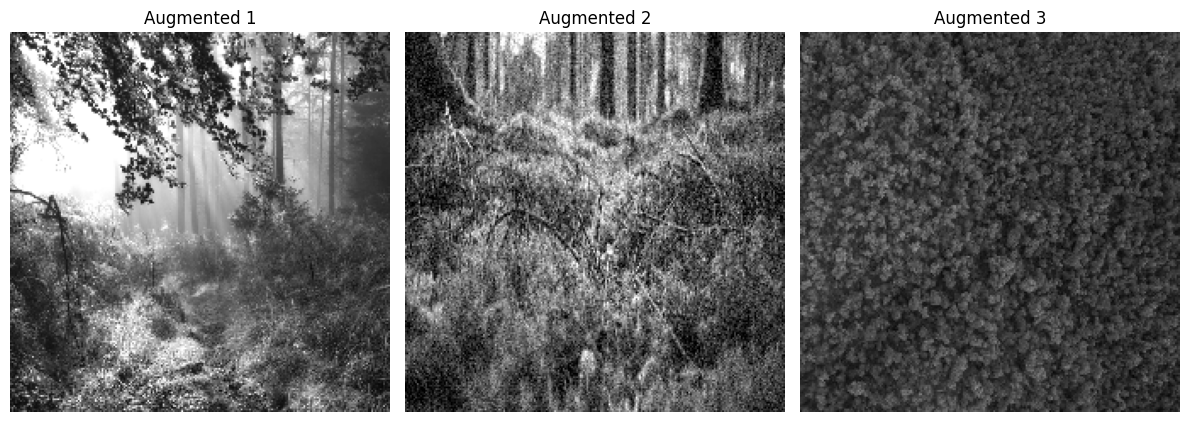

In [11]:
import matplotlib.pyplot as plt
import cv2
import glob
import os

augmented_files = glob.glob(output_folder + '/*.png')

if len(augmented_files) == 0:
    print("There is no image in Augmented")
else:
    plt.figure(figsize=(12, 6))
    for i in range(min(3, len(augmented_files))):
        img = cv2.imread(augmented_files[i])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 3, i+1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Augmented {i+1}")
    plt.tight_layout()
    plt.show()


# Segmentation

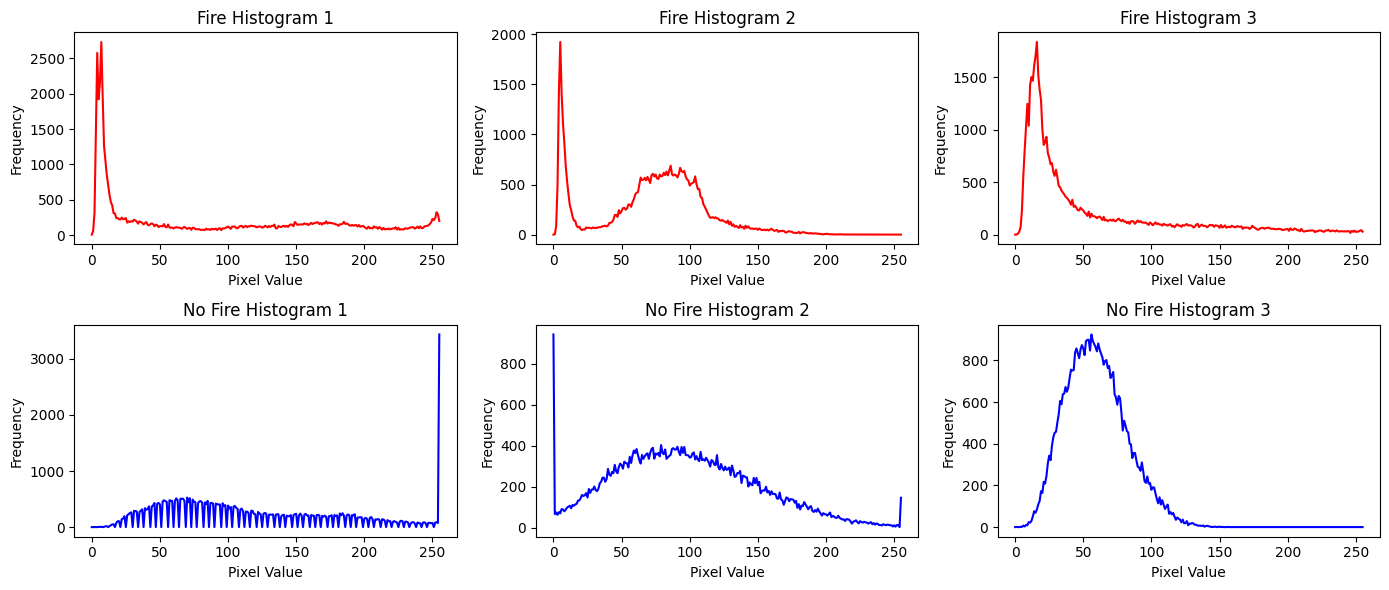

In [ ]:
import cv2
import matplotlib.pyplot as plt
import glob
import os

# Histogram

output_fire_gray_dir = "/kaggle/gray_fire"
output_folder = '/kaggle/working/augmented_non_fire_images'

fire_images = glob.glob(os.path.join(output_fire_gray_dir,'*.png'))
no_fire_images = glob.glob(os.path.join(output_folder,'*.png'))

num_samples = 3

plt.figure(figsize=(14, 6))

# Fire Histograms
for i in range(num_samples):
    img = cv2.imread(fire_images[i], cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    plt.subplot(2, num_samples, i+1)
    plt.plot(hist, color='red')
    plt.title(f'Fire Histogram {i+1}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

# No Fire Histograms
for i in range(num_samples):
    img = cv2.imread(no_fire_images[i], cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.plot(hist, color='blue')
    plt.title(f'No Fire Histogram {i+1}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Precision: 0.77
Recall:    0.20
F1-score:  0.31
Accuracy:  0.42


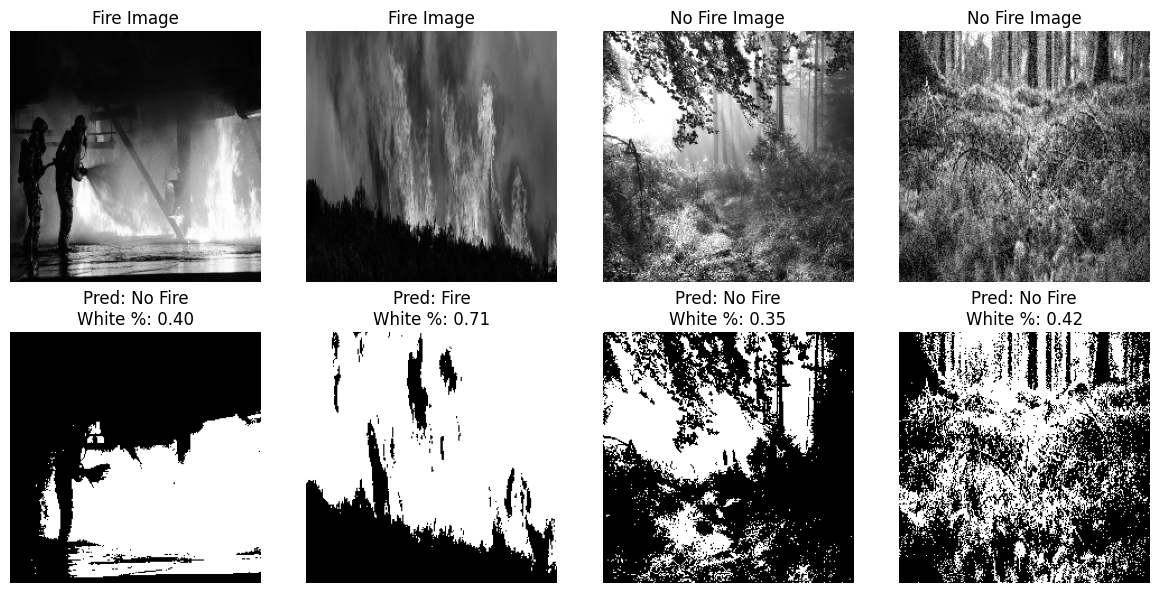

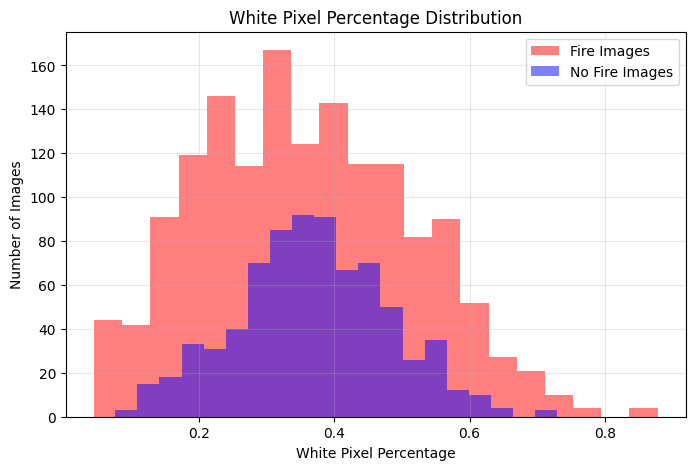

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

fire_dir = "/kaggle/gray_fire"
non_fire_dir = '/kaggle/working/augmented_non_fire_images'

# Get image paths
fire_images = glob.glob(os.path.join(fire_dir, '*.png'))
non_fire_images = glob.glob(os.path.join(non_fire_dir, '*.png'))
all_images = fire_images + non_fire_images

# Create true labels
true_labels = [1] * len(fire_images) + [0] * len(non_fire_images)
predicted_labels = []

# Function to classify image using Otsu thresholding
def classify_image(img_path, threshold=0.5):
    # Read image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    # Apply Otsu's thresholding
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Calculate white pixel percentage
    white_percentage = np.sum(binary == 255) / img.size

    # Classify based on white percentage
    prediction = 1 if white_percentage > threshold else 0

    return prediction, img, binary, white_percentage

# Process all images
for img_path in all_images:
    result = classify_image(img_path)
    if result is not None:
        prediction, _, _, _ = result
        predicted_labels.append(prediction)

# Calculate metrics
precision = precision_score(true_labels[:len(predicted_labels)], predicted_labels)
recall = recall_score(true_labels[:len(predicted_labels)], predicted_labels)
f1 = f1_score(true_labels[:len(predicted_labels)], predicted_labels)
accuracy = accuracy_score(true_labels[:len(predicted_labels)], predicted_labels)

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-score:  {f1:.2f}")
print(f"Accuracy:  {accuracy:.2f}")

# Visualize examples
def show_examples():
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    # Sample two fire images
    for i, path in enumerate(fire_images[:2]):
        prediction, original, binary, white_pct = classify_image(path)

        # Original image
        axes[0, i].imshow(original, cmap='gray')
        axes[0, i].set_title(f"Fire Image")
        axes[0, i].axis('off')

        # Binary image
        axes[1, i].imshow(binary, cmap='gray')
        axes[1, i].set_title(f"Pred: {'Fire' if prediction==1 else 'No Fire'}\nWhite %: {white_pct:.2f}")
        axes[1, i].axis('off')

    # Sample two non-fire images
    for i, path in enumerate(non_fire_images[:2]):
        prediction, original, binary, white_pct = classify_image(path)

        # Original image
        axes[0, i+2].imshow(original, cmap='gray')
        axes[0, i+2].set_title(f"No Fire Image")
        axes[0, i+2].axis('off')

        # Binary image
        axes[1, i+2].imshow(binary, cmap='gray')
        axes[1, i+2].set_title(f"Pred: {'Fire' if prediction==1 else 'No Fire'}\nWhite %: {white_pct:.2f}")
        axes[1, i+2].axis('off')

    plt.tight_layout()
    plt.show()

# Show example images
show_examples()

# Plot white percentage distribution
def plot_distributions():
    fire_pcts = [classify_image(path)[3] for path in fire_images if classify_image(path)]
    non_fire_pcts = [classify_image(path)[3] for path in non_fire_images if classify_image(path)]

    plt.figure(figsize=(8, 5))
    plt.hist(fire_pcts, alpha=0.5, bins=20, label='Fire Images', color='red')
    plt.hist(non_fire_pcts, alpha=0.5, bins=20, label='No Fire Images', color='blue')
    plt.xlabel('White Pixel Percentage')
    plt.ylabel('Number of Images')
    plt.title('White Pixel Percentage Distribution')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_distributions()

Precision: 0.64
Recall:    0.87
F1-score:  0.73
Accuracy:  0.58


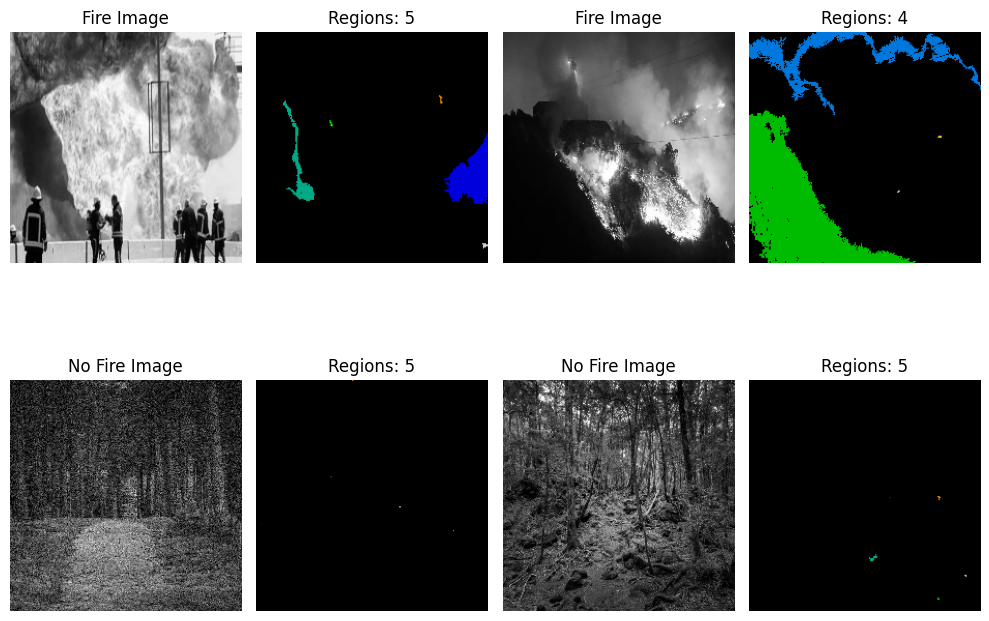

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import random
from collections import deque
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

fire_dir = "/kaggle/gray_fire"
no_fire_dir = '/kaggle/working/augmented_non_fire_images'

fire_images = glob.glob(os.path.join(fire_dir, '*.png'))
no_fire_images = glob.glob(os.path.join(no_fire_dir, '*.png'))
all_images = fire_images + no_fire_images

# Create true labels
true_labels = [1] * len(fire_images) + [0] * len(no_fire_images)
predicted_labels = []

def region_growing(img, threshold=5, num_seeds=5):
    # Simple region growing algorithm
    height, width = img.shape
    segmented = np.zeros((height, width), dtype=np.int32)

    region_id = 1

    # Generate random seeds
    for _ in range(num_seeds):
        x = random.randint(0, height - 1)
        y = random.randint(0, width - 1)

        if segmented[x, y] != 0:
            continue

        queue = deque([(x, y)])
        segmented[x, y] = region_id
        seed_value = img[x, y]

        while queue:
            x, y = queue.popleft()
            for dx, dy in [(-1,0), (0,-1), (0,1), (1,0)]:  # 4-connectivity
                nx, ny = x + dx, y + dy
                if 0 <= nx < height and 0 <= ny < width:
                    if segmented[nx, ny] == 0 and abs(int(img[nx, ny]) - int(seed_value)) <= threshold:
                        segmented[nx, ny] = region_id
                        queue.append((nx, ny))

        region_id += 1

    return segmented, region_id - 1

# Process all images and collect predictions
for img_path in all_images:
    try:
        # Load image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # Apply region growing
        segmented, num_regions = region_growing(img, threshold=5, num_seeds=10)

        # Classify based on number of regions (fire has more regions)
        prediction = 1 if num_regions > 7 else 0
        predicted_labels.append(prediction)

    except Exception as e:
        continue

# Calculate metrics
precision = precision_score(true_labels[:len(predicted_labels)], predicted_labels)
recall = recall_score(true_labels[:len(predicted_labels)], predicted_labels)
f1 = f1_score(true_labels[:len(predicted_labels)], predicted_labels)
accuracy = accuracy_score(true_labels[:len(predicted_labels)], predicted_labels)

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-score:  {f1:.2f}")
print(f"Accuracy:  {accuracy:.2f}")

# Visualize 2 samples from each class
def show_samples():
    plt.figure(figsize=(10, 8))

    # Show 2 fire samples
    for i, path in enumerate(random.sample(fire_images, 2)):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        segmented, num_regions = region_growing(img)
        colored = (segmented * 15).astype(np.uint8)  # Multiply to enhance visualization

        # Original image
        plt.subplot(2, 4, i*2+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Fire Image")
        plt.axis('off')

        # Segmented image
        plt.subplot(2, 4, i*2+2)
        plt.imshow(colored, cmap='nipy_spectral')
        plt.title(f"Regions: {num_regions}")
        plt.axis('off')

    # Show 2 non-fire samples
    for i, path in enumerate(random.sample(no_fire_images, 2)):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        segmented, num_regions = region_growing(img)
        colored = (segmented * 15).astype(np.uint8)  # Multiply to enhance visualization

        # Original image
        plt.subplot(2, 4, i*2+5)
        plt.imshow(img, cmap='gray')
        plt.title(f"No Fire Image")
        plt.axis('off')

        # Segmented image
        plt.subplot(2, 4, i*2+6)
        plt.imshow(colored, cmap='nipy_spectral')
        plt.title(f"Regions: {num_regions}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_samples()

# Harris

Precision: 0.67
Recall:    1.00
F1-score:  0.80
Accuracy:  0.67

Visualizing sample images...


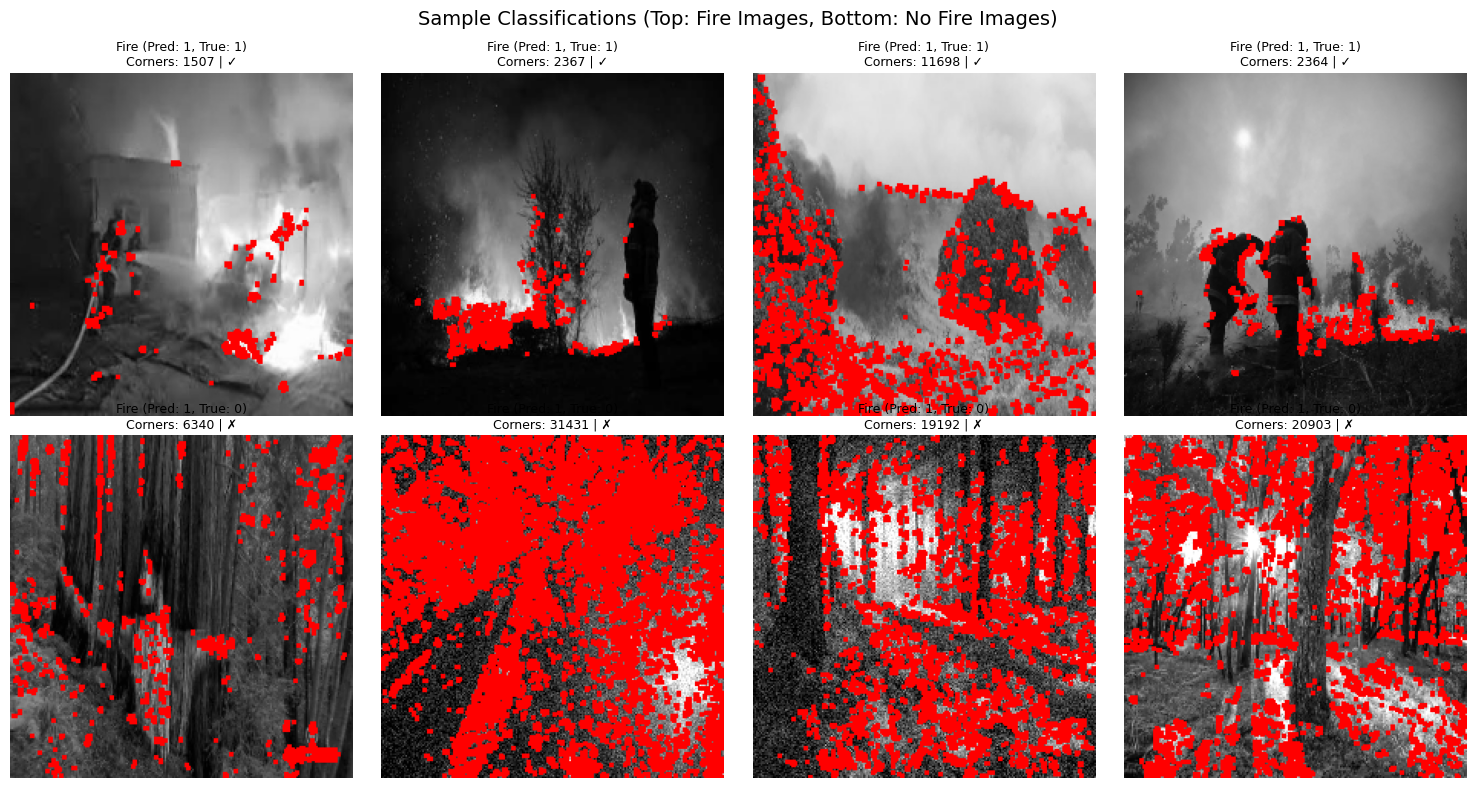

In [ ]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

fire_dir = "/kaggle/gray_fire"
no_fire_dir = "/kaggle/working/augmented_non_fire_images"

fire_images = glob.glob(fire_dir + '/*.png')
no_fire_images = glob.glob(no_fire_dir + '/*.png')

def detect_and_classify(image_path, corner_threshold=0.01, classification_threshold=300):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    gray = np.float32(img)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)

    corner_count = np.sum(dst > corner_threshold * dst.max())
    return 1 if corner_count > classification_threshold else 0

# Visualization function to display sample images with their classifications
def visualize_samples(fire_paths, no_fire_paths, num_samples=3):
    # Function to process and display an image with its detection result
    def process_and_display(ax, img_path, true_label):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            ax.text(0.5, 0.5, "Image not found", ha='center', va='center')
            ax.axis('off')
            return None

        # Get prediction
        pred = detect_and_classify(img_path)

        # Display image
        ax.imshow(img, cmap='gray')

        # Show corner detection visualization
        gray = np.float32(img)
        dst = cv2.cornerHarris(gray, 2, 3, 0.04)
        dst = cv2.dilate(dst, None)
        threshold = 0.01 * dst.max()

        # Create a copy of the image for visualization
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img_color[dst > threshold] = [255, 0, 0]  # Mark corners in red

        # Count corners
        corner_count = np.sum(dst > threshold)

        # Set title based on prediction and true label
        correct = pred == true_label
        title = f"{'Fire' if pred == 1 else 'No Fire'} (Pred: {pred}, True: {true_label})\n"
        title += f"Corners: {corner_count} | {'✓' if correct else '✗'}"

        ax.set_title(title, fontsize=9)
        ax.axis('off')

        # Return the colored image with corners marked
        return img_color

    # Create subplots for visualization
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))

    # Select random samples
    if len(fire_paths) > num_samples:
        fire_samples = np.random.choice(fire_paths, num_samples, replace=False)
    else:
        fire_samples = fire_paths

    if len(no_fire_paths) > num_samples:
        no_fire_samples = np.random.choice(no_fire_paths, num_samples, replace=False)
    else:
        no_fire_samples = no_fire_paths

    # Display fire samples
    for i, path in enumerate(fire_samples):
        img_color = process_and_display(axes[0, i], path, 1)
        if img_color is not None:
            axes[0, i].imshow(img_color)

    # Display no-fire samples
    for i, path in enumerate(no_fire_samples):
        img_color = process_and_display(axes[1, i], path, 0)
        if img_color is not None:
            axes[1, i].imshow(img_color)

    plt.tight_layout()
    plt.suptitle('Sample Classifications (Top: Fire Images, Bottom: No Fire Images)', fontsize=14, y=0.98)
    plt.subplots_adjust(top=0.9)
    plt.show()

# Original classification and metrics calculation
true_labels = [1] * len(fire_images) + [0] * len(no_fire_images)
predicted_labels = []

for path in fire_images + no_fire_images:
    prediction = detect_and_classify(path)
    if prediction is not None:
        predicted_labels.append(prediction)
    else:
        true_labels.pop()

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-score:  {f1:.2f}")
print(f"Accuracy:  {accuracy:.2f}")

print("\nVisualizing sample images...")
visualize_samples(fire_images, no_fire_images, num_samples=4)

# SIFT

Precision: 0.67
Recall:    0.99
F1-score:  0.80
Accuracy:  0.66


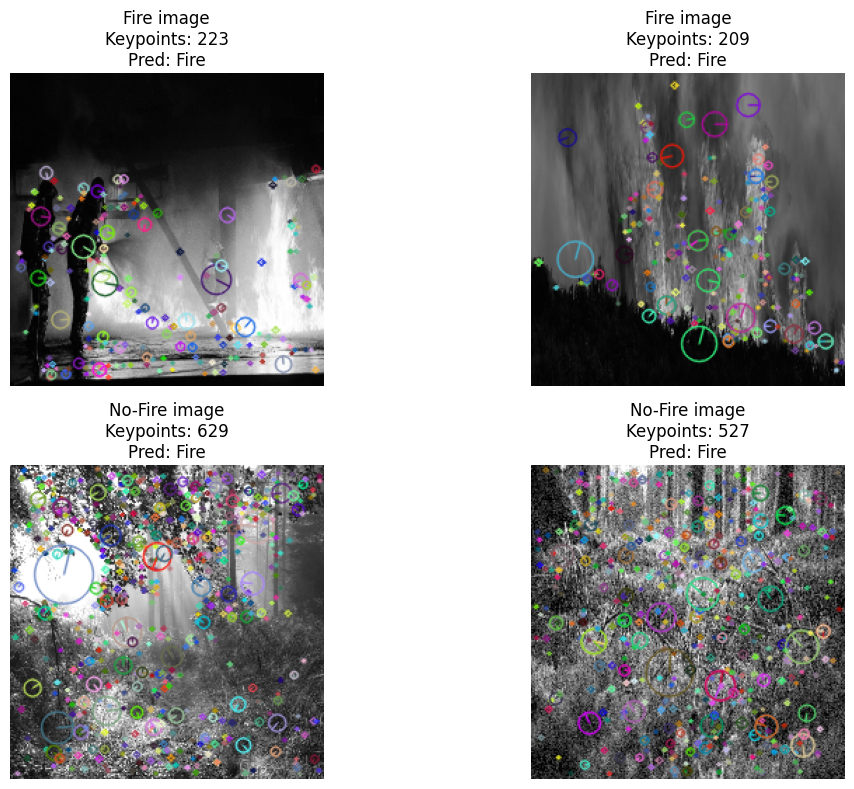

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import os

fire_dir = "/kaggle/gray_fire"
no_fire_dir = "/kaggle/working/augmented_non_fire_images"

fire_images = glob.glob(fire_dir + '/*.png')
no_fire_images = glob.glob(no_fire_dir + '/*.png')

def classify_with_sift(image_path, keypoint_threshold=50):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None

    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)

    return 1 if len(keypoints) > keypoint_threshold else 0

# Create true labels and get predictions
true_labels = [1] * len(fire_images) + [0] * len(no_fire_images)
predicted_labels = []

for path in fire_images + no_fire_images:
    prediction = classify_with_sift(path)
    if prediction is not None:
        predicted_labels.append(prediction)
    else:
        true_labels.pop()

# Calculate metrics
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-score:  {f1:.2f}")
print(f"Accuracy:  {accuracy:.2f}")

# Show sample images with keypoints
def show_samples(num_samples=2):
    plt.figure(figsize=(12, 8))

    # Show fire samples
    for i in range(min(num_samples, len(fire_images))):
        image_path = fire_images[i]
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Get keypoints
        sift = cv2.SIFT_create()
        keypoints, _ = sift.detectAndCompute(img, None)

        # Draw keypoints
        img_with_kp = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        # Convert from BGR to RGB for matplotlib
        img_with_kp = cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB)

        # Plot
        plt.subplot(2, num_samples, i+1)
        plt.imshow(img_with_kp)
        prediction = 1 if len(keypoints) > 50 else 0
        plt.title(f"Fire image\nKeypoints: {len(keypoints)}\nPred: {'Fire' if prediction==1 else 'No Fire'}")
        plt.axis('off')

    # Show no-fire samples
    for i in range(min(num_samples, len(no_fire_images))):
        image_path = no_fire_images[i]
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Get keypoints
        sift = cv2.SIFT_create()
        keypoints, _ = sift.detectAndCompute(img, None)

        # Draw keypoints
        img_with_kp = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        # Convert from BGR to RGB for matplotlib
        img_with_kp = cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB)

        # Plot
        plt.subplot(2, num_samples, num_samples+i+1)
        plt.imshow(img_with_kp)
        prediction = 1 if len(keypoints) > 50 else 0
        plt.title(f"No-Fire image\nKeypoints: {len(keypoints)}\nPred: {'Fire' if prediction==1 else 'No Fire'}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_samples()

# HOG

In [15]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from tqdm import tqdm

# Paths to datasets
fire_dir = "/kaggle/gray_fire"
no_fire_dir = "/kaggle/working/augmented_non_fire_images"

fire_images = glob.glob(fire_dir + '/*.png')
no_fire_images = glob.glob(no_fire_dir + '/*.png')

print(f"Found {len(fire_images)} fire images and {len(no_fire_images)} non-fire images")

# Parameters for HOG
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
hog_size = (128, 128)  # Resize images to this size for consistent HOG features

def classify_with_hog(image_path, hog_threshold=0.3):
    """
    Classify an image as fire (1) or non-fire (0) using HOG features
    This is a simplified approach that looks at the overall intensity of HOG features
    """
    try:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Error: Could not read {image_path}")
            return None

        # Resize for consistent HOG feature extraction
        resized = cv2.resize(image, hog_size)

        # Extract HOG features
        features, hog_image = hog(
            resized,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm='L2-Hys',
            visualize=True,
            feature_vector=True
        )

        # Calculate feature intensity (normalized sum)
        feature_intensity = np.sum(features) / len(features)

        # Classify based on feature intensity
        # Fire tends to have more edges/corners resulting in higher HOG values
        return 1 if feature_intensity > hog_threshold else 0

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Function to visualize sample images with HOG features
def visualize_samples(fire_samples=3, no_fire_samples=3):
    # Create figure
    fig, axes = plt.subplots(2, fire_samples, figsize=(15, 8))

    # Process fire images
    print("Visualizing fire samples...")
    for i, path in enumerate(fire_images[:fire_samples]):
        # Read image
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue

        # Resize for consistent HOG
        resized = cv2.resize(image, hog_size)

        # Extract HOG features
        _, hog_image = hog(
            resized,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm='L2-Hys',
            visualize=True
        )

        # Display original
        axes[0, i].imshow(resized, cmap='gray')
        axes[0, i].set_title(f"Fire Image {i+1}")
        axes[0, i].axis('off')

        # Display HOG
        axes[1, i].imshow(hog_image, cmap='viridis')
        axes[1, i].set_title(f"Fire HOG {i+1}")
        axes[1, i].axis('off')

    # Create second figure for no-fire images
    fig2, axes2 = plt.subplots(2, no_fire_samples, figsize=(15, 8))

    # Process no-fire images
    print("Visualizing non-fire samples...")
    for i, path in enumerate(no_fire_images[:no_fire_samples]):
        # Read image
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue

        # Resize for consistent HOG
        resized = cv2.resize(image, hog_size)

        # Extract HOG features
        _, hog_image = hog(
            resized,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm='L2-Hys',
            visualize=True
        )

        # Display original
        axes2[0, i].imshow(resized, cmap='gray')
        axes2[0, i].set_title(f"No Fire Image {i+1}")
        axes2[0, i].axis('off')

        # Display HOG
        axes2[1, i].imshow(hog_image, cmap='viridis')
        axes2[1, i].set_title(f"No Fire HOG {i+1}")
        axes2[1, i].axis('off')

    plt.tight_layout()
    plt.show()

    return fig, fig2

# Determine the best threshold by testing a range of values
def find_best_threshold(sample_size=100):
    print("Finding optimal HOG threshold...")

    # Get a subset of images for faster processing
    sample_fire = fire_images[:min(sample_size, len(fire_images))]
    sample_no_fire = no_fire_images[:min(sample_size, len(no_fire_images))]
    sample_paths = sample_fire + sample_no_fire
    sample_labels = [1] * len(sample_fire) + [0] * len(sample_no_fire)

    # Store feature intensities
    feature_values = []
    valid_labels = []

    # Calculate HOG feature intensities for all samples
    for path, label in tqdm(zip(sample_paths, sample_labels), total=len(sample_paths), desc="Calculating features"):
        try:
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue

            # Resize for HOG
            resized = cv2.resize(image, hog_size)

            # Extract HOG features
            features, _ = hog(
                resized,
                orientations=orientations,
                pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block,
                block_norm='L2-Hys',
                visualize=True,
                feature_vector=True
            )

            # Calculate feature intensity
            feature_intensity = np.sum(features) / len(features)
            feature_values.append(feature_intensity)
            valid_labels.append(label)

        except Exception as e:
            print(f"Error processing {path} during threshold search: {e}")

    # Test different thresholds
    thresholds = np.linspace(min(feature_values), max(feature_values), 20)
    best_threshold = 0
    best_f1 = 0

    results = []

    for threshold in thresholds:
        # Make predictions with this threshold
        predictions = [1 if fv > threshold else 0 for fv in feature_values]

        # Calculate metrics
        precision = precision_score(valid_labels, predictions)
        recall = recall_score(valid_labels, predictions)
        f1 = f1_score(valid_labels, predictions)
        accuracy = accuracy_score(valid_labels, predictions)

        results.append((threshold, precision, recall, f1, accuracy))

        # Update best if better F1
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Print results for each threshold
    print("\nThreshold testing results:")
    print(f"{'Threshold':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'Accuracy':<10}")
    print("-" * 50)
    for thresh, prec, rec, f1, acc in results:
        print(f"{thresh:<10.4f} {prec:<10.4f} {rec:<10.4f} {f1:<10.4f} {acc:<10.4f}")

    print(f"\nBest threshold: {best_threshold:.4f} (F1: {best_f1:.4f})")
    return best_threshold

# Main classification function
def process_all_images(hog_threshold=None):
    # Find best threshold if none provided
    if hog_threshold is None:
        hog_threshold = find_best_threshold()

    # Prepare true labels
    true_labels = [1] * len(fire_images) + [0] * len(no_fire_images)
    predicted_labels = []

    # Process all images
    print("\nClassifying all images...")
    all_paths = fire_images + no_fire_images
    for path in tqdm(all_paths, desc="Processing"):
        prediction = classify_with_hog(path, hog_threshold)
        if prediction is not None:
            predicted_labels.append(prediction)
        else:
            # If there was an error, remove the corresponding true label
            idx = all_paths.index(path)
            if idx < len(true_labels):
                true_labels.pop(idx)

    # Calculate metrics
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Print results
    print("\nFinal Results:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"Accuracy:  {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Calculate additional metrics
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"Specificity: {specificity:.4f}")

    return precision, recall, f1, accuracy

# Visualize sample images with HOG features
visualize_samples(fire_samples=3, no_fire_samples=3)

# Process all images and get metrics
process_all_images()

Found 1510 fire images and 755 non-fire images
Visualizing fire samples...
Visualizing non-fire samples...
Finding optimal HOG threshold...


Calculating features: 100%|██████████| 200/200 [00:08<00:00, 22.30it/s]



Threshold testing results:
Threshold  Precision  Recall     F1         Accuracy  
--------------------------------------------------
0.1080     0.4975     0.9900     0.6622     0.4950    
0.1106     0.4949     0.9800     0.6577     0.4900    
0.1132     0.4924     0.9700     0.6532     0.4850    
0.1158     0.4872     0.9500     0.6441     0.4750    
0.1184     0.4709     0.8900     0.6159     0.4450    
0.1210     0.4649     0.8600     0.6035     0.4350    
0.1236     0.4494     0.8000     0.5755     0.4100    
0.1262     0.4425     0.7700     0.5620     0.4000    
0.1288     0.4438     0.7500     0.5576     0.4050    
0.1314     0.4259     0.6900     0.5267     0.3800    
0.1340     0.4026     0.6200     0.4882     0.3500    
0.1366     0.3706     0.5300     0.4362     0.3150    
0.1392     0.3566     0.4600     0.4017     0.3150    
0.1418     0.3276     0.3800     0.3519     0.3000    
0.1444     0.2577     0.2500     0.2538     0.2650    
0.1470     0.1233     0.0900     0.1040  

Processing: 100%|██████████| 2265/2265 [01:52<00:00, 20.06it/s]


Final Results:
Precision: 0.6655
Recall:    0.9854
F1-score:  0.7944
Accuracy:  0.6600

Confusion Matrix:
[[   7  748]
 [  22 1488]]
Specificity: 0.0093


(0.6654740608228981, 0.9854304635761589, 0.794447410571276, 0.6600441501103753)

In [ ]:
from skimage.feature import hog
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

fire_dir = "/kaggle/gray_fire"
no_fire_dir = "/kaggle/working/augmented_non_fire_images"

fire_images = glob.glob(fire_dir + '/*.png')
no_fire_images = glob.glob(no_fire_dir + '/*.png')

def classify_with_hog(image_path, feature_threshold=5000):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None

    resized = cv2.resize(image, (128, 128))
    features, _ = hog(resized, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True, feature_vector=True)

    return 1 if len(features) > feature_threshold else 0

true_labels = [1] * len(fire_images) + [0] * len(no_fire_images)
predicted_labels = []

for path in fire_images + no_fire_images:
    prediction = classify_with_hog(path)
    if prediction is not None:
        predicted_labels.append(prediction)
    else:
        true_labels.pop()

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-score:  {f1:.2f}")
print(f"Accuracy:  {accuracy:.2f}")


Precision: 0.67
Recall:    1.00
F1-score:  0.80
Accuracy:  0.67


# YOLO

In [14]:
import cv2
import glob
import os
from ultralytics import YOLO
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import numpy as np
from tqdm import tqdm

# Use a pre-trained YOLOv8 model instead of custom model
# Options: 'yolov8n', 'yolov8s', 'yolov8m', 'yolov8l', 'yolov8x'
model = YOLO('yolov8s.pt')  # This will download the model if not present

# Paths to datasets
fire_images = glob.glob('/kaggle/gray_fire/*.png')
no_fire_images = glob.glob('/kaggle/working/augmented_non_fire_images/*.png')

print(f"Found {len(fire_images)} fire images and {len(no_fire_images)} non-fire images")

# Prepare labels
true_labels = [1] * len(fire_images) + [0] * len(no_fire_images)
predicted_labels = []

# Function to classify an image as fire or no-fire
def classify_yolo(image_path, conf_threshold=0.3):
    try:
        # Run inference
        results = model(image_path)

        # Check for objects with high confidence
        # YOLOv8 pretrained model doesn't have a "fire" class, so we'll adapt
        # by looking for objects that might indicate fire (e.g., person near fire)
        # This is just a placeholder - for real fire detection, you should train a custom model

        has_fire = False
        for result in results:
            # YOLOv8 returns confidence scores in result.boxes.conf
            detections = result.boxes
            if len(detections) > 0:
                confidences = detections.conf.cpu().numpy()
                if any(conf > conf_threshold for conf in confidences):
                    # This is just for demonstration - in reality, you need a fire-specific model
                    has_fire = True
                    break

        return 1 if has_fire else 0
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Process all images
all_images = fire_images + no_fire_images
for path in tqdm(all_images, desc="Processing images"):
    try:
        pred = classify_yolo(path)
        if pred is not None:
            predicted_labels.append(pred)
        else:
            # If there was an error, remove corresponding true label
            idx = all_images.index(path)
            true_labels.pop(idx)
    except Exception as e:
        print(f"Critical error processing {path}: {e}")
        idx = all_images.index(path)
        true_labels.pop(idx)

# Calculate metrics
if len(predicted_labels) > 0:
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    print(f"\nResults:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"\nConfusion Matrix:")
    print(conf_matrix)

    # Calculate additional metrics
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"Specificity: {specificity:.4f}")
else:
    print("No valid predictions were made")

100%|██████████| 21.5M/21.5M [00:00<00:00, 317MB/s]


Found 1510 fire images and 755 non-fire images


Processing images:   0%|          | 0/2265 [00:00<?, ?it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0415.png: 640x640 2 persons, 814.4ms
Speed: 3.9ms preprocess, 814.4ms inference, 36.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   0%|          | 1/2265 [00:02<1:33:13,  2.47s/it]


image 1/1 /kaggle/gray_fire/resized_gray_0020.png: 640x640 (no detections), 595.8ms
Speed: 3.6ms preprocess, 595.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   0%|          | 2/2265 [00:03<51:52,  1.38s/it]  


image 1/1 /kaggle/gray_fire/resized_gray_0345.png: 640x640 1 bicycle, 605.1ms
Speed: 6.2ms preprocess, 605.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   0%|          | 3/2265 [00:03<38:50,  1.03s/it]


image 1/1 /kaggle/gray_fire/resized_gray_0532.png: 640x640 (no detections), 599.6ms
Speed: 3.9ms preprocess, 599.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   0%|          | 4/2265 [00:04<32:35,  1.16it/s]


image 1/1 /kaggle/gray_fire/gray_0650.png: 448x640 (no detections), 447.8ms
Speed: 3.4ms preprocess, 447.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   0%|          | 5/2265 [00:04<27:05,  1.39it/s]


image 1/1 /kaggle/gray_fire/gray_0475.png: 416x640 (no detections), 420.5ms
Speed: 2.7ms preprocess, 420.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing images:   0%|          | 6/2265 [00:05<23:27,  1.60it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0604.png: 640x640 1 truck, 589.2ms
Speed: 4.6ms preprocess, 589.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   0%|          | 7/2265 [00:05<23:11,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0042.png: 416x640 (no detections), 393.6ms
Speed: 3.0ms preprocess, 393.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing images:   0%|          | 8/2265 [00:06<20:44,  1.81it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0048.png: 640x640 1 bus, 608.9ms
Speed: 4.6ms preprocess, 608.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   0%|          | 9/2265 [00:06<21:33,  1.74it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0139.png: 640x640 (no detections), 601.2ms
Speed: 4.6ms preprocess, 601.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   0%|          | 10/2265 [00:07<22:00,  1.71it/s]


image 1/1 /kaggle/gray_fire/gray_0682.png: 384x640 (no detections), 388.1ms
Speed: 3.3ms preprocess, 388.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   0%|          | 11/2265 [00:07<19:51,  1.89it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0362.png: 640x640 (no detections), 651.7ms
Speed: 4.5ms preprocess, 651.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 12/2265 [00:08<21:24,  1.75it/s]


image 1/1 /kaggle/gray_fire/gray_0586.png: 384x640 2 trains, 596.4ms
Speed: 3.2ms preprocess, 596.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   1%|          | 13/2265 [00:09<21:51,  1.72it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0451.png: 640x640 (no detections), 960.3ms
Speed: 5.5ms preprocess, 960.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 14/2265 [00:10<26:17,  1.43it/s]


image 1/1 /kaggle/gray_fire/gray_0252.png: 448x640 (no detections), 673.7ms
Speed: 5.2ms preprocess, 673.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   1%|          | 15/2265 [00:10<26:40,  1.41it/s]


image 1/1 /kaggle/gray_fire/gray_0282.png: 384x640 5 persons, 557.1ms
Speed: 4.0ms preprocess, 557.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   1%|          | 16/2265 [00:11<25:15,  1.48it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0688.png: 640x640 1 person, 606.2ms
Speed: 3.6ms preprocess, 606.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 17/2265 [00:12<24:37,  1.52it/s]


image 1/1 /kaggle/gray_fire/gray_0631.png: 448x640 (no detections), 435.3ms
Speed: 4.0ms preprocess, 435.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   1%|          | 18/2265 [00:12<25:35,  1.46it/s]


image 1/1 /kaggle/gray_fire/gray_0398.png: 384x640 (no detections), 364.8ms
Speed: 2.4ms preprocess, 364.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   1%|          | 19/2265 [00:13<22:08,  1.69it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0443.png: 640x640 2 persons, 1 car, 606.9ms
Speed: 4.7ms preprocess, 606.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 20/2265 [00:13<22:27,  1.67it/s]


image 1/1 /kaggle/gray_fire/gray_0593.png: 320x640 (no detections), 326.7ms
Speed: 2.3ms preprocess, 326.7ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


Processing images:   1%|          | 21/2265 [00:14<19:32,  1.91it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0102.png: 640x640 (no detections), 602.9ms
Speed: 4.7ms preprocess, 602.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 22/2265 [00:14<20:34,  1.82it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0335.png: 640x640 1 person, 587.5ms
Speed: 3.7ms preprocess, 587.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 23/2265 [00:15<21:07,  1.77it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0544.png: 640x640 3 persons, 606.4ms
Speed: 5.2ms preprocess, 606.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 24/2265 [00:15<21:43,  1.72it/s]


image 1/1 /kaggle/gray_fire/gray_0413.png: 480x640 (no detections), 460.3ms
Speed: 3.7ms preprocess, 460.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:   1%|          | 25/2265 [00:16<20:28,  1.82it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0561.png: 640x640 2 persons, 606.1ms
Speed: 4.3ms preprocess, 606.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 26/2265 [00:17<21:14,  1.76it/s]


image 1/1 /kaggle/gray_fire/gray_0231.png: 384x640 (no detections), 366.7ms
Speed: 2.7ms preprocess, 366.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   1%|          | 27/2265 [00:17<19:09,  1.95it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0005.png: 640x640 4 persons, 600.5ms
Speed: 3.8ms preprocess, 600.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|          | 28/2265 [00:18<20:17,  1.84it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0259.png: 640x640 1 person, 582.7ms
Speed: 4.8ms preprocess, 582.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|▏         | 29/2265 [00:18<20:51,  1.79it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0222.png: 640x640 (no detections), 605.4ms
Speed: 4.7ms preprocess, 605.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   1%|▏         | 30/2265 [00:19<21:29,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0581.png: 480x640 (no detections), 440.2ms
Speed: 3.0ms preprocess, 440.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:   1%|▏         | 31/2265 [00:19<20:06,  1.85it/s]


image 1/1 /kaggle/gray_fire/gray_0036.png: 384x640 1 person, 390.5ms
Speed: 4.9ms preprocess, 390.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   1%|▏         | 32/2265 [00:20<18:44,  1.98it/s]


image 1/1 /kaggle/gray_fire/gray_0737.png: 384x640 (no detections), 371.5ms
Speed: 3.1ms preprocess, 371.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   1%|▏         | 33/2265 [00:20<17:22,  2.14it/s]


image 1/1 /kaggle/gray_fire/gray_0183.png: 320x640 1 person, 309.9ms
Speed: 2.9ms preprocess, 309.9ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


Processing images:   2%|▏         | 34/2265 [00:20<15:45,  2.36it/s]


image 1/1 /kaggle/gray_fire/gray_0275.png: 480x640 (no detections), 465.6ms
Speed: 3.6ms preprocess, 465.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:   2%|▏         | 35/2265 [00:21<16:32,  2.25it/s]


image 1/1 /kaggle/gray_fire/gray_0289.png: 384x640 (no detections), 575.4ms
Speed: 2.5ms preprocess, 575.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   2%|▏         | 36/2265 [00:21<18:08,  2.05it/s]


image 1/1 /kaggle/gray_fire/gray_0496.png: 480x640 7 persons, 732.7ms
Speed: 3.7ms preprocess, 732.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing images:   2%|▏         | 37/2265 [00:22<21:02,  1.77it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0505.png: 640x640 (no detections), 944.0ms
Speed: 5.8ms preprocess, 944.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 38/2265 [00:23<25:24,  1.46it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0340.png: 640x640 2 persons, 1 fire hydrant, 854.7ms
Speed: 4.3ms preprocess, 854.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 39/2265 [00:24<27:25,  1.35it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0138.png: 640x640 (no detections), 585.6ms
Speed: 3.7ms preprocess, 585.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 40/2265 [00:25<25:51,  1.43it/s]


image 1/1 /kaggle/gray_fire/gray_0522.png: 448x640 (no detections), 435.6ms
Speed: 3.6ms preprocess, 435.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   2%|▏         | 41/2265 [00:25<23:11,  1.60it/s]


image 1/1 /kaggle/gray_fire/gray_0374.png: 448x640 (no detections), 415.3ms
Speed: 2.8ms preprocess, 415.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   2%|▏         | 42/2265 [00:25<21:01,  1.76it/s]


image 1/1 /kaggle/gray_fire/gray_0303.png: 384x640 3 persons, 386.5ms
Speed: 2.9ms preprocess, 386.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   2%|▏         | 43/2265 [00:26<19:09,  1.93it/s]


image 1/1 /kaggle/gray_fire/gray_0270.png: 384x640 (no detections), 373.0ms
Speed: 3.6ms preprocess, 373.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   2%|▏         | 44/2265 [00:26<17:42,  2.09it/s]


image 1/1 /kaggle/gray_fire/gray_0391.png: 384x640 (no detections), 374.0ms
Speed: 2.9ms preprocess, 374.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   2%|▏         | 45/2265 [00:27<16:42,  2.21it/s]


image 1/1 /kaggle/gray_fire/gray_0368.png: 480x640 1 person, 7 cars, 465.2ms
Speed: 4.0ms preprocess, 465.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing images:   2%|▏         | 46/2265 [00:27<17:02,  2.17it/s]


image 1/1 /kaggle/gray_fire/gray_0219.png: 384x640 (no detections), 374.4ms
Speed: 3.8ms preprocess, 374.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   2%|▏         | 47/2265 [00:28<16:18,  2.27it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0053.png: 640x640 2 cars, 1 stop sign, 609.8ms
Speed: 5.2ms preprocess, 609.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 48/2265 [00:28<18:20,  2.01it/s]


image 1/1 /kaggle/gray_fire/gray_0730.png: 448x640 (no detections), 419.7ms
Speed: 3.3ms preprocess, 419.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   2%|▏         | 49/2265 [00:29<17:43,  2.08it/s]


image 1/1 /kaggle/gray_fire/gray_0504.png: 288x640 (no detections), 292.0ms
Speed: 2.8ms preprocess, 292.0ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


Processing images:   2%|▏         | 50/2265 [00:29<15:50,  2.33it/s]


image 1/1 /kaggle/gray_fire/gray_0554.png: 384x640 (no detections), 380.8ms
Speed: 7.0ms preprocess, 380.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   2%|▏         | 51/2265 [00:29<15:30,  2.38it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0202.png: 640x640 2 persons, 598.0ms
Speed: 4.4ms preprocess, 598.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 52/2265 [00:30<17:35,  2.10it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0288.png: 640x640 (no detections), 601.7ms
Speed: 5.7ms preprocess, 601.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 53/2265 [00:31<19:07,  1.93it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0291.png: 640x640 (no detections), 607.3ms
Speed: 5.1ms preprocess, 607.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 54/2265 [00:31<20:13,  1.82it/s]


image 1/1 /kaggle/gray_fire/gray_0023.png: 384x640 (no detections), 374.5ms
Speed: 3.9ms preprocess, 374.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   2%|▏         | 55/2265 [00:32<18:32,  1.99it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0545.png: 640x640 (no detections), 611.5ms
Speed: 4.4ms preprocess, 611.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   2%|▏         | 56/2265 [00:32<19:52,  1.85it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0125.png: 640x640 1 person, 588.5ms
Speed: 4.3ms preprocess, 588.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 57/2265 [00:33<20:32,  1.79it/s]


image 1/1 /kaggle/gray_fire/gray_0364.png: 480x640 (no detections), 464.3ms
Speed: 4.1ms preprocess, 464.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing images:   3%|▎         | 58/2265 [00:33<19:44,  1.86it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0072.png: 640x640 2 persons, 620.6ms
Speed: 4.2ms preprocess, 620.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 59/2265 [00:34<20:50,  1.76it/s]


image 1/1 /kaggle/gray_fire/gray_0448.png: 416x640 2 persons, 1 baseball bat, 648.8ms
Speed: 6.6ms preprocess, 648.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing images:   3%|▎         | 60/2265 [00:35<21:57,  1.67it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0094.png: 640x640 1 truck, 941.6ms
Speed: 4.7ms preprocess, 941.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 61/2265 [00:36<25:59,  1.41it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0227.png: 640x640 2 persons, 944.3ms
Speed: 6.1ms preprocess, 944.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 62/2265 [00:37<28:44,  1.28it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0495.png: 640x640 (no detections), 663.5ms
Speed: 5.0ms preprocess, 663.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 63/2265 [00:37<27:33,  1.33it/s]


image 1/1 /kaggle/gray_fire/gray_0719.png: 288x640 2 trucks, 302.6ms
Speed: 3.2ms preprocess, 302.6ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)


Processing images:   3%|▎         | 64/2265 [00:38<22:48,  1.61it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0189.png: 640x640 (no detections), 592.1ms
Speed: 4.8ms preprocess, 592.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 65/2265 [00:38<22:36,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0102.png: 384x640 (no detections), 391.8ms
Speed: 2.4ms preprocess, 391.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   3%|▎         | 66/2265 [00:39<20:14,  1.81it/s]


image 1/1 /kaggle/gray_fire/gray_0416.png: 384x640 (no detections), 365.2ms
Speed: 3.3ms preprocess, 365.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   3%|▎         | 67/2265 [00:39<18:20,  2.00it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0349.png: 640x640 (no detections), 591.4ms
Speed: 4.7ms preprocess, 591.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 68/2265 [00:40<19:29,  1.88it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0026.png: 640x640 3 persons, 599.2ms
Speed: 5.5ms preprocess, 599.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 69/2265 [00:40<20:21,  1.80it/s]


image 1/1 /kaggle/gray_fire/gray_0676.png: 448x640 1 person, 1 airplane, 440.5ms
Speed: 3.9ms preprocess, 440.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   3%|▎         | 70/2265 [00:41<21:48,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0709.png: 448x640 6 persons, 1 truck, 1 umbrella, 417.5ms
Speed: 3.2ms preprocess, 417.5ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   3%|▎         | 71/2265 [00:41<20:04,  1.82it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0103.png: 640x640 (no detections), 607.6ms
Speed: 5.1ms preprocess, 607.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 72/2265 [00:42<20:52,  1.75it/s]


image 1/1 /kaggle/gray_fire/gray_0291.png: 384x640 (no detections), 368.7ms
Speed: 3.7ms preprocess, 368.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   3%|▎         | 73/2265 [00:42<18:47,  1.94it/s]


image 1/1 /kaggle/gray_fire/gray_0516.png: 416x640 (no detections), 413.5ms
Speed: 3.2ms preprocess, 413.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing images:   3%|▎         | 74/2265 [00:43<17:52,  2.04it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0624.png: 640x640 1 person, 1 dog, 1 horse, 590.6ms
Speed: 4.9ms preprocess, 590.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 75/2265 [00:43<19:06,  1.91it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0444.png: 640x640 1 person, 606.7ms
Speed: 4.4ms preprocess, 606.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 76/2265 [00:44<20:08,  1.81it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0381.png: 640x640 (no detections), 583.6ms
Speed: 4.7ms preprocess, 583.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 77/2265 [00:44<20:35,  1.77it/s]


image 1/1 /kaggle/gray_fire/gray_0494.png: 384x640 (no detections), 389.7ms
Speed: 2.4ms preprocess, 389.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   3%|▎         | 78/2265 [00:45<18:48,  1.94it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0591.png: 640x640 (no detections), 582.0ms
Speed: 5.5ms preprocess, 582.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   3%|▎         | 79/2265 [00:45<19:42,  1.85it/s]


image 1/1 /kaggle/gray_fire/gray_0491.png: 448x640 (no detections), 431.4ms
Speed: 3.4ms preprocess, 431.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   4%|▎         | 80/2265 [00:46<18:58,  1.92it/s]


image 1/1 /kaggle/gray_fire/gray_0333.png: 416x640 2 persons, 1 car, 1 baseball glove, 390.9ms
Speed: 4.0ms preprocess, 390.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing images:   4%|▎         | 81/2265 [00:46<17:42,  2.06it/s]


image 1/1 /kaggle/gray_fire/gray_0700.png: 480x640 4 persons, 519.9ms
Speed: 3.7ms preprocess, 519.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing images:   4%|▎         | 82/2265 [00:47<18:15,  1.99it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0118.png: 640x640 1 truck, 939.6ms
Speed: 4.5ms preprocess, 939.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▎         | 83/2265 [00:48<23:13,  1.57it/s]


image 1/1 /kaggle/gray_fire/gray_0256.png: 416x640 2 persons, 616.1ms
Speed: 4.5ms preprocess, 616.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing images:   4%|▎         | 84/2265 [00:49<23:10,  1.57it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0211.png: 640x640 1 person, 1 bus, 1 truck, 944.0ms
Speed: 4.7ms preprocess, 944.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▍         | 85/2265 [00:49<26:42,  1.36it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0113.png: 640x640 4 persons, 675.1ms
Speed: 4.4ms preprocess, 675.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▍         | 86/2265 [00:50<26:10,  1.39it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0301.png: 640x640 2 persons, 1 traffic light, 589.9ms
Speed: 5.2ms preprocess, 589.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▍         | 87/2265 [00:51<24:53,  1.46it/s]


image 1/1 /kaggle/gray_fire/gray_0154.png: 448x640 1 person, 1 horse, 438.6ms
Speed: 3.0ms preprocess, 438.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   4%|▍         | 88/2265 [00:51<22:26,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0193.png: 320x640 3 persons, 318.2ms
Speed: 2.3ms preprocess, 318.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


Processing images:   4%|▍         | 89/2265 [00:52<19:19,  1.88it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0455.png: 640x640 1 person, 1 parking meter, 601.1ms
Speed: 4.8ms preprocess, 601.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▍         | 90/2265 [00:52<20:13,  1.79it/s]


image 1/1 /kaggle/gray_fire/gray_0579.png: 480x640 (no detections), 448.2ms
Speed: 4.7ms preprocess, 448.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:   4%|▍         | 91/2265 [00:53<19:12,  1.89it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0356.png: 640x640 1 person, 609.6ms
Speed: 4.5ms preprocess, 609.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▍         | 92/2265 [00:53<20:12,  1.79it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0363.png: 640x640 (no detections), 589.2ms
Speed: 5.2ms preprocess, 589.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▍         | 93/2265 [00:54<20:41,  1.75it/s]


image 1/1 /kaggle/gray_fire/gray_0472.png: 384x640 1 person, 379.3ms
Speed: 4.0ms preprocess, 379.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   4%|▍         | 94/2265 [00:54<18:48,  1.92it/s]


image 1/1 /kaggle/gray_fire/gray_0288.png: 448x640 (no detections), 413.4ms
Speed: 3.1ms preprocess, 413.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   4%|▍         | 95/2265 [00:55<17:51,  2.02it/s]


image 1/1 /kaggle/gray_fire/gray_0520.png: 640x480 (no detections), 457.2ms
Speed: 3.1ms preprocess, 457.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing images:   4%|▍         | 96/2265 [00:55<17:40,  2.05it/s]


image 1/1 /kaggle/gray_fire/gray_0483.png: 448x640 1 clock, 426.4ms
Speed: 3.2ms preprocess, 426.4ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   4%|▍         | 97/2265 [00:56<17:13,  2.10it/s]


image 1/1 /kaggle/gray_fire/gray_0499.png: 384x640 (no detections), 373.2ms
Speed: 2.9ms preprocess, 373.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   4%|▍         | 98/2265 [00:56<16:14,  2.22it/s]


image 1/1 /kaggle/gray_fire/gray_0570.png: 448x640 (no detections), 431.7ms
Speed: 4.1ms preprocess, 431.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   4%|▍         | 99/2265 [00:56<16:12,  2.23it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0374.png: 640x640 (no detections), 594.9ms
Speed: 4.8ms preprocess, 594.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▍         | 100/2265 [00:57<17:55,  2.01it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0257.png: 640x640 1 person, 606.4ms
Speed: 4.4ms preprocess, 606.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   4%|▍         | 101/2265 [00:58<19:13,  1.88it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0119.png: 640x640 (no detections), 588.2ms
Speed: 4.0ms preprocess, 588.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▍         | 102/2265 [00:58<20:00,  1.80it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0289.png: 640x640 1 person, 599.7ms
Speed: 3.9ms preprocess, 599.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▍         | 103/2265 [00:59<20:37,  1.75it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0148.png: 640x640 2 persons, 1 horse, 601.0ms
Speed: 4.7ms preprocess, 601.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▍         | 104/2265 [01:00<21:05,  1.71it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0060.png: 640x640 1 giraffe, 868.3ms
Speed: 4.3ms preprocess, 868.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▍         | 105/2265 [01:00<24:17,  1.48it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0165.png: 640x640 (no detections), 958.9ms
Speed: 10.2ms preprocess, 958.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▍         | 106/2265 [01:01<27:31,  1.31it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0303.png: 640x640 2 persons, 968.0ms
Speed: 4.6ms preprocess, 968.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▍         | 107/2265 [01:02<29:51,  1.20it/s]


image 1/1 /kaggle/gray_fire/gray_0060.png: 416x640 (no detections), 464.1ms
Speed: 5.1ms preprocess, 464.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing images:   5%|▍         | 108/2265 [01:03<26:04,  1.38it/s]


image 1/1 /kaggle/gray_fire/gray_0648.png: 384x640 (no detections), 361.8ms
Speed: 3.1ms preprocess, 361.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   5%|▍         | 109/2265 [01:03<22:28,  1.60it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0231.png: 640x640 (no detections), 613.1ms
Speed: 6.2ms preprocess, 613.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▍         | 110/2265 [01:04<22:30,  1.60it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0229.png: 640x640 (no detections), 585.0ms
Speed: 5.6ms preprocess, 585.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▍         | 111/2265 [01:04<22:11,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0119.png: 640x448 (no detections), 454.5ms
Speed: 4.7ms preprocess, 454.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing images:   5%|▍         | 112/2265 [01:05<20:33,  1.74it/s]


image 1/1 /kaggle/gray_fire/gray_0081.png: 480x640 (no detections), 444.5ms
Speed: 2.5ms preprocess, 444.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing images:   5%|▍         | 113/2265 [01:05<19:21,  1.85it/s]


image 1/1 /kaggle/gray_fire/gray_0091.png: 448x640 (no detections), 446.3ms
Speed: 3.0ms preprocess, 446.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   5%|▌         | 114/2265 [01:06<18:31,  1.94it/s]


image 1/1 /kaggle/gray_fire/gray_0075.png: 384x640 (no detections), 367.4ms
Speed: 3.9ms preprocess, 367.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   5%|▌         | 115/2265 [01:06<17:03,  2.10it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0278.png: 640x640 1 person, 1 truck, 598.9ms
Speed: 6.3ms preprocess, 598.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▌         | 116/2265 [01:07<18:36,  1.93it/s]


image 1/1 /kaggle/gray_fire/gray_0605.png: 384x640 2 persons, 379.8ms
Speed: 3.8ms preprocess, 379.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   5%|▌         | 117/2265 [01:07<17:21,  2.06it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0392.png: 640x640 1 person, 589.9ms
Speed: 5.1ms preprocess, 589.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▌         | 118/2265 [01:08<18:38,  1.92it/s]


image 1/1 /kaggle/gray_fire/gray_0636.png: 448x640 2 persons, 1 train, 1 truck, 428.7ms
Speed: 3.2ms preprocess, 428.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   5%|▌         | 119/2265 [01:08<17:54,  2.00it/s]


image 1/1 /kaggle/gray_fire/gray_0561.png: 448x640 3 persons, 418.0ms
Speed: 3.4ms preprocess, 418.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   5%|▌         | 120/2265 [01:09<17:28,  2.05it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0633.png: 640x640 (no detections), 603.0ms
Speed: 3.5ms preprocess, 603.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▌         | 121/2265 [01:09<18:53,  1.89it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0721.png: 640x640 1 person, 613.6ms
Speed: 4.7ms preprocess, 613.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▌         | 122/2265 [01:10<19:57,  1.79it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0714.png: 640x640 (no detections), 760.2ms
Speed: 4.4ms preprocess, 760.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   5%|▌         | 123/2265 [01:11<22:15,  1.60it/s]


image 1/1 /kaggle/gray_fire/gray_0254.png: 384x640 (no detections), 648.2ms
Speed: 5.9ms preprocess, 648.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   5%|▌         | 124/2265 [01:11<22:44,  1.57it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0296.png: 640x640 1 person, 1109.9ms
Speed: 4.5ms preprocess, 1109.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 125/2265 [01:13<27:57,  1.28it/s]


image 1/1 /kaggle/gray_fire/gray_0469.png: 384x640 1 train, 735.3ms
Speed: 4.2ms preprocess, 735.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   6%|▌         | 126/2265 [01:13<27:40,  1.29it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0332.png: 640x640 (no detections), 1087.0ms
Speed: 4.3ms preprocess, 1087.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 127/2265 [01:14<31:06,  1.15it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0701.png: 640x640 (no detections), 1079.6ms
Speed: 4.4ms preprocess, 1079.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 128/2265 [01:16<33:27,  1.06it/s]


image 1/1 /kaggle/gray_fire/gray_0209.png: 320x640 (no detections), 570.6ms
Speed: 4.5ms preprocess, 570.6ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


Processing images:   6%|▌         | 129/2265 [01:16<29:43,  1.20it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0064.png: 640x640 1 person, 1126.7ms
Speed: 4.5ms preprocess, 1126.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 130/2265 [01:17<32:58,  1.08it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0187.png: 640x640 (no detections), 1125.6ms
Speed: 4.8ms preprocess, 1125.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 131/2265 [01:18<35:13,  1.01it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0220.png: 640x640 (no detections), 960.1ms
Speed: 4.3ms preprocess, 960.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 132/2265 [01:19<35:04,  1.01it/s]


image 1/1 /kaggle/gray_fire/gray_0315.png: 448x640 1 person, 692.5ms
Speed: 8.6ms preprocess, 692.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   6%|▌         | 133/2265 [01:20<32:08,  1.11it/s]


image 1/1 /kaggle/gray_fire/gray_0536.png: 448x640 1 person, 1 backpack, 673.2ms
Speed: 9.1ms preprocess, 673.2ms inference, 6.5ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   6%|▌         | 134/2265 [01:21<30:38,  1.16it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0014.png: 640x640 (no detections), 1058.3ms
Speed: 4.3ms preprocess, 1058.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 135/2265 [01:22<32:50,  1.08it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0188.png: 640x640 1 person, 1023.5ms
Speed: 4.6ms preprocess, 1023.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 136/2265 [01:23<34:01,  1.04it/s]


image 1/1 /kaggle/gray_fire/gray_0434.png: 448x640 (no detections), 736.6ms
Speed: 4.5ms preprocess, 736.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   6%|▌         | 137/2265 [01:24<31:55,  1.11it/s]


image 1/1 /kaggle/gray_fire/gray_0547.png: 640x448 (no detections), 909.6ms
Speed: 3.8ms preprocess, 909.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


Processing images:   6%|▌         | 138/2265 [01:25<32:18,  1.10it/s]


image 1/1 /kaggle/gray_fire/gray_0334.png: 384x640 (no detections), 710.6ms
Speed: 8.5ms preprocess, 710.6ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   6%|▌         | 139/2265 [01:25<30:24,  1.17it/s]


image 1/1 /kaggle/gray_fire/gray_0009.png: 288x640 1 person, 1 car, 1 truck, 506.8ms
Speed: 3.8ms preprocess, 506.8ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)


Processing images:   6%|▌         | 140/2265 [01:26<26:54,  1.32it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0613.png: 640x640 4 persons, 1033.5ms
Speed: 4.9ms preprocess, 1033.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▌         | 141/2265 [01:27<29:58,  1.18it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0283.png: 640x640 5 persons, 1021.2ms
Speed: 4.4ms preprocess, 1021.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▋         | 142/2265 [01:28<31:57,  1.11it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0427.png: 640x640 (no detections), 1084.9ms
Speed: 7.7ms preprocess, 1084.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▋         | 143/2265 [01:29<34:01,  1.04it/s]


image 1/1 /kaggle/gray_fire/gray_0070.png: 448x640 (no detections), 782.9ms
Speed: 6.4ms preprocess, 782.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   6%|▋         | 144/2265 [01:30<32:31,  1.09it/s]


image 1/1 /kaggle/gray_fire/gray_0100.png: 448x640 1 car, 757.8ms
Speed: 6.0ms preprocess, 757.8ms inference, 4.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   6%|▋         | 145/2265 [01:31<31:01,  1.14it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0511.png: 640x640 (no detections), 1014.0ms
Speed: 7.8ms preprocess, 1014.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   6%|▋         | 146/2265 [01:32<32:37,  1.08it/s]


image 1/1 /kaggle/gray_fire/gray_0540.png: 448x640 2 persons, 804.9ms
Speed: 7.0ms preprocess, 804.9ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   6%|▋         | 147/2265 [01:33<31:33,  1.12it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0285.png: 640x640 4 persons, 1160.0ms
Speed: 8.8ms preprocess, 1160.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 148/2265 [01:34<34:32,  1.02it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0090.png: 640x640 10 persons, 1113.9ms
Speed: 4.6ms preprocess, 1113.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 149/2265 [01:35<36:06,  1.02s/it]


image 1/1 /kaggle/gray_fire/gray_0001.png: 448x640 (no detections), 767.7ms
Speed: 5.0ms preprocess, 767.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   7%|▋         | 150/2265 [01:36<33:48,  1.04it/s]


image 1/1 /kaggle/gray_fire/gray_0409.png: 448x640 1 dog, 763.1ms
Speed: 5.1ms preprocess, 763.1ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   7%|▋         | 151/2265 [01:37<32:45,  1.08it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0258.png: 640x640 1 clock, 1020.8ms
Speed: 4.7ms preprocess, 1020.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 152/2265 [01:38<33:51,  1.04it/s]


image 1/1 /kaggle/gray_fire/gray_0431.png: 480x640 (no detections), 809.0ms
Speed: 6.5ms preprocess, 809.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:   7%|▋         | 153/2265 [01:38<32:29,  1.08it/s]


image 1/1 /kaggle/gray_fire/gray_0004.png: 480x640 1 person, 1 backpack, 781.9ms
Speed: 4.5ms preprocess, 781.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing images:   7%|▋         | 154/2265 [01:39<31:11,  1.13it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0160.png: 640x640 (no detections), 1037.8ms
Speed: 4.5ms preprocess, 1037.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 155/2265 [01:40<32:55,  1.07it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0249.png: 640x640 (no detections), 1038.4ms
Speed: 4.7ms preprocess, 1038.4ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 156/2265 [01:41<34:09,  1.03it/s]


image 1/1 /kaggle/gray_fire/gray_0445.png: 384x640 (no detections), 643.0ms
Speed: 4.1ms preprocess, 643.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   7%|▋         | 157/2265 [01:42<30:58,  1.13it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0490.png: 640x640 1 sheep, 1056.4ms
Speed: 4.9ms preprocess, 1056.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 158/2265 [01:43<32:59,  1.06it/s]


image 1/1 /kaggle/gray_fire/gray_0126.png: 384x640 1 truck, 643.6ms
Speed: 3.6ms preprocess, 643.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   7%|▋         | 159/2265 [01:44<30:04,  1.17it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0411.png: 640x640 1 person, 1112.5ms
Speed: 4.4ms preprocess, 1112.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 160/2265 [01:45<32:54,  1.07it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0360.png: 640x640 (no detections), 1033.9ms
Speed: 4.3ms preprocess, 1033.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 161/2265 [01:46<34:01,  1.03it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0671.png: 640x640 (no detections), 1056.8ms
Speed: 4.3ms preprocess, 1056.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 162/2265 [01:47<35:04,  1.00s/it]


image 1/1 /kaggle/gray_fire/gray_0263.png: 384x640 (no detections), 627.5ms
Speed: 3.9ms preprocess, 627.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   7%|▋         | 163/2265 [01:48<31:18,  1.12it/s]


image 1/1 /kaggle/gray_fire/gray_0553.png: 384x640 2 persons, 691.1ms
Speed: 5.1ms preprocess, 691.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   7%|▋         | 164/2265 [01:48<29:29,  1.19it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0670.png: 640x640 (no detections), 1115.6ms
Speed: 4.8ms preprocess, 1115.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 165/2265 [01:49<32:28,  1.08it/s]


image 1/1 /kaggle/gray_fire/gray_0427.png: 448x640 (no detections), 810.9ms
Speed: 5.4ms preprocess, 810.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   7%|▋         | 166/2265 [01:50<31:25,  1.11it/s]


image 1/1 /kaggle/gray_fire/gray_0335.png: 448x640 1 person, 1 handbag, 738.9ms
Speed: 5.4ms preprocess, 738.9ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   7%|▋         | 167/2265 [01:51<29:58,  1.17it/s]


image 1/1 /kaggle/gray_fire/gray_0106.png: 448x640 (no detections), 774.4ms
Speed: 3.5ms preprocess, 774.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   7%|▋         | 168/2265 [01:52<29:15,  1.19it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0254.png: 640x640 (no detections), 1051.8ms
Speed: 4.4ms preprocess, 1051.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   7%|▋         | 169/2265 [01:53<31:38,  1.10it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0751.png: 640x640 (no detections), 1035.7ms
Speed: 4.7ms preprocess, 1035.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 170/2265 [01:54<33:06,  1.05it/s]


image 1/1 /kaggle/gray_fire/gray_0064.png: 512x640 1 person, 859.8ms
Speed: 4.8ms preprocess, 859.8ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)


Processing images:   8%|▊         | 171/2265 [01:55<32:25,  1.08it/s]


image 1/1 /kaggle/gray_fire/gray_0629.png: 384x640 (no detections), 664.2ms
Speed: 3.2ms preprocess, 664.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   8%|▊         | 172/2265 [01:56<29:48,  1.17it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0497.png: 640x640 (no detections), 1095.3ms
Speed: 6.6ms preprocess, 1095.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 173/2265 [01:57<32:27,  1.07it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0226.png: 640x640 1 person, 1 backpack, 1 vase, 1075.2ms
Speed: 6.6ms preprocess, 1075.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 174/2265 [01:58<34:07,  1.02it/s]


image 1/1 /kaggle/gray_fire/gray_0725.png: 448x640 2 persons, 764.2ms
Speed: 4.3ms preprocess, 764.2ms inference, 2.6ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   8%|▊         | 175/2265 [01:59<32:06,  1.08it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0473.png: 640x640 (no detections), 1016.3ms
Speed: 5.4ms preprocess, 1016.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 176/2265 [02:00<33:15,  1.05it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0186.png: 640x640 1 airplane, 1124.8ms
Speed: 6.5ms preprocess, 1124.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 177/2265 [02:01<35:09,  1.01s/it]


image 1/1 /kaggle/gray_fire/resized_gray_0378.png: 640x640 (no detections), 1124.6ms
Speed: 5.3ms preprocess, 1124.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 178/2265 [02:02<36:29,  1.05s/it]


image 1/1 /kaggle/gray_fire/gray_0408.png: 448x640 1 person, 1 baseball glove, 789.1ms
Speed: 4.8ms preprocess, 789.1ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   8%|▊         | 179/2265 [02:03<34:04,  1.02it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0577.png: 640x640 (no detections), 1101.5ms
Speed: 4.6ms preprocess, 1101.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 180/2265 [02:04<35:28,  1.02s/it]


image 1/1 /kaggle/gray_fire/gray_0693.png: 448x640 1 person, 793.5ms
Speed: 4.4ms preprocess, 793.5ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   8%|▊         | 181/2265 [02:05<33:22,  1.04it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0445.png: 640x640 (no detections), 1145.6ms
Speed: 6.8ms preprocess, 1145.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 182/2265 [02:06<35:26,  1.02s/it]


image 1/1 /kaggle/gray_fire/gray_0642.png: 384x640 1 car, 3 trucks, 699.5ms
Speed: 3.7ms preprocess, 699.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   8%|▊         | 183/2265 [02:06<32:18,  1.07it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0011.png: 640x640 (no detections), 1088.0ms
Speed: 4.3ms preprocess, 1088.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 184/2265 [02:08<34:03,  1.02it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0542.png: 640x640 1 car, 1077.5ms
Speed: 4.4ms preprocess, 1077.5ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 185/2265 [02:09<35:11,  1.02s/it]


image 1/1 /kaggle/gray_fire/gray_0239.png: 448x640 1 giraffe, 757.3ms
Speed: 6.5ms preprocess, 757.3ms inference, 3.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   8%|▊         | 186/2265 [02:09<32:45,  1.06it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0710.png: 640x640 1 person, 1 backpack, 1089.0ms
Speed: 7.0ms preprocess, 1089.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 187/2265 [02:11<34:25,  1.01it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0711.png: 640x640 (no detections), 1044.2ms
Speed: 7.4ms preprocess, 1044.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 188/2265 [02:12<35:05,  1.01s/it]


image 1/1 /kaggle/gray_fire/gray_0571.png: 416x640 1 person, 711.9ms
Speed: 4.4ms preprocess, 711.9ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)


Processing images:   8%|▊         | 189/2265 [02:12<32:09,  1.08it/s]


image 1/1 /kaggle/gray_fire/gray_0582.png: 480x640 1 person, 840.3ms
Speed: 4.3ms preprocess, 840.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing images:   8%|▊         | 190/2265 [02:13<31:22,  1.10it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0326.png: 640x640 1 person, 1 train, 1056.4ms
Speed: 6.8ms preprocess, 1056.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   8%|▊         | 191/2265 [02:14<33:04,  1.04it/s]


image 1/1 /kaggle/gray_fire/gray_0610.png: 448x640 (no detections), 745.0ms
Speed: 6.1ms preprocess, 745.0ms inference, 3.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   8%|▊         | 192/2265 [02:15<31:04,  1.11it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0698.png: 640x640 1 car, 1110.3ms
Speed: 9.0ms preprocess, 1110.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▊         | 193/2265 [02:16<33:26,  1.03it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0459.png: 640x640 (no detections), 1148.1ms
Speed: 6.8ms preprocess, 1148.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▊         | 194/2265 [02:17<35:26,  1.03s/it]


image 1/1 /kaggle/gray_fire/resized_gray_0295.png: 640x640 (no detections), 1080.7ms
Speed: 7.3ms preprocess, 1080.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▊         | 195/2265 [02:18<36:07,  1.05s/it]


image 1/1 /kaggle/gray_fire/gray_0312.png: 448x640 1 car, 770.9ms
Speed: 8.1ms preprocess, 770.9ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   9%|▊         | 196/2265 [02:19<33:29,  1.03it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0723.png: 640x640 (no detections), 1099.9ms
Speed: 6.5ms preprocess, 1099.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▊         | 197/2265 [02:20<34:56,  1.01s/it]


image 1/1 /kaggle/gray_fire/gray_0061.png: 384x640 2 traffic lights, 723.2ms
Speed: 7.0ms preprocess, 723.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   9%|▊         | 198/2265 [02:21<32:28,  1.06it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0114.png: 640x640 1 person, 1119.3ms
Speed: 8.4ms preprocess, 1119.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▉         | 199/2265 [02:22<34:29,  1.00s/it]


image 1/1 /kaggle/gray_fire/gray_0558.png: 384x640 1 person, 1 bus, 2 trucks, 677.0ms
Speed: 5.8ms preprocess, 677.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   9%|▉         | 200/2265 [02:23<31:17,  1.10it/s]


image 1/1 /kaggle/gray_fire/gray_0731.png: 416x640 1 truck, 707.2ms
Speed: 3.7ms preprocess, 707.2ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 640)


Processing images:   9%|▉         | 201/2265 [02:24<29:21,  1.17it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0692.png: 640x640 2 persons, 1063.7ms
Speed: 4.4ms preprocess, 1063.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▉         | 202/2265 [02:25<31:43,  1.08it/s]


image 1/1 /kaggle/gray_fire/gray_0617.png: 352x640 (no detections), 663.4ms
Speed: 6.7ms preprocess, 663.4ms inference, 3.2ms postprocess per image at shape (1, 3, 352, 640)


Processing images:   9%|▉         | 203/2265 [02:25<29:17,  1.17it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0531.png: 640x640 (no detections), 1111.4ms
Speed: 4.5ms preprocess, 1111.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▉         | 204/2265 [02:27<32:06,  1.07it/s]


image 1/1 /kaggle/gray_fire/gray_0446.png: 384x640 1 person, 670.3ms
Speed: 3.6ms preprocess, 670.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   9%|▉         | 205/2265 [02:27<29:32,  1.16it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0276.png: 640x640 (no detections), 1045.4ms
Speed: 6.1ms preprocess, 1045.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▉         | 206/2265 [02:28<31:35,  1.09it/s]


image 1/1 /kaggle/gray_fire/gray_0526.png: 288x640 (no detections), 517.4ms
Speed: 3.5ms preprocess, 517.4ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


Processing images:   9%|▉         | 207/2265 [02:29<27:37,  1.24it/s]


image 1/1 /kaggle/gray_fire/gray_0258.png: 384x640 1 clock, 665.8ms
Speed: 4.3ms preprocess, 665.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing images:   9%|▉         | 208/2265 [02:30<26:20,  1.30it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0742.png: 640x640 2 trucks, 1052.5ms
Speed: 4.8ms preprocess, 1052.5ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▉         | 209/2265 [02:31<29:37,  1.16it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0052.png: 640x640 (no detections), 1024.3ms
Speed: 4.8ms preprocess, 1024.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▉         | 210/2265 [02:32<31:22,  1.09it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0282.png: 640x640 4 persons, 753.5ms
Speed: 5.5ms preprocess, 753.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▉         | 211/2265 [02:32<29:55,  1.14it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0309.png: 640x640 (no detections), 950.2ms
Speed: 7.7ms preprocess, 950.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:   9%|▉         | 212/2265 [02:33<30:55,  1.11it/s]


image 1/1 /kaggle/gray_fire/gray_0436.png: 448x640 1 person, 674.7ms
Speed: 5.0ms preprocess, 674.7ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   9%|▉         | 213/2265 [02:34<29:10,  1.17it/s]


image 1/1 /kaggle/gray_fire/gray_0439.png: 320x640 4 persons, 3 trucks, 499.7ms
Speed: 3.3ms preprocess, 499.7ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)


Processing images:   9%|▉         | 214/2265 [02:35<25:45,  1.33it/s]


image 1/1 /kaggle/gray_fire/gray_0206.png: 448x640 1 person, 519.6ms
Speed: 6.8ms preprocess, 519.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:   9%|▉         | 215/2265 [02:35<23:36,  1.45it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0730.png: 640x640 (no detections), 600.2ms
Speed: 4.6ms preprocess, 600.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|▉         | 216/2265 [02:36<22:49,  1.50it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0343.png: 640x640 2 persons, 2 giraffes, 603.7ms
Speed: 4.6ms preprocess, 603.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|▉         | 217/2265 [02:36<22:16,  1.53it/s]


image 1/1 /kaggle/gray_fire/gray_0052.png: 448x640 1 person, 433.0ms
Speed: 3.8ms preprocess, 433.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  10%|▉         | 218/2265 [02:37<20:13,  1.69it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0171.png: 640x640 (no detections), 588.7ms
Speed: 4.4ms preprocess, 588.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|▉         | 219/2265 [02:38<20:16,  1.68it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0429.png: 640x640 (no detections), 608.5ms
Speed: 4.4ms preprocess, 608.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|▉         | 220/2265 [02:38<20:31,  1.66it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0124.png: 640x640 (no detections), 591.7ms
Speed: 4.1ms preprocess, 591.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|▉         | 221/2265 [02:39<20:33,  1.66it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0029.png: 640x640 1 person, 2 backpacks, 609.6ms
Speed: 4.8ms preprocess, 609.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|▉         | 222/2265 [02:39<20:44,  1.64it/s]


image 1/1 /kaggle/gray_fire/gray_0591.png: 544x640 (no detections), 517.8ms
Speed: 5.6ms preprocess, 517.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing images:  10%|▉         | 223/2265 [02:40<20:10,  1.69it/s]


image 1/1 /kaggle/gray_fire/gray_0444.png: 448x640 2 persons, 434.5ms
Speed: 4.4ms preprocess, 434.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  10%|▉         | 224/2265 [02:40<18:48,  1.81it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0298.png: 640x640 3 persons, 620.7ms
Speed: 4.9ms preprocess, 620.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|▉         | 225/2265 [02:41<19:39,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0613.png: 416x640 5 persons, 403.2ms
Speed: 3.5ms preprocess, 403.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  10%|▉         | 226/2265 [02:41<18:00,  1.89it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0091.png: 640x640 (no detections), 591.3ms
Speed: 4.5ms preprocess, 591.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|█         | 227/2265 [02:42<18:46,  1.81it/s]


image 1/1 /kaggle/gray_fire/gray_0146.png: 448x640 1 person, 1 car, 1 truck, 1 fire hydrant, 435.1ms
Speed: 3.7ms preprocess, 435.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  10%|█         | 228/2265 [02:43<18:10,  1.87it/s]


image 1/1 /kaggle/gray_fire/gray_0034.png: 384x640 (no detections), 369.5ms
Speed: 3.6ms preprocess, 369.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  10%|█         | 229/2265 [02:43<16:38,  2.04it/s]


image 1/1 /kaggle/gray_fire/gray_0525.png: 384x640 2 persons, 389.7ms
Speed: 3.3ms preprocess, 389.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  10%|█         | 230/2265 [02:43<15:44,  2.16it/s]


image 1/1 /kaggle/gray_fire/gray_0284.png: 384x640 1 person, 374.9ms
Speed: 3.9ms preprocess, 374.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  10%|█         | 231/2265 [02:44<14:56,  2.27it/s]


image 1/1 /kaggle/gray_fire/gray_0382.png: 384x640 3 persons, 1 backpack, 374.5ms
Speed: 3.3ms preprocess, 374.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  10%|█         | 232/2265 [02:44<14:23,  2.35it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0241.png: 640x640 (no detections), 606.6ms
Speed: 4.7ms preprocess, 606.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|█         | 233/2265 [02:45<16:26,  2.06it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0157.png: 640x640 1 car, 1 bus, 2 trucks, 813.2ms
Speed: 4.6ms preprocess, 813.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|█         | 234/2265 [02:46<19:58,  1.70it/s]


image 1/1 /kaggle/gray_fire/gray_0704.png: 512x640 1 person, 2 backpacks, 776.5ms
Speed: 9.1ms preprocess, 776.5ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)


Processing images:  10%|█         | 235/2265 [02:46<22:14,  1.52it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0423.png: 640x640 1 car, 938.1ms
Speed: 8.0ms preprocess, 938.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  10%|█         | 236/2265 [02:47<25:15,  1.34it/s]


image 1/1 /kaggle/gray_fire/gray_0343.png: 448x640 3 persons, 1 backpack, 632.1ms
Speed: 4.7ms preprocess, 632.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  10%|█         | 237/2265 [02:48<24:30,  1.38it/s]


image 1/1 /kaggle/gray_fire/gray_0356.png: 640x416 1 person, 413.8ms
Speed: 3.6ms preprocess, 413.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


Processing images:  11%|█         | 238/2265 [02:48<21:30,  1.57it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0621.png: 640x640 (no detections), 607.3ms
Speed: 7.9ms preprocess, 607.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 239/2265 [02:49<21:21,  1.58it/s]


image 1/1 /kaggle/gray_fire/gray_0633.png: 352x640 1 car, 337.0ms
Speed: 3.9ms preprocess, 337.0ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  11%|█         | 240/2265 [02:49<18:36,  1.81it/s]


image 1/1 /kaggle/gray_fire/gray_0691.png: 384x640 (no detections), 383.9ms
Speed: 3.0ms preprocess, 383.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  11%|█         | 241/2265 [02:50<17:07,  1.97it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0550.png: 640x640 1 person, 607.8ms
Speed: 5.1ms preprocess, 607.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 242/2265 [02:50<18:15,  1.85it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0172.png: 640x640 (no detections), 611.7ms
Speed: 5.0ms preprocess, 611.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 243/2265 [02:51<19:05,  1.77it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0440.png: 640x640 (no detections), 617.1ms
Speed: 5.3ms preprocess, 617.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 244/2265 [02:52<19:43,  1.71it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0576.png: 640x640 (no detections), 592.6ms
Speed: 5.9ms preprocess, 592.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 245/2265 [02:52<19:54,  1.69it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0141.png: 640x640 4 persons, 610.9ms
Speed: 5.3ms preprocess, 610.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 246/2265 [02:53<20:15,  1.66it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0121.png: 640x640 3 persons, 586.4ms
Speed: 4.8ms preprocess, 586.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 247/2265 [02:54<20:14,  1.66it/s]


image 1/1 /kaggle/gray_fire/gray_0529.png: 448x640 1 person, 1 handbag, 439.3ms
Speed: 4.7ms preprocess, 439.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  11%|█         | 248/2265 [02:54<18:49,  1.79it/s]


image 1/1 /kaggle/gray_fire/gray_0298.png: 448x640 3 persons, 409.1ms
Speed: 3.4ms preprocess, 409.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  11%|█         | 249/2265 [02:54<17:36,  1.91it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0210.png: 640x640 (no detections), 603.4ms
Speed: 4.4ms preprocess, 603.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 250/2265 [02:55<18:31,  1.81it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0536.png: 640x640 1 person, 1 traffic light, 589.8ms
Speed: 4.6ms preprocess, 589.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 251/2265 [02:56<19:02,  1.76it/s]


image 1/1 /kaggle/gray_fire/gray_0683.png: 448x640 1 person, 435.9ms
Speed: 3.6ms preprocess, 435.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  11%|█         | 252/2265 [02:56<18:20,  1.83it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0630.png: 640x640 3 persons, 602.4ms
Speed: 4.6ms preprocess, 602.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 253/2265 [02:57<19:01,  1.76it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0534.png: 640x640 (no detections), 605.8ms
Speed: 8.5ms preprocess, 605.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█         | 254/2265 [02:57<19:32,  1.71it/s]


image 1/1 /kaggle/gray_fire/gray_0608.png: 352x640 3 persons, 341.6ms
Speed: 3.9ms preprocess, 341.6ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  11%|█▏        | 255/2265 [02:58<17:19,  1.93it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0234.png: 640x640 (no detections), 891.6ms
Speed: 4.3ms preprocess, 891.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█▏        | 256/2265 [02:59<21:15,  1.58it/s]


image 1/1 /kaggle/gray_fire/gray_0308.png: 384x640 2 persons, 591.7ms
Speed: 3.9ms preprocess, 591.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  11%|█▏        | 257/2265 [02:59<21:00,  1.59it/s]


image 1/1 /kaggle/gray_fire/gray_0537.png: 288x640 (no detections), 437.2ms
Speed: 3.3ms preprocess, 437.2ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


Processing images:  11%|█▏        | 258/2265 [03:00<19:16,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0477.png: 448x640 (no detections), 705.2ms
Speed: 5.6ms preprocess, 705.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  11%|█▏        | 259/2265 [03:00<20:48,  1.61it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0342.png: 640x640 1 car, 756.3ms
Speed: 6.6ms preprocess, 756.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  11%|█▏        | 260/2265 [03:01<22:17,  1.50it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0274.png: 640x640 (no detections), 606.7ms
Speed: 4.6ms preprocess, 606.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 261/2265 [03:02<21:48,  1.53it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0219.png: 640x640 (no detections), 798.4ms
Speed: 4.7ms preprocess, 798.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 262/2265 [03:03<23:25,  1.42it/s]


image 1/1 /kaggle/gray_fire/gray_0136.png: 448x640 (no detections), 677.1ms
Speed: 10.0ms preprocess, 677.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  12%|█▏        | 263/2265 [03:03<23:33,  1.42it/s]


image 1/1 /kaggle/gray_fire/gray_0659.png: 448x640 (no detections), 657.3ms
Speed: 3.4ms preprocess, 657.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  12%|█▏        | 264/2265 [03:04<23:12,  1.44it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0448.png: 640x640 2 persons, 959.4ms
Speed: 4.3ms preprocess, 959.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 265/2265 [03:05<25:58,  1.28it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0522.png: 640x640 (no detections), 634.8ms
Speed: 4.5ms preprocess, 634.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 266/2265 [03:06<24:40,  1.35it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0612.png: 640x640 (no detections), 590.8ms
Speed: 4.8ms preprocess, 590.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 267/2265 [03:06<23:18,  1.43it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0383.png: 640x640 1 clock, 602.0ms
Speed: 5.8ms preprocess, 602.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 268/2265 [03:07<22:29,  1.48it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0503.png: 640x640 (no detections), 606.1ms
Speed: 4.5ms preprocess, 606.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 269/2265 [03:08<21:54,  1.52it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0369.png: 640x640 1 train, 586.5ms
Speed: 5.9ms preprocess, 586.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 270/2265 [03:08<21:20,  1.56it/s]


image 1/1 /kaggle/gray_fire/gray_0237.png: 480x640 (no detections), 463.4ms
Speed: 3.8ms preprocess, 463.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  12%|█▏        | 271/2265 [03:09<19:43,  1.68it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0135.png: 640x640 (no detections), 589.8ms
Speed: 7.1ms preprocess, 589.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 272/2265 [03:09<19:49,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0429.png: 448x640 (no detections), 432.4ms
Speed: 4.2ms preprocess, 432.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  12%|█▏        | 273/2265 [03:10<18:24,  1.80it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0470.png: 640x640 1 person, 597.7ms
Speed: 4.5ms preprocess, 597.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 274/2265 [03:10<18:57,  1.75it/s]


image 1/1 /kaggle/gray_fire/gray_0518.png: 448x640 1 potted plant, 434.1ms
Speed: 3.7ms preprocess, 434.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  12%|█▏        | 275/2265 [03:11<17:43,  1.87it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0581.png: 640x640 (no detections), 915.3ms
Speed: 4.4ms preprocess, 915.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 276/2265 [03:12<21:40,  1.53it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0610.png: 640x640 (no detections), 931.9ms
Speed: 7.2ms preprocess, 931.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 277/2265 [03:13<24:36,  1.35it/s]


image 1/1 /kaggle/gray_fire/gray_0155.png: 448x640 5 persons, 664.8ms
Speed: 4.1ms preprocess, 664.8ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  12%|█▏        | 278/2265 [03:13<24:01,  1.38it/s]


image 1/1 /kaggle/gray_fire/gray_0068.png: 448x640 (no detections), 627.0ms
Speed: 7.4ms preprocess, 627.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  12%|█▏        | 279/2265 [03:14<23:14,  1.42it/s]


image 1/1 /kaggle/gray_fire/gray_0389.png: 320x640 1 person, 1 baseball glove, 317.1ms
Speed: 3.2ms preprocess, 317.1ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  12%|█▏        | 280/2265 [03:14<19:34,  1.69it/s]


image 1/1 /kaggle/gray_fire/gray_0414.png: 320x640 (no detections), 308.8ms
Speed: 3.1ms preprocess, 308.8ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  12%|█▏        | 281/2265 [03:15<16:53,  1.96it/s]


image 1/1 /kaggle/gray_fire/gray_0668.png: 384x640 (no detections), 392.8ms
Speed: 3.3ms preprocess, 392.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  12%|█▏        | 282/2265 [03:15<15:51,  2.08it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0199.png: 640x640 (no detections), 589.3ms
Speed: 4.7ms preprocess, 589.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  12%|█▏        | 283/2265 [03:16<17:03,  1.94it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0095.png: 640x640 1 person, 2 backpacks, 611.0ms
Speed: 4.4ms preprocess, 611.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 284/2265 [03:16<18:07,  1.82it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0734.png: 640x640 1 person, 592.6ms
Speed: 4.7ms preprocess, 592.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 285/2265 [03:17<18:40,  1.77it/s]


image 1/1 /kaggle/gray_fire/gray_0538.png: 448x640 (no detections), 428.0ms
Speed: 3.4ms preprocess, 428.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  13%|█▎        | 286/2265 [03:17<17:47,  1.85it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0319.png: 640x640 1 person, 588.4ms
Speed: 3.8ms preprocess, 588.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 287/2265 [03:18<18:25,  1.79it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0305.png: 640x640 (no detections), 606.2ms
Speed: 4.6ms preprocess, 606.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 288/2265 [03:19<19:00,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0460.png: 384x640 (no detections), 373.5ms
Speed: 3.8ms preprocess, 373.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  13%|█▎        | 289/2265 [03:19<17:08,  1.92it/s]


image 1/1 /kaggle/gray_fire/gray_0412.png: 448x640 1 person, 2 backpacks, 429.9ms
Speed: 4.3ms preprocess, 429.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  13%|█▎        | 290/2265 [03:19<16:24,  2.01it/s]


image 1/1 /kaggle/gray_fire/gray_0306.png: 384x640 (no detections), 362.2ms
Speed: 4.0ms preprocess, 362.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  13%|█▎        | 291/2265 [03:20<15:16,  2.15it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0476.png: 640x640 1 person, 605.1ms
Speed: 5.1ms preprocess, 605.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 292/2265 [03:20<16:47,  1.96it/s]


image 1/1 /kaggle/gray_fire/gray_0067.png: 448x640 (no detections), 415.5ms
Speed: 3.4ms preprocess, 415.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  13%|█▎        | 293/2265 [03:21<16:18,  2.02it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0644.png: 640x640 (no detections), 622.2ms
Speed: 4.7ms preprocess, 622.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 294/2265 [03:21<17:40,  1.86it/s]


image 1/1 /kaggle/gray_fire/gray_0321.png: 448x640 (no detections), 427.0ms
Speed: 4.5ms preprocess, 427.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  13%|█▎        | 295/2265 [03:22<16:44,  1.96it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0527.png: 640x640 2 persons, 1 truck, 614.6ms
Speed: 4.6ms preprocess, 614.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 296/2265 [03:23<17:55,  1.83it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0571.png: 640x640 (no detections), 587.3ms
Speed: 4.9ms preprocess, 587.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 297/2265 [03:23<18:29,  1.77it/s]


image 1/1 /kaggle/gray_fire/gray_0503.png: 640x416 (no detections), 428.8ms
Speed: 4.3ms preprocess, 428.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing images:  13%|█▎        | 298/2265 [03:24<17:20,  1.89it/s]


image 1/1 /kaggle/gray_fire/gray_0121.png: 448x640 2 persons, 1 umbrella, 1 frisbee, 553.4ms
Speed: 3.4ms preprocess, 553.4ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  13%|█▎        | 299/2265 [03:24<17:45,  1.85it/s]


image 1/1 /kaggle/gray_fire/gray_0320.png: 384x640 (no detections), 585.0ms
Speed: 3.0ms preprocess, 585.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  13%|█▎        | 300/2265 [03:25<18:29,  1.77it/s]


image 1/1 /kaggle/gray_fire/gray_0577.png: 448x640 (no detections), 677.8ms
Speed: 5.1ms preprocess, 677.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  13%|█▎        | 301/2265 [03:25<19:56,  1.64it/s]


image 1/1 /kaggle/gray_fire/gray_0514.png: 384x640 1 truck, 591.7ms
Speed: 9.2ms preprocess, 591.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  13%|█▎        | 302/2265 [03:26<20:07,  1.63it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0089.png: 640x640 2 persons, 1 backpack, 844.3ms
Speed: 4.3ms preprocess, 844.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  13%|█▎        | 303/2265 [03:27<22:28,  1.45it/s]


image 1/1 /kaggle/gray_fire/gray_0145.png: 416x640 1 person, 392.4ms
Speed: 3.7ms preprocess, 392.4ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  13%|█▎        | 304/2265 [03:27<19:42,  1.66it/s]


image 1/1 /kaggle/gray_fire/gray_0302.png: 320x640 (no detections), 332.9ms
Speed: 3.3ms preprocess, 332.9ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  13%|█▎        | 305/2265 [03:28<17:11,  1.90it/s]


image 1/1 /kaggle/gray_fire/gray_0172.png: 480x640 2 persons, 442.0ms
Speed: 5.5ms preprocess, 442.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  14%|█▎        | 306/2265 [03:28<16:34,  1.97it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0130.png: 640x640 1 person, 606.3ms
Speed: 6.2ms preprocess, 606.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▎        | 307/2265 [03:29<17:40,  1.85it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0208.png: 640x640 1 bird, 1 bottle, 593.6ms
Speed: 4.3ms preprocess, 593.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▎        | 308/2265 [03:29<18:17,  1.78it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0566.png: 640x640 (no detections), 600.8ms
Speed: 4.6ms preprocess, 600.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▎        | 309/2265 [03:30<18:50,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0109.png: 576x640 (no detections), 561.0ms
Speed: 5.5ms preprocess, 561.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing images:  14%|█▎        | 310/2265 [03:31<18:53,  1.72it/s]


image 1/1 /kaggle/gray_fire/gray_0035.png: 448x640 (no detections), 419.0ms
Speed: 4.7ms preprocess, 419.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  14%|█▎        | 311/2265 [03:31<17:34,  1.85it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0592.png: 640x640 3 persons, 608.1ms
Speed: 5.0ms preprocess, 608.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 312/2265 [03:32<18:24,  1.77it/s]


image 1/1 /kaggle/gray_fire/gray_0162.png: 384x640 (no detections), 375.5ms
Speed: 4.1ms preprocess, 375.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  14%|█▍        | 313/2265 [03:32<16:42,  1.95it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0032.png: 640x640 (no detections), 606.5ms
Speed: 4.8ms preprocess, 606.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 314/2265 [03:33<17:44,  1.83it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0664.png: 640x640 (no detections), 593.4ms
Speed: 5.0ms preprocess, 593.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 315/2265 [03:33<18:22,  1.77it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0056.png: 640x640 (no detections), 604.9ms
Speed: 5.5ms preprocess, 604.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 316/2265 [03:34<18:54,  1.72it/s]


image 1/1 /kaggle/gray_fire/gray_0176.png: 480x640 (no detections), 449.8ms
Speed: 5.0ms preprocess, 449.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  14%|█▍        | 317/2265 [03:34<17:46,  1.83it/s]


image 1/1 /kaggle/gray_fire/gray_0535.png: 448x640 1 person, 1 car, 435.3ms
Speed: 4.5ms preprocess, 435.3ms inference, 2.7ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  14%|█▍        | 318/2265 [03:35<16:50,  1.93it/s]


image 1/1 /kaggle/gray_fire/gray_0173.png: 320x640 3 persons, 310.2ms
Speed: 3.0ms preprocess, 310.2ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  14%|█▍        | 319/2265 [03:35<14:56,  2.17it/s]


image 1/1 /kaggle/gray_fire/gray_0519.png: 448x640 3 persons, 416.5ms
Speed: 4.5ms preprocess, 416.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  14%|█▍        | 320/2265 [03:36<14:46,  2.19it/s]


image 1/1 /kaggle/gray_fire/gray_0703.png: 384x640 (no detections), 387.8ms
Speed: 3.3ms preprocess, 387.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  14%|█▍        | 321/2265 [03:36<14:18,  2.27it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0384.png: 640x640 1 person, 1 fire hydrant, 595.5ms
Speed: 6.8ms preprocess, 595.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 322/2265 [03:37<15:56,  2.03it/s]


image 1/1 /kaggle/gray_fire/gray_0266.png: 448x640 (no detections), 621.6ms
Speed: 4.3ms preprocess, 621.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  14%|█▍        | 323/2265 [03:37<17:23,  1.86it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0753.png: 640x640 1 person, 953.8ms
Speed: 4.3ms preprocess, 953.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 324/2265 [03:38<21:36,  1.50it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0355.png: 640x640 1 suitcase, 1 chair, 948.5ms
Speed: 6.9ms preprocess, 948.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 325/2265 [03:39<24:28,  1.32it/s]


image 1/1 /kaggle/gray_fire/gray_0492.png: 384x640 (no detections), 554.7ms
Speed: 5.1ms preprocess, 554.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  14%|█▍        | 326/2265 [03:40<22:43,  1.42it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0569.png: 640x640 1 person, 1 backpack, 611.5ms
Speed: 5.3ms preprocess, 611.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 327/2265 [03:40<21:58,  1.47it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0605.png: 640x640 1 person, 1 car, 610.3ms
Speed: 4.6ms preprocess, 610.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  14%|█▍        | 328/2265 [03:41<21:25,  1.51it/s]


image 1/1 /kaggle/gray_fire/gray_0745.png: 384x640 1 truck, 387.4ms
Speed: 4.1ms preprocess, 387.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  15%|█▍        | 329/2265 [03:41<18:56,  1.70it/s]


image 1/1 /kaggle/gray_fire/gray_0309.png: 384x640 (no detections), 369.1ms
Speed: 3.9ms preprocess, 369.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  15%|█▍        | 330/2265 [03:42<17:00,  1.90it/s]


image 1/1 /kaggle/gray_fire/gray_0662.png: 384x640 (no detections), 381.3ms
Speed: 4.1ms preprocess, 381.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  15%|█▍        | 331/2265 [03:42<15:49,  2.04it/s]


image 1/1 /kaggle/gray_fire/gray_0679.png: 384x640 12 persons, 370.0ms
Speed: 4.4ms preprocess, 370.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  15%|█▍        | 332/2265 [03:43<14:47,  2.18it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0024.png: 640x640 (no detections), 608.8ms
Speed: 6.9ms preprocess, 608.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▍        | 333/2265 [03:43<16:21,  1.97it/s]


image 1/1 /kaggle/gray_fire/gray_0097.png: 384x640 (no detections), 373.0ms
Speed: 4.6ms preprocess, 373.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  15%|█▍        | 334/2265 [03:44<15:11,  2.12it/s]


image 1/1 /kaggle/gray_fire/gray_0471.png: 384x640 1 person, 378.1ms
Speed: 3.4ms preprocess, 378.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  15%|█▍        | 335/2265 [03:44<14:25,  2.23it/s]


image 1/1 /kaggle/gray_fire/gray_0521.png: 384x640 (no detections), 372.6ms
Speed: 3.2ms preprocess, 372.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  15%|█▍        | 336/2265 [03:44<14:03,  2.29it/s]


image 1/1 /kaggle/gray_fire/gray_0056.png: 448x640 (no detections), 416.6ms
Speed: 3.6ms preprocess, 416.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  15%|█▍        | 337/2265 [03:45<14:19,  2.24it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0458.png: 640x640 (no detections), 614.8ms
Speed: 4.6ms preprocess, 614.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▍        | 338/2265 [03:46<16:04,  2.00it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0425.png: 640x640 1 car, 590.4ms
Speed: 7.6ms preprocess, 590.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▍        | 339/2265 [03:46<17:06,  1.88it/s]


image 1/1 /kaggle/gray_fire/gray_0260.png: 448x640 2 persons, 1 motorcycle, 433.9ms
Speed: 4.1ms preprocess, 433.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  15%|█▌        | 340/2265 [03:47<16:21,  1.96it/s]


image 1/1 /kaggle/gray_fire/gray_0351.png: 384x640 (no detections), 380.6ms
Speed: 3.1ms preprocess, 380.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  15%|█▌        | 341/2265 [03:47<15:21,  2.09it/s]


image 1/1 /kaggle/gray_fire/gray_0467.png: 448x640 (no detections), 437.9ms
Speed: 4.2ms preprocess, 437.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  15%|█▌        | 342/2265 [03:47<15:05,  2.12it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0422.png: 640x640 (no detections), 594.4ms
Speed: 4.8ms preprocess, 594.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▌        | 343/2265 [03:48<16:22,  1.96it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0382.png: 640x640 1 person, 625.9ms
Speed: 4.3ms preprocess, 625.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▌        | 344/2265 [03:49<17:35,  1.82it/s]


image 1/1 /kaggle/gray_fire/gray_0167.png: 384x640 4 persons, 1 backpack, 367.8ms
Speed: 4.3ms preprocess, 367.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  15%|█▌        | 345/2265 [03:49<16:08,  1.98it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0386.png: 640x640 1 parking meter, 615.5ms
Speed: 4.6ms preprocess, 615.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▌        | 346/2265 [03:50<17:22,  1.84it/s]


image 1/1 /kaggle/gray_fire/gray_0574.png: 448x640 1 airplane, 1 boat, 657.9ms
Speed: 5.3ms preprocess, 657.9ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  15%|█▌        | 347/2265 [03:50<18:38,  1.72it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0143.png: 640x640 (no detections), 953.6ms
Speed: 7.5ms preprocess, 953.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▌        | 348/2265 [03:51<22:20,  1.43it/s]


image 1/1 /kaggle/gray_fire/gray_0187.png: 448x640 (no detections), 673.0ms
Speed: 4.6ms preprocess, 673.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  15%|█▌        | 349/2265 [03:52<22:22,  1.43it/s]


image 1/1 /kaggle/gray_fire/gray_0369.png: 480x640 1 fire hydrant, 568.8ms
Speed: 6.0ms preprocess, 568.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  15%|█▌        | 350/2265 [03:53<24:39,  1.29it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0009.png: 640x640 1 person, 1 truck, 599.9ms
Speed: 4.7ms preprocess, 599.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  15%|█▌        | 351/2265 [03:54<23:06,  1.38it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0081.png: 640x640 (no detections), 606.0ms
Speed: 5.7ms preprocess, 606.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 352/2265 [03:54<22:05,  1.44it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0442.png: 640x640 (no detections), 608.9ms
Speed: 12.1ms preprocess, 608.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 353/2265 [03:55<21:28,  1.48it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0436.png: 640x640 (no detections), 591.2ms
Speed: 4.4ms preprocess, 591.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 354/2265 [03:56<20:46,  1.53it/s]


image 1/1 /kaggle/gray_fire/gray_0114.png: 448x640 1 person, 434.0ms
Speed: 4.1ms preprocess, 434.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  16%|█▌        | 355/2265 [03:56<18:50,  1.69it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0271.png: 640x640 1 person, 590.0ms
Speed: 7.1ms preprocess, 590.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 356/2265 [03:57<19:00,  1.67it/s]


image 1/1 /kaggle/gray_fire/gray_0276.png: 480x640 (no detections), 444.4ms
Speed: 4.4ms preprocess, 444.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  16%|█▌        | 357/2265 [03:57<21:25,  1.48it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0375.png: 640x640 1 person, 616.1ms
Speed: 4.4ms preprocess, 616.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 358/2265 [03:58<20:58,  1.51it/s]


image 1/1 /kaggle/gray_fire/gray_0151.png: 384x640 2 persons, 1 truck, 376.9ms
Speed: 3.4ms preprocess, 376.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  16%|█▌        | 359/2265 [03:58<18:24,  1.73it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0047.png: 640x640 3 persons, 605.7ms
Speed: 6.8ms preprocess, 605.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 360/2265 [03:59<18:47,  1.69it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0746.png: 640x640 2 persons, 599.2ms
Speed: 4.8ms preprocess, 599.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 361/2265 [04:00<18:59,  1.67it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0657.png: 640x640 (no detections), 605.5ms
Speed: 4.5ms preprocess, 605.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 362/2265 [04:00<19:11,  1.65it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0410.png: 640x640 (no detections), 601.3ms
Speed: 4.4ms preprocess, 601.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 363/2265 [04:01<19:14,  1.65it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0133.png: 640x640 (no detections), 611.1ms
Speed: 4.3ms preprocess, 611.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 364/2265 [04:02<19:22,  1.64it/s]


image 1/1 /kaggle/gray_fire/gray_0607.png: 352x640 (no detections), 345.1ms
Speed: 3.8ms preprocess, 345.1ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  16%|█▌        | 365/2265 [04:02<17:02,  1.86it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0023.png: 640x640 1 person, 608.5ms
Speed: 4.6ms preprocess, 608.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 366/2265 [04:03<17:49,  1.78it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0500.png: 640x640 1 person, 811.3ms
Speed: 4.8ms preprocess, 811.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 367/2265 [04:03<20:23,  1.55it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0320.png: 640x640 (no detections), 956.2ms
Speed: 11.7ms preprocess, 956.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▌        | 368/2265 [04:04<23:35,  1.34it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0501.png: 640x640 (no detections), 954.7ms
Speed: 6.9ms preprocess, 954.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▋        | 369/2265 [04:05<25:44,  1.23it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0645.png: 640x640 (no detections), 741.5ms
Speed: 9.1ms preprocess, 741.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▋        | 370/2265 [04:06<25:10,  1.25it/s]


image 1/1 /kaggle/gray_fire/gray_0144.png: 480x640 1 person, 1 backpack, 468.6ms
Speed: 4.6ms preprocess, 468.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  16%|█▋        | 371/2265 [04:07<22:16,  1.42it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0397.png: 640x640 1 person, 588.2ms
Speed: 4.3ms preprocess, 588.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▋        | 372/2265 [04:07<21:17,  1.48it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0268.png: 640x640 1 traffic light, 610.7ms
Speed: 5.6ms preprocess, 610.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  16%|█▋        | 373/2265 [04:08<20:48,  1.52it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0467.png: 640x640 (no detections), 589.9ms
Speed: 4.8ms preprocess, 589.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 374/2265 [04:08<20:15,  1.56it/s]


image 1/1 /kaggle/gray_fire/gray_0045.png: 384x640 1 truck, 386.1ms
Speed: 4.0ms preprocess, 386.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  17%|█▋        | 375/2265 [04:09<18:02,  1.75it/s]


image 1/1 /kaggle/gray_fire/gray_0685.png: 352x640 1 person, 342.0ms
Speed: 3.7ms preprocess, 342.0ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  17%|█▋        | 376/2265 [04:09<16:01,  1.97it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0346.png: 640x640 1 person, 1 baseball bat, 623.5ms
Speed: 4.2ms preprocess, 623.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 377/2265 [04:10<17:12,  1.83it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0163.png: 640x640 2 persons, 592.6ms
Speed: 5.6ms preprocess, 592.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 378/2265 [04:10<17:46,  1.77it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0070.png: 640x640 (no detections), 638.4ms
Speed: 4.9ms preprocess, 638.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 379/2265 [04:11<18:35,  1.69it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0658.png: 640x640 (no detections), 613.9ms
Speed: 4.7ms preprocess, 613.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 380/2265 [04:12<18:55,  1.66it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0062.png: 640x640 2 persons, 596.2ms
Speed: 4.5ms preprocess, 596.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 381/2265 [04:12<18:59,  1.65it/s]


image 1/1 /kaggle/gray_fire/gray_0599.png: 480x640 (no detections), 467.0ms
Speed: 4.1ms preprocess, 467.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  17%|█▋        | 382/2265 [04:13<19:39,  1.60it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0705.png: 640x640 (no detections), 593.7ms
Speed: 4.9ms preprocess, 593.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 383/2265 [04:14<19:30,  1.61it/s]


image 1/1 /kaggle/gray_fire/gray_0024.png: 448x640 1 sheep, 439.5ms
Speed: 3.8ms preprocess, 439.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  17%|█▋        | 384/2265 [04:14<18:37,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0534.png: 384x640 (no detections), 379.6ms
Speed: 4.2ms preprocess, 379.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  17%|█▋        | 385/2265 [04:15<16:45,  1.87it/s]


image 1/1 /kaggle/gray_fire/gray_0171.png: 384x640 (no detections), 391.9ms
Speed: 5.3ms preprocess, 391.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  17%|█▋        | 386/2265 [04:15<15:37,  2.00it/s]


image 1/1 /kaggle/gray_fire/gray_0637.png: 448x640 1 person, 423.4ms
Speed: 4.1ms preprocess, 423.4ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  17%|█▋        | 387/2265 [04:15<15:03,  2.08it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0085.png: 640x640 (no detections), 787.0ms
Speed: 4.5ms preprocess, 787.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 388/2265 [04:16<18:04,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0724.png: 384x640 (no detections), 581.9ms
Speed: 7.2ms preprocess, 581.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  17%|█▋        | 389/2265 [04:17<18:30,  1.69it/s]


image 1/1 /kaggle/gray_fire/gray_0371.png: 384x640 1 airplane, 583.0ms
Speed: 4.2ms preprocess, 583.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  17%|█▋        | 390/2265 [04:17<18:37,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0517.png: 448x640 (no detections), 673.5ms
Speed: 5.1ms preprocess, 673.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  17%|█▋        | 391/2265 [04:18<19:30,  1.60it/s]


image 1/1 /kaggle/gray_fire/gray_0552.png: 448x640 2 persons, 1 motorcycle, 1 airplane, 649.6ms
Speed: 4.6ms preprocess, 649.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  17%|█▋        | 392/2265 [04:19<19:57,  1.56it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0557.png: 640x640 (no detections), 596.8ms
Speed: 4.8ms preprocess, 596.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 393/2265 [04:19<19:43,  1.58it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0575.png: 640x640 1 person, 596.9ms
Speed: 4.6ms preprocess, 596.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 394/2265 [04:20<19:29,  1.60it/s]


image 1/1 /kaggle/gray_fire/gray_0592.png: 384x640 2 persons, 1 backpack, 388.8ms
Speed: 3.3ms preprocess, 388.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  17%|█▋        | 395/2265 [04:20<17:23,  1.79it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0648.png: 640x640 (no detections), 602.6ms
Speed: 4.6ms preprocess, 602.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  17%|█▋        | 396/2265 [04:21<17:54,  1.74it/s]


image 1/1 /kaggle/gray_fire/gray_0639.png: 384x640 (no detections), 404.3ms
Speed: 3.6ms preprocess, 404.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  18%|█▊        | 397/2265 [04:21<16:26,  1.89it/s]


image 1/1 /kaggle/gray_fire/gray_0393.png: 352x640 1 person, 358.7ms
Speed: 3.7ms preprocess, 358.7ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  18%|█▊        | 398/2265 [04:22<15:01,  2.07it/s]


image 1/1 /kaggle/gray_fire/gray_0150.png: 448x640 2 trucks, 444.1ms
Speed: 4.1ms preprocess, 444.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  18%|█▊        | 399/2265 [04:22<14:46,  2.10it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0037.png: 640x640 (no detections), 602.4ms
Speed: 6.2ms preprocess, 602.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 400/2265 [04:23<16:05,  1.93it/s]


image 1/1 /kaggle/gray_fire/gray_0247.png: 384x640 1 truck, 387.1ms
Speed: 4.2ms preprocess, 387.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  18%|█▊        | 401/2265 [04:23<15:06,  2.06it/s]


image 1/1 /kaggle/gray_fire/gray_0085.png: 320x640 (no detections), 314.6ms
Speed: 3.1ms preprocess, 314.6ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  18%|█▊        | 402/2265 [04:24<13:37,  2.28it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0661.png: 640x640 4 persons, 1 car, 606.7ms
Speed: 4.4ms preprocess, 606.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 403/2265 [04:24<15:23,  2.02it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0178.png: 640x640 (no detections), 611.0ms
Speed: 7.1ms preprocess, 611.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 404/2265 [04:25<16:35,  1.87it/s]


image 1/1 /kaggle/gray_fire/gray_0174.png: 384x640 1 person, 1 truck, 374.9ms
Speed: 3.8ms preprocess, 374.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  18%|█▊        | 405/2265 [04:25<15:18,  2.03it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0269.png: 640x640 1 person, 616.1ms
Speed: 4.6ms preprocess, 616.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 406/2265 [04:26<16:35,  1.87it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0255.png: 640x640 (no detections), 612.6ms
Speed: 4.5ms preprocess, 612.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 407/2265 [04:27<17:26,  1.78it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0464.png: 640x640 (no detections), 599.5ms
Speed: 5.1ms preprocess, 599.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 408/2265 [04:27<17:53,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0489.png: 448x640 4 persons, 1 truck, 438.1ms
Speed: 5.0ms preprocess, 438.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  18%|█▊        | 409/2265 [04:28<16:51,  1.84it/s]


image 1/1 /kaggle/gray_fire/gray_0706.png: 384x640 2 trucks, 2 boats, 383.6ms
Speed: 3.6ms preprocess, 383.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  18%|█▊        | 410/2265 [04:28<15:31,  1.99it/s]


image 1/1 /kaggle/gray_fire/gray_0701.png: 448x640 (no detections), 433.9ms
Speed: 4.0ms preprocess, 433.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  18%|█▊        | 411/2265 [04:28<15:04,  2.05it/s]


image 1/1 /kaggle/gray_fire/gray_0325.png: 448x640 (no detections), 533.8ms
Speed: 3.4ms preprocess, 533.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  18%|█▊        | 412/2265 [04:29<15:36,  1.98it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0748.png: 640x640 (no detections), 952.9ms
Speed: 9.9ms preprocess, 952.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 413/2265 [04:30<19:55,  1.55it/s]


image 1/1 /kaggle/gray_fire/gray_0423.png: 384x640 6 cars, 1 bus, 583.4ms
Speed: 4.4ms preprocess, 583.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  18%|█▊        | 414/2265 [04:31<19:31,  1.58it/s]


image 1/1 /kaggle/gray_fire/gray_0221.png: 480x640 1 person, 740.2ms
Speed: 7.6ms preprocess, 740.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  18%|█▊        | 415/2265 [04:31<20:53,  1.48it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0472.png: 640x640 1 person, 732.0ms
Speed: 4.4ms preprocess, 732.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 416/2265 [04:32<21:31,  1.43it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0322.png: 640x640 (no detections), 593.6ms
Speed: 4.8ms preprocess, 593.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 417/2265 [04:33<20:43,  1.49it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0122.png: 640x640 2 persons, 617.5ms
Speed: 4.8ms preprocess, 617.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 418/2265 [04:33<20:19,  1.51it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0232.png: 640x640 2 persons, 618.1ms
Speed: 6.5ms preprocess, 618.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  18%|█▊        | 419/2265 [04:34<20:04,  1.53it/s]


image 1/1 /kaggle/gray_fire/gray_0661.png: 448x640 6 persons, 427.3ms
Speed: 3.6ms preprocess, 427.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  19%|█▊        | 420/2265 [04:34<18:07,  1.70it/s]


image 1/1 /kaggle/gray_fire/gray_0714.png: 448x640 (no detections), 437.9ms
Speed: 3.5ms preprocess, 437.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  19%|█▊        | 421/2265 [04:35<17:09,  1.79it/s]


image 1/1 /kaggle/gray_fire/gray_0373.png: 480x640 (no detections), 451.5ms
Speed: 5.4ms preprocess, 451.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  19%|█▊        | 422/2265 [04:35<16:20,  1.88it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0716.png: 640x640 (no detections), 616.7ms
Speed: 5.1ms preprocess, 616.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▊        | 423/2265 [04:36<17:14,  1.78it/s]


image 1/1 /kaggle/gray_fire/gray_0039.png: 416x640 1 person, 395.0ms
Speed: 4.1ms preprocess, 395.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  19%|█▊        | 424/2265 [04:36<15:53,  1.93it/s]


image 1/1 /kaggle/gray_fire/gray_0245.png: 384x640 4 cars, 381.6ms
Speed: 5.3ms preprocess, 381.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  19%|█▉        | 425/2265 [04:37<14:47,  2.07it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0399.png: 640x640 (no detections), 617.6ms
Speed: 4.6ms preprocess, 617.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▉        | 426/2265 [04:37<16:08,  1.90it/s]


image 1/1 /kaggle/gray_fire/gray_0560.png: 384x640 (no detections), 385.6ms
Speed: 3.5ms preprocess, 385.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  19%|█▉        | 427/2265 [04:38<14:57,  2.05it/s]


image 1/1 /kaggle/gray_fire/gray_0622.png: 448x640 (no detections), 446.2ms
Speed: 4.0ms preprocess, 446.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  19%|█▉        | 428/2265 [04:38<14:42,  2.08it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0579.png: 640x640 1 train, 592.7ms
Speed: 4.7ms preprocess, 592.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▉        | 429/2265 [04:39<15:51,  1.93it/s]


image 1/1 /kaggle/gray_fire/gray_0287.png: 384x640 (no detections), 394.7ms
Speed: 3.6ms preprocess, 394.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  19%|█▉        | 430/2265 [04:39<14:51,  2.06it/s]


image 1/1 /kaggle/gray_fire/gray_0010.png: 320x640 (no detections), 322.5ms
Speed: 4.8ms preprocess, 322.5ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  19%|█▉        | 431/2265 [04:40<13:31,  2.26it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0153.png: 640x640 3 persons, 614.3ms
Speed: 4.4ms preprocess, 614.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▉        | 432/2265 [04:40<15:14,  2.00it/s]


image 1/1 /kaggle/gray_fire/gray_0430.png: 448x640 (no detections), 419.8ms
Speed: 5.6ms preprocess, 419.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  19%|█▉        | 433/2265 [04:41<14:42,  2.08it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0468.png: 640x640 1 person, 632.6ms
Speed: 4.6ms preprocess, 632.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▉        | 434/2265 [04:41<16:14,  1.88it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0177.png: 640x640 (no detections), 792.9ms
Speed: 4.7ms preprocess, 792.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▉        | 435/2265 [04:42<18:46,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0210.png: 224x640 (no detections), 361.2ms
Speed: 2.5ms preprocess, 361.2ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)


Processing images:  19%|█▉        | 436/2265 [04:43<16:34,  1.84it/s]


image 1/1 /kaggle/gray_fire/gray_0054.png: 448x640 (no detections), 680.6ms
Speed: 4.6ms preprocess, 680.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  19%|█▉        | 437/2265 [04:43<17:59,  1.69it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0006.png: 640x640 (no detections), 924.5ms
Speed: 7.7ms preprocess, 924.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▉        | 438/2265 [04:44<21:11,  1.44it/s]


image 1/1 /kaggle/gray_fire/gray_0304.png: 416x640 2 persons, 586.8ms
Speed: 4.9ms preprocess, 586.8ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  19%|█▉        | 439/2265 [04:45<20:20,  1.50it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0737.png: 640x640 (no detections), 610.2ms
Speed: 4.0ms preprocess, 610.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  19%|█▉        | 440/2265 [04:45<19:54,  1.53it/s]


image 1/1 /kaggle/gray_fire/gray_0580.png: 384x640 (no detections), 379.2ms
Speed: 2.9ms preprocess, 379.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  19%|█▉        | 441/2265 [04:46<17:39,  1.72it/s]


image 1/1 /kaggle/gray_fire/gray_0277.png: 448x640 1 bird, 412.6ms
Speed: 5.9ms preprocess, 412.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  20%|█▉        | 442/2265 [04:46<16:26,  1.85it/s]


image 1/1 /kaggle/gray_fire/gray_0352.png: 384x640 1 person, 394.0ms
Speed: 3.8ms preprocess, 394.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  20%|█▉        | 443/2265 [04:47<15:14,  1.99it/s]


image 1/1 /kaggle/gray_fire/gray_0621.png: 384x640 (no detections), 378.4ms
Speed: 2.7ms preprocess, 378.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  20%|█▉        | 444/2265 [04:47<14:14,  2.13it/s]


image 1/1 /kaggle/gray_fire/gray_0464.png: 384x640 (no detections), 383.4ms
Speed: 3.9ms preprocess, 383.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  20%|█▉        | 445/2265 [04:48<13:42,  2.21it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0065.png: 640x640 (no detections), 594.0ms
Speed: 4.3ms preprocess, 594.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|█▉        | 446/2265 [04:48<15:05,  2.01it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0207.png: 640x640 1 person, 610.1ms
Speed: 4.7ms preprocess, 610.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|█▉        | 447/2265 [04:49<16:13,  1.87it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0087.png: 640x640 1 person, 589.1ms
Speed: 4.6ms preprocess, 589.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|█▉        | 448/2265 [04:49<16:49,  1.80it/s]


image 1/1 /kaggle/gray_fire/gray_0046.png: 480x640 (no detections), 466.8ms
Speed: 5.0ms preprocess, 466.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  20%|█▉        | 449/2265 [04:50<16:12,  1.87it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0354.png: 640x640 (no detections), 594.9ms
Speed: 4.9ms preprocess, 594.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|█▉        | 450/2265 [04:50<16:51,  1.80it/s]


image 1/1 /kaggle/gray_fire/gray_0028.png: 384x640 (no detections), 405.6ms
Speed: 2.4ms preprocess, 405.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  20%|█▉        | 451/2265 [04:51<15:35,  1.94it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0031.png: 640x640 1 person, 596.9ms
Speed: 4.5ms preprocess, 596.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|█▉        | 452/2265 [04:51<16:27,  1.84it/s]


image 1/1 /kaggle/gray_fire/gray_0094.png: 448x640 1 truck, 455.7ms
Speed: 4.2ms preprocess, 455.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  20%|██        | 453/2265 [04:52<15:47,  1.91it/s]


image 1/1 /kaggle/gray_fire/gray_0362.png: 448x640 (no detections), 429.8ms
Speed: 3.7ms preprocess, 429.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  20%|██        | 454/2265 [04:52<15:04,  2.00it/s]


image 1/1 /kaggle/gray_fire/gray_0057.png: 448x640 (no detections), 441.1ms
Speed: 3.9ms preprocess, 441.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  20%|██        | 455/2265 [04:53<14:41,  2.05it/s]


image 1/1 /kaggle/gray_fire/gray_0732.png: 448x640 (no detections), 428.6ms
Speed: 4.8ms preprocess, 428.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  20%|██        | 456/2265 [04:53<14:22,  2.10it/s]


image 1/1 /kaggle/gray_fire/gray_0227.png: 384x640 3 persons, 381.2ms
Speed: 3.9ms preprocess, 381.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  20%|██        | 457/2265 [04:54<13:42,  2.20it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0115.png: 640x640 1 car, 1 clock, 604.4ms
Speed: 4.7ms preprocess, 604.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|██        | 458/2265 [04:54<15:11,  1.98it/s]


image 1/1 /kaggle/gray_fire/gray_0420.png: 384x640 (no detections), 386.0ms
Speed: 3.3ms preprocess, 386.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  20%|██        | 459/2265 [04:55<14:12,  2.12it/s]


image 1/1 /kaggle/gray_fire/gray_0240.png: 480x640 1 horse, 1 cow, 720.7ms
Speed: 4.5ms preprocess, 720.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  20%|██        | 460/2265 [04:55<16:41,  1.80it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0126.png: 640x640 1 truck, 948.9ms
Speed: 4.7ms preprocess, 948.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|██        | 461/2265 [04:56<20:24,  1.47it/s]


image 1/1 /kaggle/gray_fire/gray_0273.png: 448x640 1 person, 664.4ms
Speed: 7.8ms preprocess, 664.4ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  20%|██        | 462/2265 [04:57<20:36,  1.46it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0390.png: 640x640 (no detections), 801.8ms
Speed: 4.5ms preprocess, 801.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|██        | 463/2265 [04:58<21:45,  1.38it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0608.png: 640x640 3 persons, 603.3ms
Speed: 4.6ms preprocess, 603.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  20%|██        | 464/2265 [04:59<20:47,  1.44it/s]


image 1/1 /kaggle/gray_fire/gray_0635.png: 384x640 1 person, 380.9ms
Speed: 3.6ms preprocess, 380.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  21%|██        | 465/2265 [04:59<18:07,  1.66it/s]


image 1/1 /kaggle/gray_fire/gray_0376.png: 320x640 (no detections), 338.6ms
Speed: 3.1ms preprocess, 338.6ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  21%|██        | 466/2265 [04:59<15:51,  1.89it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0284.png: 640x640 (no detections), 592.7ms
Speed: 4.8ms preprocess, 592.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██        | 467/2265 [05:00<16:32,  1.81it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0519.png: 640x640 3 persons, 606.8ms
Speed: 4.6ms preprocess, 606.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██        | 468/2265 [05:01<17:08,  1.75it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0623.png: 640x640 (no detections), 615.7ms
Speed: 4.5ms preprocess, 615.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██        | 469/2265 [05:01<17:37,  1.70it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0394.png: 640x640 2 persons, 596.8ms
Speed: 4.7ms preprocess, 596.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██        | 470/2265 [05:02<17:47,  1.68it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0181.png: 640x640 2 persons, 607.8ms
Speed: 4.7ms preprocess, 607.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██        | 471/2265 [05:02<18:01,  1.66it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0013.png: 640x640 1 train, 605.0ms
Speed: 5.9ms preprocess, 605.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██        | 472/2265 [05:03<18:10,  1.64it/s]


image 1/1 /kaggle/gray_fire/gray_0202.png: 480x640 2 persons, 470.7ms
Speed: 4.9ms preprocess, 470.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  21%|██        | 473/2265 [05:04<17:08,  1.74it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0681.png: 640x640 6 cars, 2 trucks, 596.1ms
Speed: 4.7ms preprocess, 596.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██        | 474/2265 [05:04<17:29,  1.71it/s]


image 1/1 /kaggle/gray_fire/gray_0337.png: 480x640 2 boats, 467.6ms
Speed: 4.6ms preprocess, 467.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  21%|██        | 475/2265 [05:05<16:37,  1.79it/s]


image 1/1 /kaggle/gray_fire/gray_0402.png: 448x640 1 train, 434.1ms
Speed: 5.6ms preprocess, 434.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  21%|██        | 476/2265 [05:05<15:39,  1.90it/s]


image 1/1 /kaggle/gray_fire/gray_0734.png: 448x640 1 person, 435.7ms
Speed: 4.2ms preprocess, 435.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  21%|██        | 477/2265 [05:06<15:18,  1.95it/s]


image 1/1 /kaggle/gray_fire/gray_0246.png: 384x640 (no detections), 382.7ms
Speed: 3.9ms preprocess, 382.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  21%|██        | 478/2265 [05:06<14:18,  2.08it/s]


image 1/1 /kaggle/gray_fire/gray_0421.png: 640x544 (no detections), 539.0ms
Speed: 6.2ms preprocess, 539.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing images:  21%|██        | 479/2265 [05:07<15:06,  1.97it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0246.png: 640x640 (no detections), 596.9ms
Speed: 5.0ms preprocess, 596.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██        | 480/2265 [05:07<16:01,  1.86it/s]


image 1/1 /kaggle/gray_fire/gray_0573.png: 480x640 (no detections), 461.9ms
Speed: 4.7ms preprocess, 461.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  21%|██        | 481/2265 [05:08<15:30,  1.92it/s]


image 1/1 /kaggle/gray_fire/gray_0500.png: 384x640 1 person, 563.0ms
Speed: 3.5ms preprocess, 563.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  21%|██▏       | 482/2265 [05:08<16:02,  1.85it/s]


image 1/1 /kaggle/gray_fire/gray_0188.png: 384x640 1 person, 603.2ms
Speed: 2.3ms preprocess, 603.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  21%|██▏       | 483/2265 [05:09<16:47,  1.77it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0404.png: 640x640 (no detections), 951.5ms
Speed: 4.5ms preprocess, 951.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██▏       | 484/2265 [05:10<20:21,  1.46it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0593.png: 640x640 (no detections), 912.9ms
Speed: 4.7ms preprocess, 912.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  21%|██▏       | 485/2265 [05:11<22:29,  1.32it/s]


image 1/1 /kaggle/gray_fire/gray_0649.png: 480x640 3 persons, 1 car, 2 trucks, 490.4ms
Speed: 4.2ms preprocess, 490.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  21%|██▏       | 486/2265 [05:11<20:14,  1.46it/s]


image 1/1 /kaggle/gray_fire/gray_0018.png: 384x640 (no detections), 368.9ms
Speed: 3.3ms preprocess, 368.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  22%|██▏       | 487/2265 [05:12<17:50,  1.66it/s]


image 1/1 /kaggle/gray_fire/gray_0718.png: 384x640 (no detections), 393.4ms
Speed: 3.6ms preprocess, 393.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  22%|██▏       | 488/2265 [05:12<16:06,  1.84it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0398.png: 640x640 (no detections), 596.0ms
Speed: 4.7ms preprocess, 596.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 489/2265 [05:13<16:40,  1.78it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0273.png: 640x640 (no detections), 611.3ms
Speed: 4.6ms preprocess, 611.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 490/2265 [05:13<17:12,  1.72it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0529.png: 640x640 1 person, 617.2ms
Speed: 4.4ms preprocess, 617.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 491/2265 [05:14<17:39,  1.67it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0038.png: 640x640 1 car, 1 bottle, 603.5ms
Speed: 4.7ms preprocess, 603.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 492/2265 [05:15<17:52,  1.65it/s]


image 1/1 /kaggle/gray_fire/gray_0363.png: 448x640 1 car, 410.2ms
Speed: 4.1ms preprocess, 410.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  22%|██▏       | 493/2265 [05:15<18:56,  1.56it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0562.png: 640x640 (no detections), 621.5ms
Speed: 4.6ms preprocess, 621.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 494/2265 [05:16<18:51,  1.56it/s]


image 1/1 /kaggle/gray_fire/gray_0213.png: 448x640 (no detections), 425.6ms
Speed: 4.5ms preprocess, 425.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  22%|██▏       | 495/2265 [05:16<17:09,  1.72it/s]


image 1/1 /kaggle/gray_fire/gray_0653.png: 416x640 (no detections), 402.4ms
Speed: 4.0ms preprocess, 402.4ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  22%|██▏       | 496/2265 [05:17<15:42,  1.88it/s]


image 1/1 /kaggle/gray_fire/gray_0327.png: 416x640 4 persons, 2 cars, 3 trucks, 414.5ms
Speed: 3.7ms preprocess, 414.5ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  22%|██▏       | 497/2265 [05:17<14:47,  1.99it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0407.png: 640x640 (no detections), 597.1ms
Speed: 4.8ms preprocess, 597.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 498/2265 [05:18<15:45,  1.87it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0438.png: 640x640 (no detections), 608.1ms
Speed: 4.7ms preprocess, 608.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 499/2265 [05:18<16:30,  1.78it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0460.png: 640x640 (no detections), 616.4ms
Speed: 4.8ms preprocess, 616.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 500/2265 [05:19<17:05,  1.72it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0727.png: 640x640 (no detections), 599.4ms
Speed: 5.0ms preprocess, 599.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 501/2265 [05:20<17:21,  1.69it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0471.png: 640x640 (no detections), 615.6ms
Speed: 4.9ms preprocess, 615.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 502/2265 [05:20<17:40,  1.66it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0297.png: 640x640 (no detections), 784.2ms
Speed: 4.4ms preprocess, 784.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 503/2265 [05:21<19:23,  1.51it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0045.png: 640x640 (no detections), 956.0ms
Speed: 7.0ms preprocess, 956.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 504/2265 [05:22<22:10,  1.32it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0414.png: 640x640 (no detections), 941.7ms
Speed: 6.3ms preprocess, 941.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 505/2265 [05:23<23:58,  1.22it/s]


image 1/1 /kaggle/gray_fire/gray_0014.png: 416x640 1 person, 633.7ms
Speed: 4.2ms preprocess, 633.7ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  22%|██▏       | 506/2265 [05:24<22:33,  1.30it/s]


image 1/1 /kaggle/gray_fire/gray_0569.png: 448x640 1 person, 3 backpacks, 424.0ms
Speed: 4.8ms preprocess, 424.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  22%|██▏       | 507/2265 [05:24<19:43,  1.48it/s]


image 1/1 /kaggle/gray_fire/gray_0182.png: 352x640 1 boat, 367.6ms
Speed: 4.3ms preprocess, 367.6ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  22%|██▏       | 508/2265 [05:25<17:13,  1.70it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0618.png: 640x640 1 person, 597.2ms
Speed: 4.6ms preprocess, 597.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  22%|██▏       | 509/2265 [05:25<17:25,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0125.png: 640x640 1 person, 617.2ms
Speed: 4.9ms preprocess, 617.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 510/2265 [05:26<17:44,  1.65it/s]


image 1/1 /kaggle/gray_fire/gray_0084.png: 384x640 (no detections), 368.5ms
Speed: 4.4ms preprocess, 368.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  23%|██▎       | 511/2265 [05:26<15:55,  1.83it/s]


image 1/1 /kaggle/gray_fire/gray_0005.png: 480x640 5 persons, 486.3ms
Speed: 4.0ms preprocess, 486.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  23%|██▎       | 512/2265 [05:27<15:30,  1.88it/s]


image 1/1 /kaggle/gray_fire/gray_0549.png: 448x640 (no detections), 431.7ms
Speed: 3.8ms preprocess, 431.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  23%|██▎       | 513/2265 [05:27<14:44,  1.98it/s]


image 1/1 /kaggle/gray_fire/gray_0087.png: 352x640 1 person, 1 backpack, 370.0ms
Speed: 5.4ms preprocess, 370.0ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  23%|██▎       | 514/2265 [05:28<13:44,  2.12it/s]


image 1/1 /kaggle/gray_fire/gray_0641.png: 480x640 4 persons, 3 cows, 454.2ms
Speed: 4.5ms preprocess, 454.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  23%|██▎       | 515/2265 [05:28<13:48,  2.11it/s]


image 1/1 /kaggle/gray_fire/gray_0044.png: 448x640 1 airplane, 430.0ms
Speed: 4.1ms preprocess, 430.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  23%|██▎       | 516/2265 [05:29<15:29,  1.88it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0526.png: 640x640 (no detections), 597.1ms
Speed: 4.9ms preprocess, 597.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 517/2265 [05:29<16:10,  1.80it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0044.png: 640x640 1 airplane, 1 umbrella, 622.1ms
Speed: 5.2ms preprocess, 622.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 518/2265 [05:30<16:52,  1.73it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0649.png: 640x640 1 person, 4 trucks, 609.2ms
Speed: 5.2ms preprocess, 609.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 519/2265 [05:31<17:14,  1.69it/s]


image 1/1 /kaggle/gray_fire/gray_0032.png: 416x640 1 car, 422.2ms
Speed: 4.0ms preprocess, 422.2ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  23%|██▎       | 520/2265 [05:31<15:57,  1.82it/s]


image 1/1 /kaggle/gray_fire/gray_0361.png: 288x640 1 person, 1 backpack, 286.3ms
Speed: 3.1ms preprocess, 286.3ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


Processing images:  23%|██▎       | 521/2265 [05:31<13:49,  2.10it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0277.png: 640x640 1 bird, 619.4ms
Speed: 4.7ms preprocess, 619.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 522/2265 [05:32<15:12,  1.91it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0098.png: 640x640 1 person, 1 traffic light, 593.2ms
Speed: 4.6ms preprocess, 593.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 523/2265 [05:33<15:55,  1.82it/s]


image 1/1 /kaggle/gray_fire/gray_0217.png: 448x640 1 person, 450.1ms
Speed: 3.4ms preprocess, 450.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  23%|██▎       | 524/2265 [05:33<15:12,  1.91it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0025.png: 640x640 (no detections), 595.6ms
Speed: 4.8ms preprocess, 595.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 525/2265 [05:34<15:56,  1.82it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0428.png: 640x640 1 person, 957.2ms
Speed: 4.3ms preprocess, 957.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 526/2265 [05:35<19:40,  1.47it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0147.png: 640x640 (no detections), 931.0ms
Speed: 4.5ms preprocess, 931.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 527/2265 [05:36<22:03,  1.31it/s]


image 1/1 /kaggle/gray_fire/gray_0199.png: 448x640 (no detections), 703.2ms
Speed: 7.4ms preprocess, 703.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  23%|██▎       | 528/2265 [05:36<21:44,  1.33it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0660.png: 640x640 (no detections), 754.5ms
Speed: 4.6ms preprocess, 754.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 529/2265 [05:37<21:53,  1.32it/s]


image 1/1 /kaggle/gray_fire/gray_0457.png: 448x640 (no detections), 436.4ms
Speed: 4.9ms preprocess, 436.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  23%|██▎       | 530/2265 [05:38<19:14,  1.50it/s]


image 1/1 /kaggle/gray_fire/gray_0148.png: 480x640 2 persons, 449.7ms
Speed: 5.1ms preprocess, 449.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  23%|██▎       | 531/2265 [05:38<17:38,  1.64it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0685.png: 640x640 1 person, 615.8ms
Speed: 5.8ms preprocess, 615.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  23%|██▎       | 532/2265 [05:39<17:47,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0149.png: 384x640 (no detections), 387.2ms
Speed: 2.8ms preprocess, 387.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  24%|██▎       | 533/2265 [05:39<15:53,  1.82it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0712.png: 640x640 (no detections), 621.5ms
Speed: 4.5ms preprocess, 621.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▎       | 534/2265 [05:40<16:35,  1.74it/s]


image 1/1 /kaggle/gray_fire/gray_0702.png: 320x640 2 airplanes, 317.8ms
Speed: 2.6ms preprocess, 317.8ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  24%|██▎       | 535/2265 [05:40<14:33,  1.98it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0722.png: 640x640 (no detections), 616.9ms
Speed: 4.8ms preprocess, 616.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▎       | 536/2265 [05:41<15:37,  1.84it/s]


image 1/1 /kaggle/gray_fire/gray_0073.png: 512x640 (no detections), 502.2ms
Speed: 5.1ms preprocess, 502.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing images:  24%|██▎       | 537/2265 [05:41<15:29,  1.86it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0093.png: 640x640 1 person, 638.0ms
Speed: 8.2ms preprocess, 638.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▍       | 538/2265 [05:42<16:29,  1.75it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0191.png: 640x640 (no detections), 606.4ms
Speed: 4.3ms preprocess, 606.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▍       | 539/2265 [05:42<16:51,  1.71it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0499.png: 640x640 (no detections), 601.1ms
Speed: 4.7ms preprocess, 601.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▍       | 540/2265 [05:43<17:07,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0456.png: 384x640 (no detections), 386.8ms
Speed: 2.7ms preprocess, 386.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  24%|██▍       | 541/2265 [05:43<15:30,  1.85it/s]


image 1/1 /kaggle/gray_fire/gray_0339.png: 352x640 2 persons, 1 backpack, 2 surfboards, 344.7ms
Speed: 5.4ms preprocess, 344.7ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  24%|██▍       | 542/2265 [05:44<14:11,  2.02it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0106.png: 640x640 (no detections), 610.3ms
Speed: 4.6ms preprocess, 610.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▍       | 543/2265 [05:44<15:19,  1.87it/s]


image 1/1 /kaggle/gray_fire/gray_0699.png: 448x640 (no detections), 426.3ms
Speed: 5.2ms preprocess, 426.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  24%|██▍       | 544/2265 [05:45<14:39,  1.96it/s]


image 1/1 /kaggle/gray_fire/gray_0632.png: 384x640 (no detections), 371.7ms
Speed: 3.1ms preprocess, 371.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  24%|██▍       | 545/2265 [05:45<13:39,  2.10it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0015.png: 640x640 3 persons, 2 traffic lights, 620.9ms
Speed: 4.4ms preprocess, 620.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▍       | 546/2265 [05:46<15:00,  1.91it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0393.png: 640x640 1 person, 620.0ms
Speed: 5.0ms preprocess, 620.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▍       | 547/2265 [05:47<15:58,  1.79it/s]


image 1/1 /kaggle/gray_fire/gray_0160.png: 640x480 (no detections), 685.6ms
Speed: 5.1ms preprocess, 685.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing images:  24%|██▍       | 548/2265 [05:47<17:18,  1.65it/s]


image 1/1 /kaggle/gray_fire/gray_0372.png: 384x640 11 persons, 1 boat, 2 backpacks, 1 suitcase, 588.8ms
Speed: 3.5ms preprocess, 588.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  24%|██▍       | 549/2265 [05:48<17:18,  1.65it/s]


image 1/1 /kaggle/gray_fire/gray_0200.png: 384x640 1 bench, 565.8ms
Speed: 3.2ms preprocess, 565.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  24%|██▍       | 550/2265 [05:48<17:03,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0137.png: 448x640 1 car, 686.5ms
Speed: 3.8ms preprocess, 686.5ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  24%|██▍       | 551/2265 [05:49<17:58,  1.59it/s]


image 1/1 /kaggle/gray_fire/gray_0108.png: 448x640 (no detections), 648.3ms
Speed: 6.8ms preprocess, 648.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  24%|██▍       | 552/2265 [05:50<18:18,  1.56it/s]


image 1/1 /kaggle/gray_fire/gray_0454.png: 448x640 (no detections), 439.1ms
Speed: 4.1ms preprocess, 439.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  24%|██▍       | 553/2265 [05:50<16:40,  1.71it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0158.png: 640x640 (no detections), 640.9ms
Speed: 5.9ms preprocess, 640.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  24%|██▍       | 554/2265 [05:51<17:17,  1.65it/s]


image 1/1 /kaggle/gray_fire/gray_0236.png: 448x640 1 person, 2 backpacks, 428.6ms
Speed: 3.7ms preprocess, 428.6ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  25%|██▍       | 555/2265 [05:52<16:48,  1.70it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0168.png: 640x640 1 person, 629.7ms
Speed: 4.6ms preprocess, 629.7ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▍       | 556/2265 [05:52<17:17,  1.65it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0151.png: 640x640 1 person, 1 truck, 1 horse, 1 backpack, 623.3ms
Speed: 4.5ms preprocess, 623.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▍       | 557/2265 [05:53<17:32,  1.62it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0190.png: 640x640 (no detections), 619.4ms
Speed: 4.4ms preprocess, 619.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▍       | 558/2265 [05:53<17:39,  1.61it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0082.png: 640x640 3 persons, 620.9ms
Speed: 4.5ms preprocess, 620.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▍       | 559/2265 [05:54<17:44,  1.60it/s]


image 1/1 /kaggle/gray_fire/gray_0026.png: 384x640 3 persons, 377.7ms
Speed: 3.4ms preprocess, 377.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  25%|██▍       | 560/2265 [05:54<15:44,  1.80it/s]


image 1/1 /kaggle/gray_fire/gray_0403.png: 384x640 (no detections), 392.0ms
Speed: 3.9ms preprocess, 392.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  25%|██▍       | 561/2265 [05:55<14:29,  1.96it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0337.png: 640x640 2 persons, 2 cars, 603.5ms
Speed: 5.5ms preprocess, 603.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▍       | 562/2265 [05:55<15:24,  1.84it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0699.png: 640x640 (no detections), 618.4ms
Speed: 4.4ms preprocess, 618.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▍       | 563/2265 [05:56<16:08,  1.76it/s]


image 1/1 /kaggle/gray_fire/gray_0664.png: 288x640 1 airplane, 292.4ms
Speed: 3.1ms preprocess, 292.4ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


Processing images:  25%|██▍       | 564/2265 [05:56<13:56,  2.03it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0469.png: 640x640 (no detections), 618.0ms
Speed: 4.7ms preprocess, 618.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▍       | 565/2265 [05:57<15:07,  1.87it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0556.png: 640x640 (no detections), 597.4ms
Speed: 4.7ms preprocess, 597.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▍       | 566/2265 [05:58<15:47,  1.79it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0136.png: 640x640 (no detections), 622.2ms
Speed: 4.5ms preprocess, 622.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▌       | 567/2265 [05:58<16:25,  1.72it/s]


image 1/1 /kaggle/gray_fire/gray_0007.png: 480x640 (no detections), 458.7ms
Speed: 4.3ms preprocess, 458.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  25%|██▌       | 568/2265 [05:59<15:29,  1.83it/s]


image 1/1 /kaggle/gray_fire/gray_0397.png: 384x640 2 persons, 1 boat, 1 bench, 395.6ms
Speed: 3.5ms preprocess, 395.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  25%|██▌       | 569/2265 [05:59<14:18,  1.97it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0228.png: 640x640 (no detections), 617.1ms
Speed: 5.2ms preprocess, 617.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▌       | 570/2265 [06:00<15:22,  1.84it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0695.png: 640x640 6 persons, 936.6ms
Speed: 4.4ms preprocess, 936.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▌       | 571/2265 [06:01<18:53,  1.49it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0162.png: 640x640 1 train, 926.2ms
Speed: 4.4ms preprocess, 926.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▌       | 572/2265 [06:02<21:12,  1.33it/s]


image 1/1 /kaggle/gray_fire/gray_0555.png: 448x640 (no detections), 682.2ms
Speed: 7.0ms preprocess, 682.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  25%|██▌       | 573/2265 [06:02<20:49,  1.35it/s]


image 1/1 /kaggle/gray_fire/gray_0468.png: 384x640 2 persons, 546.3ms
Speed: 3.0ms preprocess, 546.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  25%|██▌       | 574/2265 [06:03<19:18,  1.46it/s]


image 1/1 /kaggle/gray_fire/gray_0147.png: 352x640 (no detections), 345.4ms
Speed: 4.2ms preprocess, 345.4ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  25%|██▌       | 575/2265 [06:03<16:43,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0274.png: 512x640 (no detections), 511.2ms
Speed: 7.1ms preprocess, 511.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing images:  25%|██▌       | 576/2265 [06:04<16:09,  1.74it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0116.png: 640x640 1 truck, 2 benchs, 619.1ms
Speed: 4.5ms preprocess, 619.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  25%|██▌       | 577/2265 [06:05<16:40,  1.69it/s]


image 1/1 /kaggle/gray_fire/gray_0383.png: 384x640 (no detections), 388.7ms
Speed: 3.4ms preprocess, 388.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  26%|██▌       | 578/2265 [06:05<15:03,  1.87it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0702.png: 640x640 (no detections), 620.3ms
Speed: 4.6ms preprocess, 620.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 579/2265 [06:06<15:51,  1.77it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0498.png: 640x640 (no detections), 612.7ms
Speed: 4.5ms preprocess, 612.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 580/2265 [06:06<16:21,  1.72it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0541.png: 640x640 3 persons, 1 horse, 618.7ms
Speed: 5.6ms preprocess, 618.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 581/2265 [06:07<16:47,  1.67it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0439.png: 640x640 2 trucks, 596.9ms
Speed: 4.3ms preprocess, 596.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 582/2265 [06:07<16:52,  1.66it/s]


image 1/1 /kaggle/gray_fire/gray_0336.png: 640x640 (no detections), 610.2ms
Speed: 4.9ms preprocess, 610.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 583/2265 [06:08<17:15,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0678.png: 512x640 7 cars, 1 truck, 496.1ms
Speed: 4.9ms preprocess, 496.1ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


Processing images:  26%|██▌       | 584/2265 [06:09<16:25,  1.71it/s]


image 1/1 /kaggle/gray_fire/gray_0314.png: 448x640 (no detections), 440.9ms
Speed: 4.4ms preprocess, 440.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  26%|██▌       | 585/2265 [06:09<15:24,  1.82it/s]


image 1/1 /kaggle/gray_fire/gray_0095.png: 480x640 2 persons, 1 backpack, 466.7ms
Speed: 4.2ms preprocess, 466.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  26%|██▌       | 586/2265 [06:10<17:10,  1.63it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0069.png: 640x640 5 persons, 607.1ms
Speed: 4.7ms preprocess, 607.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 587/2265 [06:10<17:12,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0133.png: 384x640 1 person, 400.7ms
Speed: 3.6ms preprocess, 400.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  26%|██▌       | 588/2265 [06:11<15:38,  1.79it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0433.png: 640x640 (no detections), 627.0ms
Speed: 6.4ms preprocess, 627.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 589/2265 [06:12<16:18,  1.71it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0050.png: 640x640 2 persons, 2 giraffes, 617.6ms
Speed: 4.3ms preprocess, 617.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 590/2265 [06:12<16:40,  1.67it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0239.png: 640x640 (no detections), 605.1ms
Speed: 5.3ms preprocess, 605.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 591/2265 [06:13<16:50,  1.66it/s]


image 1/1 /kaggle/gray_fire/gray_0305.png: 224x640 (no detections), 335.0ms
Speed: 2.4ms preprocess, 335.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)


Processing images:  26%|██▌       | 592/2265 [06:13<14:41,  1.90it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0655.png: 640x640 1 person, 957.0ms
Speed: 4.5ms preprocess, 957.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 593/2265 [06:14<18:22,  1.52it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0573.png: 640x640 (no detections), 929.4ms
Speed: 4.7ms preprocess, 929.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▌       | 594/2265 [06:15<20:43,  1.34it/s]


image 1/1 /kaggle/gray_fire/gray_0463.png: 384x640 (no detections), 597.0ms
Speed: 3.7ms preprocess, 597.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  26%|██▋       | 595/2265 [06:16<19:38,  1.42it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0055.png: 640x640 (no detections), 730.8ms
Speed: 5.0ms preprocess, 730.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▋       | 596/2265 [06:16<19:56,  1.40it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0636.png: 640x640 1 train, 613.8ms
Speed: 4.6ms preprocess, 613.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▋       | 597/2265 [06:17<19:10,  1.45it/s]


image 1/1 /kaggle/gray_fire/gray_0749.png: 384x640 (no detections), 395.0ms
Speed: 3.8ms preprocess, 395.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  26%|██▋       | 598/2265 [06:17<16:50,  1.65it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0673.png: 640x640 2 persons, 601.1ms
Speed: 8.0ms preprocess, 601.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  26%|██▋       | 599/2265 [06:18<16:56,  1.64it/s]


image 1/1 /kaggle/gray_fire/gray_0528.png: 448x640 4 persons, 1 backpack, 423.0ms
Speed: 4.1ms preprocess, 423.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  26%|██▋       | 600/2265 [06:19<19:19,  1.44it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0195.png: 640x640 (no detections), 612.3ms
Speed: 4.8ms preprocess, 612.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 601/2265 [06:20<18:43,  1.48it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0740.png: 640x640 (no detections), 604.4ms
Speed: 4.3ms preprocess, 604.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 602/2265 [06:20<18:13,  1.52it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0321.png: 640x640 1 clock, 614.2ms
Speed: 4.8ms preprocess, 614.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 603/2265 [06:21<17:58,  1.54it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0587.png: 640x640 (no detections), 628.3ms
Speed: 4.7ms preprocess, 628.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 604/2265 [06:21<17:56,  1.54it/s]


image 1/1 /kaggle/gray_fire/gray_0739.png: 448x640 (no detections), 443.5ms
Speed: 3.8ms preprocess, 443.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  27%|██▋       | 605/2265 [06:22<16:24,  1.69it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0287.png: 640x640 (no detections), 620.1ms
Speed: 4.6ms preprocess, 620.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 606/2265 [06:23<16:43,  1.65it/s]


image 1/1 /kaggle/gray_fire/gray_0259.png: 416x640 1 person, 404.9ms
Speed: 4.2ms preprocess, 404.9ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  27%|██▋       | 607/2265 [06:23<15:11,  1.82it/s]


image 1/1 /kaggle/gray_fire/gray_0180.png: 384x640 3 clocks, 393.2ms
Speed: 6.0ms preprocess, 393.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  27%|██▋       | 608/2265 [06:23<14:02,  1.97it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0665.png: 640x640 1 train, 623.0ms
Speed: 4.5ms preprocess, 623.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 609/2265 [06:24<15:04,  1.83it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0137.png: 640x640 1 car, 614.5ms
Speed: 4.5ms preprocess, 614.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 610/2265 [06:25<15:44,  1.75it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0230.png: 640x640 (no detections), 601.5ms
Speed: 4.7ms preprocess, 601.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 611/2265 [06:25<16:07,  1.71it/s]


image 1/1 /kaggle/gray_fire/gray_0164.png: 384x640 1 person, 395.8ms
Speed: 4.1ms preprocess, 395.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  27%|██▋       | 612/2265 [06:26<14:41,  1.87it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0735.png: 640x640 (no detections), 793.2ms
Speed: 5.4ms preprocess, 793.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 613/2265 [06:26<16:57,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0395.png: 448x640 (no detections), 661.8ms
Speed: 5.4ms preprocess, 661.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  27%|██▋       | 614/2265 [06:28<20:10,  1.36it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0494.png: 640x640 (no detections), 940.7ms
Speed: 4.5ms preprocess, 940.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 615/2265 [06:28<21:59,  1.25it/s]


image 1/1 /kaggle/gray_fire/gray_0142.png: 384x640 1 person, 1 backpack, 567.1ms
Speed: 6.0ms preprocess, 567.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  27%|██▋       | 616/2265 [06:29<20:24,  1.35it/s]


image 1/1 /kaggle/gray_fire/gray_0198.png: 384x640 1 traffic light, 374.7ms
Speed: 3.5ms preprocess, 374.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  27%|██▋       | 617/2265 [06:29<17:31,  1.57it/s]


image 1/1 /kaggle/gray_fire/gray_0331.png: 448x640 1 person, 1 surfboard, 433.8ms
Speed: 5.1ms preprocess, 433.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  27%|██▋       | 618/2265 [06:30<16:14,  1.69it/s]


image 1/1 /kaggle/gray_fire/gray_0043.png: 448x640 (no detections), 429.8ms
Speed: 4.4ms preprocess, 429.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  27%|██▋       | 619/2265 [06:30<15:03,  1.82it/s]


image 1/1 /kaggle/gray_fire/gray_0380.png: 480x640 5 persons, 1 backpack, 473.8ms
Speed: 5.2ms preprocess, 473.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  27%|██▋       | 620/2265 [06:31<14:39,  1.87it/s]


image 1/1 /kaggle/gray_fire/gray_0131.png: 640x640 3 persons, 2 cars, 1 truck, 599.3ms
Speed: 5.2ms preprocess, 599.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  27%|██▋       | 621/2265 [06:32<15:21,  1.78it/s]


image 1/1 /kaggle/gray_fire/gray_0652.png: 384x640 (no detections), 397.1ms
Speed: 4.3ms preprocess, 397.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  27%|██▋       | 622/2265 [06:32<14:12,  1.93it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0431.png: 640x640 (no detections), 605.8ms
Speed: 4.7ms preprocess, 605.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 623/2265 [06:33<15:00,  1.82it/s]


image 1/1 /kaggle/gray_fire/gray_0191.png: 480x640 (no detections), 478.4ms
Speed: 4.5ms preprocess, 478.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  28%|██▊       | 624/2265 [06:33<14:34,  1.88it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0174.png: 640x640 1 truck, 599.1ms
Speed: 4.6ms preprocess, 599.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 625/2265 [06:34<15:12,  1.80it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0690.png: 640x640 (no detections), 616.6ms
Speed: 4.6ms preprocess, 616.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 626/2265 [06:34<15:48,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0138.png: 224x640 (no detections), 241.9ms
Speed: 2.1ms preprocess, 241.9ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)


Processing images:  28%|██▊       | 627/2265 [06:35<13:10,  2.07it/s]


image 1/1 /kaggle/gray_fire/gray_0215.png: 640x448 1 bench, 460.5ms
Speed: 4.3ms preprocess, 460.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


Processing images:  28%|██▊       | 628/2265 [06:35<13:07,  2.08it/s]


image 1/1 /kaggle/gray_fire/gray_0453.png: 448x640 12 birds, 1 kite, 426.4ms
Speed: 4.8ms preprocess, 426.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  28%|██▊       | 629/2265 [06:35<12:48,  2.13it/s]


image 1/1 /kaggle/gray_fire/gray_0316.png: 448x640 (no detections), 434.0ms
Speed: 3.8ms preprocess, 434.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  28%|██▊       | 630/2265 [06:36<13:42,  1.99it/s]


image 1/1 /kaggle/gray_fire/gray_0092.png: 480x640 (no detections), 450.0ms
Speed: 4.8ms preprocess, 450.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  28%|██▊       | 631/2265 [06:37<13:41,  1.99it/s]


image 1/1 /kaggle/gray_fire/gray_0670.png: 320x640 (no detections), 322.6ms
Speed: 3.6ms preprocess, 322.6ms inference, 4.4ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  28%|██▊       | 632/2265 [06:37<12:21,  2.20it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0509.png: 640x640 (no detections), 629.5ms
Speed: 5.6ms preprocess, 629.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 633/2265 [06:38<13:52,  1.96it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0007.png: 640x640 (no detections), 618.8ms
Speed: 5.7ms preprocess, 618.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 634/2265 [06:38<14:53,  1.82it/s]


image 1/1 /kaggle/gray_fire/gray_0242.png: 384x640 1 train, 385.1ms
Speed: 2.9ms preprocess, 385.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  28%|██▊       | 635/2265 [06:39<13:43,  1.98it/s]


image 1/1 /kaggle/gray_fire/gray_0255.png: 480x640 (no detections), 502.0ms
Speed: 4.0ms preprocess, 502.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  28%|██▊       | 636/2265 [06:39<13:47,  1.97it/s]


image 1/1 /kaggle/gray_fire/gray_0710.png: 480x640 1 person, 1 handbag, 707.1ms
Speed: 7.6ms preprocess, 707.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  28%|██▊       | 637/2265 [06:40<15:40,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0107.png: 384x640 4 persons, 593.5ms
Speed: 4.6ms preprocess, 593.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  28%|██▊       | 638/2265 [06:40<15:56,  1.70it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0684.png: 640x640 1 person, 938.2ms
Speed: 4.5ms preprocess, 938.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 639/2265 [06:41<18:52,  1.44it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0601.png: 640x640 (no detections), 887.4ms
Speed: 6.5ms preprocess, 887.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 640/2265 [06:42<20:31,  1.32it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0331.png: 640x640 (no detections), 621.3ms
Speed: 4.5ms preprocess, 621.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 641/2265 [06:43<19:29,  1.39it/s]


image 1/1 /kaggle/gray_fire/gray_0666.png: 384x640 3 persons, 384.0ms
Speed: 4.2ms preprocess, 384.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  28%|██▊       | 642/2265 [06:43<16:55,  1.60it/s]


image 1/1 /kaggle/gray_fire/gray_0220.png: 448x640 (no detections), 443.8ms
Speed: 4.3ms preprocess, 443.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  28%|██▊       | 643/2265 [06:44<15:35,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0602.png: 448x640 (no detections), 423.7ms
Speed: 4.6ms preprocess, 423.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  28%|██▊       | 644/2265 [06:44<14:30,  1.86it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0693.png: 640x640 1 person, 622.1ms
Speed: 4.8ms preprocess, 622.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  28%|██▊       | 645/2265 [06:45<15:17,  1.77it/s]


image 1/1 /kaggle/gray_fire/gray_0161.png: 480x640 (no detections), 444.9ms
Speed: 3.7ms preprocess, 444.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  29%|██▊       | 646/2265 [06:45<14:55,  1.81it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0611.png: 640x640 1 person, 2 cars, 1 truck, 630.3ms
Speed: 4.8ms preprocess, 630.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▊       | 647/2265 [06:46<15:39,  1.72it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0590.png: 640x640 (no detections), 623.3ms
Speed: 4.4ms preprocess, 623.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▊       | 648/2265 [06:47<16:04,  1.68it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0357.png: 640x640 (no detections), 599.5ms
Speed: 4.5ms preprocess, 599.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▊       | 649/2265 [06:47<16:10,  1.66it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0290.png: 640x640 (no detections), 607.1ms
Speed: 4.6ms preprocess, 607.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▊       | 650/2265 [06:48<16:21,  1.65it/s]


image 1/1 /kaggle/gray_fire/gray_0726.png: 448x640 1 person, 426.8ms
Speed: 4.6ms preprocess, 426.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  29%|██▊       | 651/2265 [06:48<15:03,  1.79it/s]


image 1/1 /kaggle/gray_fire/gray_0244.png: 448x640 (no detections), 441.1ms
Speed: 6.5ms preprocess, 441.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  29%|██▉       | 652/2265 [06:49<14:16,  1.88it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0420.png: 640x640 (no detections), 603.3ms
Speed: 6.0ms preprocess, 603.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▉       | 653/2265 [06:49<14:58,  1.79it/s]


image 1/1 /kaggle/gray_fire/gray_0019.png: 384x640 (no detections), 394.2ms
Speed: 4.1ms preprocess, 394.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  29%|██▉       | 654/2265 [06:50<13:49,  1.94it/s]


image 1/1 /kaggle/gray_fire/gray_0101.png: 384x640 (no detections), 389.5ms
Speed: 5.0ms preprocess, 389.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  29%|██▉       | 655/2265 [06:50<12:57,  2.07it/s]


image 1/1 /kaggle/gray_fire/gray_0269.png: 352x640 1 person, 1 car, 356.7ms
Speed: 3.7ms preprocess, 356.7ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  29%|██▉       | 656/2265 [06:51<12:04,  2.22it/s]


image 1/1 /kaggle/gray_fire/gray_0295.png: 640x480 (no detections), 460.2ms
Speed: 5.4ms preprocess, 460.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing images:  29%|██▉       | 657/2265 [06:51<12:43,  2.10it/s]


image 1/1 /kaggle/gray_fire/gray_0527.png: 320x640 7 persons, 2 trucks, 1 backpack, 326.3ms
Speed: 3.8ms preprocess, 326.3ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  29%|██▉       | 658/2265 [06:52<11:45,  2.28it/s]


image 1/1 /kaggle/gray_fire/gray_0400.png: 640x544 (no detections), 537.2ms
Speed: 4.8ms preprocess, 537.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing images:  29%|██▉       | 659/2265 [06:52<12:40,  2.11it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0036.png: 640x640 (no detections), 936.7ms
Speed: 4.5ms preprocess, 936.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▉       | 660/2265 [06:53<16:31,  1.62it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0030.png: 640x640 1 clock, 963.3ms
Speed: 8.8ms preprocess, 963.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▉       | 661/2265 [06:54<19:28,  1.37it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0430.png: 640x640 (no detections), 957.8ms
Speed: 4.5ms preprocess, 957.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▉       | 662/2265 [06:55<21:26,  1.25it/s]


image 1/1 /kaggle/gray_fire/gray_0329.png: 448x640 (no detections), 498.3ms
Speed: 3.5ms preprocess, 498.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  29%|██▉       | 663/2265 [06:56<19:06,  1.40it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0164.png: 640x640 (no detections), 624.3ms
Speed: 5.7ms preprocess, 624.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▉       | 664/2265 [06:56<18:28,  1.44it/s]


image 1/1 /kaggle/gray_fire/gray_0349.png: 448x640 (no detections), 430.1ms
Speed: 4.7ms preprocess, 430.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  29%|██▉       | 665/2265 [06:57<16:29,  1.62it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0022.png: 640x640 (no detections), 618.5ms
Speed: 4.4ms preprocess, 618.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  29%|██▉       | 666/2265 [06:57<16:35,  1.61it/s]


image 1/1 /kaggle/gray_fire/gray_0530.png: 480x640 1 person, 454.1ms
Speed: 5.0ms preprocess, 454.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  29%|██▉       | 667/2265 [06:58<15:26,  1.72it/s]


image 1/1 /kaggle/gray_fire/gray_0655.png: 384x640 1 person, 388.6ms
Speed: 2.3ms preprocess, 388.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  29%|██▉       | 668/2265 [06:58<14:00,  1.90it/s]


image 1/1 /kaggle/gray_fire/gray_0050.png: 448x640 3 persons, 1 backpack, 439.7ms
Speed: 4.3ms preprocess, 439.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  30%|██▉       | 669/2265 [06:59<13:36,  1.96it/s]


image 1/1 /kaggle/gray_fire/gray_0059.png: 480x640 1 horse, 1 cow, 458.1ms
Speed: 4.7ms preprocess, 458.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  30%|██▉       | 670/2265 [06:59<13:22,  1.99it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0088.png: 640x640 (no detections), 612.4ms
Speed: 4.6ms preprocess, 612.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|██▉       | 671/2265 [07:00<14:20,  1.85it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0017.png: 640x640 (no detections), 614.8ms
Speed: 4.6ms preprocess, 614.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|██▉       | 672/2265 [07:00<15:01,  1.77it/s]


image 1/1 /kaggle/gray_fire/gray_0358.png: 448x640 (no detections), 430.4ms
Speed: 3.0ms preprocess, 430.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  30%|██▉       | 673/2265 [07:01<14:02,  1.89it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0079.png: 640x640 1 person, 625.1ms
Speed: 4.7ms preprocess, 625.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|██▉       | 674/2265 [07:01<14:53,  1.78it/s]


image 1/1 /kaggle/gray_fire/gray_0386.png: 384x640 (no detections), 382.1ms
Speed: 4.1ms preprocess, 382.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  30%|██▉       | 675/2265 [07:02<13:37,  1.95it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0180.png: 640x640 1 clock, 622.2ms
Speed: 6.4ms preprocess, 622.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|██▉       | 676/2265 [07:02<14:36,  1.81it/s]


image 1/1 /kaggle/gray_fire/gray_0099.png: 384x640 3 persons, 382.9ms
Speed: 4.8ms preprocess, 382.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  30%|██▉       | 677/2265 [07:03<13:31,  1.96it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0475.png: 640x640 1 frisbee, 620.4ms
Speed: 4.6ms preprocess, 620.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|██▉       | 678/2265 [07:03<14:31,  1.82it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0373.png: 640x640 (no detections), 607.8ms
Speed: 4.4ms preprocess, 607.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|██▉       | 679/2265 [07:04<15:04,  1.75it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0173.png: 640x640 4 persons, 608.7ms
Speed: 4.7ms preprocess, 608.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|███       | 680/2265 [07:05<15:29,  1.71it/s]


image 1/1 /kaggle/gray_fire/gray_0285.png: 480x640 4 persons, 1 dog, 482.3ms
Speed: 7.0ms preprocess, 482.3ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  30%|███       | 681/2265 [07:05<14:52,  1.78it/s]


image 1/1 /kaggle/gray_fire/gray_0387.png: 384x640 (no detections), 592.5ms
Speed: 4.0ms preprocess, 592.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  30%|███       | 682/2265 [07:06<15:16,  1.73it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0486.png: 640x640 (no detections), 939.0ms
Speed: 4.5ms preprocess, 939.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|███       | 683/2265 [07:07<18:12,  1.45it/s]


image 1/1 /kaggle/gray_fire/gray_0584.png: 320x640 7 persons, 503.5ms
Speed: 3.9ms preprocess, 503.5ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  30%|███       | 684/2265 [07:07<16:51,  1.56it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0233.png: 640x640 (no detections), 965.9ms
Speed: 5.0ms preprocess, 965.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|███       | 685/2265 [07:08<19:31,  1.35it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0212.png: 640x640 5 persons, 617.9ms
Speed: 4.5ms preprocess, 617.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  30%|███       | 686/2265 [07:09<18:38,  1.41it/s]


image 1/1 /kaggle/gray_fire/gray_0178.png: 448x640 (no detections), 431.4ms
Speed: 4.7ms preprocess, 431.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  30%|███       | 687/2265 [07:09<16:37,  1.58it/s]


image 1/1 /kaggle/gray_fire/gray_0656.png: 448x640 (no detections), 448.2ms
Speed: 4.6ms preprocess, 448.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  30%|███       | 688/2265 [07:10<15:20,  1.71it/s]


image 1/1 /kaggle/gray_fire/gray_0459.png: 384x640 (no detections), 399.7ms
Speed: 2.2ms preprocess, 399.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  30%|███       | 689/2265 [07:10<14:00,  1.88it/s]


image 1/1 /kaggle/gray_fire/gray_0082.png: 384x640 1 person, 1 bus, 399.2ms
Speed: 3.1ms preprocess, 399.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  30%|███       | 690/2265 [07:11<13:01,  2.02it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0279.png: 640x640 1 elephant, 982.3ms
Speed: 5.2ms preprocess, 982.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 691/2265 [07:12<16:56,  1.55it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0540.png: 640x640 2 persons, 933.0ms
Speed: 5.2ms preprocess, 933.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 692/2265 [07:13<19:18,  1.36it/s]


image 1/1 /kaggle/gray_fire/gray_0016.png: 480x640 (no detections), 718.9ms
Speed: 2.6ms preprocess, 718.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  31%|███       | 693/2265 [07:13<19:16,  1.36it/s]


image 1/1 /kaggle/gray_fire/gray_0152.png: 352x640 (no detections), 523.0ms
Speed: 3.6ms preprocess, 523.0ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  31%|███       | 694/2265 [07:14<17:43,  1.48it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0435.png: 640x640 1 person, 619.2ms
Speed: 4.7ms preprocess, 619.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 695/2265 [07:15<17:21,  1.51it/s]


image 1/1 /kaggle/gray_fire/gray_0425.png: 384x640 1 car, 381.2ms
Speed: 4.4ms preprocess, 381.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  31%|███       | 696/2265 [07:15<15:18,  1.71it/s]


image 1/1 /kaggle/gray_fire/gray_0025.png: 416x640 (no detections), 405.8ms
Speed: 4.6ms preprocess, 405.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  31%|███       | 697/2265 [07:15<14:18,  1.83it/s]


image 1/1 /kaggle/gray_fire/gray_0218.png: 416x640 10 persons, 407.9ms
Speed: 3.9ms preprocess, 407.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  31%|███       | 698/2265 [07:16<13:18,  1.96it/s]


image 1/1 /kaggle/gray_fire/gray_0644.png: 448x640 (no detections), 437.5ms
Speed: 5.0ms preprocess, 437.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  31%|███       | 699/2265 [07:16<13:08,  1.99it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0169.png: 640x640 (no detections), 615.6ms
Speed: 4.7ms preprocess, 615.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 700/2265 [07:17<14:05,  1.85it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0635.png: 640x640 1 person, 616.2ms
Speed: 4.7ms preprocess, 616.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 701/2265 [07:18<14:47,  1.76it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0000.png: 640x640 2 persons, 610.1ms
Speed: 4.7ms preprocess, 610.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 702/2265 [07:18<15:14,  1.71it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0245.png: 640x640 2 cars, 1 tv, 943.5ms
Speed: 7.1ms preprocess, 943.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 703/2265 [07:19<18:08,  1.43it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0547.png: 640x640 (no detections), 955.6ms
Speed: 5.3ms preprocess, 955.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 704/2265 [07:20<20:15,  1.28it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0175.png: 640x640 (no detections), 944.7ms
Speed: 5.8ms preprocess, 944.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███       | 705/2265 [07:21<21:41,  1.20it/s]


image 1/1 /kaggle/gray_fire/gray_0473.png: 384x640 (no detections), 503.5ms
Speed: 2.9ms preprocess, 503.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  31%|███       | 706/2265 [07:22<19:10,  1.35it/s]


image 1/1 /kaggle/gray_fire/gray_0539.png: 448x640 1 person, 437.0ms
Speed: 3.9ms preprocess, 437.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  31%|███       | 707/2265 [07:22<16:56,  1.53it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0364.png: 640x640 (no detections), 622.5ms
Speed: 4.7ms preprocess, 622.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███▏      | 708/2265 [07:23<16:47,  1.54it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0068.png: 640x640 (no detections), 601.4ms
Speed: 4.8ms preprocess, 601.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███▏      | 709/2265 [07:23<16:32,  1.57it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0584.png: 640x640 2 persons, 623.7ms
Speed: 4.7ms preprocess, 623.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  31%|███▏      | 710/2265 [07:24<16:31,  1.57it/s]


image 1/1 /kaggle/gray_fire/gray_0524.png: 384x640 1 truck, 383.2ms
Speed: 2.7ms preprocess, 383.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  31%|███▏      | 711/2265 [07:24<14:39,  1.77it/s]


image 1/1 /kaggle/gray_fire/gray_0317.png: 448x640 1 car, 433.9ms
Speed: 4.9ms preprocess, 433.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  31%|███▏      | 712/2265 [07:25<14:01,  1.85it/s]


image 1/1 /kaggle/gray_fire/gray_0557.png: 384x640 (no detections), 384.8ms
Speed: 4.1ms preprocess, 384.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  31%|███▏      | 713/2265 [07:25<12:57,  2.00it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0720.png: 640x640 (no detections), 619.9ms
Speed: 5.3ms preprocess, 619.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 714/2265 [07:26<13:57,  1.85it/s]


image 1/1 /kaggle/gray_fire/gray_0328.png: 384x640 4 persons, 392.9ms
Speed: 4.3ms preprocess, 392.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  32%|███▏      | 715/2265 [07:26<13:02,  1.98it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0253.png: 640x640 (no detections), 620.1ms
Speed: 4.6ms preprocess, 620.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 716/2265 [07:27<14:01,  1.84it/s]


image 1/1 /kaggle/gray_fire/gray_0727.png: 384x640 (no detections), 392.6ms
Speed: 3.3ms preprocess, 392.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  32%|███▏      | 717/2265 [07:27<13:00,  1.98it/s]


image 1/1 /kaggle/gray_fire/gray_0379.png: 416x640 3 cars, 407.2ms
Speed: 3.7ms preprocess, 407.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  32%|███▏      | 718/2265 [07:28<14:08,  1.82it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0176.png: 640x640 (no detections), 601.7ms
Speed: 4.7ms preprocess, 601.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 719/2265 [07:29<14:38,  1.76it/s]


image 1/1 /kaggle/gray_fire/gray_0716.png: 384x640 (no detections), 402.5ms
Speed: 3.5ms preprocess, 402.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  32%|███▏      | 720/2265 [07:29<13:27,  1.91it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0418.png: 640x640 (no detections), 599.5ms
Speed: 4.7ms preprocess, 599.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 721/2265 [07:30<14:08,  1.82it/s]


image 1/1 /kaggle/gray_fire/gray_0578.png: 448x640 2 persons, 450.2ms
Speed: 4.3ms preprocess, 450.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  32%|███▏      | 722/2265 [07:30<13:31,  1.90it/s]


image 1/1 /kaggle/gray_fire/gray_0390.png: 448x640 1 cat, 430.6ms
Speed: 4.5ms preprocess, 430.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  32%|███▏      | 723/2265 [07:31<12:55,  1.99it/s]


image 1/1 /kaggle/gray_fire/gray_0071.png: 448x640 (no detections), 433.2ms
Speed: 3.8ms preprocess, 433.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  32%|███▏      | 724/2265 [07:31<12:55,  1.99it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0452.png: 640x640 (no detections), 791.2ms
Speed: 4.7ms preprocess, 791.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 725/2265 [07:32<15:15,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0394.png: 448x640 3 persons, 1 horse, 686.3ms
Speed: 8.2ms preprocess, 686.3ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  32%|███▏      | 726/2265 [07:33<16:05,  1.59it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0754.png: 640x640 (no detections), 938.6ms
Speed: 4.6ms preprocess, 938.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 727/2265 [07:34<18:34,  1.38it/s]


image 1/1 /kaggle/gray_fire/gray_0564.png: 480x640 (no detections), 716.9ms
Speed: 7.6ms preprocess, 716.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  32%|███▏      | 728/2265 [07:34<19:11,  1.33it/s]


image 1/1 /kaggle/gray_fire/gray_0598.png: 448x640 1 car, 1 truck, 492.8ms
Speed: 5.7ms preprocess, 492.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  32%|███▏      | 729/2265 [07:35<17:21,  1.48it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0620.png: 640x640 1 person, 626.9ms
Speed: 4.2ms preprocess, 626.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 730/2265 [07:35<17:04,  1.50it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0184.png: 640x640 (no detections), 603.4ms
Speed: 4.1ms preprocess, 603.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 731/2265 [07:36<16:40,  1.53it/s]


image 1/1 /kaggle/gray_fire/gray_0214.png: 640x480 2 persons, 487.3ms
Speed: 3.8ms preprocess, 487.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 480)


Processing images:  32%|███▏      | 732/2265 [07:37<15:31,  1.65it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0292.png: 640x640 2 persons, 1 truck, 1 dog, 614.2ms
Speed: 4.6ms preprocess, 614.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 733/2265 [07:37<15:40,  1.63it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0725.png: 640x640 (no detections), 611.9ms
Speed: 4.4ms preprocess, 611.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 734/2265 [07:38<15:44,  1.62it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0450.png: 640x640 (no detections), 618.8ms
Speed: 9.4ms preprocess, 618.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  32%|███▏      | 735/2265 [07:38<15:52,  1.61it/s]


image 1/1 /kaggle/gray_fire/gray_0660.png: 480x640 (no detections), 455.9ms
Speed: 5.5ms preprocess, 455.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  32%|███▏      | 736/2265 [07:39<14:53,  1.71it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0105.png: 640x640 (no detections), 616.0ms
Speed: 5.4ms preprocess, 616.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 737/2265 [07:40<15:12,  1.67it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0637.png: 640x640 1 person, 606.4ms
Speed: 5.4ms preprocess, 606.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 738/2265 [07:40<15:22,  1.66it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0682.png: 640x640 (no detections), 625.7ms
Speed: 4.6ms preprocess, 625.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 739/2265 [07:41<15:36,  1.63it/s]


image 1/1 /kaggle/gray_fire/gray_0318.png: 480x640 3 persons, 459.7ms
Speed: 4.4ms preprocess, 459.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  33%|███▎      | 740/2265 [07:41<14:33,  1.75it/s]


image 1/1 /kaggle/gray_fire/gray_0301.png: 480x640 1 bottle, 499.8ms
Speed: 4.2ms preprocess, 499.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  33%|███▎      | 741/2265 [07:42<14:08,  1.80it/s]


image 1/1 /kaggle/gray_fire/gray_0124.png: 320x640 2 airplanes, 323.8ms
Speed: 2.4ms preprocess, 323.8ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  33%|███▎      | 742/2265 [07:42<12:32,  2.02it/s]


image 1/1 /kaggle/gray_fire/gray_0080.png: 384x640 1 person, 1 backpack, 397.3ms
Speed: 3.8ms preprocess, 397.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  33%|███▎      | 743/2265 [07:43<11:59,  2.12it/s]


image 1/1 /kaggle/gray_fire/gray_0437.png: 352x640 2 bears, 360.3ms
Speed: 2.2ms preprocess, 360.3ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  33%|███▎      | 744/2265 [07:43<11:15,  2.25it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0185.png: 640x640 4 persons, 619.2ms
Speed: 4.9ms preprocess, 619.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 745/2265 [07:44<12:41,  2.00it/s]


image 1/1 /kaggle/gray_fire/gray_0626.png: 384x640 (no detections), 387.4ms
Speed: 2.2ms preprocess, 387.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  33%|███▎      | 746/2265 [07:44<11:55,  2.12it/s]


image 1/1 /kaggle/gray_fire/gray_0721.png: 448x640 1 person, 438.4ms
Speed: 4.2ms preprocess, 438.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  33%|███▎      | 747/2265 [07:44<11:46,  2.15it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0003.png: 640x640 (no detections), 943.7ms
Speed: 4.7ms preprocess, 943.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 748/2265 [07:45<15:30,  1.63it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0368.png: 640x640 1 person, 7 cars, 1 bus, 2 trucks, 953.1ms
Speed: 4.8ms preprocess, 953.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 749/2265 [07:46<18:15,  1.38it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0707.png: 640x640 2 cars, 957.8ms
Speed: 4.6ms preprocess, 957.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 750/2265 [07:47<20:07,  1.25it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0546.png: 640x640 (no detections), 684.9ms
Speed: 4.6ms preprocess, 684.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 751/2265 [07:48<19:22,  1.30it/s]


image 1/1 /kaggle/gray_fire/gray_0139.png: 640x512 (no detections), 508.4ms
Speed: 4.2ms preprocess, 508.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing images:  33%|███▎      | 752/2265 [07:49<17:31,  1.44it/s]


image 1/1 /kaggle/gray_fire/gray_0375.png: 448x640 1 person, 454.4ms
Speed: 3.7ms preprocess, 454.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  33%|███▎      | 753/2265 [07:49<15:49,  1.59it/s]


image 1/1 /kaggle/gray_fire/gray_0618.png: 448x640 (no detections), 428.2ms
Speed: 4.5ms preprocess, 428.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  33%|███▎      | 754/2265 [07:50<14:28,  1.74it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0750.png: 640x640 1 train, 1 truck, 627.0ms
Speed: 4.6ms preprocess, 627.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 755/2265 [07:50<14:57,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0088.png: 640x480 (no detections), 467.0ms
Speed: 4.4ms preprocess, 467.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing images:  33%|███▎      | 756/2265 [07:51<14:06,  1.78it/s]


image 1/1 /kaggle/gray_fire/gray_0278.png: 384x640 1 person, 2 trucks, 406.3ms
Speed: 4.0ms preprocess, 406.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  33%|███▎      | 757/2265 [07:51<13:03,  1.92it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0687.png: 640x640 1 clock, 612.0ms
Speed: 4.5ms preprocess, 612.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  33%|███▎      | 758/2265 [07:52<13:50,  1.81it/s]


image 1/1 /kaggle/gray_fire/gray_0033.png: 480x640 1 person, 478.0ms
Speed: 4.6ms preprocess, 478.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  34%|███▎      | 759/2265 [07:52<13:27,  1.86it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0221.png: 640x640 1 person, 604.7ms
Speed: 4.7ms preprocess, 604.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▎      | 760/2265 [07:53<14:04,  1.78it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0482.png: 640x640 1 car, 616.8ms
Speed: 6.3ms preprocess, 616.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▎      | 761/2265 [07:53<14:37,  1.71it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0634.png: 640x640 1 person, 624.0ms
Speed: 4.7ms preprocess, 624.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▎      | 762/2265 [07:54<15:02,  1.67it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0677.png: 640x640 (no detections), 608.6ms
Speed: 4.6ms preprocess, 608.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▎      | 763/2265 [07:55<15:11,  1.65it/s]


image 1/1 /kaggle/gray_fire/gray_0692.png: 448x640 3 persons, 441.6ms
Speed: 5.0ms preprocess, 441.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  34%|███▎      | 764/2265 [07:55<14:09,  1.77it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0434.png: 640x640 (no detections), 602.9ms
Speed: 4.5ms preprocess, 602.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▍      | 765/2265 [07:56<14:31,  1.72it/s]


image 1/1 /kaggle/gray_fire/gray_0248.png: 640x512 1 person, 1 car, 511.3ms
Speed: 5.1ms preprocess, 511.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


Processing images:  34%|███▍      | 766/2265 [07:56<14:09,  1.77it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0446.png: 640x640 1 person, 601.2ms
Speed: 6.4ms preprocess, 601.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▍      | 767/2265 [07:57<14:31,  1.72it/s]


image 1/1 /kaggle/gray_fire/gray_0086.png: 384x640 (no detections), 392.5ms
Speed: 4.1ms preprocess, 392.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  34%|███▍      | 768/2265 [07:57<13:17,  1.88it/s]


image 1/1 /kaggle/gray_fire/gray_0715.png: 384x640 (no detections), 500.6ms
Speed: 3.3ms preprocess, 500.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  34%|███▍      | 769/2265 [07:58<13:11,  1.89it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0403.png: 640x640 (no detections), 971.2ms
Speed: 4.4ms preprocess, 971.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▍      | 770/2265 [07:59<16:36,  1.50it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0376.png: 640x640 (no detections), 972.8ms
Speed: 4.9ms preprocess, 972.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▍      | 771/2265 [08:00<19:01,  1.31it/s]


image 1/1 /kaggle/gray_fire/gray_0029.png: 384x640 2 persons, 1 backpack, 1 surfboard, 620.4ms
Speed: 8.8ms preprocess, 620.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  34%|███▍      | 772/2265 [08:01<18:07,  1.37it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0216.png: 640x640 (no detections), 621.9ms
Speed: 7.6ms preprocess, 621.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▍      | 773/2265 [08:01<17:25,  1.43it/s]


image 1/1 /kaggle/gray_fire/gray_0360.png: 448x640 (no detections), 447.2ms
Speed: 4.6ms preprocess, 447.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  34%|███▍      | 774/2265 [08:02<15:41,  1.58it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0057.png: 640x640 (no detections), 610.0ms
Speed: 5.8ms preprocess, 610.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▍      | 775/2265 [08:02<15:36,  1.59it/s]


image 1/1 /kaggle/gray_fire/gray_0265.png: 448x640 (no detections), 448.8ms
Speed: 3.6ms preprocess, 448.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  34%|███▍      | 776/2265 [08:03<14:22,  1.73it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0502.png: 640x640 1 chair, 601.6ms
Speed: 7.4ms preprocess, 601.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▍      | 777/2265 [08:03<14:38,  1.69it/s]


image 1/1 /kaggle/gray_fire/gray_0031.png: 352x640 1 person, 1 backpack, 371.4ms
Speed: 3.9ms preprocess, 371.4ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  34%|███▍      | 778/2265 [08:04<13:10,  1.88it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0042.png: 640x640 (no detections), 605.4ms
Speed: 4.3ms preprocess, 605.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  34%|███▍      | 779/2265 [08:04<13:47,  1.80it/s]


image 1/1 /kaggle/gray_fire/gray_0344.png: 384x640 6 persons, 402.1ms
Speed: 4.1ms preprocess, 402.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  34%|███▍      | 780/2265 [08:05<12:48,  1.93it/s]


image 1/1 /kaggle/gray_fire/gray_0438.png: 448x640 1 train, 418.5ms
Speed: 4.9ms preprocess, 418.5ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  34%|███▍      | 781/2265 [08:05<12:29,  1.98it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0653.png: 640x640 (no detections), 629.5ms
Speed: 5.1ms preprocess, 629.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▍      | 782/2265 [08:06<13:32,  1.83it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0028.png: 640x640 (no detections), 607.3ms
Speed: 5.0ms preprocess, 607.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▍      | 783/2265 [08:07<14:05,  1.75it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0447.png: 640x640 (no detections), 621.4ms
Speed: 4.5ms preprocess, 621.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▍      | 784/2265 [08:07<14:34,  1.69it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0704.png: 640x640 1 person, 1 backpack, 620.5ms
Speed: 4.9ms preprocess, 620.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▍      | 785/2265 [08:08<14:53,  1.66it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0603.png: 640x640 1 truck, 609.5ms
Speed: 5.6ms preprocess, 609.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▍      | 786/2265 [08:08<15:02,  1.64it/s]


image 1/1 /kaggle/gray_fire/gray_0153.png: 384x640 4 persons, 402.3ms
Speed: 3.6ms preprocess, 402.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  35%|███▍      | 787/2265 [08:09<13:36,  1.81it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0567.png: 640x640 2 persons, 1 truck, 618.4ms
Speed: 4.5ms preprocess, 618.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▍      | 788/2265 [08:09<14:10,  1.74it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0406.png: 640x640 2 persons, 625.9ms
Speed: 4.6ms preprocess, 625.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▍      | 789/2265 [08:10<14:37,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0695.png: 352x640 8 persons, 1 airplane, 358.0ms
Speed: 3.2ms preprocess, 358.0ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  35%|███▍      | 790/2265 [08:10<12:57,  1.90it/s]


image 1/1 /kaggle/gray_fire/gray_0713.png: 448x640 (no detections), 613.6ms
Speed: 4.2ms preprocess, 613.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  35%|███▍      | 791/2265 [08:11<13:43,  1.79it/s]


image 1/1 /kaggle/gray_fire/gray_0542.png: 416x640 1 car, 628.0ms
Speed: 4.1ms preprocess, 628.0ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  35%|███▍      | 792/2265 [08:12<14:21,  1.71it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0548.png: 640x640 (no detections), 942.9ms
Speed: 4.3ms preprocess, 942.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▌      | 793/2265 [08:13<17:03,  1.44it/s]


image 1/1 /kaggle/gray_fire/gray_0038.png: 416x640 1 person, 1 car, 632.5ms
Speed: 3.7ms preprocess, 632.5ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  35%|███▌      | 794/2265 [08:13<16:42,  1.47it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0092.png: 640x640 1 boat, 1 surfboard, 794.1ms
Speed: 5.5ms preprocess, 794.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▌      | 795/2265 [08:14<17:37,  1.39it/s]


image 1/1 /kaggle/gray_fire/gray_0103.png: 384x640 (no detections), 384.5ms
Speed: 5.1ms preprocess, 384.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  35%|███▌      | 796/2265 [08:15<15:17,  1.60it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0640.png: 640x640 1 person, 626.2ms
Speed: 4.2ms preprocess, 626.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▌      | 797/2265 [08:15<15:22,  1.59it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0602.png: 640x640 (no detections), 618.4ms
Speed: 4.8ms preprocess, 618.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▌      | 798/2265 [08:16<15:24,  1.59it/s]


image 1/1 /kaggle/gray_fire/gray_0234.png: 384x640 (no detections), 404.7ms
Speed: 3.0ms preprocess, 404.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  35%|███▌      | 799/2265 [08:16<13:55,  1.75it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0583.png: 640x640 (no detections), 608.9ms
Speed: 4.7ms preprocess, 608.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▌      | 800/2265 [08:17<14:17,  1.71it/s]


image 1/1 /kaggle/gray_fire/gray_0040.png: 320x640 4 persons, 1 truck, 1 potted plant, 339.2ms
Speed: 3.1ms preprocess, 339.2ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  35%|███▌      | 801/2265 [08:17<12:36,  1.93it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0217.png: 640x640 (no detections), 615.6ms
Speed: 5.3ms preprocess, 615.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▌      | 802/2265 [08:18<13:25,  1.82it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0535.png: 640x640 1 person, 1 truck, 623.6ms
Speed: 4.9ms preprocess, 623.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  35%|███▌      | 803/2265 [08:19<14:02,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0590.png: 352x640 (no detections), 341.0ms
Speed: 3.0ms preprocess, 341.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  35%|███▌      | 804/2265 [08:19<12:56,  1.88it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0293.png: 640x640 (no detections), 617.8ms
Speed: 6.5ms preprocess, 617.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 805/2265 [08:20<13:41,  1.78it/s]


image 1/1 /kaggle/gray_fire/gray_0330.png: 416x640 1 person, 1 baseball bat, 417.2ms
Speed: 5.3ms preprocess, 417.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  36%|███▌      | 806/2265 [08:20<12:46,  1.90it/s]


image 1/1 /kaggle/gray_fire/gray_0169.png: 384x640 (no detections), 404.3ms
Speed: 2.3ms preprocess, 404.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  36%|███▌      | 807/2265 [08:20<11:58,  2.03it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0638.png: 640x640 (no detections), 610.1ms
Speed: 4.7ms preprocess, 610.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 808/2265 [08:21<12:56,  1.88it/s]


image 1/1 /kaggle/gray_fire/gray_0752.png: 448x640 (no detections), 466.7ms
Speed: 3.8ms preprocess, 466.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  36%|███▌      | 809/2265 [08:22<12:32,  1.93it/s]


image 1/1 /kaggle/gray_fire/gray_0576.png: 640x320 1 bus, 1 truck, 345.0ms
Speed: 5.2ms preprocess, 345.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 320)


Processing images:  36%|███▌      | 810/2265 [08:22<11:29,  2.11it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0131.png: 640x640 3 persons, 1 car, 624.8ms
Speed: 7.3ms preprocess, 624.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 811/2265 [08:23<12:43,  1.91it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0247.png: 640x640 1 truck, 1 bench, 612.2ms
Speed: 8.4ms preprocess, 612.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 812/2265 [08:23<13:27,  1.80it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0747.png: 640x640 (no detections), 622.7ms
Speed: 5.6ms preprocess, 622.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 813/2265 [08:24<14:01,  1.72it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0614.png: 640x640 1 person, 946.3ms
Speed: 5.1ms preprocess, 946.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 814/2265 [08:25<16:46,  1.44it/s]


image 1/1 /kaggle/gray_fire/gray_0399.png: 352x640 (no detections), 536.9ms
Speed: 3.7ms preprocess, 536.9ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  36%|███▌      | 815/2265 [08:25<15:45,  1.53it/s]


image 1/1 /kaggle/gray_fire/gray_0300.png: 352x640 1 person, 532.0ms
Speed: 3.6ms preprocess, 532.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  36%|███▌      | 816/2265 [08:26<15:02,  1.61it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0111.png: 640x640 (no detections), 951.2ms
Speed: 4.8ms preprocess, 951.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 817/2265 [08:27<17:30,  1.38it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0310.png: 640x640 2 persons, 679.4ms
Speed: 8.9ms preprocess, 679.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 818/2265 [08:28<17:17,  1.40it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0012.png: 640x640 (no detections), 625.6ms
Speed: 4.9ms preprocess, 625.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 819/2265 [08:28<16:42,  1.44it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0243.png: 640x640 (no detections), 600.0ms
Speed: 5.7ms preprocess, 600.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▌      | 820/2265 [08:29<16:06,  1.50it/s]


image 1/1 /kaggle/gray_fire/gray_0697.png: 384x640 2 persons, 1 backpack, 401.5ms
Speed: 3.6ms preprocess, 401.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  36%|███▌      | 821/2265 [08:29<14:16,  1.69it/s]


image 1/1 /kaggle/gray_fire/gray_0458.png: 512x640 (no detections), 505.6ms
Speed: 4.4ms preprocess, 505.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing images:  36%|███▋      | 822/2265 [08:30<13:46,  1.75it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0537.png: 640x640 (no detections), 624.4ms
Speed: 4.6ms preprocess, 624.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▋      | 823/2265 [08:30<14:12,  1.69it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0313.png: 640x640 (no detections), 625.8ms
Speed: 4.2ms preprocess, 625.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▋      | 824/2265 [08:31<14:32,  1.65it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0652.png: 640x640 (no detections), 609.3ms
Speed: 4.7ms preprocess, 609.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▋      | 825/2265 [08:32<14:39,  1.64it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0367.png: 640x640 5 persons, 1 car, 623.7ms
Speed: 4.9ms preprocess, 623.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  36%|███▋      | 826/2265 [08:32<14:50,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0338.png: 384x640 (no detections), 388.1ms
Speed: 3.9ms preprocess, 388.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  37%|███▋      | 827/2265 [08:33<13:16,  1.81it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0412.png: 640x640 1 person, 623.6ms
Speed: 5.8ms preprocess, 623.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 828/2265 [08:33<13:52,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0479.png: 480x640 (no detections), 465.1ms
Speed: 4.2ms preprocess, 465.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  37%|███▋      | 829/2265 [08:34<13:10,  1.82it/s]


image 1/1 /kaggle/gray_fire/gray_0630.png: 512x640 5 persons, 1 bicycle, 2 backpacks, 507.2ms
Speed: 5.3ms preprocess, 507.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


Processing images:  37%|███▋      | 830/2265 [08:34<13:03,  1.83it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0402.png: 640x640 1 train, 607.6ms
Speed: 4.7ms preprocess, 607.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 831/2265 [08:35<13:34,  1.76it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0205.png: 640x640 (no detections), 619.1ms
Speed: 6.1ms preprocess, 619.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 832/2265 [08:36<14:01,  1.70it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0101.png: 640x640 (no detections), 627.0ms
Speed: 5.3ms preprocess, 627.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 833/2265 [08:36<14:26,  1.65it/s]


image 1/1 /kaggle/gray_fire/gray_0673.png: 416x640 2 persons, 2 backpacks, 413.6ms
Speed: 4.2ms preprocess, 413.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  37%|███▋      | 834/2265 [08:37<13:11,  1.81it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0646.png: 640x640 (no detections), 773.4ms
Speed: 4.5ms preprocess, 773.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 835/2265 [08:37<14:51,  1.60it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0315.png: 640x640 1 person, 956.9ms
Speed: 4.7ms preprocess, 956.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 836/2265 [08:38<17:20,  1.37it/s]


image 1/1 /kaggle/gray_fire/gray_0355.png: 320x640 1 person, 2 chairs, 1 couch, 1 dining table, 495.0ms
Speed: 3.1ms preprocess, 495.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  37%|███▋      | 837/2265 [08:39<15:48,  1.50it/s]


image 1/1 /kaggle/gray_fire/gray_0604.png: 384x640 1 person, 1 car, 1 bus, 611.8ms
Speed: 10.5ms preprocess, 611.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  37%|███▋      | 838/2265 [08:40<15:42,  1.51it/s]


image 1/1 /kaggle/gray_fire/gray_0596.png: 480x640 (no detections), 605.1ms
Speed: 5.5ms preprocess, 605.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  37%|███▋      | 839/2265 [08:40<16:34,  1.43it/s]


image 1/1 /kaggle/gray_fire/gray_0738.png: 480x640 1 person, 2 backpacks, 479.1ms
Speed: 6.5ms preprocess, 479.1ms inference, 5.1ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  37%|███▋      | 840/2265 [08:41<15:11,  1.56it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0016.png: 640x640 (no detections), 640.5ms
Speed: 4.9ms preprocess, 640.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 841/2265 [08:42<15:15,  1.55it/s]


image 1/1 /kaggle/gray_fire/gray_0597.png: 384x640 (no detections), 389.6ms
Speed: 3.1ms preprocess, 389.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  37%|███▋      | 842/2265 [08:42<13:37,  1.74it/s]


image 1/1 /kaggle/gray_fire/gray_0600.png: 448x640 (no detections), 458.7ms
Speed: 2.6ms preprocess, 458.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  37%|███▋      | 843/2265 [08:42<12:53,  1.84it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0166.png: 640x640 (no detections), 622.7ms
Speed: 4.8ms preprocess, 622.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 844/2265 [08:43<13:32,  1.75it/s]


image 1/1 /kaggle/gray_fire/gray_0562.png: 384x640 (no detections), 391.1ms
Speed: 3.8ms preprocess, 391.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  37%|███▋      | 845/2265 [08:43<12:22,  1.91it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0700.png: 640x640 3 persons, 620.1ms
Speed: 6.0ms preprocess, 620.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 846/2265 [08:44<13:09,  1.80it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0626.png: 640x640 (no detections), 626.0ms
Speed: 4.7ms preprocess, 626.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 847/2265 [08:45<13:44,  1.72it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0719.png: 640x640 1 bus, 610.2ms
Speed: 4.6ms preprocess, 610.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  37%|███▋      | 848/2265 [08:45<14:01,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0708.png: 352x640 2 persons, 376.8ms
Speed: 4.0ms preprocess, 376.8ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  37%|███▋      | 849/2265 [08:46<12:38,  1.87it/s]


image 1/1 /kaggle/gray_fire/gray_0002.png: 384x640 5 persons, 380.8ms
Speed: 3.8ms preprocess, 380.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  38%|███▊      | 850/2265 [08:46<11:45,  2.01it/s]


image 1/1 /kaggle/gray_fire/gray_0196.png: 384x640 (no detections), 390.7ms
Speed: 3.6ms preprocess, 390.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  38%|███▊      | 851/2265 [08:47<11:05,  2.12it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0142.png: 640x640 2 persons, 625.0ms
Speed: 4.9ms preprocess, 625.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 852/2265 [08:47<12:16,  1.92it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0161.png: 640x640 (no detections), 632.0ms
Speed: 4.4ms preprocess, 632.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 853/2265 [08:48<13:08,  1.79it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0456.png: 640x640 (no detections), 597.9ms
Speed: 3.8ms preprocess, 597.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 854/2265 [08:48<13:31,  1.74it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0084.png: 640x640 1 person, 629.8ms
Speed: 5.2ms preprocess, 629.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 855/2265 [08:49<14:00,  1.68it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0609.png: 640x640 (no detections), 603.2ms
Speed: 4.7ms preprocess, 603.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 856/2265 [08:50<14:08,  1.66it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0696.png: 640x640 2 persons, 728.5ms
Speed: 4.6ms preprocess, 728.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 857/2265 [08:50<15:06,  1.55it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0104.png: 640x640 (no detections), 955.3ms
Speed: 5.4ms preprocess, 955.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 858/2265 [08:51<17:22,  1.35it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0043.png: 640x640 (no detections), 953.1ms
Speed: 4.4ms preprocess, 953.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 859/2265 [08:52<18:56,  1.24it/s]


image 1/1 /kaggle/gray_fire/gray_0090.png: 480x640 8 persons, 731.9ms
Speed: 5.0ms preprocess, 731.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  38%|███▊      | 860/2265 [08:53<18:30,  1.26it/s]


image 1/1 /kaggle/gray_fire/gray_0296.png: 384x640 1 person, 461.7ms
Speed: 3.8ms preprocess, 461.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  38%|███▊      | 861/2265 [08:54<16:24,  1.43it/s]


image 1/1 /kaggle/gray_fire/gray_0474.png: 384x640 (no detections), 375.2ms
Speed: 4.4ms preprocess, 375.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  38%|███▊      | 862/2265 [08:54<14:25,  1.62it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0424.png: 640x640 6 persons, 1 boat, 1 backpack, 628.5ms
Speed: 5.0ms preprocess, 628.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 863/2265 [08:55<14:35,  1.60it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0054.png: 640x640 1 sheep, 626.9ms
Speed: 4.3ms preprocess, 626.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 864/2265 [08:55<14:40,  1.59it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0167.png: 640x640 2 persons, 611.8ms
Speed: 4.7ms preprocess, 611.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 865/2265 [08:56<14:37,  1.59it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0224.png: 640x640 1 donut, 618.1ms
Speed: 4.5ms preprocess, 618.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  38%|███▊      | 866/2265 [08:57<14:38,  1.59it/s]


image 1/1 /kaggle/gray_fire/gray_0572.png: 448x640 (no detections), 436.9ms
Speed: 4.6ms preprocess, 436.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  38%|███▊      | 867/2265 [08:57<13:26,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0589.png: 384x640 (no detections), 392.4ms
Speed: 4.3ms preprocess, 392.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  38%|███▊      | 868/2265 [08:58<12:25,  1.87it/s]


image 1/1 /kaggle/gray_fire/gray_0478.png: 448x640 (no detections), 421.0ms
Speed: 4.0ms preprocess, 421.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  38%|███▊      | 869/2265 [08:58<12:15,  1.90it/s]


image 1/1 /kaggle/gray_fire/gray_0418.png: 384x640 (no detections), 417.2ms
Speed: 4.0ms preprocess, 417.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  38%|███▊      | 870/2265 [08:58<11:35,  2.00it/s]


image 1/1 /kaggle/gray_fire/gray_0392.png: 384x640 (no detections), 391.3ms
Speed: 4.4ms preprocess, 391.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  38%|███▊      | 871/2265 [08:59<10:57,  2.12it/s]


image 1/1 /kaggle/gray_fire/gray_0559.png: 448x640 (no detections), 433.6ms
Speed: 4.5ms preprocess, 433.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  38%|███▊      | 872/2265 [08:59<10:48,  2.15it/s]


image 1/1 /kaggle/gray_fire/gray_0048.png: 416x640 1 bus, 431.2ms
Speed: 3.6ms preprocess, 431.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  39%|███▊      | 873/2265 [09:00<10:39,  2.18it/s]


image 1/1 /kaggle/gray_fire/gray_0003.png: 384x640 (no detections), 384.7ms
Speed: 4.4ms preprocess, 384.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  39%|███▊      | 874/2265 [09:00<10:14,  2.26it/s]


image 1/1 /kaggle/gray_fire/gray_0062.png: 416x640 3 persons, 1 giraffe, 428.1ms
Speed: 3.9ms preprocess, 428.1ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  39%|███▊      | 875/2265 [09:01<10:15,  2.26it/s]


image 1/1 /kaggle/gray_fire/gray_0484.png: 480x640 (no detections), 469.9ms
Speed: 4.8ms preprocess, 469.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  39%|███▊      | 876/2265 [09:01<10:33,  2.19it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0266.png: 640x640 (no detections), 630.8ms
Speed: 4.2ms preprocess, 630.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▊      | 877/2265 [09:02<11:50,  1.95it/s]


image 1/1 /kaggle/gray_fire/gray_0583.png: 480x640 (no detections), 462.4ms
Speed: 5.2ms preprocess, 462.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  39%|███▉      | 878/2265 [09:02<11:36,  1.99it/s]


image 1/1 /kaggle/gray_fire/gray_0722.png: 384x640 (no detections), 411.3ms
Speed: 3.7ms preprocess, 411.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  39%|███▉      | 879/2265 [09:03<11:04,  2.09it/s]


image 1/1 /kaggle/gray_fire/gray_0111.png: 448x640 1 person, 419.9ms
Speed: 4.8ms preprocess, 419.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  39%|███▉      | 880/2265 [09:03<11:01,  2.09it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0738.png: 640x640 1 person, 811.8ms
Speed: 4.3ms preprocess, 811.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▉      | 881/2265 [09:04<13:28,  1.71it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0552.png: 640x640 1 airplane, 948.9ms
Speed: 4.3ms preprocess, 948.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▉      | 882/2265 [09:05<16:05,  1.43it/s]


image 1/1 /kaggle/gray_fire/gray_0455.png: 320x640 5 persons, 1 baseball bat, 476.0ms
Speed: 2.5ms preprocess, 476.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  39%|███▉      | 883/2265 [09:05<14:44,  1.56it/s]


image 1/1 /kaggle/gray_fire/gray_0502.png: 384x640 3 persons, 621.3ms
Speed: 6.6ms preprocess, 621.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  39%|███▉      | 884/2265 [09:06<14:43,  1.56it/s]


image 1/1 /kaggle/gray_fire/gray_0433.png: 480x640 (no detections), 630.8ms
Speed: 10.6ms preprocess, 630.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  39%|███▉      | 885/2265 [09:07<14:49,  1.55it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0726.png: 640x640 1 person, 616.0ms
Speed: 4.2ms preprocess, 616.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▉      | 886/2265 [09:07<14:43,  1.56it/s]


image 1/1 /kaggle/gray_fire/gray_0225.png: 384x640 1 person, 1 backpack, 1 skis, 1 snowboard, 395.7ms
Speed: 2.4ms preprocess, 395.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  39%|███▉      | 887/2265 [09:08<13:07,  1.75it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0400.png: 640x640 (no detections), 621.0ms
Speed: 4.7ms preprocess, 621.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▉      | 888/2265 [09:08<13:33,  1.69it/s]


image 1/1 /kaggle/gray_fire/gray_0175.png: 448x640 (no detections), 441.7ms
Speed: 3.8ms preprocess, 441.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  39%|███▉      | 889/2265 [09:09<12:36,  1.82it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0002.png: 640x640 3 persons, 1 clock, 627.4ms
Speed: 4.7ms preprocess, 627.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▉      | 890/2265 [09:09<13:14,  1.73it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0749.png: 640x640 (no detections), 639.4ms
Speed: 4.7ms preprocess, 639.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▉      | 891/2265 [09:10<13:44,  1.67it/s]


image 1/1 /kaggle/gray_fire/gray_0190.png: 352x640 (no detections), 361.5ms
Speed: 3.8ms preprocess, 361.5ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  39%|███▉      | 892/2265 [09:11<12:13,  1.87it/s]


image 1/1 /kaggle/gray_fire/gray_0072.png: 448x640 5 persons, 436.1ms
Speed: 3.8ms preprocess, 436.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  39%|███▉      | 893/2265 [09:11<11:37,  1.97it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0733.png: 640x640 1 elephant, 625.0ms
Speed: 4.3ms preprocess, 625.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  39%|███▉      | 894/2265 [09:12<12:29,  1.83it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0408.png: 640x640 1 person, 650.9ms
Speed: 4.3ms preprocess, 650.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|███▉      | 895/2265 [09:12<13:17,  1.72it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0317.png: 640x640 1 truck, 611.7ms
Speed: 4.7ms preprocess, 611.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|███▉      | 896/2265 [09:13<13:35,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0261.png: 384x640 (no detections), 401.4ms
Speed: 3.7ms preprocess, 401.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  40%|███▉      | 897/2265 [09:13<12:20,  1.85it/s]


image 1/1 /kaggle/gray_fire/gray_0447.png: 448x640 (no detections), 423.8ms
Speed: 5.0ms preprocess, 423.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  40%|███▉      | 898/2265 [09:14<11:55,  1.91it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0728.png: 640x640 (no detections), 625.7ms
Speed: 5.0ms preprocess, 625.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|███▉      | 899/2265 [09:14<12:41,  1.79it/s]


image 1/1 /kaggle/gray_fire/gray_0297.png: 480x640 (no detections), 472.7ms
Speed: 4.9ms preprocess, 472.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  40%|███▉      | 900/2265 [09:15<12:15,  1.86it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0123.png: 640x640 (no detections), 621.4ms
Speed: 5.0ms preprocess, 621.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|███▉      | 901/2265 [09:16<12:53,  1.76it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0461.png: 640x640 2 persons, 618.1ms
Speed: 4.6ms preprocess, 618.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|███▉      | 902/2265 [09:16<13:19,  1.71it/s]


image 1/1 /kaggle/gray_fire/gray_0686.png: 416x640 (no detections), 517.6ms
Speed: 4.0ms preprocess, 517.6ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  40%|███▉      | 903/2265 [09:17<12:57,  1.75it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0389.png: 640x640 (no detections), 943.7ms
Speed: 4.5ms preprocess, 943.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|███▉      | 904/2265 [09:18<15:38,  1.45it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0480.png: 640x640 7 persons, 972.5ms
Speed: 4.3ms preprocess, 972.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|███▉      | 905/2265 [09:19<17:40,  1.28it/s]


image 1/1 /kaggle/gray_fire/gray_0746.png: 448x640 3 persons, 679.1ms
Speed: 4.0ms preprocess, 679.1ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  40%|████      | 906/2265 [09:19<17:09,  1.32it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0683.png: 640x640 (no detections), 709.2ms
Speed: 8.5ms preprocess, 709.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|████      | 907/2265 [09:20<16:56,  1.34it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0213.png: 640x640 (no detections), 627.3ms
Speed: 4.8ms preprocess, 627.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|████      | 908/2265 [09:21<16:12,  1.40it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0237.png: 640x640 (no detections), 618.7ms
Speed: 4.3ms preprocess, 618.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|████      | 909/2265 [09:21<15:36,  1.45it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0599.png: 640x640 (no detections), 632.3ms
Speed: 4.5ms preprocess, 632.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|████      | 910/2265 [09:22<15:17,  1.48it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0539.png: 640x640 1 person, 612.0ms
Speed: 4.7ms preprocess, 612.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|████      | 911/2265 [09:23<14:58,  1.51it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0192.png: 640x640 (no detections), 623.9ms
Speed: 4.4ms preprocess, 623.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|████      | 912/2265 [09:23<14:46,  1.53it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0080.png: 640x640 1 person, 628.2ms
Speed: 4.9ms preprocess, 628.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|████      | 913/2265 [09:24<14:39,  1.54it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0144.png: 640x640 2 persons, 607.3ms
Speed: 4.5ms preprocess, 607.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|████      | 914/2265 [09:25<14:26,  1.56it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0256.png: 640x640 2 persons, 625.1ms
Speed: 4.6ms preprocess, 625.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|████      | 915/2265 [09:25<14:25,  1.56it/s]


image 1/1 /kaggle/gray_fire/gray_0465.png: 384x640 1 person, 392.4ms
Speed: 3.3ms preprocess, 392.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  40%|████      | 916/2265 [09:26<12:51,  1.75it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0395.png: 640x640 (no detections), 628.1ms
Speed: 4.6ms preprocess, 628.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  40%|████      | 917/2265 [09:26<13:20,  1.68it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0132.png: 640x640 1 person, 611.4ms
Speed: 4.6ms preprocess, 611.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████      | 918/2265 [09:27<13:33,  1.66it/s]


image 1/1 /kaggle/gray_fire/gray_0342.png: 640x544 (no detections), 543.1ms
Speed: 3.9ms preprocess, 543.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing images:  41%|████      | 919/2265 [09:27<13:12,  1.70it/s]


image 1/1 /kaggle/gray_fire/gray_0665.png: 384x640 1 truck, 2 fire hydrants, 400.0ms
Speed: 3.7ms preprocess, 400.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  41%|████      | 920/2265 [09:28<12:02,  1.86it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0606.png: 640x640 (no detections), 623.1ms
Speed: 4.7ms preprocess, 623.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████      | 921/2265 [09:28<12:42,  1.76it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0689.png: 640x640 1 person, 629.1ms
Speed: 4.8ms preprocess, 629.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████      | 922/2265 [09:29<13:11,  1.70it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0449.png: 640x640 (no detections), 664.3ms
Speed: 4.7ms preprocess, 664.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████      | 923/2265 [09:30<13:47,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0340.png: 448x640 2 persons, 706.9ms
Speed: 4.7ms preprocess, 706.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  41%|████      | 924/2265 [09:31<14:31,  1.54it/s]


image 1/1 /kaggle/gray_fire/gray_0440.png: 640x480 (no detections), 729.4ms
Speed: 5.2ms preprocess, 729.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing images:  41%|████      | 925/2265 [09:31<15:12,  1.47it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0580.png: 640x640 (no detections), 931.7ms
Speed: 4.7ms preprocess, 931.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████      | 926/2265 [09:32<17:00,  1.31it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0359.png: 640x640 1 person, 4 cars, 815.8ms
Speed: 4.4ms preprocess, 815.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████      | 927/2265 [09:33<17:26,  1.28it/s]


image 1/1 /kaggle/gray_fire/gray_0507.png: 448x640 (no detections), 447.6ms
Speed: 6.1ms preprocess, 447.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  41%|████      | 928/2265 [09:34<15:19,  1.45it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0333.png: 640x640 2 persons, 1 car, 610.1ms
Speed: 4.6ms preprocess, 610.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████      | 929/2265 [09:34<14:52,  1.50it/s]


image 1/1 /kaggle/gray_fire/gray_0224.png: 448x640 (no detections), 429.8ms
Speed: 3.7ms preprocess, 429.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  41%|████      | 930/2265 [09:35<14:14,  1.56it/s]


image 1/1 /kaggle/gray_fire/gray_0675.png: 480x640 3 persons, 460.1ms
Speed: 3.8ms preprocess, 460.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  41%|████      | 931/2265 [09:35<13:08,  1.69it/s]


image 1/1 /kaggle/gray_fire/gray_0212.png: 384x640 1 person, 393.0ms
Speed: 4.4ms preprocess, 393.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  41%|████      | 932/2265 [09:36<12:04,  1.84it/s]


image 1/1 /kaggle/gray_fire/gray_0544.png: 448x640 3 persons, 437.1ms
Speed: 6.8ms preprocess, 437.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  41%|████      | 933/2265 [09:36<11:30,  1.93it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0154.png: 640x640 1 person, 638.2ms
Speed: 7.1ms preprocess, 638.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████      | 934/2265 [09:37<12:24,  1.79it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0518.png: 640x640 1 train, 621.8ms
Speed: 5.0ms preprocess, 621.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████▏     | 935/2265 [09:37<12:55,  1.72it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0299.png: 640x640 1 train, 620.9ms
Speed: 4.5ms preprocess, 620.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████▏     | 936/2265 [09:38<13:15,  1.67it/s]


image 1/1 /kaggle/gray_fire/gray_0426.png: 416x640 (no detections), 407.7ms
Speed: 4.0ms preprocess, 407.7ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  41%|████▏     | 937/2265 [09:38<12:05,  1.83it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0280.png: 640x640 (no detections), 630.0ms
Speed: 4.9ms preprocess, 630.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████▏     | 938/2265 [09:39<12:45,  1.73it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0594.png: 640x640 1 sheep, 623.1ms
Speed: 4.8ms preprocess, 623.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  41%|████▏     | 939/2265 [09:40<13:09,  1.68it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0706.png: 640x640 2 trains, 1 truck, 613.3ms
Speed: 4.4ms preprocess, 613.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 940/2265 [09:40<13:21,  1.65it/s]


image 1/1 /kaggle/gray_fire/gray_0098.png: 384x640 1 person, 1 traffic light, 391.8ms
Speed: 4.3ms preprocess, 391.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  42%|████▏     | 941/2265 [09:41<12:16,  1.80it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0528.png: 640x640 1 person, 623.2ms
Speed: 4.7ms preprocess, 623.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 942/2265 [09:41<12:47,  1.72it/s]


image 1/1 /kaggle/gray_fire/gray_0129.png: 384x640 (no detections), 407.1ms
Speed: 4.3ms preprocess, 407.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  42%|████▏     | 943/2265 [09:42<11:47,  1.87it/s]


image 1/1 /kaggle/gray_fire/gray_0204.png: 480x640 (no detections), 487.4ms
Speed: 4.5ms preprocess, 487.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  42%|████▏     | 944/2265 [09:42<11:36,  1.90it/s]


image 1/1 /kaggle/gray_fire/gray_0322.png: 448x640 1 airplane, 481.3ms
Speed: 4.1ms preprocess, 481.3ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  42%|████▏     | 945/2265 [09:43<11:24,  1.93it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0641.png: 640x640 3 persons, 1 fire hydrant, 936.7ms
Speed: 7.8ms preprocess, 936.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 946/2265 [09:44<14:16,  1.54it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0643.png: 640x640 1 person, 922.0ms
Speed: 5.0ms preprocess, 922.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 947/2265 [09:45<16:10,  1.36it/s]


image 1/1 /kaggle/gray_fire/gray_0290.png: 384x640 (no detections), 601.1ms
Speed: 8.7ms preprocess, 601.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  42%|████▏     | 948/2265 [09:45<15:25,  1.42it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0128.png: 640x640 1 person, 825.9ms
Speed: 6.7ms preprocess, 825.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 949/2265 [09:46<16:19,  1.34it/s]


image 1/1 /kaggle/gray_fire/gray_0740.png: 288x640 1 person, 300.8ms
Speed: 4.0ms preprocess, 300.8ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


Processing images:  42%|████▏     | 950/2265 [09:47<13:29,  1.62it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0517.png: 640x640 (no detections), 627.9ms
Speed: 4.8ms preprocess, 627.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 951/2265 [09:47<13:38,  1.61it/s]


image 1/1 /kaggle/gray_fire/gray_0348.png: 448x640 (no detections), 432.0ms
Speed: 4.7ms preprocess, 432.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  42%|████▏     | 952/2265 [09:48<12:32,  1.75it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0058.png: 640x640 (no detections), 628.0ms
Speed: 5.2ms preprocess, 628.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 953/2265 [09:48<12:57,  1.69it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0409.png: 640x640 1 dog, 609.2ms
Speed: 4.7ms preprocess, 609.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 954/2265 [09:49<13:08,  1.66it/s]


image 1/1 /kaggle/gray_fire/gray_0728.png: 480x640 (no detections), 479.9ms
Speed: 3.7ms preprocess, 479.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  42%|████▏     | 955/2265 [09:49<12:24,  1.76it/s]


image 1/1 /kaggle/gray_fire/gray_0551.png: 416x640 (no detections), 410.9ms
Speed: 2.9ms preprocess, 410.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  42%|████▏     | 956/2265 [09:50<11:31,  1.89it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0351.png: 640x640 (no detections), 619.9ms
Speed: 3.8ms preprocess, 619.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 957/2265 [09:50<12:12,  1.78it/s]


image 1/1 /kaggle/gray_fire/gray_0511.png: 480x640 (no detections), 460.0ms
Speed: 5.2ms preprocess, 460.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  42%|████▏     | 958/2265 [09:51<11:52,  1.83it/s]


image 1/1 /kaggle/gray_fire/gray_0594.png: 480x640 (no detections), 494.9ms
Speed: 4.3ms preprocess, 494.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  42%|████▏     | 959/2265 [09:51<11:38,  1.87it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0263.png: 640x640 (no detections), 615.3ms
Speed: 4.5ms preprocess, 615.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 960/2265 [09:52<12:13,  1.78it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0523.png: 640x640 6 persons, 1 fire hydrant, 1 parking meter, 634.1ms
Speed: 4.3ms preprocess, 634.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 961/2265 [09:53<12:45,  1.70it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0262.png: 640x640 1 person, 1 baseball bat, 1 clock, 629.4ms
Speed: 4.5ms preprocess, 629.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  42%|████▏     | 962/2265 [09:53<13:06,  1.66it/s]


image 1/1 /kaggle/gray_fire/gray_0128.png: 384x640 1 person, 371.1ms
Speed: 3.3ms preprocess, 371.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  43%|████▎     | 963/2265 [09:54<12:13,  1.78it/s]


image 1/1 /kaggle/gray_fire/gray_0069.png: 384x640 9 persons, 387.6ms
Speed: 3.9ms preprocess, 387.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  43%|████▎     | 964/2265 [09:54<11:12,  1.94it/s]


image 1/1 /kaggle/gray_fire/gray_0546.png: 448x640 (no detections), 428.1ms
Speed: 10.3ms preprocess, 428.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  43%|████▎     | 965/2265 [09:55<11:02,  1.96it/s]


image 1/1 /kaggle/gray_fire/gray_0733.png: 352x640 (no detections), 346.2ms
Speed: 4.6ms preprocess, 346.2ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  43%|████▎     | 966/2265 [09:55<10:14,  2.11it/s]


image 1/1 /kaggle/gray_fire/gray_0401.png: 384x640 (no detections), 393.4ms
Speed: 4.8ms preprocess, 393.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  43%|████▎     | 967/2265 [09:56<09:51,  2.20it/s]


image 1/1 /kaggle/gray_fire/gray_0601.png: 448x640 (no detections), 466.1ms
Speed: 5.0ms preprocess, 466.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  43%|████▎     | 968/2265 [09:56<10:21,  2.09it/s]


image 1/1 /kaggle/gray_fire/gray_0116.png: 448x640 1 person, 1 truck, 3 benchs, 700.6ms
Speed: 5.8ms preprocess, 700.6ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  43%|████▎     | 969/2265 [09:57<11:55,  1.81it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0251.png: 640x640 1 person, 939.5ms
Speed: 4.8ms preprocess, 939.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 970/2265 [09:58<14:32,  1.48it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0311.png: 640x640 (no detections), 954.7ms
Speed: 4.6ms preprocess, 954.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 971/2265 [09:59<16:27,  1.31it/s]


image 1/1 /kaggle/gray_fire/gray_0424.png: 480x640 6 persons, 1 bicycle, 1 boat, 1 backpack, 587.5ms
Speed: 9.3ms preprocess, 587.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  43%|████▎     | 972/2265 [09:59<15:27,  1.39it/s]


image 1/1 /kaggle/gray_fire/gray_0076.png: 448x640 (no detections), 435.1ms
Speed: 3.7ms preprocess, 435.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  43%|████▎     | 973/2265 [10:00<14:28,  1.49it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0385.png: 640x640 (no detections), 616.7ms
Speed: 4.2ms preprocess, 616.7ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 974/2265 [10:01<14:12,  1.51it/s]


image 1/1 /kaggle/gray_fire/gray_0712.png: 320x640 (no detections), 361.4ms
Speed: 2.8ms preprocess, 361.4ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  43%|████▎     | 975/2265 [10:01<12:20,  1.74it/s]


image 1/1 /kaggle/gray_fire/gray_0117.png: 448x640 2 persons, 1 baseball bat, 441.7ms
Speed: 4.1ms preprocess, 441.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  43%|████▎     | 976/2265 [10:01<11:34,  1.86it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0588.png: 640x640 (no detections), 642.3ms
Speed: 4.2ms preprocess, 642.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 977/2265 [10:02<12:17,  1.75it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0152.png: 640x640 (no detections), 611.3ms
Speed: 4.5ms preprocess, 611.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 978/2265 [10:03<12:37,  1.70it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0250.png: 640x640 (no detections), 633.8ms
Speed: 4.4ms preprocess, 633.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 979/2265 [10:03<12:59,  1.65it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0533.png: 640x640 2 persons, 627.4ms
Speed: 4.7ms preprocess, 627.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 980/2265 [10:04<13:13,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0568.png: 480x640 3 cars, 1 truck, 466.7ms
Speed: 7.4ms preprocess, 466.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  43%|████▎     | 981/2265 [10:04<12:22,  1.73it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0063.png: 640x640 (no detections), 629.3ms
Speed: 5.1ms preprocess, 629.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 982/2265 [10:05<12:47,  1.67it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0484.png: 640x640 (no detections), 605.9ms
Speed: 4.8ms preprocess, 605.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 983/2265 [10:06<12:55,  1.65it/s]


image 1/1 /kaggle/gray_fire/gray_0441.png: 448x640 1 person, 454.4ms
Speed: 4.0ms preprocess, 454.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  43%|████▎     | 984/2265 [10:06<12:06,  1.76it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0344.png: 640x640 3 persons, 615.7ms
Speed: 4.7ms preprocess, 615.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  43%|████▎     | 985/2265 [10:07<12:32,  1.70it/s]


image 1/1 /kaggle/gray_fire/gray_0585.png: 448x640 (no detections), 457.7ms
Speed: 3.7ms preprocess, 457.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  44%|████▎     | 986/2265 [10:07<11:46,  1.81it/s]


image 1/1 /kaggle/gray_fire/gray_0690.png: 448x640 (no detections), 418.2ms
Speed: 5.4ms preprocess, 418.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  44%|████▎     | 987/2265 [10:08<11:20,  1.88it/s]


image 1/1 /kaggle/gray_fire/gray_0232.png: 384x640 3 persons, 406.6ms
Speed: 3.5ms preprocess, 406.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  44%|████▎     | 988/2265 [10:08<10:36,  2.01it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0659.png: 640x640 (no detections), 613.6ms
Speed: 4.0ms preprocess, 613.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▎     | 989/2265 [10:09<11:26,  1.86it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0328.png: 640x640 3 persons, 828.9ms
Speed: 4.9ms preprocess, 828.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▎     | 990/2265 [10:10<13:24,  1.58it/s]


image 1/1 /kaggle/gray_fire/gray_0012.png: 480x640 (no detections), 747.0ms
Speed: 9.6ms preprocess, 747.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  44%|████▍     | 991/2265 [10:10<14:18,  1.48it/s]


image 1/1 /kaggle/gray_fire/gray_0158.png: 480x640 (no detections), 717.3ms
Speed: 5.6ms preprocess, 717.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  44%|████▍     | 992/2265 [10:11<15:13,  1.39it/s]


image 1/1 /kaggle/gray_fire/gray_0326.png: 384x640 1 person, 1 car, 616.0ms
Speed: 5.6ms preprocess, 616.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  44%|████▍     | 993/2265 [10:12<14:44,  1.44it/s]


image 1/1 /kaggle/gray_fire/gray_0253.png: 384x640 (no detections), 533.2ms
Speed: 8.1ms preprocess, 533.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  44%|████▍     | 994/2265 [10:12<13:52,  1.53it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0352.png: 640x640 (no detections), 609.6ms
Speed: 4.6ms preprocess, 609.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 995/2265 [10:13<13:39,  1.55it/s]


image 1/1 /kaggle/gray_fire/gray_0013.png: 384x640 1 car, 400.2ms
Speed: 3.6ms preprocess, 400.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  44%|████▍     | 996/2265 [10:14<12:11,  1.74it/s]


image 1/1 /kaggle/gray_fire/gray_0566.png: 384x640 (no detections), 389.4ms
Speed: 3.5ms preprocess, 389.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  44%|████▍     | 997/2265 [10:14<11:04,  1.91it/s]


image 1/1 /kaggle/gray_fire/gray_0168.png: 384x640 1 person, 1 train, 1 backpack, 388.9ms
Speed: 4.0ms preprocess, 388.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  44%|████▍     | 998/2265 [10:14<10:21,  2.04it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0416.png: 640x640 1 giraffe, 622.9ms
Speed: 4.4ms preprocess, 622.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 999/2265 [10:15<11:15,  1.87it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0667.png: 640x640 1 person, 625.3ms
Speed: 4.5ms preprocess, 625.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 1000/2265 [10:16<11:54,  1.77it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0600.png: 640x640 (no detections), 618.2ms
Speed: 4.1ms preprocess, 618.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 1001/2265 [10:16<12:18,  1.71it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0235.png: 640x640 (no detections), 631.9ms
Speed: 4.4ms preprocess, 631.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 1002/2265 [10:17<12:40,  1.66it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0242.png: 640x640 1 person, 620.0ms
Speed: 4.4ms preprocess, 620.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 1003/2265 [10:18<12:53,  1.63it/s]


image 1/1 /kaggle/gray_fire/gray_0385.png: 384x640 (no detections), 383.8ms
Speed: 3.1ms preprocess, 383.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  44%|████▍     | 1004/2265 [10:18<11:35,  1.81it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0379.png: 640x640 (no detections), 621.9ms
Speed: 4.7ms preprocess, 621.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 1005/2265 [10:19<12:07,  1.73it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0752.png: 640x640 (no detections), 608.6ms
Speed: 4.9ms preprocess, 608.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 1006/2265 [10:19<12:25,  1.69it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0286.png: 640x640 (no detections), 628.3ms
Speed: 6.4ms preprocess, 628.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  44%|████▍     | 1007/2265 [10:20<12:43,  1.65it/s]


image 1/1 /kaggle/gray_fire/gray_0105.png: 512x640 (no detections), 483.7ms
Speed: 4.0ms preprocess, 483.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing images:  45%|████▍     | 1008/2265 [10:20<12:36,  1.66it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0312.png: 640x640 1 truck, 634.9ms
Speed: 4.6ms preprocess, 634.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▍     | 1009/2265 [10:21<12:53,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0435.png: 448x640 1 person, 457.1ms
Speed: 4.0ms preprocess, 457.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  45%|████▍     | 1010/2265 [10:22<11:58,  1.75it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0564.png: 640x640 (no detections), 630.1ms
Speed: 4.6ms preprocess, 630.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▍     | 1011/2265 [10:22<12:23,  1.69it/s]


image 1/1 /kaggle/gray_fire/gray_0347.png: 320x640 8 persons, 514.1ms
Speed: 3.3ms preprocess, 514.1ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  45%|████▍     | 1012/2265 [10:23<11:59,  1.74it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0341.png: 640x640 2 persons, 1 truck, 947.6ms
Speed: 4.6ms preprocess, 947.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▍     | 1013/2265 [10:24<14:27,  1.44it/s]


image 1/1 /kaggle/gray_fire/gray_0442.png: 448x640 (no detections), 695.7ms
Speed: 9.9ms preprocess, 695.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  45%|████▍     | 1014/2265 [10:24<14:49,  1.41it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0267.png: 640x640 (no detections), 933.3ms
Speed: 7.2ms preprocess, 933.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▍     | 1015/2265 [10:25<16:17,  1.28it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0615.png: 640x640 8 persons, 618.4ms
Speed: 4.7ms preprocess, 618.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▍     | 1016/2265 [10:26<15:24,  1.35it/s]


image 1/1 /kaggle/gray_fire/gray_0723.png: 288x640 (no detections), 308.2ms
Speed: 5.2ms preprocess, 308.2ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


Processing images:  45%|████▍     | 1017/2265 [10:26<12:50,  1.62it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0327.png: 640x640 3 persons, 4 trucks, 612.4ms
Speed: 4.6ms preprocess, 612.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▍     | 1018/2265 [10:27<12:52,  1.61it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0377.png: 640x640 3 persons, 634.9ms
Speed: 4.3ms preprocess, 634.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▍     | 1019/2265 [10:28<13:02,  1.59it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0204.png: 640x640 (no detections), 631.4ms
Speed: 4.8ms preprocess, 631.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▌     | 1020/2265 [10:28<13:08,  1.58it/s]


image 1/1 /kaggle/gray_fire/gray_0545.png: 448x640 2 persons, 1 backpack, 418.8ms
Speed: 4.4ms preprocess, 418.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  45%|████▌     | 1021/2265 [10:29<12:09,  1.71it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0516.png: 640x640 (no detections), 632.7ms
Speed: 4.9ms preprocess, 632.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▌     | 1022/2265 [10:29<12:30,  1.66it/s]


image 1/1 /kaggle/gray_fire/gray_0027.png: 384x640 (no detections), 385.4ms
Speed: 3.2ms preprocess, 385.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  45%|████▌     | 1023/2265 [10:30<11:16,  1.84it/s]


image 1/1 /kaggle/gray_fire/gray_0481.png: 384x640 1 person, 1 horse, 403.0ms
Speed: 3.2ms preprocess, 403.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  45%|████▌     | 1024/2265 [10:30<10:27,  1.98it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0353.png: 640x640 1 person, 625.1ms
Speed: 4.5ms preprocess, 625.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▌     | 1025/2265 [10:31<11:16,  1.83it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0432.png: 640x640 (no detections), 619.2ms
Speed: 4.4ms preprocess, 619.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▌     | 1026/2265 [10:31<11:47,  1.75it/s]


image 1/1 /kaggle/gray_fire/gray_0658.png: 448x640 (no detections), 440.7ms
Speed: 4.4ms preprocess, 440.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  45%|████▌     | 1027/2265 [10:32<11:06,  1.86it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0549.png: 640x640 (no detections), 630.4ms
Speed: 4.8ms preprocess, 630.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▌     | 1028/2265 [10:33<11:44,  1.76it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0572.png: 640x640 (no detections), 617.3ms
Speed: 4.7ms preprocess, 617.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  45%|████▌     | 1029/2265 [10:33<12:05,  1.70it/s]


image 1/1 /kaggle/gray_fire/gray_0017.png: 448x640 1 person, 410.9ms
Speed: 3.7ms preprocess, 410.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  45%|████▌     | 1030/2265 [10:34<12:10,  1.69it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0071.png: 640x640 (no detections), 624.2ms
Speed: 4.5ms preprocess, 624.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▌     | 1031/2265 [10:34<12:26,  1.65it/s]


image 1/1 /kaggle/gray_fire/gray_0127.png: 384x640 3 persons, 388.6ms
Speed: 4.2ms preprocess, 388.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  46%|████▌     | 1032/2265 [10:35<11:15,  1.83it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0061.png: 640x640 (no detections), 759.1ms
Speed: 4.7ms preprocess, 759.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▌     | 1033/2265 [10:36<12:40,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0143.png: 448x640 (no detections), 672.7ms
Speed: 8.5ms preprocess, 672.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  46%|████▌     | 1034/2265 [10:36<13:09,  1.56it/s]


image 1/1 /kaggle/gray_fire/gray_0208.png: 480x640 (no detections), 731.4ms
Speed: 10.5ms preprocess, 731.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  46%|████▌     | 1035/2265 [10:37<13:54,  1.47it/s]


image 1/1 /kaggle/gray_fire/gray_0381.png: 384x640 (no detections), 615.7ms
Speed: 3.6ms preprocess, 615.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  46%|████▌     | 1036/2265 [10:38<13:38,  1.50it/s]


image 1/1 /kaggle/gray_fire/gray_0159.png: 384x640 1 person, 605.8ms
Speed: 8.6ms preprocess, 605.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  46%|████▌     | 1037/2265 [10:38<13:23,  1.53it/s]


image 1/1 /kaggle/gray_fire/gray_0493.png: 512x640 1 person, 3 backpacks, 529.1ms
Speed: 4.4ms preprocess, 529.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


Processing images:  46%|████▌     | 1038/2265 [10:39<12:42,  1.61it/s]


image 1/1 /kaggle/gray_fire/gray_0750.png: 480x640 2 cars, 467.6ms
Speed: 4.3ms preprocess, 467.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  46%|████▌     | 1039/2265 [10:39<11:52,  1.72it/s]


image 1/1 /kaggle/gray_fire/gray_0443.png: 640x480 2 persons, 501.6ms
Speed: 4.0ms preprocess, 501.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Processing images:  46%|████▌     | 1040/2265 [10:40<11:28,  1.78it/s]


image 1/1 /kaggle/gray_fire/gray_0638.png: 384x640 (no detections), 394.9ms
Speed: 3.1ms preprocess, 394.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  46%|████▌     | 1041/2265 [10:40<10:30,  1.94it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0586.png: 640x640 (no detections), 637.2ms
Speed: 4.3ms preprocess, 637.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▌     | 1042/2265 [10:41<11:18,  1.80it/s]


image 1/1 /kaggle/gray_fire/gray_0011.png: 320x640 (no detections), 332.0ms
Speed: 2.9ms preprocess, 332.0ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  46%|████▌     | 1043/2265 [10:41<10:00,  2.03it/s]


image 1/1 /kaggle/gray_fire/gray_0030.png: 480x640 1 person, 1 bus, 476.6ms
Speed: 4.0ms preprocess, 476.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  46%|████▌     | 1044/2265 [10:42<10:00,  2.03it/s]


image 1/1 /kaggle/gray_fire/gray_0122.png: 384x640 1 person, 1 surfboard, 410.8ms
Speed: 3.6ms preprocess, 410.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  46%|████▌     | 1045/2265 [10:42<09:37,  2.11it/s]


image 1/1 /kaggle/gray_fire/gray_0083.png: 384x640 1 car, 408.3ms
Speed: 5.1ms preprocess, 408.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  46%|████▌     | 1046/2265 [10:43<09:22,  2.17it/s]


image 1/1 /kaggle/gray_fire/gray_0292.png: 480x640 2 persons, 1 car, 1 dog, 465.2ms
Speed: 5.4ms preprocess, 465.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  46%|████▌     | 1047/2265 [10:43<09:50,  2.06it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0348.png: 640x640 (no detections), 617.8ms
Speed: 4.3ms preprocess, 617.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▋     | 1048/2265 [10:44<10:42,  1.89it/s]


image 1/1 /kaggle/gray_fire/gray_0595.png: 480x640 1 car, 1 truck, 491.4ms
Speed: 4.7ms preprocess, 491.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  46%|████▋     | 1049/2265 [10:44<10:39,  1.90it/s]


image 1/1 /kaggle/gray_fire/gray_0251.png: 448x640 1 person, 2 backpacks, 440.4ms
Speed: 4.8ms preprocess, 440.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  46%|████▋     | 1050/2265 [10:45<10:16,  1.97it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0008.png: 640x640 1 sheep, 622.3ms
Speed: 5.4ms preprocess, 622.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▋     | 1051/2265 [10:45<11:03,  1.83it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0150.png: 640x640 2 trucks, 631.8ms
Speed: 4.9ms preprocess, 631.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▋     | 1052/2265 [10:46<11:39,  1.73it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0524.png: 640x640 (no detections), 611.8ms
Speed: 4.4ms preprocess, 611.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  46%|████▋     | 1053/2265 [10:47<11:57,  1.69it/s]


image 1/1 /kaggle/gray_fire/gray_0074.png: 448x640 (no detections), 441.1ms
Speed: 5.2ms preprocess, 441.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  47%|████▋     | 1054/2265 [10:47<11:16,  1.79it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0697.png: 640x640 (no detections), 612.9ms
Speed: 4.6ms preprocess, 612.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 1055/2265 [10:48<11:41,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0350.png: 448x640 (no detections), 444.5ms
Speed: 7.0ms preprocess, 444.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  47%|████▋     | 1056/2265 [10:48<11:10,  1.80it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0109.png: 640x640 1 tv, 948.9ms
Speed: 6.0ms preprocess, 948.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 1057/2265 [10:49<13:39,  1.47it/s]


image 1/1 /kaggle/gray_fire/gray_0165.png: 384x640 (no detections), 582.3ms
Speed: 6.1ms preprocess, 582.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  47%|████▋     | 1058/2265 [10:50<13:11,  1.53it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0462.png: 640x640 (no detections), 947.4ms
Speed: 7.7ms preprocess, 947.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 1059/2265 [10:51<15:02,  1.34it/s]


image 1/1 /kaggle/gray_fire/gray_0051.png: 384x640 1 car, 639.0ms
Speed: 8.4ms preprocess, 639.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  47%|████▋     | 1060/2265 [10:52<14:30,  1.38it/s]


image 1/1 /kaggle/gray_fire/gray_0299.png: 448x640 2 persons, 1 train, 1 truck, 448.4ms
Speed: 7.9ms preprocess, 448.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  47%|████▋     | 1061/2265 [10:52<13:04,  1.54it/s]


image 1/1 /kaggle/gray_fire/gray_0647.png: 448x640 1 person, 431.8ms
Speed: 3.9ms preprocess, 431.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  47%|████▋     | 1062/2265 [10:53<13:06,  1.53it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0487.png: 640x640 3 persons, 1 airplane, 613.3ms
Speed: 4.5ms preprocess, 613.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 1063/2265 [10:53<12:57,  1.55it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0401.png: 640x640 (no detections), 632.0ms
Speed: 6.0ms preprocess, 632.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 1064/2265 [10:54<12:57,  1.54it/s]


image 1/1 /kaggle/gray_fire/gray_0466.png: 352x640 (no detections), 359.0ms
Speed: 5.1ms preprocess, 359.0ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  47%|████▋     | 1065/2265 [10:54<11:20,  1.76it/s]


image 1/1 /kaggle/gray_fire/gray_0671.png: 384x640 (no detections), 408.2ms
Speed: 4.1ms preprocess, 408.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  47%|████▋     | 1066/2265 [10:55<10:30,  1.90it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0625.png: 640x640 (no detections), 619.6ms
Speed: 4.1ms preprocess, 619.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 1067/2265 [10:55<11:07,  1.79it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0678.png: 640x640 6 cars, 2 trucks, 632.5ms
Speed: 4.6ms preprocess, 632.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 1068/2265 [10:56<11:38,  1.71it/s]


image 1/1 /kaggle/gray_fire/gray_0229.png: 384x640 1 person, 391.5ms
Speed: 3.5ms preprocess, 391.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  47%|████▋     | 1069/2265 [10:56<10:33,  1.89it/s]


image 1/1 /kaggle/gray_fire/gray_0279.png: 480x640 1 bear, 496.3ms
Speed: 5.0ms preprocess, 496.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  47%|████▋     | 1070/2265 [10:57<10:30,  1.90it/s]


image 1/1 /kaggle/gray_fire/gray_0681.png: 352x640 6 cars, 2 trucks, 370.8ms
Speed: 3.3ms preprocess, 370.8ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  47%|████▋     | 1071/2265 [10:57<09:38,  2.07it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0112.png: 640x640 (no detections), 631.8ms
Speed: 4.6ms preprocess, 631.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 1072/2265 [10:58<10:34,  1.88it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0674.png: 640x640 (no detections), 607.8ms
Speed: 4.2ms preprocess, 607.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 1073/2265 [10:59<11:04,  1.79it/s]


image 1/1 /kaggle/gray_fire/gray_0654.png: 448x640 1 person, 468.9ms
Speed: 4.2ms preprocess, 468.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  47%|████▋     | 1074/2265 [10:59<10:38,  1.86it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0307.png: 640x640 (no detections), 613.7ms
Speed: 4.8ms preprocess, 613.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  47%|████▋     | 1075/2265 [11:00<11:11,  1.77it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0686.png: 640x640 (no detections), 628.8ms
Speed: 4.7ms preprocess, 628.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 1076/2265 [11:00<11:39,  1.70it/s]


image 1/1 /kaggle/gray_fire/gray_0384.png: 352x640 2 persons, 1 train, 343.4ms
Speed: 3.0ms preprocess, 343.4ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  48%|████▊     | 1077/2265 [11:01<10:42,  1.85it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0729.png: 640x640 (no detections), 628.7ms
Speed: 5.0ms preprocess, 628.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 1078/2265 [11:01<11:18,  1.75it/s]


image 1/1 /kaggle/gray_fire/gray_0744.png: 384x640 4 persons, 592.4ms
Speed: 4.1ms preprocess, 592.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  48%|████▊     | 1079/2265 [11:02<11:34,  1.71it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0324.png: 640x640 (no detections), 965.8ms
Speed: 7.9ms preprocess, 965.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 1080/2265 [11:03<13:54,  1.42it/s]


image 1/1 /kaggle/gray_fire/gray_0286.png: 448x640 (no detections), 681.0ms
Speed: 5.0ms preprocess, 681.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  48%|████▊     | 1081/2265 [11:04<14:06,  1.40it/s]


image 1/1 /kaggle/gray_fire/gray_0432.png: 320x640 (no detections), 495.6ms
Speed: 3.8ms preprocess, 495.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  48%|████▊     | 1082/2265 [11:04<13:26,  1.47it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0336.png: 640x640 (no detections), 721.3ms
Speed: 7.7ms preprocess, 721.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 1083/2265 [11:05<13:45,  1.43it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0380.png: 640x640 5 persons, 633.7ms
Speed: 4.8ms preprocess, 633.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 1084/2265 [11:06<13:27,  1.46it/s]


image 1/1 /kaggle/gray_fire/gray_0078.png: 384x640 (no detections), 390.2ms
Speed: 3.5ms preprocess, 390.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  48%|████▊     | 1085/2265 [11:06<11:49,  1.66it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0650.png: 640x640 (no detections), 632.1ms
Speed: 5.0ms preprocess, 632.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 1086/2265 [11:07<12:05,  1.63it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0197.png: 640x640 (no detections), 619.7ms
Speed: 5.5ms preprocess, 619.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 1087/2265 [11:07<12:13,  1.61it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0413.png: 640x640 (no detections), 612.1ms
Speed: 7.6ms preprocess, 612.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 1088/2265 [11:08<12:15,  1.60it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0617.png: 640x640 (no detections), 620.1ms
Speed: 4.6ms preprocess, 620.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 1089/2265 [11:09<12:18,  1.59it/s]


image 1/1 /kaggle/gray_fire/gray_0201.png: 480x640 1 person, 469.0ms
Speed: 5.2ms preprocess, 469.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  48%|████▊     | 1090/2265 [11:09<11:32,  1.70it/s]


image 1/1 /kaggle/gray_fire/gray_0663.png: 448x640 (no detections), 451.7ms
Speed: 4.5ms preprocess, 451.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  48%|████▊     | 1091/2265 [11:10<10:52,  1.80it/s]


image 1/1 /kaggle/gray_fire/gray_0134.png: 480x640 (no detections), 472.1ms
Speed: 3.7ms preprocess, 472.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  48%|████▊     | 1092/2265 [11:10<10:26,  1.87it/s]


image 1/1 /kaggle/gray_fire/gray_0487.png: 384x640 1 airplane, 410.1ms
Speed: 3.7ms preprocess, 410.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  48%|████▊     | 1093/2265 [11:11<09:47,  1.99it/s]


image 1/1 /kaggle/gray_fire/gray_0411.png: 384x640 1 person, 1 skateboard, 401.9ms
Speed: 3.8ms preprocess, 401.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  48%|████▊     | 1094/2265 [11:11<09:18,  2.10it/s]


image 1/1 /kaggle/gray_fire/gray_0754.png: 448x640 (no detections), 438.4ms
Speed: 3.9ms preprocess, 438.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  48%|████▊     | 1095/2265 [11:12<09:10,  2.13it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0387.png: 640x640 (no detections), 630.3ms
Speed: 4.6ms preprocess, 630.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 1096/2265 [11:12<10:09,  1.92it/s]


image 1/1 /kaggle/gray_fire/gray_0720.png: 384x640 1 person, 408.5ms
Speed: 3.1ms preprocess, 408.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  48%|████▊     | 1097/2265 [11:13<09:38,  2.02it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0596.png: 640x640 (no detections), 627.3ms
Speed: 4.4ms preprocess, 627.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  48%|████▊     | 1098/2265 [11:13<10:29,  1.85it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0483.png: 640x640 (no detections), 636.9ms
Speed: 4.4ms preprocess, 636.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▊     | 1099/2265 [11:14<11:07,  1.75it/s]


image 1/1 /kaggle/gray_fire/gray_0651.png: 448x640 1 person, 413.8ms
Speed: 3.6ms preprocess, 413.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  49%|████▊     | 1100/2265 [11:14<11:11,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0283.png: 448x640 5 persons, 589.9ms
Speed: 4.8ms preprocess, 589.9ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  49%|████▊     | 1101/2265 [11:15<11:26,  1.70it/s]


image 1/1 /kaggle/gray_fire/gray_0104.png: 480x640 (no detections), 754.6ms
Speed: 5.5ms preprocess, 754.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  49%|████▊     | 1102/2265 [11:16<13:35,  1.43it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0514.png: 640x640 1 truck, 940.3ms
Speed: 4.8ms preprocess, 940.3ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▊     | 1103/2265 [11:17<15:05,  1.28it/s]


image 1/1 /kaggle/gray_fire/gray_0476.png: 448x640 1 person, 616.3ms
Speed: 7.5ms preprocess, 616.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  49%|████▊     | 1104/2265 [11:18<15:32,  1.25it/s]


image 1/1 /kaggle/gray_fire/gray_0353.png: 448x640 1 person, 1 backpack, 435.5ms
Speed: 5.2ms preprocess, 435.5ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  49%|████▉     | 1105/2265 [11:18<13:53,  1.39it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0059.png: 640x640 (no detections), 614.0ms
Speed: 4.8ms preprocess, 614.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▉     | 1106/2265 [11:19<13:21,  1.45it/s]


image 1/1 /kaggle/gray_fire/gray_0462.png: 384x640 (no detections), 407.1ms
Speed: 4.5ms preprocess, 407.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  49%|████▉     | 1107/2265 [11:19<11:47,  1.64it/s]


image 1/1 /kaggle/gray_fire/gray_0482.png: 384x640 1 car, 396.6ms
Speed: 3.8ms preprocess, 396.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  49%|████▉     | 1108/2265 [11:20<10:38,  1.81it/s]


image 1/1 /kaggle/gray_fire/gray_0089.png: 480x640 2 persons, 2 backpacks, 488.6ms
Speed: 4.9ms preprocess, 488.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  49%|████▉     | 1109/2265 [11:20<10:24,  1.85it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0631.png: 640x640 (no detections), 637.2ms
Speed: 4.6ms preprocess, 637.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▉     | 1110/2265 [11:21<11:02,  1.74it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0001.png: 640x640 (no detections), 914.1ms
Speed: 5.0ms preprocess, 914.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▉     | 1111/2265 [11:22<13:06,  1.47it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0632.png: 640x640 (no detections), 976.8ms
Speed: 4.7ms preprocess, 976.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▉     | 1112/2265 [11:23<14:53,  1.29it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0713.png: 640x640 (no detections), 945.2ms
Speed: 4.7ms preprocess, 945.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▉     | 1113/2265 [11:24<15:57,  1.20it/s]


image 1/1 /kaggle/gray_fire/gray_0717.png: 384x640 (no detections), 531.5ms
Speed: 6.7ms preprocess, 531.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  49%|████▉     | 1114/2265 [11:24<14:18,  1.34it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0669.png: 640x640 (no detections), 614.3ms
Speed: 4.7ms preprocess, 614.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▉     | 1115/2265 [11:25<13:36,  1.41it/s]


image 1/1 /kaggle/gray_fire/gray_0233.png: 416x640 4 persons, 402.2ms
Speed: 3.5ms preprocess, 402.2ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  49%|████▉     | 1116/2265 [11:26<12:26,  1.54it/s]


image 1/1 /kaggle/gray_fire/gray_0118.png: 448x640 1 car, 434.5ms
Speed: 3.8ms preprocess, 434.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  49%|████▉     | 1117/2265 [11:26<12:22,  1.55it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0330.png: 640x640 1 person, 1 baseball bat, 626.2ms
Speed: 4.6ms preprocess, 626.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  49%|████▉     | 1118/2265 [11:27<12:20,  1.55it/s]


image 1/1 /kaggle/gray_fire/gray_0257.png: 384x640 (no detections), 394.1ms
Speed: 3.9ms preprocess, 394.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  49%|████▉     | 1119/2265 [11:27<10:59,  1.74it/s]


image 1/1 /kaggle/gray_fire/gray_0627.png: 384x640 6 persons, 401.3ms
Speed: 3.5ms preprocess, 401.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  49%|████▉     | 1120/2265 [11:28<10:03,  1.90it/s]


image 1/1 /kaggle/gray_fire/gray_0020.png: 160x640 (no detections), 280.9ms
Speed: 2.1ms preprocess, 280.9ms inference, 0.9ms postprocess per image at shape (1, 3, 160, 640)


Processing images:  49%|████▉     | 1121/2265 [11:28<08:45,  2.18it/s]


image 1/1 /kaggle/gray_fire/gray_0008.png: 384x640 (no detections), 592.9ms
Speed: 3.5ms preprocess, 592.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  50%|████▉     | 1122/2265 [11:29<09:35,  1.99it/s]


image 1/1 /kaggle/gray_fire/gray_0378.png: 448x640 (no detections), 654.0ms
Speed: 5.4ms preprocess, 654.0ms inference, 3.6ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  50%|████▉     | 1123/2265 [11:30<12:46,  1.49it/s]


image 1/1 /kaggle/gray_fire/gray_0170.png: 448x640 (no detections), 700.7ms
Speed: 9.5ms preprocess, 700.7ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  50%|████▉     | 1124/2265 [11:30<13:07,  1.45it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0155.png: 640x640 6 persons, 805.1ms
Speed: 7.0ms preprocess, 805.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|████▉     | 1125/2265 [11:31<13:51,  1.37it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0334.png: 640x640 (no detections), 613.8ms
Speed: 4.6ms preprocess, 613.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|████▉     | 1126/2265 [11:32<13:17,  1.43it/s]


image 1/1 /kaggle/gray_fire/gray_0575.png: 448x640 2 persons, 1 truck, 438.7ms
Speed: 4.8ms preprocess, 438.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  50%|████▉     | 1127/2265 [11:32<12:10,  1.56it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0642.png: 640x640 (no detections), 627.3ms
Speed: 6.7ms preprocess, 627.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|████▉     | 1128/2265 [11:33<12:10,  1.56it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0372.png: 640x640 7 persons, 612.2ms
Speed: 4.8ms preprocess, 612.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|████▉     | 1129/2265 [11:34<12:03,  1.57it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0350.png: 640x640 (no detections), 627.3ms
Speed: 5.5ms preprocess, 627.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|████▉     | 1130/2265 [11:34<12:04,  1.57it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0582.png: 640x640 1 person, 605.6ms
Speed: 4.7ms preprocess, 605.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|████▉     | 1131/2265 [11:35<11:57,  1.58it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0492.png: 640x640 (no detections), 616.8ms
Speed: 4.8ms preprocess, 616.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|████▉     | 1132/2265 [11:36<11:56,  1.58it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0329.png: 640x640 (no detections), 632.1ms
Speed: 4.9ms preprocess, 632.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|█████     | 1133/2265 [11:36<11:59,  1.57it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0565.png: 640x640 6 persons, 1 train, 620.5ms
Speed: 4.3ms preprocess, 620.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|█████     | 1134/2265 [11:37<11:57,  1.58it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0647.png: 640x640 1 person, 630.1ms
Speed: 4.2ms preprocess, 630.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|█████     | 1135/2265 [11:37<12:01,  1.57it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0477.png: 640x640 (no detections), 613.4ms
Speed: 4.6ms preprocess, 613.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|█████     | 1136/2265 [11:38<11:57,  1.57it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0691.png: 640x640 (no detections), 624.0ms
Speed: 4.6ms preprocess, 624.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|█████     | 1137/2265 [11:39<11:58,  1.57it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0145.png: 640x640 1 person, 1 baseball glove, 626.8ms
Speed: 5.0ms preprocess, 626.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|█████     | 1138/2265 [11:39<11:58,  1.57it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0559.png: 640x640 (no detections), 612.1ms
Speed: 4.5ms preprocess, 612.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|█████     | 1139/2265 [11:40<11:53,  1.58it/s]


image 1/1 /kaggle/gray_fire/gray_0388.png: 512x640 (no detections), 524.4ms
Speed: 4.5ms preprocess, 524.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing images:  50%|█████     | 1140/2265 [11:41<11:21,  1.65it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0739.png: 640x640 (no detections), 766.1ms
Speed: 5.0ms preprocess, 766.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  50%|█████     | 1141/2265 [11:41<12:20,  1.52it/s]


image 1/1 /kaggle/gray_fire/gray_0194.png: 448x640 (no detections), 678.6ms
Speed: 3.1ms preprocess, 678.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  50%|█████     | 1142/2265 [11:42<12:33,  1.49it/s]


image 1/1 /kaggle/gray_fire/gray_0211.png: 480x640 1 person, 1 bus, 2 trucks, 743.4ms
Speed: 9.7ms preprocess, 743.4ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  50%|█████     | 1143/2265 [11:43<13:10,  1.42it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0046.png: 640x640 (no detections), 979.1ms
Speed: 4.5ms preprocess, 979.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████     | 1144/2265 [11:44<14:47,  1.26it/s]


image 1/1 /kaggle/gray_fire/gray_0065.png: 512x640 (no detections), 620.1ms
Speed: 4.2ms preprocess, 620.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing images:  51%|█████     | 1145/2265 [11:44<13:54,  1.34it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0453.png: 640x640 2 persons, 1 bird, 630.9ms
Speed: 4.4ms preprocess, 630.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████     | 1146/2265 [11:45<13:19,  1.40it/s]


image 1/1 /kaggle/gray_fire/gray_0541.png: 448x640 2 persons, 449.2ms
Speed: 4.0ms preprocess, 449.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  51%|█████     | 1147/2265 [11:46<11:55,  1.56it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0004.png: 640x640 1 person, 636.9ms
Speed: 8.4ms preprocess, 636.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████     | 1148/2265 [11:46<11:58,  1.55it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0100.png: 640x640 1 boat, 630.4ms
Speed: 4.6ms preprocess, 630.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████     | 1149/2265 [11:47<11:57,  1.55it/s]


image 1/1 /kaggle/gray_fire/gray_0619.png: 448x640 7 persons, 4 backpacks, 452.8ms
Speed: 5.2ms preprocess, 452.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  51%|█████     | 1150/2265 [11:47<11:00,  1.69it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0732.png: 640x640 (no detections), 624.9ms
Speed: 4.5ms preprocess, 624.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████     | 1151/2265 [11:48<11:15,  1.65it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0744.png: 640x640 5 persons, 615.7ms
Speed: 4.6ms preprocess, 615.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████     | 1152/2265 [11:49<11:23,  1.63it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0426.png: 640x640 1 frisbee, 633.0ms
Speed: 4.7ms preprocess, 633.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████     | 1153/2265 [11:49<11:33,  1.60it/s]


image 1/1 /kaggle/gray_fire/gray_0696.png: 448x640 1 person, 1 horse, 417.2ms
Speed: 5.2ms preprocess, 417.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  51%|█████     | 1154/2265 [11:50<10:56,  1.69it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0622.png: 640x640 (no detections), 628.0ms
Speed: 6.7ms preprocess, 628.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████     | 1155/2265 [11:50<11:13,  1.65it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0275.png: 640x640 (no detections), 633.9ms
Speed: 4.2ms preprocess, 633.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████     | 1156/2265 [11:51<11:25,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0705.png: 480x640 (no detections), 472.1ms
Speed: 5.4ms preprocess, 472.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  51%|█████     | 1157/2265 [11:52<10:48,  1.71it/s]


image 1/1 /kaggle/gray_fire/gray_0093.png: 448x640 1 person, 465.5ms
Speed: 3.9ms preprocess, 465.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  51%|█████     | 1158/2265 [11:52<10:13,  1.81it/s]


image 1/1 /kaggle/gray_fire/gray_0742.png: 352x640 2 persons, 2 trucks, 352.3ms
Speed: 4.1ms preprocess, 352.3ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  51%|█████     | 1159/2265 [11:52<09:20,  1.97it/s]


image 1/1 /kaggle/gray_fire/gray_0319.png: 480x640 1 person, 472.6ms
Speed: 4.4ms preprocess, 472.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  51%|█████     | 1160/2265 [11:53<09:15,  1.99it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0656.png: 640x640 1 person, 627.2ms
Speed: 4.7ms preprocess, 627.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████▏    | 1161/2265 [11:54<10:02,  1.83it/s]


image 1/1 /kaggle/gray_fire/gray_0346.png: 352x640 1 person, 359.1ms
Speed: 3.7ms preprocess, 359.1ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  51%|█████▏    | 1162/2265 [11:54<09:07,  2.02it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0574.png: 640x640 (no detections), 946.3ms
Speed: 4.7ms preprocess, 946.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████▏    | 1163/2265 [11:55<11:41,  1.57it/s]


image 1/1 /kaggle/gray_fire/gray_0505.png: 384x640 (no detections), 616.3ms
Speed: 7.8ms preprocess, 616.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  51%|█████▏    | 1164/2265 [11:56<11:42,  1.57it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0479.png: 640x640 (no detections), 951.2ms
Speed: 4.7ms preprocess, 951.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  51%|█████▏    | 1165/2265 [11:56<13:29,  1.36it/s]


image 1/1 /kaggle/gray_fire/gray_0063.png: 384x640 (no detections), 572.1ms
Speed: 4.5ms preprocess, 572.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  51%|█████▏    | 1166/2265 [11:57<12:58,  1.41it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0616.png: 640x640 (no detections), 636.5ms
Speed: 4.7ms preprocess, 636.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  52%|█████▏    | 1167/2265 [11:58<12:39,  1.45it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0627.png: 640x640 5 persons, 627.6ms
Speed: 8.0ms preprocess, 627.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  52%|█████▏    | 1168/2265 [11:58<12:23,  1.48it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0553.png: 640x640 1 person, 607.2ms
Speed: 5.6ms preprocess, 607.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  52%|█████▏    | 1169/2265 [11:59<12:05,  1.51it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0149.png: 640x640 (no detections), 622.3ms
Speed: 4.8ms preprocess, 622.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  52%|█████▏    | 1170/2265 [12:00<11:58,  1.52it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0225.png: 640x640 1 person, 608.7ms
Speed: 4.8ms preprocess, 608.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  52%|█████▏    | 1171/2265 [12:00<11:47,  1.55it/s]


image 1/1 /kaggle/gray_fire/gray_0615.png: 384x640 8 persons, 1 potted plant, 411.0ms
Speed: 3.8ms preprocess, 411.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  52%|█████▏    | 1172/2265 [12:01<10:35,  1.72it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0318.png: 640x640 (no detections), 614.1ms
Speed: 4.5ms preprocess, 614.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  52%|█████▏    | 1173/2265 [12:01<10:49,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0354.png: 416x640 (no detections), 416.1ms
Speed: 4.5ms preprocess, 416.1ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  52%|█████▏    | 1174/2265 [12:02<10:07,  1.80it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0260.png: 640x640 1 bicycle, 608.8ms
Speed: 6.0ms preprocess, 608.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  52%|█████▏    | 1175/2265 [12:02<10:28,  1.74it/s]


image 1/1 /kaggle/gray_fire/gray_0041.png: 448x640 (no detections), 466.7ms
Speed: 5.5ms preprocess, 466.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  52%|█████▏    | 1176/2265 [12:03<09:57,  1.82it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0236.png: 640x640 2 persons, 612.3ms
Speed: 6.1ms preprocess, 612.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  52%|█████▏    | 1177/2265 [12:04<10:23,  1.74it/s]


image 1/1 /kaggle/gray_fire/gray_0419.png: 448x640 2 persons, 1 truck, 445.1ms
Speed: 8.5ms preprocess, 445.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  52%|█████▏    | 1178/2265 [12:04<09:51,  1.84it/s]


image 1/1 /kaggle/gray_fire/gray_0643.png: 384x640 1 person, 1 surfboard, 389.4ms
Speed: 4.4ms preprocess, 389.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  52%|█████▏    | 1179/2265 [12:04<09:10,  1.97it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0067.png: 640x640 (no detections), 632.7ms
Speed: 5.0ms preprocess, 632.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  52%|█████▏    | 1180/2265 [12:05<09:54,  1.82it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0117.png: 640x640 2 persons, 628.8ms
Speed: 5.0ms preprocess, 628.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  52%|█████▏    | 1181/2265 [12:06<10:24,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0672.png: 384x640 (no detections), 383.9ms
Speed: 3.8ms preprocess, 383.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  52%|█████▏    | 1182/2265 [12:06<09:27,  1.91it/s]


image 1/1 /kaggle/gray_fire/gray_0037.png: 384x640 (no detections), 393.2ms
Speed: 4.6ms preprocess, 393.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  52%|█████▏    | 1183/2265 [12:07<08:53,  2.03it/s]


image 1/1 /kaggle/gray_fire/gray_0498.png: 448x640 (no detections), 443.3ms
Speed: 3.4ms preprocess, 443.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  52%|█████▏    | 1184/2265 [12:07<09:10,  1.96it/s]


image 1/1 /kaggle/gray_fire/gray_0451.png: 448x640 1 person, 680.2ms
Speed: 5.2ms preprocess, 680.2ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  52%|█████▏    | 1185/2265 [12:08<12:10,  1.48it/s]


image 1/1 /kaggle/gray_fire/gray_0587.png: 384x640 (no detections), 583.5ms
Speed: 4.2ms preprocess, 583.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  52%|█████▏    | 1186/2265 [12:09<11:48,  1.52it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0306.png: 640x640 (no detections), 953.4ms
Speed: 8.7ms preprocess, 953.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  52%|█████▏    | 1187/2265 [12:10<13:29,  1.33it/s]


image 1/1 /kaggle/gray_fire/gray_0495.png: 480x640 (no detections), 652.7ms
Speed: 4.7ms preprocess, 652.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  52%|█████▏    | 1188/2265 [12:10<13:04,  1.37it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0035.png: 640x640 (no detections), 619.1ms
Speed: 4.6ms preprocess, 619.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  52%|█████▏    | 1189/2265 [12:11<12:32,  1.43it/s]


image 1/1 /kaggle/gray_fire/gray_0640.png: 384x640 1 person, 2 backpacks, 409.5ms
Speed: 3.8ms preprocess, 409.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  53%|█████▎    | 1190/2265 [12:12<11:04,  1.62it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0198.png: 640x640 (no detections), 623.0ms
Speed: 5.2ms preprocess, 623.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  53%|█████▎    | 1191/2265 [12:12<11:12,  1.60it/s]


image 1/1 /kaggle/gray_fire/gray_0130.png: 384x640 5 persons, 391.9ms
Speed: 4.5ms preprocess, 391.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  53%|█████▎    | 1192/2265 [12:13<10:06,  1.77it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0244.png: 640x640 (no detections), 652.9ms
Speed: 4.2ms preprocess, 652.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  53%|█████▎    | 1193/2265 [12:13<10:37,  1.68it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0639.png: 640x640 (no detections), 604.9ms
Speed: 4.6ms preprocess, 604.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  53%|█████▎    | 1194/2265 [12:14<10:45,  1.66it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0463.png: 640x640 (no detections), 625.0ms
Speed: 4.7ms preprocess, 625.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  53%|█████▎    | 1195/2265 [12:15<10:55,  1.63it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0078.png: 640x640 (no detections), 615.4ms
Speed: 4.2ms preprocess, 615.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  53%|█████▎    | 1196/2265 [12:15<10:59,  1.62it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0248.png: 640x640 2 cars, 634.6ms
Speed: 4.5ms preprocess, 634.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  53%|█████▎    | 1197/2265 [12:16<11:08,  1.60it/s]


image 1/1 /kaggle/gray_fire/gray_0470.png: 640x640 1 person, 1 baseball bat, 625.3ms
Speed: 5.4ms preprocess, 625.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  53%|█████▎    | 1198/2265 [12:16<11:12,  1.59it/s]


image 1/1 /kaggle/gray_fire/gray_0497.png: 384x640 (no detections), 399.4ms
Speed: 3.5ms preprocess, 399.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  53%|█████▎    | 1199/2265 [12:17<10:02,  1.77it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0666.png: 640x640 1 person, 633.7ms
Speed: 4.9ms preprocess, 633.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  53%|█████▎    | 1200/2265 [12:17<10:27,  1.70it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0724.png: 640x640 (no detections), 609.4ms
Speed: 6.1ms preprocess, 609.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  53%|█████▎    | 1201/2265 [12:18<10:38,  1.67it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0215.png: 640x640 1 bench, 642.5ms
Speed: 4.7ms preprocess, 642.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  53%|█████▎    | 1202/2265 [12:19<10:55,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0238.png: 384x640 (no detections), 393.2ms
Speed: 3.4ms preprocess, 393.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  53%|█████▎    | 1203/2265 [12:19<09:48,  1.80it/s]


image 1/1 /kaggle/gray_fire/gray_0262.png: 448x640 1 person, 1 baseball bat, 450.8ms
Speed: 4.9ms preprocess, 450.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  53%|█████▎    | 1204/2265 [12:20<09:24,  1.88it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0018.png: 640x640 (no detections), 607.0ms
Speed: 11.5ms preprocess, 607.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  53%|█████▎    | 1205/2265 [12:20<09:54,  1.78it/s]


image 1/1 /kaggle/gray_fire/gray_0747.png: 384x640 (no detections), 603.4ms
Speed: 3.8ms preprocess, 603.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  53%|█████▎    | 1206/2265 [12:21<10:13,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0140.png: 384x640 (no detections), 624.5ms
Speed: 3.5ms preprocess, 624.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  53%|█████▎    | 1207/2265 [12:22<10:31,  1.67it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0265.png: 640x640 1 elephant, 966.1ms
Speed: 4.7ms preprocess, 966.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  53%|█████▎    | 1208/2265 [12:23<12:32,  1.40it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0555.png: 640x640 (no detections), 973.3ms
Speed: 4.8ms preprocess, 973.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  53%|█████▎    | 1209/2265 [12:24<14:00,  1.26it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0396.png: 640x640 1 person, 1 clock, 631.8ms
Speed: 4.3ms preprocess, 631.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  53%|█████▎    | 1210/2265 [12:24<13:12,  1.33it/s]


image 1/1 /kaggle/gray_fire/gray_0548.png: 448x640 (no detections), 438.6ms
Speed: 4.4ms preprocess, 438.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  53%|█████▎    | 1211/2265 [12:25<11:40,  1.50it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0619.png: 640x640 7 persons, 627.7ms
Speed: 4.8ms preprocess, 627.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▎    | 1212/2265 [12:25<11:32,  1.52it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0489.png: 640x640 3 persons, 1 truck, 631.8ms
Speed: 4.8ms preprocess, 631.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▎    | 1213/2265 [12:26<11:27,  1.53it/s]


image 1/1 /kaggle/gray_fire/gray_0015.png: 512x640 2 persons, 512.9ms
Speed: 4.4ms preprocess, 512.9ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


Processing images:  54%|█████▎    | 1214/2265 [12:26<10:48,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0055.png: 640x640 (no detections), 627.7ms
Speed: 5.3ms preprocess, 627.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▎    | 1215/2265 [12:27<10:56,  1.60it/s]


image 1/1 /kaggle/gray_fire/gray_0406.png: 480x640 3 persons, 476.6ms
Speed: 4.3ms preprocess, 476.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  54%|█████▎    | 1216/2265 [12:28<10:13,  1.71it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0405.png: 640x640 (no detections), 632.5ms
Speed: 5.0ms preprocess, 632.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▎    | 1217/2265 [12:28<10:32,  1.66it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0300.png: 640x640 1 person, 620.9ms
Speed: 5.1ms preprocess, 620.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 1218/2265 [12:29<10:42,  1.63it/s]


image 1/1 /kaggle/gray_fire/gray_0689.png: 448x640 1 person, 459.4ms
Speed: 4.7ms preprocess, 459.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  54%|█████▍    | 1219/2265 [12:29<10:00,  1.74it/s]


image 1/1 /kaggle/gray_fire/gray_0058.png: 384x640 (no detections), 394.7ms
Speed: 4.2ms preprocess, 394.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  54%|█████▍    | 1220/2265 [12:30<09:12,  1.89it/s]


image 1/1 /kaggle/gray_fire/gray_0066.png: 384x640 3 persons, 1 skateboard, 404.8ms
Speed: 3.0ms preprocess, 404.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  54%|█████▍    | 1221/2265 [12:30<08:37,  2.02it/s]


image 1/1 /kaggle/gray_fire/gray_0624.png: 480x640 2 persons, 475.2ms
Speed: 4.5ms preprocess, 475.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  54%|█████▍    | 1222/2265 [12:31<08:36,  2.02it/s]


image 1/1 /kaggle/gray_fire/gray_0669.png: 416x640 (no detections), 437.0ms
Speed: 4.2ms preprocess, 437.0ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  54%|█████▍    | 1223/2265 [12:31<08:23,  2.07it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0200.png: 640x640 1 bench, 1 chair, 614.8ms
Speed: 4.4ms preprocess, 614.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 1224/2265 [12:32<09:08,  1.90it/s]


image 1/1 /kaggle/gray_fire/gray_0461.png: 384x640 (no detections), 412.2ms
Speed: 4.5ms preprocess, 412.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  54%|█████▍    | 1225/2265 [12:32<08:36,  2.01it/s]


image 1/1 /kaggle/gray_fire/gray_0141.png: 480x640 4 persons, 472.7ms
Speed: 5.7ms preprocess, 472.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  54%|█████▍    | 1226/2265 [12:33<08:35,  2.01it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0672.png: 640x640 (no detections), 624.8ms
Speed: 4.7ms preprocess, 624.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 1227/2265 [12:33<09:19,  1.86it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0568.png: 640x640 2 trucks, 871.4ms
Speed: 5.6ms preprocess, 871.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 1228/2265 [12:34<11:08,  1.55it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0525.png: 640x640 (no detections), 944.4ms
Speed: 4.8ms preprocess, 944.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 1229/2265 [12:35<12:45,  1.35it/s]


image 1/1 /kaggle/gray_fire/gray_0407.png: 640x640 (no detections), 973.6ms
Speed: 7.5ms preprocess, 973.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 1230/2265 [12:36<14:04,  1.23it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0474.png: 640x640 (no detections), 781.0ms
Speed: 4.8ms preprocess, 781.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 1231/2265 [12:37<13:56,  1.24it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0083.png: 640x640 (no detections), 629.8ms
Speed: 4.4ms preprocess, 629.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 1232/2265 [12:38<13:03,  1.32it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0457.png: 640x640 (no detections), 615.3ms
Speed: 5.1ms preprocess, 615.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 1233/2265 [12:38<12:23,  1.39it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0485.png: 640x640 (no detections), 623.8ms
Speed: 10.8ms preprocess, 623.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  54%|█████▍    | 1234/2265 [12:39<12:01,  1.43it/s]


image 1/1 /kaggle/gray_fire/gray_0680.png: 288x640 (no detections), 310.7ms
Speed: 3.1ms preprocess, 310.7ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


Processing images:  55%|█████▍    | 1235/2265 [12:39<10:05,  1.70it/s]


image 1/1 /kaggle/gray_fire/gray_0711.png: 448x640 (no detections), 461.0ms
Speed: 8.5ms preprocess, 461.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  55%|█████▍    | 1236/2265 [12:40<09:33,  1.79it/s]


image 1/1 /kaggle/gray_fire/gray_0415.png: 352x640 3 persons, 3 backpacks, 366.1ms
Speed: 3.4ms preprocess, 366.1ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  55%|█████▍    | 1237/2265 [12:40<08:39,  1.98it/s]


image 1/1 /kaggle/gray_fire/gray_0365.png: 480x640 (no detections), 468.4ms
Speed: 5.2ms preprocess, 468.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  55%|█████▍    | 1238/2265 [12:41<08:37,  1.99it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0512.png: 640x640 1 person, 1 car, 640.7ms
Speed: 5.4ms preprocess, 640.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▍    | 1239/2265 [12:41<09:23,  1.82it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0338.png: 640x640 (no detections), 633.1ms
Speed: 4.6ms preprocess, 633.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▍    | 1240/2265 [12:42<09:52,  1.73it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0316.png: 640x640 (no detections), 619.6ms
Speed: 4.7ms preprocess, 619.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▍    | 1241/2265 [12:43<10:09,  1.68it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0073.png: 640x640 (no detections), 660.1ms
Speed: 4.3ms preprocess, 660.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▍    | 1242/2265 [12:43<10:32,  1.62it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0465.png: 640x640 (no detections), 629.6ms
Speed: 4.3ms preprocess, 629.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▍    | 1243/2265 [12:44<10:38,  1.60it/s]


image 1/1 /kaggle/gray_fire/gray_0310.png: 448x640 1 person, 1 backpack, 444.0ms
Speed: 4.1ms preprocess, 444.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  55%|█████▍    | 1244/2265 [12:44<09:47,  1.74it/s]


image 1/1 /kaggle/gray_fire/gray_0490.png: 448x640 (no detections), 454.8ms
Speed: 2.5ms preprocess, 454.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  55%|█████▍    | 1245/2265 [12:45<09:15,  1.84it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0019.png: 640x640 (no detections), 634.9ms
Speed: 4.9ms preprocess, 634.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▌    | 1246/2265 [12:45<09:45,  1.74it/s]


image 1/1 /kaggle/gray_fire/gray_0157.png: 448x640 6 cars, 451.0ms
Speed: 4.2ms preprocess, 451.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  55%|█████▌    | 1247/2265 [12:46<09:12,  1.84it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0218.png: 640x640 8 persons, 635.2ms
Speed: 5.5ms preprocess, 635.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▌    | 1248/2265 [12:47<09:44,  1.74it/s]


image 1/1 /kaggle/gray_fire/gray_0410.png: 384x640 (no detections), 603.1ms
Speed: 3.1ms preprocess, 603.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  55%|█████▌    | 1249/2265 [12:47<10:03,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0628.png: 384x640 (no detections), 607.5ms
Speed: 8.0ms preprocess, 607.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  55%|█████▌    | 1250/2265 [12:48<10:14,  1.65it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0513.png: 640x640 (no detections), 939.0ms
Speed: 6.6ms preprocess, 939.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▌    | 1251/2265 [12:49<12:00,  1.41it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0314.png: 640x640 (no detections), 972.7ms
Speed: 4.4ms preprocess, 972.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▌    | 1252/2265 [12:50<13:24,  1.26it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0391.png: 640x640 (no detections), 644.5ms
Speed: 6.9ms preprocess, 644.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▌    | 1253/2265 [12:50<12:42,  1.33it/s]


image 1/1 /kaggle/gray_fire/gray_0112.png: 448x640 (no detections), 457.6ms
Speed: 3.6ms preprocess, 457.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  55%|█████▌    | 1254/2265 [12:51<11:16,  1.50it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0146.png: 640x640 1 person, 1 truck, 634.2ms
Speed: 4.6ms preprocess, 634.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▌    | 1255/2265 [12:52<11:10,  1.51it/s]


image 1/1 /kaggle/gray_fire/gray_0611.png: 448x640 2 persons, 3 cars, 440.2ms
Speed: 3.9ms preprocess, 440.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  55%|█████▌    | 1256/2265 [12:52<10:11,  1.65it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0496.png: 640x640 7 persons, 622.6ms
Speed: 7.2ms preprocess, 622.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  55%|█████▌    | 1257/2265 [12:53<10:20,  1.62it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0421.png: 640x640 (no detections), 620.2ms
Speed: 4.4ms preprocess, 620.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  56%|█████▌    | 1258/2265 [12:53<10:25,  1.61it/s]


image 1/1 /kaggle/gray_fire/gray_0216.png: 352x640 (no detections), 378.1ms
Speed: 4.0ms preprocess, 378.1ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  56%|█████▌    | 1259/2265 [12:54<09:19,  1.80it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0223.png: 640x640 (no detections), 620.6ms
Speed: 4.6ms preprocess, 620.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  56%|█████▌    | 1260/2265 [12:54<09:41,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0241.png: 448x640 (no detections), 463.3ms
Speed: 4.6ms preprocess, 463.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  56%|█████▌    | 1261/2265 [12:55<09:13,  1.81it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0538.png: 640x640 (no detections), 613.6ms
Speed: 4.8ms preprocess, 613.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  56%|█████▌    | 1262/2265 [12:55<09:36,  1.74it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0358.png: 640x640 (no detections), 641.4ms
Speed: 4.6ms preprocess, 641.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  56%|█████▌    | 1263/2265 [12:56<10:00,  1.67it/s]


image 1/1 /kaggle/gray_fire/gray_0272.png: 384x640 (no detections), 395.0ms
Speed: 3.5ms preprocess, 395.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  56%|█████▌    | 1264/2265 [12:56<09:03,  1.84it/s]


image 1/1 /kaggle/gray_fire/gray_0620.png: 448x640 1 person, 451.2ms
Speed: 5.0ms preprocess, 451.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  56%|█████▌    | 1265/2265 [12:57<08:46,  1.90it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0323.png: 640x640 (no detections), 618.6ms
Speed: 5.4ms preprocess, 618.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  56%|█████▌    | 1266/2265 [12:58<09:19,  1.79it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0628.png: 640x640 1 person, 625.6ms
Speed: 7.2ms preprocess, 625.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  56%|█████▌    | 1267/2265 [12:58<09:42,  1.71it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0736.png: 640x640 1 person, 633.0ms
Speed: 5.9ms preprocess, 633.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  56%|█████▌    | 1268/2265 [12:59<10:00,  1.66it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0419.png: 640x640 1 train, 614.9ms
Speed: 4.2ms preprocess, 614.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  56%|█████▌    | 1269/2265 [13:00<10:08,  1.64it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0264.png: 640x640 (no detections), 868.2ms
Speed: 4.7ms preprocess, 868.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  56%|█████▌    | 1270/2265 [13:00<11:29,  1.44it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0709.png: 640x640 4 persons, 1 truck, 936.8ms
Speed: 4.7ms preprocess, 936.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  56%|█████▌    | 1271/2265 [13:01<12:45,  1.30it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0033.png: 640x640 1 person, 938.5ms
Speed: 4.9ms preprocess, 938.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  56%|█████▌    | 1272/2265 [13:02<13:39,  1.21it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0170.png: 640x640 (no detections), 832.5ms
Speed: 5.8ms preprocess, 832.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  56%|█████▌    | 1273/2265 [13:03<13:44,  1.20it/s]


image 1/1 /kaggle/gray_fire/gray_0488.png: 384x640 (no detections), 395.1ms
Speed: 4.3ms preprocess, 395.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  56%|█████▌    | 1274/2265 [13:04<11:41,  1.41it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0607.png: 640x640 (no detections), 626.3ms
Speed: 4.6ms preprocess, 626.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  56%|█████▋    | 1275/2265 [13:04<11:20,  1.45it/s]


image 1/1 /kaggle/gray_fire/gray_0748.png: 448x640 (no detections), 442.9ms
Speed: 4.3ms preprocess, 442.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  56%|█████▋    | 1276/2265 [13:05<10:12,  1.61it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0629.png: 640x640 (no detections), 627.2ms
Speed: 4.7ms preprocess, 627.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  56%|█████▋    | 1277/2265 [13:05<10:19,  1.59it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0051.png: 640x640 2 cars, 1 truck, 616.3ms
Speed: 4.7ms preprocess, 616.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  56%|█████▋    | 1278/2265 [13:06<10:20,  1.59it/s]


image 1/1 /kaggle/gray_fire/gray_0501.png: 448x640 (no detections), 470.0ms
Speed: 4.1ms preprocess, 470.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  56%|█████▋    | 1279/2265 [13:06<09:37,  1.71it/s]


image 1/1 /kaggle/gray_fire/gray_0677.png: 448x640 (no detections), 440.9ms
Speed: 5.0ms preprocess, 440.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  57%|█████▋    | 1280/2265 [13:07<09:08,  1.79it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0214.png: 640x640 2 persons, 627.8ms
Speed: 4.4ms preprocess, 627.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 1281/2265 [13:08<09:32,  1.72it/s]


image 1/1 /kaggle/gray_fire/gray_0735.png: 448x640 (no detections), 443.8ms
Speed: 4.6ms preprocess, 443.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  57%|█████▋    | 1282/2265 [13:08<08:59,  1.82it/s]


image 1/1 /kaggle/gray_fire/gray_0203.png: 384x640 1 train, 414.1ms
Speed: 3.6ms preprocess, 414.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  57%|█████▋    | 1283/2265 [13:08<08:24,  1.95it/s]


image 1/1 /kaggle/gray_fire/gray_0341.png: 320x640 2 persons, 2 cars, 2 trucks, 337.9ms
Speed: 3.3ms preprocess, 337.9ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  57%|█████▋    | 1284/2265 [13:09<07:38,  2.14it/s]


image 1/1 /kaggle/gray_fire/gray_0123.png: 384x640 (no detections), 427.0ms
Speed: 2.5ms preprocess, 427.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  57%|█████▋    | 1285/2265 [13:09<07:31,  2.17it/s]


image 1/1 /kaggle/gray_fire/gray_0646.png: 448x640 (no detections), 461.4ms
Speed: 4.0ms preprocess, 461.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  57%|█████▋    | 1286/2265 [13:10<07:35,  2.15it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0010.png: 640x640 (no detections), 672.3ms
Speed: 4.8ms preprocess, 672.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 1287/2265 [13:10<08:39,  1.88it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0676.png: 640x640 1 airplane, 631.4ms
Speed: 4.7ms preprocess, 631.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 1288/2265 [13:11<09:12,  1.77it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0325.png: 640x640 (no detections), 645.8ms
Speed: 4.6ms preprocess, 645.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 1289/2265 [13:12<09:39,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0311.png: 320x640 (no detections), 352.4ms
Speed: 3.0ms preprocess, 352.4ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  57%|█████▋    | 1290/2265 [13:12<08:31,  1.91it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0663.png: 640x640 (no detections), 652.9ms
Speed: 4.6ms preprocess, 652.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 1291/2265 [13:13<09:12,  1.76it/s]


image 1/1 /kaggle/gray_fire/gray_0523.png: 384x640 8 persons, 596.8ms
Speed: 4.7ms preprocess, 596.8ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  57%|█████▋    | 1292/2265 [13:13<09:25,  1.72it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0127.png: 640x640 (no detections), 980.4ms
Speed: 5.0ms preprocess, 980.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 1293/2265 [13:14<11:24,  1.42it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0466.png: 640x640 (no detections), 964.3ms
Speed: 4.6ms preprocess, 964.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 1294/2265 [13:15<12:44,  1.27it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0745.png: 640x640 (no detections), 963.4ms
Speed: 4.8ms preprocess, 963.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 1295/2265 [13:16<13:38,  1.19it/s]


image 1/1 /kaggle/gray_fire/gray_0115.png: 384x640 1 car, 421.9ms
Speed: 4.4ms preprocess, 421.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  57%|█████▋    | 1296/2265 [13:17<11:45,  1.37it/s]


image 1/1 /kaggle/gray_fire/gray_0110.png: 384x640 1 giraffe, 412.1ms
Speed: 2.4ms preprocess, 412.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  57%|█████▋    | 1297/2265 [13:17<10:16,  1.57it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0558.png: 640x640 1 truck, 654.5ms
Speed: 4.7ms preprocess, 654.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 1298/2265 [13:18<10:24,  1.55it/s]


image 1/1 /kaggle/gray_fire/gray_0688.png: 384x640 1 person, 405.6ms
Speed: 3.1ms preprocess, 405.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  57%|█████▋    | 1299/2265 [13:18<09:21,  1.72it/s]


image 1/1 /kaggle/gray_fire/gray_0550.png: 448x640 1 person, 1 surfboard, 447.0ms
Speed: 5.0ms preprocess, 447.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  57%|█████▋    | 1300/2265 [13:19<08:58,  1.79it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0520.png: 640x640 (no detections), 658.5ms
Speed: 4.6ms preprocess, 658.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  57%|█████▋    | 1301/2265 [13:19<09:30,  1.69it/s]


image 1/1 /kaggle/gray_fire/gray_0077.png: 448x640 (no detections), 467.2ms
Speed: 4.9ms preprocess, 467.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  57%|█████▋    | 1302/2265 [13:20<09:02,  1.78it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0361.png: 640x640 1 person, 1 bird, 632.6ms
Speed: 6.2ms preprocess, 632.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 1303/2265 [13:21<09:27,  1.70it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0510.png: 640x640 1 person, 661.5ms
Speed: 4.9ms preprocess, 661.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 1304/2265 [13:21<09:50,  1.63it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0560.png: 640x640 (no detections), 643.4ms
Speed: 4.7ms preprocess, 643.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 1305/2265 [13:22<10:03,  1.59it/s]


image 1/1 /kaggle/gray_fire/gray_0751.png: 448x640 1 car, 473.9ms
Speed: 5.8ms preprocess, 473.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  58%|█████▊    | 1306/2265 [13:22<09:27,  1.69it/s]


image 1/1 /kaggle/gray_fire/gray_0230.png: 448x640 (no detections), 451.9ms
Speed: 4.6ms preprocess, 451.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  58%|█████▊    | 1307/2265 [13:23<08:54,  1.79it/s]


image 1/1 /kaggle/gray_fire/gray_0657.png: 448x640 (no detections), 462.0ms
Speed: 5.0ms preprocess, 462.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  58%|█████▊    | 1308/2265 [13:23<08:47,  1.81it/s]


image 1/1 /kaggle/gray_fire/gray_0205.png: 448x640 1 person, 457.3ms
Speed: 4.3ms preprocess, 457.3ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  58%|█████▊    | 1309/2265 [13:24<08:24,  1.89it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0743.png: 640x640 1 person, 648.3ms
Speed: 4.7ms preprocess, 648.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 1310/2265 [13:25<09:02,  1.76it/s]


image 1/1 /kaggle/gray_fire/gray_0623.png: 480x640 (no detections), 483.6ms
Speed: 5.6ms preprocess, 483.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  58%|█████▊    | 1311/2265 [13:25<08:45,  1.82it/s]


image 1/1 /kaggle/gray_fire/gray_0223.png: 320x640 1 person, 372.2ms
Speed: 3.4ms preprocess, 372.2ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  58%|█████▊    | 1312/2265 [13:26<07:59,  1.99it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0021.png: 640x640 (no detections), 639.5ms
Speed: 4.3ms preprocess, 639.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 1313/2265 [13:26<08:41,  1.83it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0196.png: 640x640 (no detections), 967.4ms
Speed: 4.4ms preprocess, 967.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 1314/2265 [13:27<10:44,  1.47it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0270.png: 640x640 (no detections), 1004.1ms
Speed: 6.2ms preprocess, 1004.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 1315/2265 [13:28<12:20,  1.28it/s]


image 1/1 /kaggle/gray_fire/gray_0743.png: 384x640 2 persons, 2 backpacks, 600.3ms
Speed: 3.7ms preprocess, 600.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  58%|█████▊    | 1316/2265 [13:29<11:34,  1.37it/s]


image 1/1 /kaggle/gray_fire/gray_0452.png: 384x640 (no detections), 629.3ms
Speed: 4.3ms preprocess, 629.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  58%|█████▊    | 1317/2265 [13:29<11:17,  1.40it/s]


image 1/1 /kaggle/gray_fire/gray_0264.png: 384x640 (no detections), 476.7ms
Speed: 4.0ms preprocess, 476.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  58%|█████▊    | 1318/2265 [13:30<10:13,  1.54it/s]


image 1/1 /kaggle/gray_fire/gray_0120.png: 384x640 (no detections), 405.8ms
Speed: 3.0ms preprocess, 405.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  58%|█████▊    | 1319/2265 [13:30<09:07,  1.73it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0156.png: 640x640 1 person, 649.9ms
Speed: 7.3ms preprocess, 649.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 1320/2265 [13:31<09:31,  1.65it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0120.png: 640x640 (no detections), 636.2ms
Speed: 4.5ms preprocess, 636.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  58%|█████▊    | 1321/2265 [13:32<09:43,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0357.png: 480x640 (no detections), 518.9ms
Speed: 4.8ms preprocess, 518.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  58%|█████▊    | 1322/2265 [13:32<09:21,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0243.png: 256x640 2 persons, 303.5ms
Speed: 3.3ms preprocess, 303.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 640)


Processing images:  58%|█████▊    | 1323/2265 [13:33<08:03,  1.95it/s]


image 1/1 /kaggle/gray_fire/gray_0195.png: 480x640 (no detections), 507.7ms
Speed: 3.8ms preprocess, 507.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  58%|█████▊    | 1324/2265 [13:33<08:04,  1.94it/s]


image 1/1 /kaggle/gray_fire/gray_0294.png: 448x640 2 persons, 2 cars, 1 truck, 455.9ms
Speed: 5.3ms preprocess, 455.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  58%|█████▊    | 1325/2265 [13:34<07:53,  1.98it/s]


image 1/1 /kaggle/gray_fire/gray_0753.png: 448x640 2 persons, 478.5ms
Speed: 5.6ms preprocess, 478.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  59%|█████▊    | 1326/2265 [13:34<07:50,  2.00it/s]


image 1/1 /kaggle/gray_fire/gray_0707.png: 640x480 1 car, 502.1ms
Speed: 5.6ms preprocess, 502.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing images:  59%|█████▊    | 1327/2265 [13:35<07:55,  1.97it/s]


image 1/1 /kaggle/gray_fire/gray_0509.png: 384x640 (no detections), 422.9ms
Speed: 3.9ms preprocess, 422.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  59%|█████▊    | 1328/2265 [13:35<07:37,  2.05it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0741.png: 640x640 1 person, 1 train, 635.9ms
Speed: 4.5ms preprocess, 635.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▊    | 1329/2265 [13:36<08:21,  1.86it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0478.png: 640x640 (no detections), 652.8ms
Speed: 4.6ms preprocess, 652.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▊    | 1330/2265 [13:36<08:57,  1.74it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0140.png: 640x640 1 cat, 633.2ms
Speed: 4.8ms preprocess, 633.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 1331/2265 [13:37<09:17,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0022.png: 384x640 2 persons, 2 backpacks, 435.7ms
Speed: 5.8ms preprocess, 435.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  59%|█████▉    | 1332/2265 [13:37<08:39,  1.80it/s]


image 1/1 /kaggle/gray_fire/gray_0235.png: 384x640 1 person, 409.9ms
Speed: 3.4ms preprocess, 409.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  59%|█████▉    | 1333/2265 [13:38<08:02,  1.93it/s]


image 1/1 /kaggle/gray_fire/gray_0480.png: 448x640 7 persons, 4 backpacks, 466.7ms
Speed: 4.8ms preprocess, 466.7ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  59%|█████▉    | 1334/2265 [13:38<07:52,  1.97it/s]


image 1/1 /kaggle/gray_fire/gray_0417.png: 320x640 (no detections), 351.6ms
Speed: 3.0ms preprocess, 351.6ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  59%|█████▉    | 1335/2265 [13:39<07:13,  2.14it/s]


image 1/1 /kaggle/gray_fire/gray_0047.png: 448x640 4 persons, 1 backpack, 1 baseball bat, 1 surfboard, 460.0ms
Speed: 4.9ms preprocess, 460.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  59%|█████▉    | 1336/2265 [13:39<07:22,  2.10it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0206.png: 640x640 1 person, 736.4ms
Speed: 4.3ms preprocess, 736.4ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 1337/2265 [13:40<08:39,  1.79it/s]


image 1/1 /kaggle/gray_fire/gray_0377.png: 448x640 2 persons, 723.5ms
Speed: 7.0ms preprocess, 723.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  59%|█████▉    | 1338/2265 [13:41<09:32,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0694.png: 384x640 1 person, 1 train, 625.0ms
Speed: 3.4ms preprocess, 625.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  59%|█████▉    | 1339/2265 [13:41<09:39,  1.60it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0107.png: 640x640 2 persons, 988.0ms
Speed: 4.6ms preprocess, 988.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 1340/2265 [13:42<11:22,  1.35it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0731.png: 640x640 1 truck, 890.5ms
Speed: 4.2ms preprocess, 890.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 1341/2265 [13:43<12:09,  1.27it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0708.png: 640x640 2 persons, 648.5ms
Speed: 4.8ms preprocess, 648.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 1342/2265 [13:44<11:34,  1.33it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0589.png: 640x640 (no detections), 650.4ms
Speed: 4.8ms preprocess, 650.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 1343/2265 [13:45<11:09,  1.38it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0302.png: 640x640 (no detections), 632.9ms
Speed: 4.4ms preprocess, 632.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 1344/2265 [13:45<10:47,  1.42it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0491.png: 640x640 (no detections), 652.4ms
Speed: 6.4ms preprocess, 652.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 1345/2265 [13:46<10:37,  1.44it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0585.png: 640x640 (no detections), 634.0ms
Speed: 4.7ms preprocess, 634.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 1346/2265 [13:47<10:24,  1.47it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0096.png: 640x640 2 persons, 1 truck, 1 horse, 660.1ms
Speed: 4.9ms preprocess, 660.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  59%|█████▉    | 1347/2265 [13:47<10:23,  1.47it/s]


image 1/1 /kaggle/gray_fire/gray_0249.png: 448x640 (no detections), 473.2ms
Speed: 4.0ms preprocess, 473.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  60%|█████▉    | 1348/2265 [13:48<09:29,  1.61it/s]


image 1/1 /kaggle/gray_fire/gray_0163.png: 448x640 1 person, 2 backpacks, 435.5ms
Speed: 3.9ms preprocess, 435.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  60%|█████▉    | 1349/2265 [13:48<09:18,  1.64it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0703.png: 640x640 (no detections), 663.8ms
Speed: 4.7ms preprocess, 663.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|█████▉    | 1350/2265 [13:49<09:36,  1.59it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0108.png: 640x640 (no detections), 645.8ms
Speed: 4.7ms preprocess, 645.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|█████▉    | 1351/2265 [13:50<09:44,  1.56it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0308.png: 640x640 2 persons, 661.7ms
Speed: 5.1ms preprocess, 661.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|█████▉    | 1352/2265 [13:50<09:54,  1.54it/s]


image 1/1 /kaggle/gray_fire/gray_0197.png: 384x640 (no detections), 413.7ms
Speed: 4.3ms preprocess, 413.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  60%|█████▉    | 1353/2265 [13:51<08:56,  1.70it/s]


image 1/1 /kaggle/gray_fire/gray_0667.png: 416x640 1 person, 448.3ms
Speed: 4.3ms preprocess, 448.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  60%|█████▉    | 1354/2265 [13:51<08:23,  1.81it/s]


image 1/1 /kaggle/gray_fire/gray_0533.png: 384x640 2 persons, 422.9ms
Speed: 2.5ms preprocess, 422.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  60%|█████▉    | 1355/2265 [13:52<07:50,  1.93it/s]


image 1/1 /kaggle/gray_fire/gray_0189.png: 448x640 (no detections), 481.2ms
Speed: 4.0ms preprocess, 481.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  60%|█████▉    | 1356/2265 [13:52<07:44,  1.96it/s]


image 1/1 /kaggle/gray_fire/gray_0563.png: 352x640 (no detections), 399.4ms
Speed: 5.4ms preprocess, 399.4ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  60%|█████▉    | 1357/2265 [13:53<07:19,  2.07it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0694.png: 640x640 (no detections), 768.0ms
Speed: 4.7ms preprocess, 768.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|█████▉    | 1358/2265 [13:53<08:40,  1.74it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0554.png: 640x640 (no detections), 985.7ms
Speed: 4.8ms preprocess, 985.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|██████    | 1359/2265 [13:54<10:36,  1.42it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0507.png: 640x640 (no detections), 994.5ms
Speed: 4.8ms preprocess, 994.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|██████    | 1360/2265 [13:55<11:59,  1.26it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0597.png: 640x640 (no detections), 991.2ms
Speed: 5.1ms preprocess, 991.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|██████    | 1361/2265 [13:56<12:57,  1.16it/s]


image 1/1 /kaggle/gray_fire/gray_0729.png: 480x640 (no detections), 489.6ms
Speed: 4.7ms preprocess, 489.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  60%|██████    | 1362/2265 [13:57<11:24,  1.32it/s]


image 1/1 /kaggle/gray_fire/gray_0006.png: 480x640 3 persons, 476.4ms
Speed: 3.8ms preprocess, 476.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  60%|██████    | 1363/2265 [13:58<10:40,  1.41it/s]


image 1/1 /kaggle/gray_fire/gray_0113.png: 384x640 5 persons, 412.8ms
Speed: 6.4ms preprocess, 412.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  60%|██████    | 1364/2265 [13:58<09:25,  1.59it/s]


image 1/1 /kaggle/gray_fire/gray_0565.png: 448x640 6 persons, 493.2ms
Speed: 4.2ms preprocess, 493.2ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  60%|██████    | 1365/2265 [13:58<08:52,  1.69it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0515.png: 640x640 (no detections), 641.9ms
Speed: 4.5ms preprocess, 641.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|██████    | 1366/2265 [13:59<09:08,  1.64it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0099.png: 640x640 3 persons, 1 horse, 661.8ms
Speed: 4.5ms preprocess, 661.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|██████    | 1367/2265 [14:00<09:25,  1.59it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0441.png: 640x640 1 person, 634.8ms
Speed: 4.9ms preprocess, 634.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|██████    | 1368/2265 [14:00<09:29,  1.58it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0066.png: 640x640 3 persons, 656.3ms
Speed: 5.2ms preprocess, 656.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|██████    | 1369/2265 [14:01<09:37,  1.55it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0521.png: 640x640 (no detections), 660.3ms
Speed: 4.4ms preprocess, 660.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  60%|██████    | 1370/2265 [14:02<09:44,  1.53it/s]


image 1/1 /kaggle/gray_fire/gray_0486.png: 480x640 (no detections), 490.6ms
Speed: 3.6ms preprocess, 490.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  61%|██████    | 1371/2265 [14:02<09:03,  1.64it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0240.png: 640x640 (no detections), 658.8ms
Speed: 4.7ms preprocess, 658.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 1372/2265 [14:03<09:20,  1.59it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0493.png: 640x640 1 person, 1 backpack, 628.9ms
Speed: 6.0ms preprocess, 628.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 1373/2265 [14:04<09:25,  1.58it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0203.png: 640x640 (no detections), 659.9ms
Speed: 4.6ms preprocess, 659.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 1374/2265 [14:04<09:34,  1.55it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0570.png: 640x640 (no detections), 658.5ms
Speed: 6.3ms preprocess, 658.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 1375/2265 [14:05<09:41,  1.53it/s]


image 1/1 /kaggle/gray_fire/gray_0280.png: 384x640 (no detections), 392.5ms
Speed: 3.8ms preprocess, 392.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  61%|██████    | 1376/2265 [14:05<08:41,  1.70it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0481.png: 640x640 (no detections), 653.1ms
Speed: 5.4ms preprocess, 653.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 1377/2265 [14:06<09:02,  1.64it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0388.png: 640x640 (no detections), 807.7ms
Speed: 5.6ms preprocess, 807.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 1378/2265 [14:07<09:58,  1.48it/s]


image 1/1 /kaggle/gray_fire/gray_0609.png: 384x640 (no detections), 590.8ms
Speed: 5.8ms preprocess, 590.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  61%|██████    | 1379/2265 [14:08<09:42,  1.52it/s]


image 1/1 /kaggle/gray_fire/gray_0588.png: 480x640 (no detections), 733.4ms
Speed: 6.2ms preprocess, 733.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  61%|██████    | 1380/2265 [14:08<10:10,  1.45it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0366.png: 640x640 1 person, 955.2ms
Speed: 4.8ms preprocess, 955.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 1381/2265 [14:09<11:24,  1.29it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0651.png: 640x640 (no detections), 875.8ms
Speed: 6.9ms preprocess, 875.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 1382/2265 [14:10<11:55,  1.23it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0454.png: 640x640 (no detections), 644.0ms
Speed: 4.7ms preprocess, 644.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 1383/2265 [14:11<11:13,  1.31it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0238.png: 640x640 (no detections), 641.8ms
Speed: 4.4ms preprocess, 641.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 1384/2265 [14:11<10:43,  1.37it/s]


image 1/1 /kaggle/gray_fire/gray_0359.png: 448x640 2 persons, 3 cars, 1 handbag, 470.8ms
Speed: 4.0ms preprocess, 470.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  61%|██████    | 1385/2265 [14:12<09:38,  1.52it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0194.png: 640x640 (no detections), 656.3ms
Speed: 4.6ms preprocess, 656.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 1386/2265 [14:13<09:40,  1.51it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0049.png: 640x640 (no detections), 679.9ms
Speed: 4.5ms preprocess, 679.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  61%|██████    | 1387/2265 [14:13<09:48,  1.49it/s]


image 1/1 /kaggle/gray_fire/gray_0135.png: 448x640 (no detections), 471.4ms
Speed: 3.5ms preprocess, 471.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  61%|██████▏   | 1388/2265 [14:14<08:58,  1.63it/s]


image 1/1 /kaggle/gray_fire/gray_0250.png: 384x640 (no detections), 417.4ms
Speed: 3.7ms preprocess, 417.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  61%|██████▏   | 1389/2265 [14:14<08:13,  1.78it/s]


image 1/1 /kaggle/gray_fire/gray_0323.png: 448x640 (no detections), 430.9ms
Speed: 3.8ms preprocess, 430.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  61%|██████▏   | 1390/2265 [14:15<08:24,  1.74it/s]


image 1/1 /kaggle/gray_fire/gray_0192.png: 384x640 (no detections), 409.0ms
Speed: 4.8ms preprocess, 409.0ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  61%|██████▏   | 1391/2265 [14:15<07:48,  1.87it/s]


image 1/1 /kaggle/gray_fire/gray_0366.png: 448x640 1 person, 494.5ms
Speed: 3.4ms preprocess, 494.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  61%|██████▏   | 1392/2265 [14:16<07:40,  1.90it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0183.png: 640x640 (no detections), 664.6ms
Speed: 4.3ms preprocess, 664.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 1393/2265 [14:16<08:18,  1.75it/s]


image 1/1 /kaggle/gray_fire/gray_0396.png: 352x640 1 person, 397.4ms
Speed: 3.3ms preprocess, 397.4ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  62%|██████▏   | 1394/2265 [14:17<07:35,  1.91it/s]


image 1/1 /kaggle/gray_fire/gray_0268.png: 416x640 1 car, 1 traffic light, 434.2ms
Speed: 3.6ms preprocess, 434.2ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  62%|██████▏   | 1395/2265 [14:17<07:16,  2.00it/s]


image 1/1 /kaggle/gray_fire/gray_0556.png: 384x640 (no detections), 432.2ms
Speed: 4.5ms preprocess, 432.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  62%|██████▏   | 1396/2265 [14:18<07:03,  2.05it/s]


image 1/1 /kaggle/gray_fire/gray_0450.png: 384x640 (no detections), 415.2ms
Speed: 5.0ms preprocess, 415.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  62%|██████▏   | 1397/2265 [14:18<06:48,  2.13it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0675.png: 640x640 1 person, 652.1ms
Speed: 5.4ms preprocess, 652.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 1398/2265 [14:19<07:39,  1.89it/s]


image 1/1 /kaggle/gray_fire/gray_0449.png: 416x640 (no detections), 405.8ms
Speed: 3.8ms preprocess, 405.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  62%|██████▏   | 1399/2265 [14:20<08:20,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0367.png: 320x640 4 persons, 4 cars, 1 handbag, 395.7ms
Speed: 3.5ms preprocess, 395.7ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  62%|██████▏   | 1400/2265 [14:20<07:38,  1.89it/s]


image 1/1 /kaggle/gray_fire/gray_0634.png: 480x640 1 person, 746.9ms
Speed: 4.2ms preprocess, 746.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  62%|██████▏   | 1401/2265 [14:21<08:39,  1.66it/s]


image 1/1 /kaggle/gray_fire/gray_0228.png: 448x640 (no detections), 717.2ms
Speed: 4.6ms preprocess, 717.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  62%|██████▏   | 1402/2265 [14:21<09:14,  1.56it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0563.png: 640x640 (no detections), 966.4ms
Speed: 6.9ms preprocess, 966.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 1403/2265 [14:22<10:42,  1.34it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0040.png: 640x640 4 persons, 1 truck, 1 potted plant, 956.5ms
Speed: 4.8ms preprocess, 956.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 1404/2265 [14:23<11:39,  1.23it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0339.png: 640x640 1 person, 2 backpacks, 676.7ms
Speed: 4.7ms preprocess, 676.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 1405/2265 [14:24<11:07,  1.29it/s]


image 1/1 /kaggle/gray_fire/gray_0645.png: 512x640 (no detections), 511.3ms
Speed: 4.3ms preprocess, 511.3ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing images:  62%|██████▏   | 1406/2265 [14:25<10:02,  1.43it/s]


image 1/1 /kaggle/gray_fire/gray_0132.png: 384x640 1 person, 1 backpack, 423.1ms
Speed: 4.5ms preprocess, 423.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  62%|██████▏   | 1407/2265 [14:25<08:56,  1.60it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0437.png: 640x640 (no detections), 627.6ms
Speed: 5.1ms preprocess, 627.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 1408/2265 [14:26<09:00,  1.59it/s]


image 1/1 /kaggle/gray_fire/gray_0345.png: 480x640 5 persons, 497.3ms
Speed: 5.1ms preprocess, 497.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  62%|██████▏   | 1409/2265 [14:26<08:32,  1.67it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0027.png: 640x640 (no detections), 623.3ms
Speed: 4.6ms preprocess, 623.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 1410/2265 [14:27<08:42,  1.64it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0272.png: 640x640 1 sheep, 640.1ms
Speed: 4.5ms preprocess, 640.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 1411/2265 [14:28<08:52,  1.60it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0281.png: 640x640 1 person, 642.3ms
Speed: 5.4ms preprocess, 642.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 1412/2265 [14:28<08:59,  1.58it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0252.png: 640x640 (no detections), 617.0ms
Speed: 5.8ms preprocess, 617.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  62%|██████▏   | 1413/2265 [14:29<08:58,  1.58it/s]


image 1/1 /kaggle/gray_fire/gray_0370.png: 384x640 2 persons, 1 baseball glove, 414.9ms
Speed: 6.3ms preprocess, 414.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  62%|██████▏   | 1414/2265 [14:29<08:07,  1.75it/s]


image 1/1 /kaggle/gray_fire/gray_0186.png: 416x640 1 airplane, 394.0ms
Speed: 3.5ms preprocess, 394.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  62%|██████▏   | 1415/2265 [14:30<07:55,  1.79it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0294.png: 640x640 1 person, 1 car, 4 trucks, 640.5ms
Speed: 5.2ms preprocess, 640.5ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 1416/2265 [14:30<08:20,  1.70it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0097.png: 640x640 (no detections), 644.8ms
Speed: 4.9ms preprocess, 644.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 1417/2265 [14:31<08:36,  1.64it/s]


image 1/1 /kaggle/gray_fire/gray_0606.png: 384x640 (no detections), 419.7ms
Speed: 3.1ms preprocess, 419.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  63%|██████▎   | 1418/2265 [14:32<07:53,  1.79it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0718.png: 640x640 (no detections), 628.2ms
Speed: 4.3ms preprocess, 628.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 1419/2265 [14:32<08:13,  1.71it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0543.png: 640x640 (no detections), 641.6ms
Speed: 4.6ms preprocess, 641.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 1420/2265 [14:33<08:30,  1.65it/s]


image 1/1 /kaggle/gray_fire/gray_0226.png: 448x640 1 person, 468.3ms
Speed: 2.7ms preprocess, 468.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  63%|██████▎   | 1421/2265 [14:33<07:59,  1.76it/s]


image 1/1 /kaggle/gray_fire/gray_0698.png: 480x640 1 car, 718.0ms
Speed: 7.2ms preprocess, 718.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  63%|██████▎   | 1422/2265 [14:34<08:43,  1.61it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0039.png: 640x640 (no detections), 950.7ms
Speed: 4.9ms preprocess, 950.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 1423/2265 [14:35<10:10,  1.38it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0209.png: 640x640 (no detections), 942.3ms
Speed: 9.0ms preprocess, 942.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 1424/2265 [14:36<11:09,  1.26it/s]


image 1/1 /kaggle/gray_fire/gray_0684.png: 384x640 1 person, 616.3ms
Speed: 4.2ms preprocess, 616.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  63%|██████▎   | 1425/2265 [14:37<10:29,  1.33it/s]


image 1/1 /kaggle/gray_fire/gray_0603.png: 448x640 1 motorcycle, 451.0ms
Speed: 5.4ms preprocess, 451.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  63%|██████▎   | 1426/2265 [14:37<09:18,  1.50it/s]


image 1/1 /kaggle/gray_fire/gray_0021.png: 384x640 (no detections), 404.1ms
Speed: 3.0ms preprocess, 404.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  63%|██████▎   | 1427/2265 [14:38<08:17,  1.68it/s]


image 1/1 /kaggle/gray_fire/gray_0271.png: 384x640 1 person, 431.0ms
Speed: 3.4ms preprocess, 431.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  63%|██████▎   | 1428/2265 [14:38<07:39,  1.82it/s]


image 1/1 /kaggle/gray_fire/gray_0531.png: 480x640 1 boat, 467.8ms
Speed: 5.4ms preprocess, 467.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  63%|██████▎   | 1429/2265 [14:39<07:32,  1.85it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0370.png: 640x640 2 persons, 642.7ms
Speed: 6.3ms preprocess, 642.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 1430/2265 [14:39<08:01,  1.73it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0077.png: 640x640 (no detections), 634.1ms
Speed: 4.7ms preprocess, 634.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 1431/2265 [14:40<08:18,  1.67it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0347.png: 640x640 1 person, 627.8ms
Speed: 7.3ms preprocess, 627.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 1432/2265 [14:40<08:30,  1.63it/s]


image 1/1 /kaggle/gray_fire/gray_0405.png: 384x640 (no detections), 428.7ms
Speed: 3.4ms preprocess, 428.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  63%|██████▎   | 1433/2265 [14:41<07:48,  1.77it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0508.png: 640x640 4 persons, 619.9ms
Speed: 4.8ms preprocess, 619.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 1434/2265 [14:42<08:06,  1.71it/s]


image 1/1 /kaggle/gray_fire/gray_0510.png: 448x640 1 person, 411.0ms
Speed: 4.1ms preprocess, 411.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  63%|██████▎   | 1435/2265 [14:42<08:43,  1.59it/s]


image 1/1 /kaggle/gray_fire/gray_0307.png: 480x640 (no detections), 471.3ms
Speed: 4.7ms preprocess, 471.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  63%|██████▎   | 1436/2265 [14:43<08:10,  1.69it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0365.png: 640x640 (no detections), 655.5ms
Speed: 5.9ms preprocess, 655.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  63%|██████▎   | 1437/2265 [14:43<08:28,  1.63it/s]


image 1/1 /kaggle/gray_fire/gray_0096.png: 384x640 2 persons, 1 car, 1 truck, 411.8ms
Speed: 3.1ms preprocess, 411.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  63%|██████▎   | 1438/2265 [14:44<07:41,  1.79it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0261.png: 640x640 (no detections), 640.4ms
Speed: 4.2ms preprocess, 640.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▎   | 1439/2265 [14:45<08:03,  1.71it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0041.png: 640x640 (no detections), 649.6ms
Speed: 4.5ms preprocess, 649.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▎   | 1440/2265 [14:45<08:23,  1.64it/s]


image 1/1 /kaggle/gray_fire/gray_0324.png: 384x640 1 kite, 395.5ms
Speed: 3.8ms preprocess, 395.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  64%|██████▎   | 1441/2265 [14:46<07:34,  1.81it/s]


image 1/1 /kaggle/gray_fire/gray_0567.png: 448x640 4 persons, 1 truck, 477.8ms
Speed: 4.5ms preprocess, 477.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  64%|██████▎   | 1442/2265 [14:46<07:20,  1.87it/s]


image 1/1 /kaggle/gray_fire/gray_0612.png: 384x640 (no detections), 403.1ms
Speed: 4.1ms preprocess, 403.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  64%|██████▎   | 1443/2265 [14:47<06:52,  1.99it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0076.png: 640x640 (no detections), 949.8ms
Speed: 4.4ms preprocess, 949.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 1444/2265 [14:48<08:46,  1.56it/s]


image 1/1 /kaggle/gray_fire/gray_0515.png: 448x640 (no detections), 680.0ms
Speed: 4.9ms preprocess, 680.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  64%|██████▍   | 1445/2265 [14:48<09:03,  1.51it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0530.png: 640x640 (no detections), 953.4ms
Speed: 4.4ms preprocess, 953.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 1446/2265 [14:49<10:18,  1.32it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0506.png: 640x640 (no detections), 842.8ms
Speed: 7.6ms preprocess, 842.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 1447/2265 [14:50<10:42,  1.27it/s]


image 1/1 /kaggle/gray_fire/gray_0687.png: 384x640 (no detections), 418.6ms
Speed: 3.5ms preprocess, 418.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  64%|██████▍   | 1448/2265 [14:50<09:15,  1.47it/s]


image 1/1 /kaggle/gray_fire/gray_0741.png: 384x640 1 person, 406.5ms
Speed: 4.7ms preprocess, 406.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  64%|██████▍   | 1449/2265 [14:51<08:12,  1.66it/s]


image 1/1 /kaggle/gray_fire/gray_0166.png: 448x640 (no detections), 454.1ms
Speed: 4.7ms preprocess, 454.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  64%|██████▍   | 1450/2265 [14:51<07:38,  1.78it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0371.png: 640x640 1 airplane, 1 horse, 647.3ms
Speed: 4.8ms preprocess, 647.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 1451/2265 [14:52<08:02,  1.69it/s]


image 1/1 /kaggle/gray_fire/gray_0428.png: 448x640 1 person, 431.4ms
Speed: 4.1ms preprocess, 431.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  64%|██████▍   | 1452/2265 [14:53<08:40,  1.56it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0110.png: 640x640 1 bird, 1 giraffe, 631.9ms
Speed: 4.4ms preprocess, 631.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 1453/2265 [14:53<08:40,  1.56it/s]


image 1/1 /kaggle/gray_fire/gray_0177.png: 480x640 (no detections), 504.7ms
Speed: 5.0ms preprocess, 504.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  64%|██████▍   | 1454/2265 [14:54<08:12,  1.65it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0134.png: 640x640 (no detections), 625.9ms
Speed: 4.5ms preprocess, 625.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 1455/2265 [14:55<08:19,  1.62it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0075.png: 640x640 (no detections), 643.1ms
Speed: 4.5ms preprocess, 643.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 1456/2265 [14:55<08:28,  1.59it/s]


image 1/1 /kaggle/gray_fire/gray_0625.png: 512x640 (no detections), 531.3ms
Speed: 4.0ms preprocess, 531.3ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing images:  64%|██████▍   | 1457/2265 [14:56<08:07,  1.66it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0668.png: 640x640 (no detections), 625.3ms
Speed: 4.8ms preprocess, 625.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 1458/2265 [14:56<08:15,  1.63it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0129.png: 640x640 (no detections), 635.8ms
Speed: 4.6ms preprocess, 635.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 1459/2265 [14:57<08:22,  1.60it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0504.png: 640x640 (no detections), 620.9ms
Speed: 4.3ms preprocess, 620.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  64%|██████▍   | 1460/2265 [14:58<08:24,  1.60it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0193.png: 640x640 2 persons, 643.7ms
Speed: 4.7ms preprocess, 643.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▍   | 1461/2265 [14:58<08:31,  1.57it/s]


image 1/1 /kaggle/gray_fire/gray_0313.png: 448x640 (no detections), 440.1ms
Speed: 3.9ms preprocess, 440.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  65%|██████▍   | 1462/2265 [14:59<07:50,  1.71it/s]


image 1/1 /kaggle/gray_fire/gray_0053.png: 384x640 4 cars, 1 stop sign, 428.4ms
Speed: 7.4ms preprocess, 428.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  65%|██████▍   | 1463/2265 [14:59<07:17,  1.83it/s]


image 1/1 /kaggle/gray_fire/gray_0049.png: 480x640 (no detections), 464.8ms
Speed: 5.5ms preprocess, 464.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  65%|██████▍   | 1464/2265 [15:00<07:21,  1.82it/s]


image 1/1 /kaggle/gray_fire/gray_0512.png: 384x640 1 person, 1 car, 606.0ms
Speed: 3.6ms preprocess, 606.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  65%|██████▍   | 1465/2265 [15:01<07:40,  1.74it/s]


image 1/1 /kaggle/gray_fire/gray_0674.png: 640x416 (no detections), 688.4ms
Speed: 4.0ms preprocess, 688.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


Processing images:  65%|██████▍   | 1466/2265 [15:01<08:13,  1.62it/s]


image 1/1 /kaggle/gray_fire/gray_0181.png: 480x640 5 persons, 1 bird, 696.8ms
Speed: 8.4ms preprocess, 696.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  65%|██████▍   | 1467/2265 [15:02<08:48,  1.51it/s]


image 1/1 /kaggle/gray_fire/gray_0222.png: 384x640 1 person, 618.7ms
Speed: 3.3ms preprocess, 618.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  65%|██████▍   | 1468/2265 [15:03<08:42,  1.53it/s]


image 1/1 /kaggle/gray_fire/gray_0736.png: 640x480 1 person, 664.8ms
Speed: 7.0ms preprocess, 664.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Processing images:  65%|██████▍   | 1469/2265 [15:03<08:49,  1.50it/s]


image 1/1 /kaggle/gray_fire/gray_0508.png: 384x640 4 persons, 405.6ms
Speed: 2.9ms preprocess, 405.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  65%|██████▍   | 1470/2265 [15:04<07:50,  1.69it/s]


image 1/1 /kaggle/gray_fire/gray_0513.png: 384x640 (no detections), 401.3ms
Speed: 4.2ms preprocess, 401.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  65%|██████▍   | 1471/2265 [15:04<07:09,  1.85it/s]


image 1/1 /kaggle/gray_fire/gray_0267.png: 384x640 3 persons, 412.9ms
Speed: 4.3ms preprocess, 412.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  65%|██████▍   | 1472/2265 [15:05<06:44,  1.96it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0680.png: 640x640 (no detections), 629.9ms
Speed: 5.5ms preprocess, 629.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▌   | 1473/2265 [15:05<07:16,  1.82it/s]


image 1/1 /kaggle/gray_fire/gray_0184.png: 352x640 1 umbrella, 389.7ms
Speed: 3.9ms preprocess, 389.7ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  65%|██████▌   | 1474/2265 [15:06<06:40,  1.97it/s]


image 1/1 /kaggle/gray_fire/gray_0185.png: 384x640 7 persons, 421.9ms
Speed: 4.1ms preprocess, 421.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  65%|██████▌   | 1475/2265 [15:06<06:24,  2.05it/s]


image 1/1 /kaggle/gray_fire/gray_0079.png: 320x640 1 person, 370.2ms
Speed: 2.8ms preprocess, 370.2ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 640)


Processing images:  65%|██████▌   | 1476/2265 [15:06<05:58,  2.20it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0201.png: 640x640 1 person, 638.1ms
Speed: 4.6ms preprocess, 638.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▌   | 1477/2265 [15:07<06:44,  1.95it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0182.png: 640x640 (no detections), 633.8ms
Speed: 5.7ms preprocess, 633.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▌   | 1478/2265 [15:08<07:15,  1.81it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0551.png: 640x640 (no detections), 626.1ms
Speed: 4.6ms preprocess, 626.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▌   | 1479/2265 [15:08<07:35,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0179.png: 480x640 2 persons, 502.2ms
Speed: 4.7ms preprocess, 502.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  65%|██████▌   | 1480/2265 [15:09<07:21,  1.78it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0086.png: 640x640 (no detections), 638.6ms
Speed: 4.7ms preprocess, 638.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▌   | 1481/2265 [15:10<07:41,  1.70it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0417.png: 640x640 (no detections), 631.3ms
Speed: 4.4ms preprocess, 631.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  65%|██████▌   | 1482/2265 [15:10<07:54,  1.65it/s]


image 1/1 /kaggle/gray_fire/gray_0616.png: 384x640 (no detections), 426.3ms
Speed: 4.1ms preprocess, 426.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  65%|██████▌   | 1483/2265 [15:11<07:17,  1.79it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0662.png: 640x640 (no detections), 631.5ms
Speed: 4.4ms preprocess, 631.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 1484/2265 [15:11<07:36,  1.71it/s]


image 1/1 /kaggle/gray_fire/gray_0332.png: 448x640 (no detections), 474.1ms
Speed: 4.0ms preprocess, 474.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  66%|██████▌   | 1485/2265 [15:12<07:13,  1.80it/s]


image 1/1 /kaggle/gray_fire/gray_0485.png: 384x640 (no detections), 403.2ms
Speed: 3.8ms preprocess, 403.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  66%|██████▌   | 1486/2265 [15:12<06:41,  1.94it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0598.png: 640x640 (no detections), 632.7ms
Speed: 5.2ms preprocess, 632.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 1487/2265 [15:13<07:11,  1.80it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0159.png: 640x640 (no detections), 827.3ms
Speed: 6.5ms preprocess, 827.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 1488/2265 [15:14<08:19,  1.56it/s]


image 1/1 /kaggle/gray_fire/gray_0506.png: 352x640 (no detections), 565.1ms
Speed: 6.7ms preprocess, 565.1ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


Processing images:  66%|██████▌   | 1489/2265 [15:14<08:06,  1.60it/s]


image 1/1 /kaggle/gray_fire/gray_0404.png: 384x640 (no detections), 588.5ms
Speed: 3.9ms preprocess, 588.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  66%|██████▌   | 1490/2265 [15:15<08:00,  1.61it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0074.png: 640x640 (no detections), 929.9ms
Speed: 7.9ms preprocess, 929.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 1491/2265 [15:16<09:16,  1.39it/s]


image 1/1 /kaggle/gray_fire/gray_0532.png: 448x640 (no detections), 677.7ms
Speed: 11.2ms preprocess, 677.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  66%|██████▌   | 1492/2265 [15:17<09:14,  1.39it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0304.png: 640x640 2 persons, 649.6ms
Speed: 4.3ms preprocess, 649.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 1493/2265 [15:17<09:01,  1.43it/s]


image 1/1 /kaggle/gray_fire/gray_0293.png: 384x640 (no detections), 406.8ms
Speed: 3.5ms preprocess, 406.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  66%|██████▌   | 1494/2265 [15:18<07:55,  1.62it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0488.png: 640x640 (no detections), 636.2ms
Speed: 4.8ms preprocess, 636.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 1495/2265 [15:18<08:01,  1.60it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0715.png: 640x640 (no detections), 629.0ms
Speed: 4.2ms preprocess, 629.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 1496/2265 [15:19<08:04,  1.59it/s]


image 1/1 /kaggle/gray_fire/gray_0543.png: 448x640 (no detections), 473.4ms
Speed: 4.1ms preprocess, 473.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  66%|██████▌   | 1497/2265 [15:19<07:31,  1.70it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0679.png: 640x640 9 persons, 630.6ms
Speed: 4.2ms preprocess, 630.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 1498/2265 [15:20<07:44,  1.65it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0578.png: 640x640 1 vase, 645.2ms
Speed: 4.5ms preprocess, 645.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 1499/2265 [15:21<07:55,  1.61it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0654.png: 640x640 1 person, 650.5ms
Speed: 4.4ms preprocess, 650.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▌   | 1500/2265 [15:21<08:04,  1.58it/s]


image 1/1 /kaggle/gray_fire/gray_0156.png: 640x512 1 person, 518.2ms
Speed: 3.9ms preprocess, 518.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


Processing images:  66%|██████▋   | 1501/2265 [15:22<07:40,  1.66it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0595.png: 640x640 1 train, 1 truck, 642.4ms
Speed: 5.5ms preprocess, 642.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▋   | 1502/2265 [15:23<07:52,  1.61it/s]


image 1/1 /kaggle/gray_fire/gray_0281.png: 448x640 1 person, 455.3ms
Speed: 4.5ms preprocess, 455.3ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  66%|██████▋   | 1503/2265 [15:23<07:20,  1.73it/s]


image 1/1 /kaggle/gray_fire/gray_0207.png: 448x640 1 person, 1 backpack, 445.7ms
Speed: 4.6ms preprocess, 445.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing images:  66%|██████▋   | 1504/2265 [15:24<07:09,  1.77it/s]


image 1/1 /kaggle/gray_fire/gray_0422.png: 544x640 (no detections), 544.3ms
Speed: 4.3ms preprocess, 544.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing images:  66%|██████▋   | 1505/2265 [15:24<07:07,  1.78it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0179.png: 640x640 2 persons, 640.3ms
Speed: 4.8ms preprocess, 640.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  66%|██████▋   | 1506/2265 [15:25<07:28,  1.69it/s]


image 1/1 /kaggle/gray_fire/gray_0000.png: 416x640 3 persons, 1 backpack, 425.9ms
Speed: 4.3ms preprocess, 425.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processing images:  67%|██████▋   | 1507/2265 [15:25<06:54,  1.83it/s]


image 1/1 /kaggle/gray_fire/gray_0614.png: 384x640 1 person, 432.2ms
Speed: 3.7ms preprocess, 432.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing images:  67%|██████▋   | 1508/2265 [15:26<06:32,  1.93it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0034.png: 640x640 (no detections), 626.1ms
Speed: 4.8ms preprocess, 626.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1509/2265 [15:26<06:59,  1.80it/s]


image 1/1 /kaggle/gray_fire/resized_gray_0717.png: 640x640 (no detections), 947.5ms
Speed: 4.4ms preprocess, 947.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1510/2265 [15:27<08:30,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0719.png: 640x640 (no detections), 967.2ms
Speed: 4.4ms preprocess, 967.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1511/2265 [15:28<09:38,  1.30it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0222.png: 640x640 (no detections), 970.4ms
Speed: 4.5ms preprocess, 970.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1512/2265 [15:29<10:26,  1.20it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0400.png: 640x640 (no detections), 1048.4ms
Speed: 4.7ms preprocess, 1048.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1513/2265 [15:30<11:17,  1.11it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0497.png: 640x640 (no detections), 974.3ms
Speed: 4.9ms preprocess, 974.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1514/2265 [15:31<11:37,  1.08it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0484.png: 640x640 (no detections), 942.3ms
Speed: 4.5ms preprocess, 942.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1515/2265 [15:32<11:43,  1.07it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0394.png: 640x640 (no detections), 844.0ms
Speed: 4.7ms preprocess, 844.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1516/2265 [15:33<11:24,  1.09it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0078.png: 640x640 (no detections), 625.3ms
Speed: 4.7ms preprocess, 625.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1517/2265 [15:34<10:22,  1.20it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0302.png: 640x640 (no detections), 630.5ms
Speed: 4.8ms preprocess, 630.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1518/2265 [15:34<09:40,  1.29it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0493.png: 640x640 1 vase, 616.3ms
Speed: 6.5ms preprocess, 616.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1519/2265 [15:35<09:07,  1.36it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0533.png: 640x640 (no detections), 636.1ms
Speed: 6.0ms preprocess, 636.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1520/2265 [15:36<08:48,  1.41it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0262.png: 640x640 (no detections), 635.6ms
Speed: 6.2ms preprocess, 635.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1521/2265 [15:36<08:35,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0084.png: 640x640 (no detections), 620.9ms
Speed: 4.6ms preprocess, 620.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1522/2265 [15:37<08:21,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0406.png: 640x640 (no detections), 648.3ms
Speed: 4.7ms preprocess, 648.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1523/2265 [15:38<08:17,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0186.png: 640x640 (no detections), 634.8ms
Speed: 4.4ms preprocess, 634.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1524/2265 [15:38<08:11,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0487.png: 640x640 (no detections), 625.8ms
Speed: 4.4ms preprocess, 625.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1525/2265 [15:39<08:05,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0443.png: 640x640 (no detections), 635.2ms
Speed: 4.7ms preprocess, 635.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1526/2265 [15:40<08:03,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0522.png: 640x640 (no detections), 775.7ms
Speed: 6.9ms preprocess, 775.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1527/2265 [15:40<08:33,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0635.png: 640x640 (no detections), 974.8ms
Speed: 6.9ms preprocess, 974.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  67%|██████▋   | 1528/2265 [15:41<09:38,  1.27it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0706.png: 640x640 (no detections), 941.7ms
Speed: 4.6ms preprocess, 941.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1529/2265 [15:42<10:15,  1.20it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0367.png: 640x640 2 persons, 942.1ms
Speed: 5.1ms preprocess, 942.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1530/2265 [15:43<10:40,  1.15it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0504.png: 640x640 (no detections), 657.5ms
Speed: 4.9ms preprocess, 657.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1531/2265 [15:44<09:56,  1.23it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0573.png: 640x640 (no detections), 620.6ms
Speed: 4.7ms preprocess, 620.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1532/2265 [15:45<09:16,  1.32it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0736.png: 640x640 (no detections), 645.6ms
Speed: 5.3ms preprocess, 645.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1533/2265 [15:45<08:53,  1.37it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0240.png: 640x640 (no detections), 647.8ms
Speed: 4.4ms preprocess, 647.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1534/2265 [15:46<08:37,  1.41it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0557.png: 640x640 (no detections), 631.2ms
Speed: 4.3ms preprocess, 631.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1535/2265 [15:47<08:22,  1.45it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0416.png: 640x640 (no detections), 648.1ms
Speed: 4.6ms preprocess, 648.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1536/2265 [15:47<08:15,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0566.png: 640x640 (no detections), 645.9ms
Speed: 4.0ms preprocess, 645.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1537/2265 [15:48<08:10,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0009.png: 640x640 (no detections), 615.2ms
Speed: 4.7ms preprocess, 615.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1538/2265 [15:49<07:59,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0105.png: 640x640 (no detections), 644.7ms
Speed: 4.3ms preprocess, 644.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1539/2265 [15:49<07:58,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0604.png: 640x640 (no detections), 622.0ms
Speed: 4.8ms preprocess, 622.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1540/2265 [15:50<07:52,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0342.png: 640x640 (no detections), 638.7ms
Speed: 4.3ms preprocess, 638.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1541/2265 [15:50<07:51,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0684.png: 640x640 (no detections), 643.8ms
Speed: 4.6ms preprocess, 643.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1542/2265 [15:51<07:51,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0160.png: 640x640 (no detections), 630.0ms
Speed: 4.6ms preprocess, 630.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1543/2265 [15:52<07:48,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0583.png: 640x640 (no detections), 640.9ms
Speed: 5.1ms preprocess, 640.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1544/2265 [15:52<07:48,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0521.png: 640x640 (no detections), 624.7ms
Speed: 4.8ms preprocess, 624.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1545/2265 [15:53<07:45,  1.55it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0459.png: 640x640 (no detections), 916.6ms
Speed: 5.7ms preprocess, 916.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1546/2265 [15:54<08:47,  1.36it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0517.png: 640x640 1 elephant, 963.9ms
Speed: 4.6ms preprocess, 963.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1547/2265 [15:55<09:39,  1.24it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0046.png: 640x640 (no detections), 934.1ms
Speed: 4.7ms preprocess, 934.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1548/2265 [15:56<10:09,  1.18it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0470.png: 640x640 (no detections), 812.6ms
Speed: 5.2ms preprocess, 812.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1549/2265 [15:57<10:03,  1.19it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0724.png: 640x640 (no detections), 622.0ms
Speed: 4.5ms preprocess, 622.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1550/2265 [15:57<09:17,  1.28it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0597.png: 640x640 (no detections), 641.3ms
Speed: 4.3ms preprocess, 641.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  68%|██████▊   | 1551/2265 [15:58<08:49,  1.35it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0524.png: 640x640 (no detections), 641.0ms
Speed: 4.7ms preprocess, 641.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▊   | 1552/2265 [15:59<08:30,  1.40it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0514.png: 640x640 (no detections), 621.0ms
Speed: 4.9ms preprocess, 621.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▊   | 1553/2265 [15:59<08:13,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0226.png: 640x640 (no detections), 643.8ms
Speed: 4.3ms preprocess, 643.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▊   | 1554/2265 [16:00<08:04,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0174.png: 640x640 (no detections), 629.2ms
Speed: 4.4ms preprocess, 629.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▊   | 1555/2265 [16:01<07:56,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0407.png: 640x640 (no detections), 637.1ms
Speed: 8.7ms preprocess, 637.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▊   | 1556/2265 [16:01<07:52,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0595.png: 640x640 (no detections), 639.7ms
Speed: 4.9ms preprocess, 639.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▊   | 1557/2265 [16:02<07:49,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0545.png: 640x640 (no detections), 625.0ms
Speed: 5.4ms preprocess, 625.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 1558/2265 [16:03<07:43,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0386.png: 640x640 (no detections), 642.0ms
Speed: 4.5ms preprocess, 642.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 1559/2265 [16:03<07:42,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0563.png: 640x640 2 benchs, 643.6ms
Speed: 4.7ms preprocess, 643.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 1560/2265 [16:04<07:41,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0099.png: 640x640 (no detections), 625.8ms
Speed: 6.3ms preprocess, 625.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 1561/2265 [16:05<07:37,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0150.png: 640x640 (no detections), 650.0ms
Speed: 5.0ms preprocess, 650.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 1562/2265 [16:05<07:39,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0499.png: 640x640 1 person, 621.8ms
Speed: 4.7ms preprocess, 621.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 1563/2265 [16:06<07:35,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0404.png: 640x640 (no detections), 644.0ms
Speed: 5.1ms preprocess, 644.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 1564/2265 [16:06<07:36,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0066.png: 640x640 (no detections), 946.7ms
Speed: 5.0ms preprocess, 946.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 1565/2265 [16:07<08:41,  1.34it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0510.png: 640x640 (no detections), 936.1ms
Speed: 4.7ms preprocess, 936.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 1566/2265 [16:08<09:24,  1.24it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0319.png: 640x640 (no detections), 955.7ms
Speed: 4.7ms preprocess, 955.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 1567/2265 [16:09<09:57,  1.17it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0252.png: 640x640 (no detections), 754.8ms
Speed: 10.7ms preprocess, 754.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 1568/2265 [16:10<09:40,  1.20it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0256.png: 640x640 (no detections), 638.6ms
Speed: 6.6ms preprocess, 638.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 1569/2265 [16:11<09:02,  1.28it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0127.png: 640x640 (no detections), 642.3ms
Speed: 4.7ms preprocess, 642.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 1570/2265 [16:11<08:36,  1.35it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0231.png: 640x640 (no detections), 627.5ms
Speed: 4.6ms preprocess, 627.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 1571/2265 [16:12<08:14,  1.40it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0559.png: 640x640 (no detections), 641.5ms
Speed: 4.7ms preprocess, 641.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 1572/2265 [16:13<08:01,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0301.png: 640x640 (no detections), 642.7ms
Speed: 4.4ms preprocess, 642.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 1573/2265 [16:13<07:52,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0658.png: 640x640 (no detections), 636.1ms
Speed: 6.6ms preprocess, 636.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  69%|██████▉   | 1574/2265 [16:14<07:45,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0489.png: 640x640 (no detections), 641.5ms
Speed: 5.2ms preprocess, 641.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|██████▉   | 1575/2265 [16:15<07:40,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0358.png: 640x640 (no detections), 624.0ms
Speed: 4.5ms preprocess, 624.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|██████▉   | 1576/2265 [16:15<07:33,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0211.png: 640x640 (no detections), 648.0ms
Speed: 4.5ms preprocess, 648.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|██████▉   | 1577/2265 [16:16<07:32,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0432.png: 640x640 (no detections), 639.4ms
Speed: 4.6ms preprocess, 639.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|██████▉   | 1578/2265 [16:17<07:31,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0396.png: 640x640 (no detections), 620.0ms
Speed: 4.6ms preprocess, 620.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|██████▉   | 1579/2265 [16:17<07:25,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0378.png: 640x640 1 person, 642.4ms
Speed: 4.6ms preprocess, 642.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|██████▉   | 1580/2265 [16:18<07:26,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0131.png: 640x640 (no detections), 643.3ms
Speed: 4.5ms preprocess, 643.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|██████▉   | 1581/2265 [16:19<07:26,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0140.png: 640x640 1 person, 630.1ms
Speed: 4.5ms preprocess, 630.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|██████▉   | 1582/2265 [16:19<07:24,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0075.png: 640x640 (no detections), 705.0ms
Speed: 6.9ms preprocess, 705.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|██████▉   | 1583/2265 [16:20<07:38,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0268.png: 640x640 (no detections), 977.6ms
Speed: 4.5ms preprocess, 977.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|██████▉   | 1584/2265 [16:21<08:42,  1.30it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0315.png: 640x640 (no detections), 953.6ms
Speed: 5.0ms preprocess, 953.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|██████▉   | 1585/2265 [16:22<09:22,  1.21it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0327.png: 640x640 (no detections), 986.3ms
Speed: 5.1ms preprocess, 986.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|███████   | 1586/2265 [16:23<09:56,  1.14it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0048.png: 640x640 (no detections), 654.9ms
Speed: 4.6ms preprocess, 654.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|███████   | 1587/2265 [16:24<09:12,  1.23it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0239.png: 640x640 2 persons, 1 backpack, 644.9ms
Speed: 4.7ms preprocess, 644.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|███████   | 1588/2265 [16:24<08:40,  1.30it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0722.png: 640x640 (no detections), 623.6ms
Speed: 4.7ms preprocess, 623.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|███████   | 1589/2265 [16:25<08:12,  1.37it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0325.png: 640x640 (no detections), 641.8ms
Speed: 4.6ms preprocess, 641.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|███████   | 1590/2265 [16:26<07:57,  1.41it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0417.png: 640x640 (no detections), 634.8ms
Speed: 4.6ms preprocess, 634.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|███████   | 1591/2265 [16:26<07:44,  1.45it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0702.png: 640x640 (no detections), 616.7ms
Speed: 7.2ms preprocess, 616.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|███████   | 1592/2265 [16:27<07:32,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0307.png: 640x640 (no detections), 639.6ms
Speed: 4.2ms preprocess, 639.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|███████   | 1593/2265 [16:27<07:27,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0579.png: 640x640 (no detections), 646.2ms
Speed: 4.2ms preprocess, 646.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|███████   | 1594/2265 [16:28<07:25,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0011.png: 640x640 (no detections), 628.2ms
Speed: 4.5ms preprocess, 628.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|███████   | 1595/2265 [16:29<07:20,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0180.png: 640x640 (no detections), 644.3ms
Speed: 4.4ms preprocess, 644.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  70%|███████   | 1596/2265 [16:29<07:19,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0022.png: 640x640 (no detections), 622.3ms
Speed: 4.7ms preprocess, 622.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 1597/2265 [16:30<07:13,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0354.png: 640x640 (no detections), 642.7ms
Speed: 4.5ms preprocess, 642.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 1598/2265 [16:31<07:14,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0167.png: 640x640 (no detections), 642.1ms
Speed: 5.5ms preprocess, 642.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 1599/2265 [16:31<07:14,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0133.png: 640x640 (no detections), 634.3ms
Speed: 4.6ms preprocess, 634.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 1600/2265 [16:32<07:12,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0458.png: 640x640 (no detections), 631.4ms
Speed: 4.7ms preprocess, 631.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 1601/2265 [16:33<07:11,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0002.png: 640x640 1 sink, 801.7ms
Speed: 4.5ms preprocess, 801.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 1602/2265 [16:33<07:44,  1.43it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0647.png: 640x640 (no detections), 968.0ms
Speed: 8.3ms preprocess, 968.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 1603/2265 [16:34<08:40,  1.27it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0093.png: 640x640 (no detections), 943.3ms
Speed: 4.6ms preprocess, 943.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 1604/2265 [16:35<09:13,  1.19it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0655.png: 640x640 (no detections), 896.5ms
Speed: 5.7ms preprocess, 896.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 1605/2265 [16:36<09:27,  1.16it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0467.png: 640x640 (no detections), 637.6ms
Speed: 4.7ms preprocess, 637.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 1606/2265 [16:37<08:45,  1.25it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0272.png: 640x640 (no detections), 632.2ms
Speed: 5.0ms preprocess, 632.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 1607/2265 [16:38<08:14,  1.33it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0101.png: 640x640 6 persons, 644.1ms
Speed: 5.1ms preprocess, 644.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 1608/2265 [16:38<07:55,  1.38it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0052.png: 640x640 (no detections), 639.3ms
Speed: 5.3ms preprocess, 639.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 1609/2265 [16:39<07:41,  1.42it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0550.png: 640x640 (no detections), 622.6ms
Speed: 5.5ms preprocess, 622.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 1610/2265 [16:40<07:28,  1.46it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0624.png: 640x640 (no detections), 661.4ms
Speed: 4.4ms preprocess, 661.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 1611/2265 [16:40<07:25,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0244.png: 640x640 (no detections), 647.7ms
Speed: 6.7ms preprocess, 647.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 1612/2265 [16:41<07:20,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0669.png: 640x640 (no detections), 626.0ms
Speed: 4.7ms preprocess, 626.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████   | 1613/2265 [16:42<07:14,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0036.png: 640x640 (no detections), 638.6ms
Speed: 4.8ms preprocess, 638.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████▏  | 1614/2265 [16:42<07:11,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0136.png: 640x640 (no detections), 627.1ms
Speed: 4.9ms preprocess, 627.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████▏  | 1615/2265 [16:43<07:06,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0321.png: 640x640 1 person, 644.5ms
Speed: 4.4ms preprocess, 644.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████▏  | 1616/2265 [16:44<07:05,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0668.png: 640x640 (no detections), 663.6ms
Speed: 4.4ms preprocess, 663.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████▏  | 1617/2265 [16:44<07:08,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0429.png: 640x640 (no detections), 621.5ms
Speed: 6.0ms preprocess, 621.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████▏  | 1618/2265 [16:45<07:03,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0086.png: 640x640 (no detections), 642.3ms
Speed: 4.6ms preprocess, 642.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  71%|███████▏  | 1619/2265 [16:45<07:03,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0428.png: 640x640 1 bear, 1 giraffe, 647.4ms
Speed: 4.2ms preprocess, 647.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1620/2265 [16:46<07:03,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0129.png: 640x640 (no detections), 945.2ms
Speed: 4.7ms preprocess, 945.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1621/2265 [16:47<08:02,  1.34it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0705.png: 640x640 (no detections), 946.1ms
Speed: 8.5ms preprocess, 946.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1622/2265 [16:48<08:43,  1.23it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0447.png: 640x640 (no detections), 953.7ms
Speed: 4.6ms preprocess, 953.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1623/2265 [16:49<09:12,  1.16it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0567.png: 640x640 (no detections), 767.0ms
Speed: 5.5ms preprocess, 767.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1624/2265 [16:50<08:56,  1.20it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0473.png: 640x640 (no detections), 637.7ms
Speed: 4.5ms preprocess, 637.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1625/2265 [16:50<08:19,  1.28it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0580.png: 640x640 (no detections), 637.5ms
Speed: 4.7ms preprocess, 637.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1626/2265 [16:51<07:54,  1.35it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0115.png: 640x640 1 person, 644.1ms
Speed: 4.7ms preprocess, 644.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1627/2265 [16:52<07:36,  1.40it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0529.png: 640x640 (no detections), 632.3ms
Speed: 4.6ms preprocess, 632.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1628/2265 [16:52<07:22,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0109.png: 640x640 (no detections), 650.8ms
Speed: 4.7ms preprocess, 650.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1629/2265 [16:53<07:15,  1.46it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0080.png: 640x640 (no detections), 650.7ms
Speed: 4.5ms preprocess, 650.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1630/2265 [16:54<07:10,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0402.png: 640x640 (no detections), 624.8ms
Speed: 4.8ms preprocess, 624.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1631/2265 [16:54<07:02,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0073.png: 640x640 (no detections), 643.3ms
Speed: 6.4ms preprocess, 643.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1632/2265 [16:55<07:00,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0352.png: 640x640 (no detections), 634.9ms
Speed: 5.0ms preprocess, 634.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1633/2265 [16:56<06:56,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0362.png: 640x640 (no detections), 634.2ms
Speed: 4.7ms preprocess, 634.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1634/2265 [16:56<06:53,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0704.png: 640x640 (no detections), 644.6ms
Speed: 4.6ms preprocess, 644.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1635/2265 [16:57<06:53,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0355.png: 640x640 (no detections), 629.2ms
Speed: 5.1ms preprocess, 629.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1636/2265 [16:58<06:50,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0754.png: 640x640 (no detections), 640.6ms
Speed: 4.4ms preprocess, 640.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1637/2265 [16:58<06:49,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0199.png: 640x640 (no detections), 642.0ms
Speed: 4.7ms preprocess, 642.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1638/2265 [16:59<06:49,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0279.png: 640x640 1 person, 691.7ms
Speed: 5.0ms preprocess, 691.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1639/2265 [17:00<06:59,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0625.png: 640x640 (no detections), 976.3ms
Speed: 8.6ms preprocess, 976.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1640/2265 [17:01<08:00,  1.30it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0345.png: 640x640 (no detections), 935.1ms
Speed: 7.7ms preprocess, 935.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1641/2265 [17:02<08:34,  1.21it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0012.png: 640x640 (no detections), 975.0ms
Speed: 4.5ms preprocess, 975.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  72%|███████▏  | 1642/2265 [17:03<09:04,  1.14it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0587.png: 640x640 (no detections), 679.6ms
Speed: 4.7ms preprocess, 679.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1643/2265 [17:03<08:30,  1.22it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0562.png: 640x640 2 benchs, 632.7ms
Speed: 4.7ms preprocess, 632.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1644/2265 [17:04<07:56,  1.30it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0505.png: 640x640 (no detections), 648.4ms
Speed: 4.6ms preprocess, 648.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1645/2265 [17:05<07:35,  1.36it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0202.png: 640x640 (no detections), 642.4ms
Speed: 4.5ms preprocess, 642.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1646/2265 [17:05<07:20,  1.41it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0737.png: 640x640 (no detections), 622.4ms
Speed: 4.8ms preprocess, 622.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1647/2265 [17:06<07:05,  1.45it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0206.png: 640x640 (no detections), 632.0ms
Speed: 5.0ms preprocess, 632.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1648/2265 [17:07<06:56,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0667.png: 640x640 (no detections), 633.2ms
Speed: 4.1ms preprocess, 633.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1649/2265 [17:07<06:50,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0589.png: 640x640 (no detections), 643.9ms
Speed: 4.6ms preprocess, 643.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1650/2265 [17:08<06:47,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0021.png: 640x640 (no detections), 644.3ms
Speed: 7.3ms preprocess, 644.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1651/2265 [17:09<06:46,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0603.png: 640x640 (no detections), 628.1ms
Speed: 4.9ms preprocess, 628.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1652/2265 [17:09<06:41,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0451.png: 640x640 (no detections), 642.6ms
Speed: 4.9ms preprocess, 642.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1653/2265 [17:10<06:41,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0751.png: 640x640 (no detections), 631.0ms
Speed: 4.9ms preprocess, 631.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1654/2265 [17:10<06:39,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0068.png: 640x640 2 benchs, 638.8ms
Speed: 8.1ms preprocess, 638.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1655/2265 [17:11<06:39,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0051.png: 640x640 (no detections), 642.3ms
Speed: 4.9ms preprocess, 642.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1656/2265 [17:12<06:39,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0065.png: 640x640 1 truck, 785.7ms
Speed: 4.3ms preprocess, 785.7ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1657/2265 [17:13<07:08,  1.42it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0661.png: 640x640 (no detections), 2496.5ms
Speed: 4.4ms preprocess, 2496.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1658/2265 [17:15<12:39,  1.25s/it]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0310.png: 640x640 (no detections), 1846.0ms
Speed: 4.6ms preprocess, 1846.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1659/2265 [17:17<14:31,  1.44s/it]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0725.png: 640x640 (no detections), 1285.6ms
Speed: 11.7ms preprocess, 1285.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1660/2265 [17:18<14:07,  1.40s/it]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0145.png: 640x640 (no detections), 1574.1ms
Speed: 7.2ms preprocess, 1574.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1661/2265 [17:20<14:46,  1.47s/it]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0480.png: 640x640 (no detections), 1688.3ms
Speed: 10.2ms preprocess, 1688.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1662/2265 [17:22<15:31,  1.54s/it]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0619.png: 640x640 (no detections), 1791.3ms
Speed: 19.1ms preprocess, 1791.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1663/2265 [17:23<16:21,  1.63s/it]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0745.png: 640x640 (no detections), 1364.5ms
Speed: 4.2ms preprocess, 1364.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  73%|███████▎  | 1664/2265 [17:25<15:38,  1.56s/it]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0003.png: 640x640 (no detections), 634.5ms
Speed: 5.6ms preprocess, 634.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▎  | 1665/2265 [17:26<12:53,  1.29s/it]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0248.png: 640x640 (no detections), 626.7ms
Speed: 4.8ms preprocess, 626.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▎  | 1666/2265 [17:26<10:55,  1.09s/it]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0436.png: 640x640 (no detections), 829.9ms
Speed: 4.4ms preprocess, 829.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▎  | 1667/2265 [17:27<10:10,  1.02s/it]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0270.png: 640x640 (no detections), 984.0ms
Speed: 4.6ms preprocess, 984.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▎  | 1668/2265 [17:28<10:05,  1.01s/it]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0532.png: 640x640 (no detections), 942.0ms
Speed: 4.5ms preprocess, 942.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▎  | 1669/2265 [17:29<09:53,  1.00it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0361.png: 640x640 (no detections), 869.0ms
Speed: 4.5ms preprocess, 869.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▎  | 1670/2265 [17:30<09:32,  1.04it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0461.png: 640x640 (no detections), 621.1ms
Speed: 4.7ms preprocess, 621.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 1671/2265 [17:30<08:33,  1.16it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0135.png: 640x640 (no detections), 645.0ms
Speed: 4.5ms preprocess, 645.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 1672/2265 [17:31<07:56,  1.25it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0253.png: 640x640 (no detections), 638.9ms
Speed: 4.5ms preprocess, 638.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 1673/2265 [17:32<07:28,  1.32it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0491.png: 640x640 (no detections), 628.5ms
Speed: 4.7ms preprocess, 628.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 1674/2265 [17:32<07:07,  1.38it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0104.png: 640x640 (no detections), 642.2ms
Speed: 4.6ms preprocess, 642.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 1675/2265 [17:33<06:54,  1.42it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0314.png: 640x640 (no detections), 627.5ms
Speed: 4.3ms preprocess, 627.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 1676/2265 [17:34<06:42,  1.46it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0139.png: 640x640 (no detections), 641.4ms
Speed: 4.7ms preprocess, 641.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 1677/2265 [17:34<06:37,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0390.png: 640x640 1 person, 640.9ms
Speed: 4.4ms preprocess, 640.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 1678/2265 [17:35<06:32,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0578.png: 640x640 (no detections), 625.0ms
Speed: 4.2ms preprocess, 625.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 1679/2265 [17:36<06:26,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0654.png: 640x640 (no detections), 647.8ms
Speed: 4.6ms preprocess, 647.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 1680/2265 [17:36<06:25,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0650.png: 640x640 1 person, 1 tie, 641.7ms
Speed: 5.3ms preprocess, 641.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 1681/2265 [17:37<06:24,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0678.png: 640x640 (no detections), 626.4ms
Speed: 4.4ms preprocess, 626.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 1682/2265 [17:38<06:20,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0318.png: 640x640 (no detections), 636.7ms
Speed: 4.7ms preprocess, 636.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 1683/2265 [17:38<06:19,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0050.png: 640x640 (no detections), 626.7ms
Speed: 4.5ms preprocess, 626.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 1684/2265 [17:39<06:16,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0541.png: 640x640 (no detections), 637.7ms
Speed: 4.5ms preprocess, 637.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 1685/2265 [17:40<06:15,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0348.png: 640x640 (no detections), 931.8ms
Speed: 4.7ms preprocess, 931.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 1686/2265 [17:41<07:07,  1.36it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0137.png: 640x640 (no detections), 932.1ms
Speed: 4.7ms preprocess, 932.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  74%|███████▍  | 1687/2265 [17:41<07:43,  1.25it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0287.png: 640x640 (no detections), 939.8ms
Speed: 8.3ms preprocess, 939.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▍  | 1688/2265 [17:42<08:09,  1.18it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0269.png: 640x640 (no detections), 787.8ms
Speed: 5.1ms preprocess, 787.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▍  | 1689/2265 [17:43<08:00,  1.20it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0528.png: 640x640 (no detections), 667.6ms
Speed: 5.4ms preprocess, 667.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▍  | 1690/2265 [17:44<07:33,  1.27it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0585.png: 640x640 (no detections), 635.2ms
Speed: 4.9ms preprocess, 635.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▍  | 1691/2265 [17:45<07:08,  1.34it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0710.png: 640x640 (no detections), 626.9ms
Speed: 4.5ms preprocess, 626.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▍  | 1692/2265 [17:45<06:49,  1.40it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0162.png: 640x640 (no detections), 634.7ms
Speed: 5.2ms preprocess, 634.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▍  | 1693/2265 [17:46<06:38,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0479.png: 640x640 (no detections), 647.2ms
Speed: 9.7ms preprocess, 647.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▍  | 1694/2265 [17:47<06:32,  1.46it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0117.png: 640x640 (no detections), 624.0ms
Speed: 4.7ms preprocess, 624.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▍  | 1695/2265 [17:47<06:22,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0471.png: 640x640 (no detections), 643.0ms
Speed: 4.6ms preprocess, 643.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▍  | 1696/2265 [17:48<06:20,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0478.png: 640x640 (no detections), 617.0ms
Speed: 4.6ms preprocess, 617.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▍  | 1697/2265 [17:48<06:13,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0554.png: 640x640 (no detections), 646.4ms
Speed: 4.7ms preprocess, 646.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▍  | 1698/2265 [17:49<06:12,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0322.png: 640x640 (no detections), 642.8ms
Speed: 5.9ms preprocess, 642.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 1699/2265 [17:50<06:11,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0671.png: 640x640 (no detections), 624.9ms
Speed: 4.8ms preprocess, 624.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 1700/2265 [17:50<06:07,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0091.png: 640x640 (no detections), 656.0ms
Speed: 4.5ms preprocess, 656.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 1701/2265 [17:51<06:09,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0024.png: 640x640 (no detections), 641.2ms
Speed: 4.7ms preprocess, 641.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 1702/2265 [17:52<06:08,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0538.png: 640x640 (no detections), 632.6ms
Speed: 4.7ms preprocess, 632.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 1703/2265 [17:52<06:06,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0190.png: 640x640 (no detections), 678.9ms
Speed: 6.8ms preprocess, 678.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 1704/2265 [17:53<06:12,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0621.png: 640x640 (no detections), 965.2ms
Speed: 4.6ms preprocess, 965.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 1705/2265 [17:54<07:05,  1.32it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0501.png: 640x640 (no detections), 952.8ms
Speed: 4.7ms preprocess, 952.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 1706/2265 [17:55<07:39,  1.22it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0067.png: 640x640 1 truck, 959.3ms
Speed: 8.2ms preprocess, 959.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 1707/2265 [17:56<08:06,  1.15it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0170.png: 640x640 (no detections), 721.9ms
Speed: 6.8ms preprocess, 721.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 1708/2265 [17:57<07:42,  1.20it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0281.png: 640x640 (no detections), 636.3ms
Speed: 5.1ms preprocess, 636.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 1709/2265 [17:57<07:12,  1.29it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0183.png: 640x640 (no detections), 624.3ms
Speed: 4.7ms preprocess, 624.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  75%|███████▌  | 1710/2265 [17:58<06:48,  1.36it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0175.png: 640x640 (no detections), 647.9ms
Speed: 4.6ms preprocess, 647.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1711/2265 [17:59<06:34,  1.40it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0601.png: 640x640 (no detections), 640.2ms
Speed: 4.5ms preprocess, 640.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1712/2265 [17:59<06:24,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0494.png: 640x640 (no detections), 623.0ms
Speed: 4.6ms preprocess, 623.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1713/2265 [18:00<06:14,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0660.png: 640x640 (no detections), 638.8ms
Speed: 4.7ms preprocess, 638.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1714/2265 [18:01<06:09,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0584.png: 640x640 (no detections), 625.3ms
Speed: 4.7ms preprocess, 625.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1715/2265 [18:01<06:03,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0615.png: 640x640 (no detections), 654.5ms
Speed: 4.6ms preprocess, 654.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1716/2265 [18:02<06:03,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0339.png: 640x640 (no detections), 638.9ms
Speed: 4.4ms preprocess, 638.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1717/2265 [18:03<06:01,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0409.png: 640x640 (no detections), 615.4ms
Speed: 4.7ms preprocess, 615.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1718/2265 [18:03<05:55,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0676.png: 640x640 (no detections), 643.7ms
Speed: 4.7ms preprocess, 643.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1719/2265 [18:04<05:55,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0703.png: 640x640 (no detections), 646.1ms
Speed: 4.2ms preprocess, 646.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1720/2265 [18:05<05:56,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0468.png: 640x640 (no detections), 623.4ms
Speed: 4.7ms preprocess, 623.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1721/2265 [18:05<05:52,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0276.png: 640x640 1 person, 638.6ms
Speed: 5.6ms preprocess, 638.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1722/2265 [18:06<05:52,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0116.png: 640x640 (no detections), 724.9ms
Speed: 5.3ms preprocess, 724.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1723/2265 [18:07<06:07,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0288.png: 640x640 1 surfboard, 979.4ms
Speed: 6.4ms preprocess, 979.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1724/2265 [18:08<06:59,  1.29it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0259.png: 640x640 (no detections), 971.3ms
Speed: 4.3ms preprocess, 971.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1725/2265 [18:09<07:32,  1.19it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0227.png: 640x640 1 person, 1 traffic light, 954.1ms
Speed: 4.5ms preprocess, 954.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1726/2265 [18:10<07:52,  1.14it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0572.png: 640x640 (no detections), 644.2ms
Speed: 4.7ms preprocess, 644.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▌  | 1727/2265 [18:10<07:16,  1.23it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0699.png: 640x640 (no detections), 626.7ms
Speed: 4.4ms preprocess, 626.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▋  | 1728/2265 [18:11<06:48,  1.31it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0200.png: 640x640 (no detections), 649.8ms
Speed: 4.6ms preprocess, 649.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▋  | 1729/2265 [18:11<06:32,  1.37it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0512.png: 640x640 (no detections), 640.1ms
Speed: 4.7ms preprocess, 640.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▋  | 1730/2265 [18:12<06:20,  1.41it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0324.png: 640x640 (no detections), 627.5ms
Speed: 6.5ms preprocess, 627.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▋  | 1731/2265 [18:13<06:08,  1.45it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0323.png: 640x640 2 persons, 1 backpack, 646.3ms
Speed: 4.3ms preprocess, 646.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  76%|███████▋  | 1732/2265 [18:13<06:02,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0576.png: 640x640 (no detections), 671.5ms
Speed: 4.6ms preprocess, 671.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1733/2265 [18:14<06:02,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0016.png: 640x640 (no detections), 621.9ms
Speed: 4.6ms preprocess, 621.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1734/2265 [18:15<05:54,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0454.png: 640x640 (no detections), 643.9ms
Speed: 4.8ms preprocess, 643.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1735/2265 [18:15<05:51,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0138.png: 640x640 (no detections), 632.7ms
Speed: 5.1ms preprocess, 632.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1736/2265 [18:16<05:48,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0689.png: 640x640 (no detections), 655.1ms
Speed: 5.3ms preprocess, 655.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1737/2265 [18:17<05:49,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0090.png: 640x640 (no detections), 635.0ms
Speed: 4.5ms preprocess, 635.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1738/2265 [18:17<05:46,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0071.png: 640x640 2 benchs, 632.3ms
Speed: 4.6ms preprocess, 632.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1739/2265 [18:18<05:44,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0666.png: 640x640 (no detections), 644.5ms
Speed: 4.6ms preprocess, 644.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1740/2265 [18:19<05:44,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0125.png: 640x640 (no detections), 619.5ms
Speed: 5.9ms preprocess, 619.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1741/2265 [18:19<05:40,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0388.png: 640x640 1 person, 944.8ms
Speed: 4.4ms preprocess, 944.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1742/2265 [18:20<06:28,  1.35it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0735.png: 640x640 (no detections), 974.3ms
Speed: 8.7ms preprocess, 974.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1743/2265 [18:21<07:06,  1.22it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0193.png: 640x640 (no detections), 959.2ms
Speed: 4.8ms preprocess, 959.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1744/2265 [18:22<07:31,  1.15it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0691.png: 640x640 (no detections), 759.0ms
Speed: 7.8ms preprocess, 759.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1745/2265 [18:23<07:16,  1.19it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0340.png: 640x640 (no detections), 624.0ms
Speed: 5.0ms preprocess, 624.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1746/2265 [18:24<06:44,  1.28it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0674.png: 640x640 (no detections), 643.7ms
Speed: 4.6ms preprocess, 643.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1747/2265 [18:24<06:24,  1.35it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0700.png: 640x640 (no detections), 643.5ms
Speed: 4.5ms preprocess, 643.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1748/2265 [18:25<06:10,  1.40it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0371.png: 640x640 (no detections), 618.2ms
Speed: 4.6ms preprocess, 618.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1749/2265 [18:26<05:56,  1.45it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0225.png: 640x640 (no detections), 643.7ms
Speed: 5.1ms preprocess, 643.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1750/2265 [18:26<05:51,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0392.png: 640x640 (no detections), 646.5ms
Speed: 7.5ms preprocess, 646.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1751/2265 [18:27<05:47,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0637.png: 640x640 (no detections), 621.7ms
Speed: 4.0ms preprocess, 621.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1752/2265 [18:28<05:40,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0463.png: 640x640 (no detections), 647.6ms
Speed: 4.3ms preprocess, 647.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1753/2265 [18:28<05:38,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0552.png: 640x640 (no detections), 638.1ms
Speed: 5.3ms preprocess, 638.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1754/2265 [18:29<05:36,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0610.png: 640x640 (no detections), 644.0ms
Speed: 4.6ms preprocess, 644.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  77%|███████▋  | 1755/2265 [18:30<05:35,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0464.png: 640x640 (no detections), 640.6ms
Speed: 4.6ms preprocess, 640.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1756/2265 [18:30<05:34,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0696.png: 640x640 (no detections), 622.2ms
Speed: 7.3ms preprocess, 622.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1757/2265 [18:31<05:30,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0094.png: 640x640 (no detections), 638.8ms
Speed: 4.6ms preprocess, 638.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1758/2265 [18:31<05:29,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0441.png: 640x640 (no detections), 644.0ms
Speed: 4.8ms preprocess, 644.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1759/2265 [18:32<05:30,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0120.png: 640x640 (no detections), 702.4ms
Speed: 4.6ms preprocess, 702.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1760/2265 [18:33<05:39,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0644.png: 640x640 (no detections), 972.9ms
Speed: 5.1ms preprocess, 972.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1761/2265 [18:34<06:25,  1.31it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0423.png: 640x640 (no detections), 938.8ms
Speed: 4.6ms preprocess, 938.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1762/2265 [18:35<06:54,  1.21it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0492.png: 640x640 1 vase, 974.8ms
Speed: 4.5ms preprocess, 974.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1763/2265 [18:36<07:18,  1.14it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0632.png: 640x640 (no detections), 696.0ms
Speed: 4.6ms preprocess, 696.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1764/2265 [18:36<06:53,  1.21it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0124.png: 640x640 (no detections), 626.6ms
Speed: 4.7ms preprocess, 626.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1765/2265 [18:37<06:24,  1.30it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0188.png: 640x640 (no detections), 643.2ms
Speed: 5.2ms preprocess, 643.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1766/2265 [18:38<06:06,  1.36it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0249.png: 640x640 (no detections), 617.5ms
Speed: 4.7ms preprocess, 617.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1767/2265 [18:38<05:50,  1.42it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0609.png: 640x640 (no detections), 658.8ms
Speed: 4.6ms preprocess, 658.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1768/2265 [18:39<05:45,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0018.png: 640x640 (no detections), 648.8ms
Speed: 4.7ms preprocess, 648.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1769/2265 [18:40<05:39,  1.46it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0607.png: 640x640 1 car, 630.6ms
Speed: 4.5ms preprocess, 630.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1770/2265 [18:40<05:32,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0377.png: 640x640 (no detections), 644.8ms
Speed: 4.4ms preprocess, 644.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1771/2265 [18:41<05:29,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0317.png: 640x640 (no detections), 646.3ms
Speed: 4.5ms preprocess, 646.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1772/2265 [18:42<05:27,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0446.png: 640x640 (no detections), 626.8ms
Speed: 4.7ms preprocess, 626.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1773/2265 [18:42<05:23,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0370.png: 640x640 (no detections), 635.0ms
Speed: 4.9ms preprocess, 635.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1774/2265 [18:43<05:21,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0708.png: 640x640 1 airplane, 620.0ms
Speed: 4.6ms preprocess, 620.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1775/2265 [18:44<05:17,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0335.png: 640x640 (no detections), 673.6ms
Speed: 4.5ms preprocess, 673.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1776/2265 [18:44<05:22,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0027.png: 640x640 (no detections), 643.4ms
Speed: 4.6ms preprocess, 643.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1777/2265 [18:45<05:21,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0536.png: 640x640 (no detections), 624.2ms
Speed: 4.7ms preprocess, 624.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  78%|███████▊  | 1778/2265 [18:46<05:17,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0747.png: 640x640 (no detections), 805.6ms
Speed: 4.8ms preprocess, 805.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▊  | 1779/2265 [18:46<05:41,  1.42it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0596.png: 640x640 (no detections), 935.7ms
Speed: 6.3ms preprocess, 935.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▊  | 1780/2265 [18:47<06:17,  1.29it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0714.png: 640x640 1 tie, 966.5ms
Speed: 4.4ms preprocess, 966.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▊  | 1781/2265 [18:48<06:46,  1.19it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0286.png: 640x640 (no detections), 930.1ms
Speed: 4.4ms preprocess, 930.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▊  | 1782/2265 [18:49<07:00,  1.15it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0547.png: 640x640 (no detections), 634.6ms
Speed: 4.8ms preprocess, 634.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▊  | 1783/2265 [18:50<06:27,  1.24it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0360.png: 640x640 (no detections), 650.1ms
Speed: 4.6ms preprocess, 650.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1784/2265 [18:51<06:06,  1.31it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0347.png: 640x640 (no detections), 648.1ms
Speed: 4.4ms preprocess, 648.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1785/2265 [18:51<05:50,  1.37it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0087.png: 640x640 (no detections), 626.1ms
Speed: 4.6ms preprocess, 626.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1786/2265 [18:52<05:36,  1.42it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0721.png: 640x640 (no detections), 637.1ms
Speed: 5.1ms preprocess, 637.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1787/2265 [18:53<05:28,  1.45it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0168.png: 640x640 (no detections), 632.0ms
Speed: 4.8ms preprocess, 632.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1788/2265 [18:53<05:21,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0228.png: 640x640 (no detections), 657.0ms
Speed: 4.5ms preprocess, 657.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1789/2265 [18:54<05:20,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0266.png: 640x640 (no detections), 645.2ms
Speed: 4.6ms preprocess, 645.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1790/2265 [18:55<05:17,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0242.png: 640x640 (no detections), 638.4ms
Speed: 4.6ms preprocess, 638.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1791/2265 [18:55<05:13,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0701.png: 640x640 (no detections), 641.5ms
Speed: 5.0ms preprocess, 641.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1792/2265 [18:56<05:12,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0214.png: 640x640 (no detections), 628.2ms
Speed: 4.2ms preprocess, 628.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1793/2265 [18:56<05:09,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0694.png: 640x640 (no detections), 637.2ms
Speed: 6.4ms preprocess, 637.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1794/2265 [18:57<05:08,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0181.png: 640x640 (no detections), 639.3ms
Speed: 4.9ms preprocess, 639.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1795/2265 [18:58<05:07,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0727.png: 640x640 (no detections), 625.0ms
Speed: 4.7ms preprocess, 625.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1796/2265 [18:58<05:04,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0343.png: 640x640 (no detections), 634.3ms
Speed: 4.7ms preprocess, 634.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1797/2265 [18:59<05:03,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0089.png: 640x640 (no detections), 962.1ms
Speed: 4.3ms preprocess, 962.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1798/2265 [19:00<05:48,  1.34it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0617.png: 640x640 (no detections), 949.7ms
Speed: 4.4ms preprocess, 949.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1799/2265 [19:01<06:18,  1.23it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0245.png: 640x640 (no detections), 970.4ms
Speed: 4.7ms preprocess, 970.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  79%|███████▉  | 1800/2265 [19:02<06:42,  1.16it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0544.png: 640x640 (no detections), 1097.8ms
Speed: 4.5ms preprocess, 1097.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|███████▉  | 1801/2265 [19:03<07:15,  1.07it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0591.png: 640x640 (no detections), 623.9ms
Speed: 6.0ms preprocess, 623.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|███████▉  | 1802/2265 [19:04<06:33,  1.18it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0740.png: 640x640 (no detections), 640.7ms
Speed: 4.2ms preprocess, 640.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|███████▉  | 1803/2265 [19:04<06:04,  1.27it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0623.png: 640x640 (no detections), 653.8ms
Speed: 4.5ms preprocess, 653.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|███████▉  | 1804/2265 [19:05<05:46,  1.33it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0560.png: 640x640 2 benchs, 625.8ms
Speed: 4.7ms preprocess, 625.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|███████▉  | 1805/2265 [19:06<05:30,  1.39it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0405.png: 640x640 (no detections), 643.2ms
Speed: 4.9ms preprocess, 643.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|███████▉  | 1806/2265 [19:06<05:21,  1.43it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0450.png: 640x640 (no detections), 625.5ms
Speed: 4.7ms preprocess, 625.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|███████▉  | 1807/2265 [19:07<05:12,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0523.png: 640x640 (no detections), 642.1ms
Speed: 5.3ms preprocess, 642.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|███████▉  | 1808/2265 [19:08<05:08,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0608.png: 640x640 (no detections), 640.4ms
Speed: 5.1ms preprocess, 640.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|███████▉  | 1809/2265 [19:08<05:04,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0653.png: 640x640 (no detections), 628.7ms
Speed: 4.5ms preprocess, 628.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|███████▉  | 1810/2265 [19:09<05:00,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0297.png: 640x640 (no detections), 640.6ms
Speed: 4.7ms preprocess, 640.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|███████▉  | 1811/2265 [19:10<04:58,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0534.png: 640x640 (no detections), 647.5ms
Speed: 4.6ms preprocess, 647.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1812/2265 [19:10<04:58,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0716.png: 640x640 (no detections), 631.8ms
Speed: 4.7ms preprocess, 631.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1813/2265 [19:11<04:55,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0525.png: 640x640 (no detections), 636.9ms
Speed: 4.5ms preprocess, 636.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1814/2265 [19:12<04:54,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0518.png: 640x640 (no detections), 627.4ms
Speed: 4.6ms preprocess, 627.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1815/2265 [19:12<04:52,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0682.png: 640x640 (no detections), 834.0ms
Speed: 5.8ms preprocess, 834.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1816/2265 [19:13<05:20,  1.40it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0112.png: 640x640 1 person, 1008.6ms
Speed: 9.0ms preprocess, 1008.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1817/2265 [19:14<06:02,  1.24it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0366.png: 640x640 (no detections), 959.7ms
Speed: 8.3ms preprocess, 959.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1818/2265 [19:15<06:24,  1.16it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0064.png: 640x640 1 truck, 883.3ms
Speed: 4.0ms preprocess, 883.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1819/2265 [19:16<06:28,  1.15it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0284.png: 640x640 (no detections), 622.8ms
Speed: 4.8ms preprocess, 622.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1820/2265 [19:17<05:56,  1.25it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0196.png: 640x640 (no detections), 644.6ms
Speed: 9.2ms preprocess, 644.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1821/2265 [19:17<05:37,  1.32it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0421.png: 640x640 (no detections), 645.5ms
Speed: 4.6ms preprocess, 645.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1822/2265 [19:18<05:23,  1.37it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0686.png: 640x640 (no detections), 632.3ms
Speed: 4.9ms preprocess, 632.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  80%|████████  | 1823/2265 [19:19<05:11,  1.42it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0023.png: 640x640 (no detections), 647.5ms
Speed: 4.7ms preprocess, 647.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1824/2265 [19:19<05:05,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0126.png: 640x640 (no detections), 642.4ms
Speed: 4.7ms preprocess, 642.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1825/2265 [19:20<05:00,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0643.png: 640x640 (no detections), 627.7ms
Speed: 4.4ms preprocess, 627.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1826/2265 [19:21<04:54,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0739.png: 640x640 (no detections), 649.6ms
Speed: 4.7ms preprocess, 649.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1827/2265 [19:21<04:52,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0365.png: 640x640 1 person, 634.6ms
Speed: 4.5ms preprocess, 634.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1828/2265 [19:22<04:49,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0141.png: 640x640 1 person, 1 bird, 654.1ms
Speed: 4.5ms preprocess, 654.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1829/2265 [19:23<04:49,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0313.png: 640x640 (no detections), 643.5ms
Speed: 5.2ms preprocess, 643.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1830/2265 [19:23<04:47,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0155.png: 640x640 (no detections), 623.2ms
Speed: 4.3ms preprocess, 623.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1831/2265 [19:24<04:43,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0261.png: 640x640 (no detections), 642.7ms
Speed: 4.6ms preprocess, 642.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1832/2265 [19:24<04:42,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0420.png: 640x640 (no detections), 654.6ms
Speed: 5.0ms preprocess, 654.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1833/2265 [19:25<04:43,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0130.png: 640x640 (no detections), 626.6ms
Speed: 4.3ms preprocess, 626.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1834/2265 [19:26<04:40,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0223.png: 640x640 (no detections), 958.7ms
Speed: 4.4ms preprocess, 958.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1835/2265 [19:27<05:21,  1.34it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0445.png: 640x640 (no detections), 938.6ms
Speed: 4.9ms preprocess, 938.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1836/2265 [19:28<05:46,  1.24it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0019.png: 640x640 (no detections), 926.4ms
Speed: 4.4ms preprocess, 926.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1837/2265 [19:29<06:02,  1.18it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0385.png: 640x640 (no detections), 826.2ms
Speed: 4.6ms preprocess, 826.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1838/2265 [19:29<06:00,  1.18it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0035.png: 640x640 (no detections), 630.7ms
Speed: 4.5ms preprocess, 630.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1839/2265 [19:30<05:34,  1.27it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0456.png: 640x640 (no detections), 648.8ms
Speed: 4.1ms preprocess, 648.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████  | 1840/2265 [19:31<05:17,  1.34it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0449.png: 640x640 (no detections), 830.7ms
Speed: 4.7ms preprocess, 830.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████▏ | 1841/2265 [19:32<05:29,  1.29it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0665.png: 640x640 (no detections), 961.1ms
Speed: 4.8ms preprocess, 961.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████▏ | 1842/2265 [19:33<05:54,  1.19it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0418.png: 640x640 (no detections), 948.5ms
Speed: 4.5ms preprocess, 948.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████▏ | 1843/2265 [19:34<06:09,  1.14it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0575.png: 640x640 1 person, 928.5ms
Speed: 4.4ms preprocess, 928.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████▏ | 1844/2265 [19:35<06:16,  1.12it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0488.png: 640x640 (no detections), 648.4ms
Speed: 5.2ms preprocess, 648.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  81%|████████▏ | 1845/2265 [19:35<05:46,  1.21it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0107.png: 640x640 (no detections), 931.7ms
Speed: 4.8ms preprocess, 931.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1846/2265 [19:36<06:00,  1.16it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0179.png: 640x640 (no detections), 909.3ms
Speed: 4.5ms preprocess, 909.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1847/2265 [19:37<06:07,  1.14it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0158.png: 640x640 (no detections), 627.0ms
Speed: 4.8ms preprocess, 627.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1848/2265 [19:38<05:36,  1.24it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0005.png: 640x640 (no detections), 641.0ms
Speed: 8.1ms preprocess, 641.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1849/2265 [19:38<05:17,  1.31it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0435.png: 640x640 (no detections), 640.3ms
Speed: 4.7ms preprocess, 640.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1850/2265 [19:39<05:03,  1.37it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0656.png: 640x640 (no detections), 874.4ms
Speed: 4.5ms preprocess, 874.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1851/2265 [19:40<05:22,  1.28it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0513.png: 640x640 (no detections), 958.5ms
Speed: 8.9ms preprocess, 958.5ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1852/2265 [19:41<05:46,  1.19it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0398.png: 640x640 (no detections), 952.5ms
Speed: 8.1ms preprocess, 952.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1853/2265 [19:42<06:01,  1.14it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0077.png: 640x640 (no detections), 819.7ms
Speed: 8.1ms preprocess, 819.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1854/2265 [19:43<05:55,  1.16it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0475.png: 640x640 (no detections), 643.1ms
Speed: 9.2ms preprocess, 643.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1855/2265 [19:43<05:29,  1.24it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0453.png: 640x640 (no detections), 629.8ms
Speed: 4.7ms preprocess, 629.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1856/2265 [19:44<05:09,  1.32it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0359.png: 640x640 (no detections), 667.7ms
Speed: 5.3ms preprocess, 667.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1857/2265 [19:45<04:59,  1.36it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0110.png: 640x640 (no detections), 628.3ms
Speed: 5.6ms preprocess, 628.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1858/2265 [19:45<04:47,  1.42it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0334.png: 640x640 (no detections), 646.1ms
Speed: 5.1ms preprocess, 646.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1859/2265 [19:46<04:41,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0100.png: 640x640 5 persons, 1 bench, 637.7ms
Speed: 4.9ms preprocess, 637.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1860/2265 [19:47<04:35,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0553.png: 640x640 (no detections), 627.0ms
Speed: 5.1ms preprocess, 627.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1861/2265 [19:47<04:30,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0192.png: 640x640 (no detections), 645.9ms
Speed: 4.7ms preprocess, 645.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1862/2265 [19:48<04:28,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0672.png: 640x640 (no detections), 641.3ms
Speed: 5.1ms preprocess, 641.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1863/2265 [19:49<04:26,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0526.png: 640x640 (no detections), 636.0ms
Speed: 5.3ms preprocess, 636.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1864/2265 [19:49<04:24,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0258.png: 640x640 (no detections), 647.8ms
Speed: 4.6ms preprocess, 647.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1865/2265 [19:50<04:23,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0600.png: 640x640 (no detections), 627.6ms
Speed: 5.7ms preprocess, 627.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1866/2265 [19:51<04:20,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0741.png: 640x640 (no detections), 650.5ms
Speed: 4.3ms preprocess, 650.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1867/2265 [19:51<04:21,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0380.png: 640x640 (no detections), 648.2ms
Speed: 4.7ms preprocess, 648.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  82%|████████▏ | 1868/2265 [19:52<04:21,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0171.png: 640x640 (no detections), 655.3ms
Speed: 4.4ms preprocess, 655.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1869/2265 [19:53<04:22,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0344.png: 640x640 (no detections), 969.1ms
Speed: 4.8ms preprocess, 969.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1870/2265 [19:54<05:00,  1.32it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0312.png: 640x640 (no detections), 954.2ms
Speed: 4.6ms preprocess, 954.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1871/2265 [19:54<05:24,  1.21it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0476.png: 640x640 (no detections), 966.1ms
Speed: 4.5ms preprocess, 966.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1872/2265 [19:55<05:42,  1.15it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0738.png: 640x640 (no detections), 718.2ms
Speed: 4.4ms preprocess, 718.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1873/2265 [19:56<05:25,  1.21it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0571.png: 640x640 (no detections), 620.9ms
Speed: 4.7ms preprocess, 620.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1874/2265 [19:57<05:01,  1.29it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0103.png: 640x640 5 persons, 1 bench, 639.0ms
Speed: 4.9ms preprocess, 639.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1875/2265 [19:57<04:47,  1.36it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0516.png: 640x640 (no detections), 655.4ms
Speed: 4.6ms preprocess, 655.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1876/2265 [19:58<04:38,  1.39it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0113.png: 640x640 1 person, 1 bird, 627.9ms
Speed: 4.7ms preprocess, 627.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1877/2265 [19:59<04:29,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0277.png: 640x640 1 cat, 637.2ms
Speed: 4.7ms preprocess, 637.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1878/2265 [19:59<04:23,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0486.png: 640x640 (no detections), 630.9ms
Speed: 4.9ms preprocess, 630.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1879/2265 [20:00<04:18,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0437.png: 640x640 (no detections), 651.3ms
Speed: 4.4ms preprocess, 651.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1880/2265 [20:01<04:16,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0383.png: 640x640 (no detections), 643.7ms
Speed: 4.2ms preprocess, 643.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1881/2265 [20:01<04:14,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0379.png: 640x640 2 persons, 1 horse, 638.0ms
Speed: 4.5ms preprocess, 638.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1882/2265 [20:02<04:12,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0549.png: 640x640 (no detections), 649.0ms
Speed: 4.2ms preprocess, 649.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1883/2265 [20:03<04:11,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0543.png: 640x640 (no detections), 645.7ms
Speed: 4.5ms preprocess, 645.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1884/2265 [20:03<04:11,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0047.png: 640x640 (no detections), 633.7ms
Speed: 4.6ms preprocess, 633.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1885/2265 [20:04<04:09,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0221.png: 640x640 1 sheep, 653.1ms
Speed: 4.7ms preprocess, 653.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1886/2265 [20:05<04:09,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0264.png: 640x640 (no detections), 633.5ms
Speed: 4.6ms preprocess, 633.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1887/2265 [20:05<04:07,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0254.png: 640x640 (no detections), 808.8ms
Speed: 5.3ms preprocess, 808.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1888/2265 [20:06<04:26,  1.42it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0500.png: 640x640 (no detections), 981.4ms
Speed: 4.7ms preprocess, 981.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1889/2265 [20:07<04:58,  1.26it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0263.png: 640x640 (no detections), 935.8ms
Speed: 4.7ms preprocess, 935.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1890/2265 [20:08<05:15,  1.19it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0173.png: 640x640 (no detections), 934.9ms
Speed: 8.9ms preprocess, 934.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  83%|████████▎ | 1891/2265 [20:09<05:27,  1.14it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0616.png: 640x640 (no detections), 643.9ms
Speed: 4.8ms preprocess, 643.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▎ | 1892/2265 [20:10<05:02,  1.23it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0232.png: 640x640 (no detections), 636.3ms
Speed: 7.0ms preprocess, 636.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▎ | 1893/2265 [20:10<04:43,  1.31it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0292.png: 640x640 (no detections), 650.4ms
Speed: 4.5ms preprocess, 650.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▎ | 1894/2265 [20:11<04:31,  1.37it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0561.png: 640x640 1 bench, 642.5ms
Speed: 4.4ms preprocess, 642.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▎ | 1895/2265 [20:12<04:22,  1.41it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0509.png: 640x640 (no detections), 640.8ms
Speed: 6.6ms preprocess, 640.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▎ | 1896/2265 [20:12<04:16,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0328.png: 640x640 (no detections), 645.1ms
Speed: 4.7ms preprocess, 645.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1897/2265 [20:13<04:11,  1.46it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0384.png: 640x640 (no detections), 626.5ms
Speed: 8.4ms preprocess, 626.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1898/2265 [20:14<04:07,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0063.png: 640x640 (no detections), 653.5ms
Speed: 4.6ms preprocess, 653.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1899/2265 [20:14<04:05,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0399.png: 640x640 (no detections), 669.4ms
Speed: 4.5ms preprocess, 669.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1900/2265 [20:15<04:05,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0210.png: 640x640 (no detections), 625.3ms
Speed: 6.3ms preprocess, 625.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1901/2265 [20:16<04:01,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0364.png: 640x640 2 persons, 654.6ms
Speed: 4.4ms preprocess, 654.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1902/2265 [20:16<04:01,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0640.png: 640x640 (no detections), 629.5ms
Speed: 5.0ms preprocess, 629.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1903/2265 [20:17<03:58,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0726.png: 640x640 (no detections), 643.8ms
Speed: 4.3ms preprocess, 643.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1904/2265 [20:18<03:57,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0652.png: 640x640 (no detections), 648.9ms
Speed: 4.4ms preprocess, 648.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1905/2265 [20:18<03:57,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0749.png: 640x640 (no detections), 631.0ms
Speed: 4.7ms preprocess, 631.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1906/2265 [20:19<03:54,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0590.png: 640x640 (no detections), 962.7ms
Speed: 4.4ms preprocess, 962.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1907/2265 [20:20<04:28,  1.33it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0744.png: 640x640 (no detections), 975.3ms
Speed: 10.3ms preprocess, 975.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1908/2265 [20:21<04:53,  1.22it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0375.png: 640x640 (no detections), 979.3ms
Speed: 4.3ms preprocess, 979.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1909/2265 [20:22<05:11,  1.14it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0316.png: 640x640 (no detections), 750.6ms
Speed: 7.1ms preprocess, 750.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1910/2265 [20:23<04:58,  1.19it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0680.png: 640x640 (no detections), 627.8ms
Speed: 8.5ms preprocess, 627.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1911/2265 [20:23<04:36,  1.28it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0431.png: 640x640 1 bird, 646.5ms
Speed: 5.2ms preprocess, 646.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1912/2265 [20:24<04:23,  1.34it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0612.png: 640x640 (no detections), 654.1ms
Speed: 4.9ms preprocess, 654.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  84%|████████▍ | 1913/2265 [20:25<04:14,  1.39it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0072.png: 640x640 (no detections), 631.8ms
Speed: 5.6ms preprocess, 631.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▍ | 1914/2265 [20:25<04:05,  1.43it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0057.png: 640x640 (no detections), 644.5ms
Speed: 4.7ms preprocess, 644.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▍ | 1915/2265 [20:26<04:00,  1.46it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0363.png: 640x640 (no detections), 624.8ms
Speed: 5.2ms preprocess, 624.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▍ | 1916/2265 [20:27<03:55,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0250.png: 640x640 (no detections), 649.7ms
Speed: 4.2ms preprocess, 649.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▍ | 1917/2265 [20:27<03:53,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0241.png: 640x640 (no detections), 649.2ms
Speed: 4.3ms preprocess, 649.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▍ | 1918/2265 [20:28<03:51,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0670.png: 640x640 (no detections), 625.5ms
Speed: 4.4ms preprocess, 625.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▍ | 1919/2265 [20:29<03:47,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0169.png: 640x640 (no detections), 655.3ms
Speed: 4.5ms preprocess, 655.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▍ | 1920/2265 [20:29<03:47,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0558.png: 640x640 (no detections), 635.4ms
Speed: 4.9ms preprocess, 635.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▍ | 1921/2265 [20:30<03:46,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0506.png: 640x640 (no detections), 628.4ms
Speed: 4.6ms preprocess, 628.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▍ | 1922/2265 [20:30<03:44,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0247.png: 640x640 (no detections), 649.9ms
Speed: 4.6ms preprocess, 649.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▍ | 1923/2265 [20:31<03:44,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0118.png: 640x640 (no detections), 632.9ms
Speed: 4.8ms preprocess, 632.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▍ | 1924/2265 [20:32<03:43,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0230.png: 640x640 (no detections), 776.7ms
Speed: 4.5ms preprocess, 776.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▍ | 1925/2265 [20:33<03:56,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0220.png: 640x640 (no detections), 996.8ms
Speed: 4.5ms preprocess, 996.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▌ | 1926/2265 [20:34<04:28,  1.26it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0128.png: 640x640 (no detections), 942.8ms
Speed: 4.3ms preprocess, 942.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▌ | 1927/2265 [20:35<04:44,  1.19it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0294.png: 640x640 (no detections), 949.2ms
Speed: 4.5ms preprocess, 949.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▌ | 1928/2265 [20:36<04:55,  1.14it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0092.png: 640x640 1 horse, 648.2ms
Speed: 4.7ms preprocess, 648.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▌ | 1929/2265 [20:36<04:33,  1.23it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0387.png: 640x640 (no detections), 631.4ms
Speed: 7.2ms preprocess, 631.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▌ | 1930/2265 [20:37<04:15,  1.31it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0439.png: 640x640 (no detections), 646.2ms
Speed: 4.5ms preprocess, 646.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▌ | 1931/2265 [20:37<04:04,  1.37it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0191.png: 640x640 (no detections), 637.3ms
Speed: 4.3ms preprocess, 637.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▌ | 1932/2265 [20:38<03:55,  1.41it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0692.png: 640x640 (no detections), 639.9ms
Speed: 5.9ms preprocess, 639.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▌ | 1933/2265 [20:39<03:49,  1.45it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0217.png: 640x640 (no detections), 646.6ms
Speed: 4.9ms preprocess, 646.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▌ | 1934/2265 [20:39<03:45,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0236.png: 640x640 2 persons, 1 backpack, 626.6ms
Speed: 7.9ms preprocess, 626.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▌ | 1935/2265 [20:40<03:41,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0280.png: 640x640 (no detections), 651.0ms
Speed: 4.7ms preprocess, 651.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  85%|████████▌ | 1936/2265 [20:41<03:40,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0753.png: 640x640 (no detections), 638.3ms
Speed: 5.0ms preprocess, 638.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1937/2265 [20:41<03:38,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0010.png: 640x640 (no detections), 644.0ms
Speed: 4.2ms preprocess, 644.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1938/2265 [20:42<03:37,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0054.png: 640x640 (no detections), 642.9ms
Speed: 7.8ms preprocess, 642.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1939/2265 [20:43<03:35,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0111.png: 640x640 1 person, 627.6ms
Speed: 4.7ms preprocess, 627.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1940/2265 [20:43<03:33,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0620.png: 640x640 (no detections), 643.3ms
Speed: 4.6ms preprocess, 643.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1941/2265 [20:44<03:33,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0233.png: 640x640 (no detections), 664.3ms
Speed: 5.6ms preprocess, 664.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1942/2265 [20:45<03:35,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0511.png: 640x640 (no detections), 629.0ms
Speed: 4.7ms preprocess, 629.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1943/2265 [20:45<03:32,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0574.png: 640x640 (no detections), 957.6ms
Speed: 4.3ms preprocess, 957.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1944/2265 [20:46<04:02,  1.33it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0695.png: 640x640 (no detections), 940.6ms
Speed: 4.7ms preprocess, 940.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1945/2265 [20:47<04:21,  1.22it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0495.png: 640x640 1 vase, 926.8ms
Speed: 4.1ms preprocess, 926.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1946/2265 [20:48<04:32,  1.17it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0752.png: 640x640 (no detections), 832.3ms
Speed: 7.5ms preprocess, 832.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1947/2265 [20:49<04:31,  1.17it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0147.png: 640x640 (no detections), 627.2ms
Speed: 4.5ms preprocess, 627.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1948/2265 [20:50<04:09,  1.27it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0102.png: 640x640 1 bench, 643.3ms
Speed: 4.5ms preprocess, 643.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1949/2265 [20:50<03:56,  1.34it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0720.png: 640x640 (no detections), 651.6ms
Speed: 4.4ms preprocess, 651.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1950/2265 [20:51<03:47,  1.38it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0201.png: 640x640 (no detections), 637.1ms
Speed: 4.7ms preprocess, 637.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1951/2265 [20:52<03:40,  1.43it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0013.png: 640x640 2 traffic lights, 650.5ms
Speed: 4.9ms preprocess, 650.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1952/2265 [20:52<03:35,  1.45it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0074.png: 640x640 (no detections), 642.4ms
Speed: 4.7ms preprocess, 642.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▌ | 1953/2265 [20:53<03:32,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0588.png: 640x640 (no detections), 645.6ms
Speed: 4.4ms preprocess, 645.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▋ | 1954/2265 [20:54<03:29,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0381.png: 640x640 (no detections), 647.4ms
Speed: 4.5ms preprocess, 647.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▋ | 1955/2265 [20:54<03:27,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0465.png: 640x640 (no detections), 629.0ms
Speed: 4.7ms preprocess, 629.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▋ | 1956/2265 [20:55<03:24,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0462.png: 640x640 (no detections), 642.6ms
Speed: 4.7ms preprocess, 642.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▋ | 1957/2265 [20:56<03:23,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0260.png: 640x640 (no detections), 655.1ms
Speed: 5.5ms preprocess, 655.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▋ | 1958/2265 [20:56<03:23,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0351.png: 640x640 (no detections), 624.6ms
Speed: 4.8ms preprocess, 624.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  86%|████████▋ | 1959/2265 [20:57<03:20,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0582.png: 640x640 (no detections), 648.3ms
Speed: 7.4ms preprocess, 648.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1960/2265 [20:58<03:20,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0177.png: 640x640 (no detections), 650.3ms
Speed: 4.8ms preprocess, 650.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1961/2265 [20:58<03:21,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0341.png: 640x640 1 zebra, 692.0ms
Speed: 4.9ms preprocess, 692.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1962/2265 [20:59<03:24,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0154.png: 640x640 (no detections), 953.5ms
Speed: 4.7ms preprocess, 953.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1963/2265 [21:00<03:51,  1.31it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0507.png: 640x640 (no detections), 959.4ms
Speed: 4.7ms preprocess, 959.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1964/2265 [21:01<04:10,  1.20it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0224.png: 640x640 1 traffic light, 985.3ms
Speed: 4.3ms preprocess, 985.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1965/2265 [21:02<04:24,  1.13it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0096.png: 640x640 (no detections), 684.9ms
Speed: 4.5ms preprocess, 684.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1966/2265 [21:03<04:07,  1.21it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0709.png: 640x640 (no detections), 632.6ms
Speed: 7.7ms preprocess, 632.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1967/2265 [21:03<03:50,  1.29it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0531.png: 640x640 (no detections), 645.7ms
Speed: 4.4ms preprocess, 645.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1968/2265 [21:04<03:39,  1.35it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0132.png: 640x640 (no detections), 636.9ms
Speed: 4.4ms preprocess, 636.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1969/2265 [21:05<03:30,  1.40it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0659.png: 640x640 (no detections), 659.7ms
Speed: 4.2ms preprocess, 659.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1970/2265 [21:05<03:26,  1.43it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0337.png: 640x640 (no detections), 651.6ms
Speed: 5.2ms preprocess, 651.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1971/2265 [21:06<03:22,  1.45it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0485.png: 640x640 (no detections), 644.7ms
Speed: 5.4ms preprocess, 644.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1972/2265 [21:07<03:19,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0594.png: 640x640 (no detections), 650.7ms
Speed: 5.2ms preprocess, 650.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1973/2265 [21:07<03:16,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0001.png: 640x640 (no detections), 653.5ms
Speed: 4.8ms preprocess, 653.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1974/2265 [21:08<03:15,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0234.png: 640x640 (no detections), 619.1ms
Speed: 4.6ms preprocess, 619.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1975/2265 [21:09<03:11,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0055.png: 640x640 (no detections), 648.8ms
Speed: 4.6ms preprocess, 648.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1976/2265 [21:09<03:10,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0657.png: 640x640 1 cat, 639.4ms
Speed: 5.7ms preprocess, 639.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1977/2265 [21:10<03:09,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0482.png: 640x640 (no detections), 645.2ms
Speed: 7.4ms preprocess, 645.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1978/2265 [21:11<03:09,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0408.png: 640x640 (no detections), 641.5ms
Speed: 4.7ms preprocess, 641.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1979/2265 [21:11<03:08,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0157.png: 640x640 (no detections), 631.5ms
Speed: 4.6ms preprocess, 631.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1980/2265 [21:12<03:06,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0114.png: 640x640 (no detections), 845.8ms
Speed: 4.7ms preprocess, 845.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  87%|████████▋ | 1981/2265 [21:13<03:23,  1.39it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0143.png: 640x640 1 person, 970.0ms
Speed: 4.4ms preprocess, 970.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1982/2265 [21:14<03:46,  1.25it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0618.png: 640x640 (no detections), 970.9ms
Speed: 11.4ms preprocess, 970.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1983/2265 [21:15<04:02,  1.16it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0569.png: 640x640 (no detections), 894.6ms
Speed: 4.3ms preprocess, 894.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1984/2265 [21:16<04:05,  1.15it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0415.png: 640x640 (no detections), 637.4ms
Speed: 4.4ms preprocess, 637.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1985/2265 [21:16<03:45,  1.24it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0401.png: 640x640 (no detections), 649.7ms
Speed: 4.6ms preprocess, 649.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1986/2265 [21:17<03:33,  1.31it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0295.png: 640x640 (no detections), 644.9ms
Speed: 4.7ms preprocess, 644.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1987/2265 [21:18<03:23,  1.37it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0299.png: 640x640 (no detections), 636.7ms
Speed: 4.2ms preprocess, 636.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1988/2265 [21:18<03:16,  1.41it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0460.png: 640x640 (no detections), 649.2ms
Speed: 4.1ms preprocess, 649.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1989/2265 [21:19<03:11,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0142.png: 640x640 (no detections), 646.1ms
Speed: 4.9ms preprocess, 646.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1990/2265 [21:20<03:08,  1.46it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0189.png: 640x640 (no detections), 626.2ms
Speed: 4.7ms preprocess, 626.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1991/2265 [21:20<03:04,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0732.png: 640x640 (no detections), 644.0ms
Speed: 4.7ms preprocess, 644.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1992/2265 [21:21<03:02,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0611.png: 640x640 (no detections), 640.6ms
Speed: 4.9ms preprocess, 640.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1993/2265 [21:22<03:01,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0285.png: 640x640 (no detections), 650.8ms
Speed: 4.7ms preprocess, 650.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1994/2265 [21:22<03:00,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0606.png: 640x640 (no detections), 651.1ms
Speed: 4.9ms preprocess, 651.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1995/2265 [21:23<02:59,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0410.png: 640x640 (no detections), 634.8ms
Speed: 4.8ms preprocess, 634.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1996/2265 [21:23<02:57,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0466.png: 640x640 (no detections), 646.5ms
Speed: 4.8ms preprocess, 646.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1997/2265 [21:24<02:57,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0172.png: 640x640 (no detections), 641.6ms
Speed: 4.6ms preprocess, 641.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1998/2265 [21:25<02:56,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0198.png: 640x640 (no detections), 625.0ms
Speed: 4.5ms preprocess, 625.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 1999/2265 [21:25<02:53,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0679.png: 640x640 (no detections), 946.2ms
Speed: 4.5ms preprocess, 946.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 2000/2265 [21:26<03:18,  1.34it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0320.png: 640x640 2 persons, 1 backpack, 980.5ms
Speed: 4.8ms preprocess, 980.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 2001/2265 [21:27<03:37,  1.21it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0613.png: 640x640 (no detections), 991.1ms
Speed: 7.8ms preprocess, 991.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 2002/2265 [21:28<03:51,  1.14it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0651.png: 640x640 2 persons, 1 horse, 746.6ms
Speed: 6.3ms preprocess, 746.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 2003/2265 [21:29<03:41,  1.18it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0060.png: 640x640 (no detections), 626.4ms
Speed: 4.6ms preprocess, 626.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  88%|████████▊ | 2004/2265 [21:30<03:24,  1.28it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0527.png: 640x640 (no detections), 644.8ms
Speed: 4.0ms preprocess, 644.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▊ | 2005/2265 [21:30<03:14,  1.34it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0457.png: 640x640 (no detections), 639.7ms
Speed: 4.1ms preprocess, 639.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▊ | 2006/2265 [21:31<03:06,  1.39it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0007.png: 640x640 (no detections), 635.0ms
Speed: 4.7ms preprocess, 635.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▊ | 2007/2265 [21:32<03:00,  1.43it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0393.png: 640x640 (no detections), 650.1ms
Speed: 4.9ms preprocess, 650.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▊ | 2008/2265 [21:32<02:57,  1.45it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0213.png: 640x640 (no detections), 625.1ms
Speed: 8.4ms preprocess, 625.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▊ | 2009/2265 [21:33<02:52,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0238.png: 640x640 2 persons, 655.5ms
Speed: 4.6ms preprocess, 655.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▊ | 2010/2265 [21:34<02:51,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0642.png: 640x640 (no detections), 645.2ms
Speed: 4.5ms preprocess, 645.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 2011/2265 [21:34<02:49,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0419.png: 640x640 (no detections), 627.8ms
Speed: 4.7ms preprocess, 627.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 2012/2265 [21:35<02:46,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0551.png: 640x640 (no detections), 647.8ms
Speed: 5.6ms preprocess, 647.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 2013/2265 [21:36<02:46,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0108.png: 640x640 1 person, 637.0ms
Speed: 5.2ms preprocess, 637.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 2014/2265 [21:36<02:45,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0424.png: 640x640 (no detections), 641.2ms
Speed: 4.4ms preprocess, 641.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 2015/2265 [21:37<02:44,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0097.png: 640x640 (no detections), 650.5ms
Speed: 5.1ms preprocess, 650.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 2016/2265 [21:38<02:44,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0331.png: 640x640 (no detections), 633.6ms
Speed: 5.9ms preprocess, 633.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 2017/2265 [21:38<02:42,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0081.png: 640x640 (no detections), 788.9ms
Speed: 4.5ms preprocess, 788.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 2018/2265 [21:39<02:52,  1.43it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0565.png: 640x640 (no detections), 947.2ms
Speed: 4.4ms preprocess, 947.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 2019/2265 [21:40<03:11,  1.29it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0602.png: 640x640 (no detections), 957.5ms
Speed: 5.2ms preprocess, 957.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 2020/2265 [21:41<03:25,  1.19it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0187.png: 640x640 (no detections), 966.1ms
Speed: 9.2ms preprocess, 966.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 2021/2265 [21:42<03:34,  1.14it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0243.png: 640x640 (no detections), 632.3ms
Speed: 4.6ms preprocess, 632.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 2022/2265 [21:43<03:16,  1.24it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0332.png: 640x640 (no detections), 656.7ms
Speed: 4.7ms preprocess, 656.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 2023/2265 [21:43<03:05,  1.30it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0144.png: 640x640 (no detections), 645.4ms
Speed: 4.3ms preprocess, 645.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 2024/2265 [21:44<02:57,  1.36it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0688.png: 640x640 (no detections), 646.3ms
Speed: 7.7ms preprocess, 646.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 2025/2265 [21:45<02:51,  1.40it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0687.png: 640x640 (no detections), 674.8ms
Speed: 4.6ms preprocess, 674.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 2026/2265 [21:45<02:48,  1.42it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0044.png: 640x640 (no detections), 647.5ms
Speed: 4.6ms preprocess, 647.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  89%|████████▉ | 2027/2265 [21:46<02:44,  1.45it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0713.png: 640x640 (no detections), 636.7ms
Speed: 4.6ms preprocess, 636.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|████████▉ | 2028/2265 [21:47<02:40,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0628.png: 640x640 (no detections), 645.1ms
Speed: 4.6ms preprocess, 645.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|████████▉ | 2029/2265 [21:47<02:38,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0025.png: 640x640 (no detections), 632.0ms
Speed: 4.5ms preprocess, 632.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|████████▉ | 2030/2265 [21:48<02:36,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0123.png: 640x640 (no detections), 644.7ms
Speed: 5.1ms preprocess, 644.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|████████▉ | 2031/2265 [21:49<02:35,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0088.png: 640x640 (no detections), 644.1ms
Speed: 5.8ms preprocess, 644.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|████████▉ | 2032/2265 [21:49<02:34,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0496.png: 640x640 1 person, 634.4ms
Speed: 5.2ms preprocess, 634.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|████████▉ | 2033/2265 [21:50<02:32,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0338.png: 640x640 (no detections), 648.1ms
Speed: 4.7ms preprocess, 648.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|████████▉ | 2034/2265 [21:51<02:32,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0693.png: 640x640 (no detections), 647.4ms
Speed: 7.4ms preprocess, 647.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|████████▉ | 2035/2265 [21:51<02:31,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0422.png: 640x640 (no detections), 639.0ms
Speed: 4.4ms preprocess, 639.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|████████▉ | 2036/2265 [21:52<02:30,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0079.png: 640x640 1 person, 944.8ms
Speed: 4.6ms preprocess, 944.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|████████▉ | 2037/2265 [21:53<02:51,  1.33it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0212.png: 640x640 (no detections), 976.4ms
Speed: 4.3ms preprocess, 976.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|████████▉ | 2038/2265 [21:54<03:07,  1.21it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0540.png: 640x640 (no detections), 970.3ms
Speed: 4.3ms preprocess, 970.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|█████████ | 2039/2265 [21:55<03:17,  1.15it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0058.png: 640x640 (no detections), 755.2ms
Speed: 4.7ms preprocess, 755.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|█████████ | 2040/2265 [21:56<03:09,  1.19it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0730.png: 640x640 1 person, 632.2ms
Speed: 4.7ms preprocess, 632.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|█████████ | 2041/2265 [21:56<02:55,  1.28it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0729.png: 640x640 (no detections), 656.1ms
Speed: 4.5ms preprocess, 656.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|█████████ | 2042/2265 [21:57<02:46,  1.34it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0207.png: 640x640 (no detections), 647.8ms
Speed: 4.7ms preprocess, 647.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|█████████ | 2043/2265 [21:58<02:40,  1.38it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0442.png: 640x640 (no detections), 625.6ms
Speed: 4.6ms preprocess, 625.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|█████████ | 2044/2265 [21:58<02:34,  1.43it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0008.png: 640x640 (no detections), 645.1ms
Speed: 4.4ms preprocess, 645.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|█████████ | 2045/2265 [21:59<02:30,  1.46it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0185.png: 640x640 (no detections), 633.0ms
Speed: 4.3ms preprocess, 633.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|█████████ | 2046/2265 [22:00<02:27,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0257.png: 640x640 (no detections), 656.0ms
Speed: 4.2ms preprocess, 656.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|█████████ | 2047/2265 [22:00<02:26,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0061.png: 640x640 (no detections), 654.2ms
Speed: 4.3ms preprocess, 654.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|█████████ | 2048/2265 [22:01<02:25,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0537.png: 640x640 (no detections), 625.7ms
Speed: 4.6ms preprocess, 625.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  90%|█████████ | 2049/2265 [22:02<02:22,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0414.png: 640x640 (no detections), 650.4ms
Speed: 5.0ms preprocess, 650.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 2050/2265 [22:02<02:22,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0548.png: 640x640 (no detections), 637.8ms
Speed: 4.6ms preprocess, 637.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 2051/2265 [22:03<02:21,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0481.png: 640x640 1 sheep, 631.7ms
Speed: 4.4ms preprocess, 631.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 2052/2265 [22:04<02:19,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0176.png: 640x640 (no detections), 645.3ms
Speed: 4.4ms preprocess, 645.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 2053/2265 [22:04<02:18,  1.53it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0161.png: 640x640 (no detections), 628.2ms
Speed: 5.1ms preprocess, 628.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 2054/2265 [22:05<02:17,  1.54it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0278.png: 640x640 (no detections), 757.1ms
Speed: 4.5ms preprocess, 757.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 2055/2265 [22:06<02:24,  1.45it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0346.png: 640x640 (no detections), 996.4ms
Speed: 4.3ms preprocess, 996.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 2056/2265 [22:07<02:44,  1.27it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0293.png: 640x640 1 zebra, 967.5ms
Speed: 4.3ms preprocess, 967.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 2057/2265 [22:08<02:56,  1.18it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0434.png: 640x640 (no detections), 951.3ms
Speed: 4.6ms preprocess, 951.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 2058/2265 [22:09<03:02,  1.13it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0502.png: 640x640 (no detections), 631.4ms
Speed: 5.8ms preprocess, 631.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 2059/2265 [22:09<02:46,  1.23it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0374.png: 640x640 (no detections), 655.8ms
Speed: 6.6ms preprocess, 655.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 2060/2265 [22:10<02:37,  1.30it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0690.png: 640x640 (no detections), 648.7ms
Speed: 4.7ms preprocess, 648.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 2061/2265 [22:11<02:30,  1.36it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0376.png: 640x640 1 person, 1 horse, 636.4ms
Speed: 4.6ms preprocess, 636.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 2062/2265 [22:11<02:24,  1.41it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0291.png: 640x640 (no detections), 648.7ms
Speed: 4.9ms preprocess, 648.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 2063/2265 [22:12<02:20,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0164.png: 640x640 (no detections), 651.9ms
Speed: 4.4ms preprocess, 651.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 2064/2265 [22:13<02:18,  1.46it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0411.png: 640x640 (no detections), 630.4ms
Speed: 4.8ms preprocess, 630.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 2065/2265 [22:13<02:14,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0581.png: 640x640 (no detections), 641.8ms
Speed: 4.7ms preprocess, 641.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████ | 2066/2265 [22:14<02:13,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0329.png: 640x640 (no detections), 634.1ms
Speed: 4.7ms preprocess, 634.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████▏| 2067/2265 [22:14<02:11,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0630.png: 640x640 (no detections), 702.1ms
Speed: 5.0ms preprocess, 702.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████▏| 2068/2265 [22:15<02:14,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0218.png: 640x640 (no detections), 652.4ms
Speed: 5.7ms preprocess, 652.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████▏| 2069/2265 [22:16<02:12,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0663.png: 640x640 (no detections), 640.7ms
Speed: 7.0ms preprocess, 640.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████▏| 2070/2265 [22:17<02:10,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0349.png: 640x640 (no detections), 647.3ms
Speed: 4.9ms preprocess, 647.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████▏| 2071/2265 [22:17<02:09,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0000.png: 640x640 (no detections), 648.2ms
Speed: 4.7ms preprocess, 648.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  91%|█████████▏| 2072/2265 [22:18<02:08,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0283.png: 640x640 (no detections), 632.6ms
Speed: 5.1ms preprocess, 632.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2073/2265 [22:18<02:06,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0718.png: 640x640 (no detections), 970.0ms
Speed: 4.5ms preprocess, 970.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2074/2265 [22:19<02:24,  1.32it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0715.png: 640x640 (no detections), 960.9ms
Speed: 4.6ms preprocess, 960.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2075/2265 [22:20<02:36,  1.21it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0204.png: 640x640 (no detections), 959.6ms
Speed: 6.3ms preprocess, 959.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2076/2265 [22:21<02:44,  1.15it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0728.png: 640x640 1 bear, 1 giraffe, 788.0ms
Speed: 4.4ms preprocess, 788.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2077/2265 [22:22<02:39,  1.18it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0006.png: 640x640 (no detections), 636.6ms
Speed: 4.7ms preprocess, 636.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2078/2265 [22:23<02:27,  1.27it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0095.png: 640x640 1 elephant, 643.2ms
Speed: 4.7ms preprocess, 643.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2079/2265 [22:24<02:19,  1.33it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0246.png: 640x640 (no detections), 657.3ms
Speed: 4.0ms preprocess, 657.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2080/2265 [22:24<02:14,  1.38it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0209.png: 640x640 (no detections), 626.6ms
Speed: 4.6ms preprocess, 626.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2081/2265 [22:25<02:08,  1.43it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0675.png: 640x640 (no detections), 643.1ms
Speed: 6.3ms preprocess, 643.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2082/2265 [22:26<02:06,  1.45it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0308.png: 640x640 (no detections), 635.7ms
Speed: 5.1ms preprocess, 635.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2083/2265 [22:26<02:03,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0098.png: 640x640 (no detections), 636.9ms
Speed: 8.7ms preprocess, 636.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2084/2265 [22:27<02:01,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0731.png: 640x640 1 bird, 641.0ms
Speed: 5.5ms preprocess, 641.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2085/2265 [22:27<01:59,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0083.png: 640x640 (no detections), 633.5ms
Speed: 4.9ms preprocess, 633.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2086/2265 [22:28<01:58,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0040.png: 640x640 (no detections), 652.7ms
Speed: 4.1ms preprocess, 652.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2087/2265 [22:29<01:58,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0229.png: 640x640 (no detections), 649.7ms
Speed: 4.5ms preprocess, 649.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2088/2265 [22:29<01:57,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0490.png: 640x640 (no detections), 631.2ms
Speed: 5.0ms preprocess, 631.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2089/2265 [22:30<01:55,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0274.png: 640x640 1 tie, 658.2ms
Speed: 4.1ms preprocess, 658.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2090/2265 [22:31<01:55,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0598.png: 640x640 (no detections), 658.3ms
Speed: 4.4ms preprocess, 658.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2091/2265 [22:31<01:55,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0426.png: 640x640 (no detections), 746.7ms
Speed: 4.9ms preprocess, 746.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2092/2265 [22:32<02:00,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0614.png: 640x640 (no detections), 966.8ms
Speed: 4.5ms preprocess, 966.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2093/2265 [22:33<02:14,  1.28it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0298.png: 640x640 (no detections), 952.8ms
Speed: 4.6ms preprocess, 952.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2094/2265 [22:34<02:22,  1.20it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0042.png: 640x640 (no detections), 989.4ms
Speed: 4.6ms preprocess, 989.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  92%|█████████▏| 2095/2265 [22:35<02:30,  1.13it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0373.png: 640x640 (no detections), 649.6ms
Speed: 5.8ms preprocess, 649.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2096/2265 [22:36<02:18,  1.22it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0742.png: 640x640 (no detections), 635.2ms
Speed: 4.7ms preprocess, 635.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2097/2265 [22:36<02:09,  1.30it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0503.png: 640x640 (no detections), 642.0ms
Speed: 6.5ms preprocess, 642.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2098/2265 [22:37<02:02,  1.36it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0251.png: 640x640 (no detections), 638.6ms
Speed: 4.5ms preprocess, 638.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2099/2265 [22:38<01:57,  1.41it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0634.png: 640x640 (no detections), 652.3ms
Speed: 4.7ms preprocess, 652.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2100/2265 [22:38<01:55,  1.43it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0631.png: 640x640 (no detections), 648.8ms
Speed: 5.8ms preprocess, 648.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2101/2265 [22:39<01:52,  1.45it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0568.png: 640x640 (no detections), 632.7ms
Speed: 4.6ms preprocess, 632.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2102/2265 [22:40<01:50,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0119.png: 640x640 (no detections), 650.6ms
Speed: 4.3ms preprocess, 650.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2103/2265 [22:40<01:48,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0539.png: 640x640 (no detections), 650.0ms
Speed: 4.4ms preprocess, 650.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2104/2265 [22:41<01:47,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0106.png: 640x640 (no detections), 638.4ms
Speed: 4.2ms preprocess, 638.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2105/2265 [22:42<01:45,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0330.png: 640x640 (no detections), 648.7ms
Speed: 4.3ms preprocess, 648.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2106/2265 [22:42<01:45,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0712.png: 640x640 (no detections), 636.5ms
Speed: 4.2ms preprocess, 636.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2107/2265 [22:43<01:43,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0017.png: 640x640 (no detections), 658.1ms
Speed: 4.7ms preprocess, 658.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2108/2265 [22:44<01:43,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0546.png: 640x640 (no detections), 646.5ms
Speed: 4.6ms preprocess, 646.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2109/2265 [22:44<01:43,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0203.png: 640x640 (no detections), 634.4ms
Speed: 4.9ms preprocess, 634.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2110/2265 [22:45<01:41,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0156.png: 640x640 (no detections), 986.3ms
Speed: 6.0ms preprocess, 986.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2111/2265 [22:46<01:57,  1.31it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0205.png: 640x640 (no detections), 966.3ms
Speed: 4.7ms preprocess, 966.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2112/2265 [22:47<02:06,  1.21it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0622.png: 640x640 (no detections), 955.7ms
Speed: 4.7ms preprocess, 955.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2113/2265 [22:48<02:12,  1.15it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0425.png: 640x640 (no detections), 772.0ms
Speed: 4.6ms preprocess, 772.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2114/2265 [22:49<02:07,  1.18it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0681.png: 640x640 (no detections), 635.1ms
Speed: 4.9ms preprocess, 635.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2115/2265 [22:49<01:57,  1.27it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0336.png: 640x640 (no detections), 648.6ms
Speed: 4.3ms preprocess, 648.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2116/2265 [22:50<01:51,  1.33it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0151.png: 640x640 (no detections), 652.1ms
Speed: 4.8ms preprocess, 652.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  93%|█████████▎| 2117/2265 [22:51<01:47,  1.38it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0014.png: 640x640 (no detections), 637.2ms
Speed: 4.8ms preprocess, 637.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▎| 2118/2265 [22:51<01:43,  1.42it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0357.png: 640x640 (no detections), 662.5ms
Speed: 5.7ms preprocess, 662.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▎| 2119/2265 [22:52<01:41,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0333.png: 640x640 (no detections), 656.1ms
Speed: 5.0ms preprocess, 656.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▎| 2120/2265 [22:53<01:39,  1.45it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0685.png: 640x640 (no detections), 637.3ms
Speed: 4.4ms preprocess, 637.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▎| 2121/2265 [22:53<01:37,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0208.png: 640x640 (no detections), 650.8ms
Speed: 8.0ms preprocess, 650.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▎| 2122/2265 [22:54<01:36,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0586.png: 640x640 (no detections), 648.8ms
Speed: 4.9ms preprocess, 648.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▎| 2123/2265 [22:55<01:35,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0427.png: 640x640 (no detections), 654.2ms
Speed: 4.7ms preprocess, 654.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 2124/2265 [22:55<01:34,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0649.png: 640x640 (no detections), 657.9ms
Speed: 4.5ms preprocess, 657.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 2125/2265 [22:56<01:33,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0519.png: 640x640 (no detections), 639.0ms
Speed: 6.1ms preprocess, 639.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 2126/2265 [22:57<01:32,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0304.png: 640x640 (no detections), 649.1ms
Speed: 4.6ms preprocess, 649.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 2127/2265 [22:57<01:31,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0197.png: 640x640 (no detections), 651.0ms
Speed: 4.7ms preprocess, 651.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 2128/2265 [22:58<01:30,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0033.png: 640x640 (no detections), 792.3ms
Speed: 5.0ms preprocess, 792.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 2129/2265 [22:59<01:36,  1.41it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0592.png: 640x640 (no detections), 969.1ms
Speed: 4.3ms preprocess, 969.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 2130/2265 [23:00<01:46,  1.26it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0395.png: 640x640 (no detections), 965.8ms
Speed: 4.6ms preprocess, 965.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 2131/2265 [23:01<01:53,  1.18it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0403.png: 640x640 (no detections), 944.2ms
Speed: 4.3ms preprocess, 944.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 2132/2265 [23:02<01:57,  1.14it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0041.png: 640x640 (no detections), 647.3ms
Speed: 4.6ms preprocess, 647.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 2133/2265 [23:02<01:47,  1.23it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0194.png: 640x640 (no detections), 629.1ms
Speed: 4.7ms preprocess, 629.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 2134/2265 [23:03<01:40,  1.31it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0677.png: 640x640 (no detections), 648.2ms
Speed: 5.1ms preprocess, 648.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 2135/2265 [23:04<01:35,  1.36it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0082.png: 640x640 (no detections), 645.2ms
Speed: 4.6ms preprocess, 645.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 2136/2265 [23:04<01:31,  1.41it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0034.png: 640x640 (no detections), 635.7ms
Speed: 4.7ms preprocess, 635.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 2137/2265 [23:05<01:28,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0444.png: 640x640 (no detections), 649.3ms
Speed: 4.2ms preprocess, 649.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 2138/2265 [23:06<01:26,  1.46it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0271.png: 640x640 (no detections), 633.9ms
Speed: 4.3ms preprocess, 633.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 2139/2265 [23:06<01:24,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0638.png: 640x640 (no detections), 654.3ms
Speed: 7.4ms preprocess, 654.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  94%|█████████▍| 2140/2265 [23:07<01:23,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0746.png: 640x640 (no detections), 651.2ms
Speed: 4.5ms preprocess, 651.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▍| 2141/2265 [23:08<01:23,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0472.png: 640x640 (no detections), 637.6ms
Speed: 5.2ms preprocess, 637.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▍| 2142/2265 [23:08<01:21,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0166.png: 640x640 (no detections), 653.7ms
Speed: 4.8ms preprocess, 653.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▍| 2143/2265 [23:09<01:21,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0605.png: 640x640 (no detections), 651.4ms
Speed: 4.6ms preprocess, 651.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▍| 2144/2265 [23:10<01:20,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0570.png: 640x640 (no detections), 644.8ms
Speed: 4.1ms preprocess, 644.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▍| 2145/2265 [23:10<01:19,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0255.png: 640x640 (no detections), 653.5ms
Speed: 5.9ms preprocess, 653.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▍| 2146/2265 [23:11<01:19,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0648.png: 640x640 1 person, 1 horse, 635.5ms
Speed: 4.8ms preprocess, 635.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▍| 2147/2265 [23:12<01:17,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0152.png: 640x640 1 person, 951.5ms
Speed: 8.6ms preprocess, 951.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▍| 2148/2265 [23:13<01:28,  1.33it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0542.png: 640x640 (no detections), 957.2ms
Speed: 9.7ms preprocess, 957.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▍| 2149/2265 [23:14<01:35,  1.22it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0049.png: 640x640 (no detections), 973.0ms
Speed: 6.1ms preprocess, 973.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▍| 2150/2265 [23:15<01:40,  1.15it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0076.png: 640x640 (no detections), 793.9ms
Speed: 8.5ms preprocess, 793.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▍| 2151/2265 [23:15<01:37,  1.17it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0711.png: 640x640 1 airplane, 665.0ms
Speed: 7.7ms preprocess, 665.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▌| 2152/2265 [23:16<01:30,  1.24it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0664.png: 640x640 (no detections), 641.7ms
Speed: 5.1ms preprocess, 641.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▌| 2153/2265 [23:17<01:24,  1.32it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0353.png: 640x640 (no detections), 646.9ms
Speed: 4.6ms preprocess, 646.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▌| 2154/2265 [23:17<01:20,  1.37it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0070.png: 640x640 (no detections), 636.0ms
Speed: 4.7ms preprocess, 636.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▌| 2155/2265 [23:18<01:17,  1.42it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0056.png: 640x640 (no detections), 664.6ms
Speed: 4.7ms preprocess, 664.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▌| 2156/2265 [23:19<01:15,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0389.png: 640x640 1 person, 646.1ms
Speed: 4.2ms preprocess, 646.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▌| 2157/2265 [23:19<01:13,  1.46it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0215.png: 640x640 (no detections), 627.9ms
Speed: 4.4ms preprocess, 627.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▌| 2158/2265 [23:20<01:11,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0085.png: 640x640 (no detections), 655.6ms
Speed: 4.4ms preprocess, 655.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▌| 2159/2265 [23:21<01:11,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0477.png: 640x640 (no detections), 658.7ms
Speed: 4.3ms preprocess, 658.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▌| 2160/2265 [23:21<01:10,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0134.png: 640x640 (no detections), 645.8ms
Speed: 6.1ms preprocess, 645.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▌| 2161/2265 [23:22<01:09,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0734.png: 640x640 (no detections), 644.7ms
Speed: 4.6ms preprocess, 644.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▌| 2162/2265 [23:23<01:08,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0413.png: 640x640 1 sheep, 634.8ms
Speed: 4.7ms preprocess, 634.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  95%|█████████▌| 2163/2265 [23:23<01:07,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0039.png: 640x640 (no detections), 658.4ms
Speed: 5.0ms preprocess, 658.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 2164/2265 [23:24<01:07,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0149.png: 640x640 (no detections), 647.5ms
Speed: 5.0ms preprocess, 647.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 2165/2265 [23:25<01:06,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0368.png: 640x640 (no detections), 815.7ms
Speed: 4.7ms preprocess, 815.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 2166/2265 [23:25<01:10,  1.40it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0163.png: 640x640 (no detections), 968.7ms
Speed: 5.2ms preprocess, 968.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 2167/2265 [23:26<01:18,  1.26it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0593.png: 640x640 (no detections), 976.5ms
Speed: 4.3ms preprocess, 976.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 2168/2265 [23:27<01:22,  1.17it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0290.png: 640x640 (no detections), 908.1ms
Speed: 5.2ms preprocess, 908.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 2169/2265 [23:28<01:23,  1.14it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0733.png: 640x640 (no detections), 648.0ms
Speed: 5.6ms preprocess, 648.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 2170/2265 [23:29<01:17,  1.23it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0629.png: 640x640 (no detections), 636.4ms
Speed: 4.2ms preprocess, 636.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 2171/2265 [23:30<01:11,  1.31it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0356.png: 640x640 (no detections), 649.5ms
Speed: 4.7ms preprocess, 649.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 2172/2265 [23:30<01:08,  1.37it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0029.png: 640x640 1 person, 654.7ms
Speed: 4.6ms preprocess, 654.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 2173/2265 [23:31<01:05,  1.40it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0289.png: 640x640 (no detections), 643.1ms
Speed: 4.6ms preprocess, 643.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 2174/2265 [23:32<01:03,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0031.png: 640x640 (no detections), 656.9ms
Speed: 4.3ms preprocess, 656.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 2175/2265 [23:32<01:01,  1.45it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0577.png: 640x640 (no detections), 645.1ms
Speed: 7.7ms preprocess, 645.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 2176/2265 [23:33<01:00,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0053.png: 640x640 (no detections), 638.9ms
Speed: 5.8ms preprocess, 638.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 2177/2265 [23:34<00:59,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0469.png: 640x640 (no detections), 652.0ms
Speed: 5.3ms preprocess, 652.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 2178/2265 [23:34<00:58,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0350.png: 640x640 (no detections), 648.4ms
Speed: 4.5ms preprocess, 648.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 2179/2265 [23:35<00:57,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0032.png: 640x640 (no detections), 683.7ms
Speed: 4.3ms preprocess, 683.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▌| 2180/2265 [23:36<00:57,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0148.png: 640x640 (no detections), 957.4ms
Speed: 8.5ms preprocess, 957.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▋| 2181/2265 [23:37<01:04,  1.31it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0391.png: 640x640 1 person, 930.7ms
Speed: 6.5ms preprocess, 930.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▋| 2182/2265 [23:38<01:08,  1.22it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0626.png: 640x640 (no detections), 994.2ms
Speed: 6.0ms preprocess, 994.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▋| 2183/2265 [23:39<01:12,  1.14it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0030.png: 640x640 (no detections), 1081.4ms
Speed: 4.5ms preprocess, 1081.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▋| 2184/2265 [23:40<01:16,  1.06it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0178.png: 640x640 (no detections), 978.2ms
Speed: 4.4ms preprocess, 978.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  96%|█████████▋| 2185/2265 [23:41<01:16,  1.04it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0535.png: 640x640 (no detections), 945.2ms
Speed: 5.9ms preprocess, 945.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2186/2265 [23:42<01:15,  1.04it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0037.png: 640x640 (no detections), 799.7ms
Speed: 4.4ms preprocess, 799.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2187/2265 [23:43<01:11,  1.09it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0556.png: 640x640 (no detections), 650.3ms
Speed: 4.4ms preprocess, 650.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2188/2265 [23:43<01:04,  1.19it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0146.png: 640x640 (no detections), 652.4ms
Speed: 5.3ms preprocess, 652.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2189/2265 [23:44<00:59,  1.27it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0267.png: 640x640 (no detections), 623.9ms
Speed: 4.6ms preprocess, 623.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2190/2265 [23:44<00:55,  1.35it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0059.png: 640x640 (no detections), 648.1ms
Speed: 4.6ms preprocess, 648.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2191/2265 [23:45<00:53,  1.39it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0723.png: 640x640 (no detections), 661.8ms
Speed: 4.5ms preprocess, 661.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2192/2265 [23:46<00:51,  1.42it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0515.png: 640x640 (no detections), 650.2ms
Speed: 6.3ms preprocess, 650.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2193/2265 [23:46<00:49,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0303.png: 640x640 (no detections), 660.4ms
Speed: 4.5ms preprocess, 660.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2194/2265 [23:47<00:48,  1.46it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0697.png: 640x640 (no detections), 635.4ms
Speed: 4.5ms preprocess, 635.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2195/2265 [23:48<00:47,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0219.png: 640x640 (no detections), 655.4ms
Speed: 4.9ms preprocess, 655.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2196/2265 [23:48<00:46,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0555.png: 640x640 (no detections), 650.9ms
Speed: 4.4ms preprocess, 650.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2197/2265 [23:49<00:45,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0717.png: 640x640 (no detections), 633.8ms
Speed: 5.9ms preprocess, 633.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2198/2265 [23:50<00:44,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0433.png: 640x640 (no detections), 655.7ms
Speed: 4.7ms preprocess, 655.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2199/2265 [23:50<00:43,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0306.png: 640x640 (no detections), 655.0ms
Speed: 6.7ms preprocess, 655.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2200/2265 [23:51<00:43,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0216.png: 640x640 (no detections), 637.6ms
Speed: 4.6ms preprocess, 637.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2201/2265 [23:52<00:42,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0683.png: 640x640 (no detections), 772.0ms
Speed: 4.8ms preprocess, 772.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2202/2265 [23:53<00:44,  1.43it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0530.png: 640x640 (no detections), 956.0ms
Speed: 4.4ms preprocess, 956.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2203/2265 [23:54<00:48,  1.28it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0311.png: 640x640 (no detections), 967.0ms
Speed: 4.2ms preprocess, 967.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2204/2265 [23:55<00:51,  1.19it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0296.png: 640x640 (no detections), 969.1ms
Speed: 4.4ms preprocess, 969.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2205/2265 [23:56<00:53,  1.13it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0633.png: 640x640 (no detections), 632.6ms
Speed: 5.7ms preprocess, 632.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2206/2265 [23:56<00:47,  1.23it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0028.png: 640x640 (no detections), 655.9ms
Speed: 4.5ms preprocess, 655.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2207/2265 [23:57<00:44,  1.30it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0750.png: 640x640 (no detections), 648.3ms
Speed: 4.4ms preprocess, 648.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  97%|█████████▋| 2208/2265 [23:57<00:42,  1.35it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0627.png: 640x640 (no detections), 644.4ms
Speed: 4.5ms preprocess, 644.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2209/2265 [23:58<00:39,  1.40it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0508.png: 640x640 (no detections), 653.7ms
Speed: 4.2ms preprocess, 653.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2210/2265 [23:59<00:38,  1.43it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0520.png: 640x640 (no detections), 635.4ms
Speed: 4.4ms preprocess, 635.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2211/2265 [23:59<00:36,  1.46it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0369.png: 640x640 (no detections), 669.9ms
Speed: 4.5ms preprocess, 669.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2212/2265 [24:00<00:36,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0372.png: 640x640 (no detections), 653.8ms
Speed: 4.5ms preprocess, 653.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2213/2265 [24:01<00:35,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0165.png: 640x640 1 sheep, 636.5ms
Speed: 4.7ms preprocess, 636.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2214/2265 [24:01<00:34,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0184.png: 640x640 (no detections), 653.3ms
Speed: 4.4ms preprocess, 653.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2215/2265 [24:02<00:33,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0020.png: 640x640 (no detections), 646.5ms
Speed: 4.7ms preprocess, 646.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2216/2265 [24:03<00:32,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0038.png: 640x640 (no detections), 633.3ms
Speed: 4.7ms preprocess, 633.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2217/2265 [24:03<00:31,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0440.png: 640x640 (no detections), 657.8ms
Speed: 6.9ms preprocess, 657.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2218/2265 [24:04<00:31,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0646.png: 640x640 (no detections), 635.9ms
Speed: 4.6ms preprocess, 635.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2219/2265 [24:05<00:30,  1.52it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0300.png: 640x640 (no detections), 658.4ms
Speed: 4.6ms preprocess, 658.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2220/2265 [24:05<00:29,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0743.png: 640x640 (no detections), 954.7ms
Speed: 4.8ms preprocess, 954.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2221/2265 [24:06<00:33,  1.32it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0043.png: 640x640 (no detections), 947.1ms
Speed: 4.5ms preprocess, 947.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2222/2265 [24:07<00:35,  1.22it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0045.png: 640x640 (no detections), 967.0ms
Speed: 4.5ms preprocess, 967.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2223/2265 [24:08<00:36,  1.15it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0448.png: 640x640 (no detections), 803.8ms
Speed: 7.0ms preprocess, 803.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2224/2265 [24:09<00:35,  1.17it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0062.png: 640x640 (no detections), 645.3ms
Speed: 4.3ms preprocess, 645.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2225/2265 [24:10<00:31,  1.25it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0599.png: 640x640 (no detections), 655.0ms
Speed: 5.4ms preprocess, 655.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2226/2265 [24:10<00:29,  1.32it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0564.png: 640x640 (no detections), 639.5ms
Speed: 6.3ms preprocess, 639.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2227/2265 [24:11<00:27,  1.37it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0273.png: 640x640 (no detections), 655.5ms
Speed: 4.3ms preprocess, 655.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2228/2265 [24:12<00:26,  1.41it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0153.png: 640x640 1 person, 660.0ms
Speed: 4.3ms preprocess, 660.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2229/2265 [24:12<00:25,  1.43it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0235.png: 640x640 (no detections), 637.4ms
Speed: 5.9ms preprocess, 637.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2230/2265 [24:13<00:23,  1.46it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0452.png: 640x640 (no detections), 650.5ms
Speed: 4.6ms preprocess, 650.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  98%|█████████▊| 2231/2265 [24:14<00:23,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0698.png: 640x640 (no detections), 668.2ms
Speed: 4.7ms preprocess, 668.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▊| 2232/2265 [24:14<00:22,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0382.png: 640x640 (no detections), 639.5ms
Speed: 4.7ms preprocess, 639.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▊| 2233/2265 [24:15<00:21,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0195.png: 640x640 (no detections), 680.1ms
Speed: 5.4ms preprocess, 680.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▊| 2234/2265 [24:16<00:21,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0182.png: 640x640 (no detections), 653.2ms
Speed: 5.0ms preprocess, 653.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▊| 2235/2265 [24:17<00:20,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0122.png: 640x640 (no detections), 641.0ms
Speed: 4.4ms preprocess, 641.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▊| 2236/2265 [24:17<00:19,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0498.png: 640x640 (no detections), 649.7ms
Speed: 4.6ms preprocess, 649.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 2237/2265 [24:18<00:18,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0121.png: 640x640 (no detections), 637.9ms
Speed: 4.9ms preprocess, 637.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 2238/2265 [24:18<00:17,  1.51it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0326.png: 640x640 (no detections), 844.2ms
Speed: 5.0ms preprocess, 844.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 2239/2265 [24:19<00:18,  1.38it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0159.png: 640x640 (no detections), 981.8ms
Speed: 4.2ms preprocess, 981.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 2240/2265 [24:20<00:20,  1.24it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0673.png: 640x640 (no detections), 992.1ms
Speed: 4.5ms preprocess, 992.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 2241/2265 [24:21<00:20,  1.15it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0645.png: 640x640 (no detections), 891.7ms
Speed: 10.1ms preprocess, 891.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 2242/2265 [24:22<00:20,  1.14it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0069.png: 640x640 1 bench, 652.4ms
Speed: 5.1ms preprocess, 652.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 2243/2265 [24:23<00:17,  1.22it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0455.png: 640x640 (no detections), 642.7ms
Speed: 4.6ms preprocess, 642.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 2244/2265 [24:24<00:16,  1.30it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0015.png: 640x640 (no detections), 662.6ms
Speed: 4.7ms preprocess, 662.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 2245/2265 [24:24<00:14,  1.35it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0641.png: 640x640 (no detections), 639.9ms
Speed: 4.6ms preprocess, 639.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 2246/2265 [24:25<00:13,  1.40it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0282.png: 640x640 (no detections), 657.9ms
Speed: 4.3ms preprocess, 657.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 2247/2265 [24:26<00:12,  1.43it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0430.png: 640x640 1 person, 662.4ms
Speed: 4.3ms preprocess, 662.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 2248/2265 [24:26<00:11,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0483.png: 640x640 (no detections), 637.5ms
Speed: 4.6ms preprocess, 637.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 2249/2265 [24:27<00:10,  1.47it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0707.png: 640x640 (no detections), 647.2ms
Speed: 4.6ms preprocess, 647.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 2250/2265 [24:28<00:10,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0275.png: 640x640 (no detections), 664.0ms
Speed: 5.0ms preprocess, 664.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 2251/2265 [24:28<00:09,  1.48it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0026.png: 640x640 (no detections), 635.6ms
Speed: 4.6ms preprocess, 635.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 2252/2265 [24:29<00:08,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0412.png: 640x640 (no detections), 663.6ms
Speed: 5.5ms preprocess, 663.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing images:  99%|█████████▉| 2253/2265 [24:30<00:08,  1.49it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0397.png: 640x640 (no detections), 640.9ms
Speed: 4.5ms preprocess, 640.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|█████████▉| 2254/2265 [24:30<00:07,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0265.png: 640x640 (no detections), 648.3ms
Speed: 7.2ms preprocess, 648.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|█████████▉| 2255/2265 [24:31<00:06,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0662.png: 640x640 (no detections), 654.0ms
Speed: 4.4ms preprocess, 654.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|█████████▉| 2256/2265 [24:32<00:05,  1.50it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0639.png: 640x640 (no detections), 741.3ms
Speed: 4.6ms preprocess, 741.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|█████████▉| 2257/2265 [24:32<00:05,  1.44it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0309.png: 640x640 (no detections), 969.3ms
Speed: 4.2ms preprocess, 969.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|█████████▉| 2258/2265 [24:33<00:05,  1.28it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0438.png: 640x640 (no detections), 963.5ms
Speed: 4.7ms preprocess, 963.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|█████████▉| 2259/2265 [24:34<00:05,  1.19it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0474.png: 640x640 (no detections), 996.7ms
Speed: 5.4ms preprocess, 996.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|█████████▉| 2260/2265 [24:35<00:04,  1.12it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0748.png: 640x640 (no detections), 687.5ms
Speed: 4.7ms preprocess, 687.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|█████████▉| 2261/2265 [24:36<00:03,  1.19it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0004.png: 640x640 (no detections), 640.2ms
Speed: 3.8ms preprocess, 640.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|█████████▉| 2262/2265 [24:37<00:02,  1.28it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0636.png: 640x640 (no detections), 666.3ms
Speed: 7.2ms preprocess, 666.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|█████████▉| 2263/2265 [24:37<00:01,  1.33it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0305.png: 640x640 (no detections), 657.9ms
Speed: 5.4ms preprocess, 657.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|█████████▉| 2264/2265 [24:38<00:00,  1.37it/s]


image 1/1 /kaggle/working/augmented_non_fire_images/aug_0237.png: 640x640 2 persons, 1 backpack, 643.0ms
Speed: 4.8ms preprocess, 643.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing images: 100%|██████████| 2265/2265 [24:39<00:00,  1.53it/s]


Results:
Precision: 0.9095
Recall:    0.4457
F1-score:  0.5982
Accuracy:  0.6009

Confusion Matrix:
[[688  67]
 [837 673]]
Specificity: 0.9113
